In [57]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import GridSearchCV
from catboost import CatBoostClassifier

import sys
sys.path.append('..')
import utils.word_transition_network as wtn_module
from utils.rover import RoverVotingScheme
from utils.word_transition_network import *

from collections import Counter
import collections

In [2]:
import yt.wrapper as yt
yt.config.set_proxy("hahn")

In [5]:
data_table = yt.read_table(
    "//home/voice/edvls/tickets/VA-442_ideal_testsets/assistant_ideal_annotations_2019-02-16__2019-02-25"
)
data_table = list(data_table)

for row in data_table:
    row['toloka_assignments_repeat_1+10'] = row['toloka_assignments_repeat_1'] + row['toloka_assignments_repeat_10']
    row['toloka_assignments_repeat_with_chorus_and_pitch'] = row['toloka_assignments_repeat_5_with_chorus_and_pitch'] + row['toloka_assignments_repeat_7_with_chorus_and_pitch']
    row['toloka_assignments_repeat_2+3_with_pitch'] = row['toloka_assignments_repeat_2_with_pitch'] + row['toloka_assignments_repeat_3_with_pitch']

train_rows = [row for row in data_table if row["mark"] == "TRAIN"]
test_rows = [row for row in data_table if row["mark"] == "TEST"]
for row in test_rows:
    if 'text' in row:
        del row['text']

In [23]:
data_table_quasar = yt.read_table(
    "//home/voice/edvls/tickets/VA-442_ideal_testsets/quasar-general_with_spotter_ideal_annotations_2019-04-18__2019-04-24"
)
data_table_quasar = list(data_table_quasar)
for row in data_table_quasar:
    row['toloka_assignments_repeat'] = row['toloka_assignments_repeat_1'] + row['toloka_assignments_repeat_2_with_chorus_and_pitch']
train_rows_quasar = [row for row in data_table_quasar if row["mark"] == "TRAIN" and len(row['toloka_assignments_repeat']) == 10]
test_rows_quasar = [row for row in data_table_quasar if row["mark"] == "TEST" and len(row['toloka_assignments_repeat']) == 10]
for row in test_rows_quasar:
    if 'text' in row:
        del row['text']

In [6]:
AggregationResult = collections.namedtuple('AggregationResult', 'text confidence cost')

In [7]:
def aggregate_prod(raw_data):
    """
       aggregation from prod
    """
    cost = 2
    while cost < 5:
        cost += 1
        answers = [(x["text"], x["speech"]) for x in raw_data[:cost]]
        answers = Counter(answers)
        if answers.most_common(1)[0][1] >= 3:
            break

    texts = Counter()
    speechs = Counter()
    for text, speech in [(x["text"], x["speech"]) for x in raw_data[:cost]]:
        if speech != "BAD" and text:
            text = text.lower().replace('ё', 'е')
        else:
            text = ""
        speechs.update([speech])
        texts.update([text])
    
    
    text, text_rate = max(texts.items(), key=lambda x: (x[1], x[0] != ""))
    if text != "" and text_rate >= 2:
        conf = text_rate * 1.0 / sum(texts.values())
    else:
        text = None
        conf = 0
    common = speechs.most_common(2)
    speech, speech_rate = common[0]
    if speech == "BAD" and len(common) >= 2 and common[1][1] == speech_rate:
        speech = common[1][0]

    # conf = text_rate / sum(texts.values())
    return AggregationResult(text, conf, cost)

In [ ]:
def evaluate_metrics(data, field, algorithm, treshhold=0, cluster_refernces=None, print_=True):
    errors = 0
    total_length = 0
    aggregated = 0
    total_items = 0
    correct = 0
    cost = 0
    words_count = 0
    for row in data:
        if row["mark"] != "TEST":
            continue
        total_items += 1
        hyp = algorithm(sorted(row[field], key=lambda x: x["submit_ts"]))
        cost += hyp.cost
        if (hyp.text is None) or (hyp.confidence < treshhold):
            continue
        hyp = hyp.text
        aggregated += 1
        words_count += len(row["text"].split())
        _, e, l = calculate_wer(row["text"], hyp, cluster_refernces)
        errors += e
        if e == 0:
            correct += 1
        total_length += l

    accuracy = correct / aggregated
    wer = errors / total_length
    aggregated_part = aggregated / total_items
    cost = cost / total_items
    if print_:
        print("Aggregated: {:.4%}\nWER: {:.4%}\nAccuracy: {:.4%}\nMean overlap: {:.4}".format(
            aggregated_part, wer, accuracy, cost
        ))
    return aggregated_part, wer, accuracy, cost, words_count

In [9]:
for i in data_table[0].keys():
    print(i)

toloka_text
linguists_comment
linguists_sugested_text
yang_assignments_repeat_1
toloka_assignments_repeat_1
toloka_speech
check_in_yang_results
toloka_assignments_repeat_10
date
toloka_assignments_repeat_8_selected_workers_with_chorus_and_pitch
audio
toloka_assignments_repeat_9_selected_workers_with_chorus_and_pitch
toloka_assignments_repeat_6_with_chorus
mark
url
number_of_speakers
toloka_number_of_speakers
raw_text_linguists
mds_key
toloka_assignments_repeat_3_with_pitch
linguists_worker_id
toloka_assignments_repeat_5_with_chorus_and_pitch
toloka_assignments_repeat_4_with_bend
toloka_assignments_repeat_2_with_pitch
_other
toloka_assignments_repeat_7_with_chorus_and_pitch
toloka_assignments
speech
toloka_assignments_repeat_1+10
toloka_assignments_repeat_with_chorus_and_pitch
toloka_assignments_repeat_2+3_with_pitch


In [10]:
from utils.resources import ClusterReference

crf = ClusterReference("../linguistics/cluster_references/ru-RU/cluster_references.json")

In [12]:
def aggregate_rover(raw_data, rover_class=RoverVotingScheme, treshhold=0.51, cluster_references=None):
    """
       aggregation from prod
    """
    cost = 2
    while cost < 5:
        cost += 1
        answers = [(x["text"], x["speech"]) for x in raw_data[:cost]]
        answers = Counter(answers)
        if answers.most_common(1)[0][1] >= 3:
            break

    hyps = []
    for text, speech, worker_id in [(x["text"], x["speech"], x["worker_id"]) for x in raw_data[:cost]]:
        if speech != "BAD" and text:
            text = text.lower().replace('ё', 'е')
        else:
            text = ""
        hyps.append(TextHyp("1", worker_id, text))
    rover = rover_class("1", hyps, cluster_references)
    rover_result = rover.get_result()
    text = " ".join(value for value, score in rover_result if value != "")
    if text == "":
        conf = 0
        text = None
    elif any(score < treshhold for value, score in rover_result):
        conf = 0
        text = None
    else:
        conf = 1
    
    return AggregationResult(text, conf, cost)

In [11]:
class RoverVotingSchemeEmptyDecreased(WordTransitionNetwork):
    def get_result(self):
        result = []
        empty_correction = 0.66
        for edges in self.edges:
            score, _, value = max((len(set(x.sources)) * (1 if x.value else empty_correction), 
                                   len(x.value), 
                                   x.value) for x in edges.values())
            score = float(score)
            if value == "":
                score /= empty_correction
            score /= sum(len(set(x.sources)) for x in edges.values())
            result.append((value, score))
        return result

In [34]:
MAX_NUM_ANSWERS = 10
NO_SOURCE_ID = "NO WORKER"


def extract_prefeatures(data, field_name):
    prefeatures = collections.defaultdict(lambda: collections.defaultdict(lambda: collections.defaultdict(dict)))
    for row in data:
        toloka_answers = sorted(row[field_name], key=lambda x: x["submit_ts"])
        id_ = row["mds_key"]
        for cost in range(1, len(toloka_answers) + 1):
            hyps = []
            for text, speech, worker_id in [(x["text"], x["speech"], x["worker_id"]) for x in toloka_answers[:cost]]:
                if speech != "BAD" and text:
                    text = text.lower().replace('ё', 'е')
                else:
                    text = ""
                hyps.append(TextHyp(id_, worker_id, text))
            wtn = WordTransitionNetwork(object_id=id_, hypotheses=hyps)
            ref_text = row.get("text", "")
            ref = WordTransitionNetwork(object_id=id_, hypotheses=[TextHyp(id_, "reference", ref_text)])
            alignment, actions = wtn._align(wtn.edges, ref.edges, wtn.hypotheses_sources, ref.hypotheses_sources)
            expanded_alignment = []  # формируем дополнительные ребра на местах где не было вставок
            skip_next = False
            for item, action in zip(alignment, actions): 
                if action == "I":
                    if skip_next:
                        continue  # берем только первую вставку из нескольких так как они индентичны
                    expanded_alignment.append(item)
                    skip_next = True
                elif skip_next:
                    expanded_alignment.append(item)
                    skip_next = False
                else:
                    expanded_alignment += [
                        {"": WTNEdge("", 
                                     None, 
                                     wtn.hypotheses_sources + ["reference"], 
                                     [None for _ in wtn.hypotheses_sources + ["reference"]])}, item
                    ]
            if not skip_next:
                expanded_alignment.append(
                    {
                        "": WTNEdge(
                            "", 
                            None, 
                            wtn.hypotheses_sources + ["reference"], 
                            [None for _ in wtn.hypotheses_sources + ["reference"]]
                        )
                    }
                )
            for position, edges in enumerate(expanded_alignment):
                correct_word = None
                fixed_edges = {}
                for word, edge in edges.items():
                    if "reference" in edge.sources:
                        edge = WTNEdge(edge[0], edge[1], edge[2][:-1], edge[3][:-1])
                        assert "reference" not in edge.sources
                        assert correct_word is None
                        correct_word = edge.value
                    if len(edge.sources) != 0:
                        fixed_edges[word] = edge
                assert correct_word is not None
                all_submissions = [(edge.value, edge.score, source, original_position)
                                   for edge in fixed_edges.values() 
                                   for source, original_position in zip(edge.sources, edge.original_positions) 
                                   ]
                for word in fixed_edges:
                    submissions_sorted = sorted(
                        (calculate_wer(list(word), list(sub[0]))[1], *sub) for sub in all_submissions
                    )
                    prefeatures[id_][cost][position][word] = (submissions_sorted, word == correct_word)
    return prefeatures    

In [14]:
import re

eng_letter = re.compile("[a-zA-Z]")

def count_eng_letters(text):
    x = re.findall(eng_letter, text)
    return len(x)

In [16]:
def get_word_features(word):
    if word is None:
        return [-100] * 3
    result = [
        len(word), count_eng_letters(word), len(word) - count_eng_letters(word)
    ]
    return result

def get_word_to_word_features(word, hyp_word):
    if word is None or hyp_word is None:
        return [-100] * 3
    result = [
        calculate_wer(list(word), list(hyp_word))[1], 
        len(word) - len(hyp_word),
        count_eng_letters(word) - count_eng_letters(hyp_word)
    ]
    return result

In [17]:
def extract_task_features(row):
    mds_key = row["mds_key"]
    return []

In [18]:
def extract_source_features(data, field_name): # , predresult)
    N_FEATURES = 7
    sources_stats = collections.defaultdict(lambda: np.zeros(N_FEATURES, dtype=np.int32))
    for row in data:
        mds_key = row["mds_key"]
        for cost, assignment in enumerate(sorted(row[field_name], key=lambda x: x["submit_ts"])):
            source_id = assignment["worker_id"]
            text = assignment["text"]
            speech = assignment["speech"]
            if speech != "BAD" and text:
                text = text.lower().replace('ё', 'е')
            else:
                text = ""
            number_of_speakers = assignment["number_of_speakers"]
            submit_ts = assignment["submit_ts"]
            for i in range(cost, MAX_NUM_ANSWERS + 1):
                sources_stats[(source_id, i)] += np.array([1, 
                                                      text == "", 
                                                      len(text.split()), 
                                                      len(text), 
                                                      number_of_speakers=="many", 
                                                      count_eng_letters(text),
                                                      count_eng_letters(text) != 0
                                                     ])
    sources_stats[NO_SOURCE_ID] = np.full(fill_value=-1, shape=N_FEATURES)
    for i, value in sources_stats.items():
        n = value[0]
        value = np.concatenate((
            np.array([n], dtype=np.float),
            value[1:] / n
        ))
        sources_stats[i] = list(value)
    for i in range(1, MAX_NUM_ANSWERS + 1):
        sources_stats[(NO_SOURCE_ID, i)] = [-1] * N_FEATURES
    return dict(sources_stats)

In [19]:
def count_eng_words(text):
    return sum(1 for word in text.split() if count_eng_letters(word) != 0)

In [20]:
def extract_task_and_source_features(data, field_name):
    stats = dict()
    for row in data:
        mds_key = row["mds_key"]
        for assignment in row[field_name]:
            source_id = assignment["worker_id"]
            text = assignment["text"]
            speech = assignment["speech"]
            if speech != "BAD" and text:
                text = text.lower().replace('ё', 'е')
            else:
                text = ""
            number_of_speakers = assignment["number_of_speakers"]
            submit_ts = assignment["submit_ts"]
            stats[(mds_key, source_id)] = [
                len(text.split()), 
                len(text), 
                number_of_speakers == "many", 
                count_eng_letters(text),
                count_eng_words(text)
            ]
        stats[(mds_key, NO_SOURCE_ID)] = [
                -1, 
                -1, 
                -1, 
                -1,
                -1
            ]
    return stats

In [21]:
def extract_task_and_source_word_features(data, field_name):
    N_FEATURES = 5
    stats = dict()
    for row in data:
        mds_key = row["mds_key"]
        for assignment in row[field_name]:
            source_id = assignment["worker_id"]
            text = assignment["text"]
            speech = assignment["speech"]
            if speech != "BAD" and text:
                text = text.lower().replace('ё', 'е')
            else:
                text = ""
            number_of_speakers = assignment["number_of_speakers"]
            submit_ts = assignment["submit_ts"]
            text = text.split()
            text_len = len(text)
            for pos, word in enumerate(text):
                stats[(mds_key, source_id, pos)] = [
                    pos, 
                    len(text[pos-1]) if pos > 0 else -1, 
                    len(text[pos+1]) if pos + 1 < text_len else -1,
                    count_eng_letters(text[pos-1]) if pos > 0 else -1, 
                    count_eng_letters(text[pos+1]) if pos + 1 < text_len else -1
                ]
            stats[(mds_key, source_id, None)] = [-1] * N_FEATURES
        stats[(mds_key, NO_SOURCE_ID, None)] = [-1] * N_FEATURES
    return stats

In [22]:
def extract_features(data, field_name):
    task_features = dict((row["mds_key"], extract_task_features(row)) for row in data)
    source_features = extract_source_features(data, field_name)
    task_and_source_features = extract_task_and_source_features(data, field_name)
    task_and_source_word_features = extract_task_and_source_word_features(data, field_name)
    
    features = extract_prefeatures(data, field_name)
    for task_id, item0 in features.items():
        for cost, item1 in item0.items():
            for position, item2 in item1.items():
                for word, item3 in item2.items():
                    prefeature, y = item3
                    prefeature += [(-1, None, None, NO_SOURCE_ID, None) for _ in range(MAX_NUM_ANSWERS - len(prefeature))]
                    if len(prefeature) != MAX_NUM_ANSWERS:
                        print(prefeature)
                        assert False
                    x = [position] + task_features[task_id] + get_word_features(word) 
                    for edit_distance, hyp_word, score, source_id, original_position in prefeature:
                        x += get_word_features(hyp_word)
                        x += get_word_to_word_features(word, hyp_word)
                        x += source_features[(source_id, cost)]
                        x += task_and_source_features[(task_id, source_id)]
                        x += task_and_source_word_features[(task_id, source_id, original_position)]
                    features[task_id][cost][position][word] = (x, y)
    return features

In [32]:
data_table_quasar_valid = yt.read_table(
    "//home/voice/edvls/tickets/VA-442_ideal_testsets/quasar-general_with_spotter_ideal_annotations_2019-04-18__2019-04-24"
)
data_table_quasar_valid = list(data_table_quasar_valid)
for row in data_table_quasar_valid:
    row['toloka_assignments_repeat'] = row['toloka_assignments_repeat_1'] + row['toloka_assignments_repeat_2_with_chorus_and_pitch']
test_rows_quasar_valid = [row for row in data_table_quasar_valid if row["mark"] == "TEST" and len(row['toloka_assignments_repeat']) == 10]

In [37]:
train_features_quasar = extract_features(train_rows_quasar, "toloka_assignments_repeat")

In [ ]:
test_features_quasar = extract_features(test_rows_quasar, "toloka_assignments_repeat")

In [26]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

from catboost import CatBoostClassifier

In [ ]:
def convert_to_array(features):
    X = list()
    Y = list()
    for task_id, item0 in features.items():
        for cost, item1 in item0.items():
            for position, item2 in item1.items():
                for word, item3 in item2.items():
                    x, y = item3
                    X.append(np.array(x))
                    Y.append(1 if y else -1)
    return np.array(X), np.array(Y)

In [ ]:
X_train, Y_train = convert_to_array(train_features_quasar)
X_test, Y_test = convert_to_array(test_features_quasar)

with open("log.txt", "a") as log:
    log.write("arrays are ready\n")

In [ ]:
def preaggregate_with_clf(features, clf):
    matching = dict()
    X = list()
    for task_id, item0 in features.items():
        for cost, item1 in item0.items():
            for position, item2 in item1.items():
                for word, item3 in item2.items():
                    x, y = item3
                    X.append(np.array(x))
                    matching[(task_id, cost, position, word)] = len(X) - 1
    probabilites = clf.predict_proba(X)[:, 1]
    results = dict()
    for task_id, item0 in features.items():
        results[task_id] = dict()
        for cost, item1 in sorted(item0.items()):
            results[task_id][cost] = list()
            for position, item2 in sorted(item1.items()):
                words = list(item2.keys())
                probs = np.array([probabilites[matching[(task_id, cost, position, word)]] for word in words])
                pos = np.argmax(probs)
                score = probs[pos]
                word = words[pos]
                results[task_id][cost].append((word, score))
    return results

In [226]:
def evaluate_metrics_from_dict(data, aggregation_results, treshhold=0, cluster_refernces=None, print_=True):
    errors = 0
    total_length = 0
    aggregated = 0
    total_items = 0
    correct = 0
    cost = 0
    words_count = 0
    false_empty = 0.0
    
    for row in data:
        if row["mark"] != "TEST":
            continue
        total_items += 1
        hyp = aggregation_results[row["mds_key"]]
        cost += hyp.cost
        if (hyp.text is None) or (hyp.confidence < treshhold):
            continue
        hyp = hyp.text
        aggregated += 1
        words_count += len(row["text"].split())
        _, e, l = calculate_wer(row["text"], hyp, cluster_refernces)
        errors += e
        if e == 0:
            correct += 1
        total_length += l
        if (row['text'] != '' and hyp == ''):
            false_empty += 1.0

    accuracy = correct / aggregated
    wer = errors / total_length
    aggregated_part = aggregated / total_items
    cost = cost / total_items
    false_empty /= aggregated
    if print_:
        print("Aggregated: {:.4%}\nWER: {:.4%}\nAccuracy: {:.4%}\nMean overlap: {:.4}".format(
            aggregated_part, wer, accuracy, cost
        ))
    return aggregated_part, wer, accuracy, cost, words_count, false_empty

In [ ]:
def aggregate_rover_with_clf_(rows, features, field_name, clf, treshhold=0.51, min_cost=3, max_cost=10, cluster_references=None):
    """
       aggregation from prod
    """
    clf_results = preaggregate_with_clf(features, clf)
    results = dict()
    for task_id, item0 in clf_results.items():
        for cost, item1 in sorted(item0.items()):
            if cost < min_cost or cost > max_cost: 
                continue
            text = " ".join(value for value, score in item1 if value != "")
            score = sum(score for value, score in item1) / len(item1)
            if score >= treshhold or cost == max_cost: #MAX_NUM_ANSWERS:
                if text == "":
                    conf = 0
                    text = None
                elif score < treshhold:
                    conf = 0
                    text = None
                else:
                    conf = score
                results[task_id] = AggregationResult(text, conf, cost)
                break
    return results

In [ ]:
def evaluate_metrics_clf_(data, 
                          features, 
                          field_name, 
                          clf, 
                          treshhold=0.51, 
                          min_cost=3, 
                          max_cost=10, 
                          cluster_refernces=None, 
                          print_=True):
    aggregation_results = aggregate_rover_with_clf_(data, 
                                                    features, 
                                                    field_name, 
                                                    clf, 
                                                    treshhold, 
                                                    min_cost, 
                                                    max_cost, 
                                                    cluster_refernces)
    return evaluate_metrics_from_dict(data, aggregation_results, treshhold, cluster_refernces, print_)

In [ ]:
# MAX_NUM_ANSWERS = 10
# train_features_10 = extract_features(train_rows, "toloka_assignments_repeat_1+10")
# with open("log.txt", "a") as log:
#     log.write("train_features_10 is ready\n")
    
test_features_10 = extract_features(test_rows, "toloka_assignments_repeat_1+10")
with open("log.txt", "a") as log:
    log.write("test_features_10 is ready\n")

In [ ]:
clf = CatBoostClassifier(iterations=13000, depth=6, thread_count=13, random_seed=42)
clf.fit(X_train, Y_train)
with open("log.txt", "a") as log:
    log.write("clf model is fitted\n")

Learning rate set to 0.009135
0:	learn: 0.6788278	total: 143ms	remaining: 30m 54s
1:	learn: 0.6647491	total: 232ms	remaining: 25m 5s
2:	learn: 0.6512686	total: 319ms	remaining: 23m 3s
3:	learn: 0.6383815	total: 405ms	remaining: 21m 54s
4:	learn: 0.6257680	total: 488ms	remaining: 21m 9s
5:	learn: 0.6133656	total: 572ms	remaining: 20m 39s
6:	learn: 0.6011068	total: 655ms	remaining: 20m 15s
7:	learn: 0.5892651	total: 737ms	remaining: 19m 57s
8:	learn: 0.5777033	total: 820ms	remaining: 19m 43s
9:	learn: 0.5663530	total: 902ms	remaining: 19m 31s
10:	learn: 0.5551714	total: 983ms	remaining: 19m 21s
11:	learn: 0.5450139	total: 1.07s	remaining: 19m 17s
12:	learn: 0.5346246	total: 1.15s	remaining: 19m 8s
13:	learn: 0.5246866	total: 1.24s	remaining: 19m 5s
14:	learn: 0.5148674	total: 1.32s	remaining: 18m 59s
15:	learn: 0.5053188	total: 1.4s	remaining: 18m 53s
16:	learn: 0.4963382	total: 1.47s	remaining: 18m 46s
17:	learn: 0.4877700	total: 1.56s	remaining: 18m 44s
18:	learn: 0.4791113	total: 1.64

154:	learn: 0.1783849	total: 12.8s	remaining: 17m 43s
155:	learn: 0.1780828	total: 12.9s	remaining: 17m 43s
156:	learn: 0.1777525	total: 13s	remaining: 17m 43s
157:	learn: 0.1774525	total: 13.1s	remaining: 17m 42s
158:	learn: 0.1771436	total: 13.2s	remaining: 17m 42s
159:	learn: 0.1768834	total: 13.2s	remaining: 17m 42s
160:	learn: 0.1765984	total: 13.3s	remaining: 17m 42s
161:	learn: 0.1763045	total: 13.4s	remaining: 17m 42s
162:	learn: 0.1759986	total: 13.5s	remaining: 17m 42s
163:	learn: 0.1757592	total: 13.6s	remaining: 17m 41s
164:	learn: 0.1755058	total: 13.6s	remaining: 17m 41s
165:	learn: 0.1752710	total: 13.7s	remaining: 17m 41s
166:	learn: 0.1750456	total: 13.8s	remaining: 17m 40s
167:	learn: 0.1747810	total: 13.9s	remaining: 17m 40s
168:	learn: 0.1745536	total: 14s	remaining: 17m 40s
169:	learn: 0.1743058	total: 14.1s	remaining: 17m 40s
170:	learn: 0.1740577	total: 14.1s	remaining: 17m 40s
171:	learn: 0.1738315	total: 14.2s	remaining: 17m 40s
172:	learn: 0.1736217	total: 14.

307:	learn: 0.1602774	total: 25.3s	remaining: 17m 21s
308:	learn: 0.1602147	total: 25.4s	remaining: 17m 21s
309:	learn: 0.1601692	total: 25.4s	remaining: 17m 21s
310:	learn: 0.1601267	total: 25.5s	remaining: 17m 21s
311:	learn: 0.1600680	total: 25.6s	remaining: 17m 21s
312:	learn: 0.1600233	total: 25.7s	remaining: 17m 21s
313:	learn: 0.1599873	total: 25.8s	remaining: 17m 21s
314:	learn: 0.1599417	total: 25.9s	remaining: 17m 21s
315:	learn: 0.1598901	total: 25.9s	remaining: 17m 21s
316:	learn: 0.1598528	total: 26s	remaining: 17m 21s
317:	learn: 0.1598233	total: 26.1s	remaining: 17m 20s
318:	learn: 0.1597821	total: 26.2s	remaining: 17m 20s
319:	learn: 0.1597454	total: 26.3s	remaining: 17m 20s
320:	learn: 0.1597153	total: 26.3s	remaining: 17m 20s
321:	learn: 0.1596763	total: 26.4s	remaining: 17m 19s
322:	learn: 0.1596500	total: 26.5s	remaining: 17m 19s
323:	learn: 0.1596137	total: 26.6s	remaining: 17m 19s
324:	learn: 0.1595830	total: 26.6s	remaining: 17m 19s
325:	learn: 0.1595438	total: 2

463:	learn: 0.1559725	total: 37.8s	remaining: 17m 1s
464:	learn: 0.1559573	total: 37.9s	remaining: 17m 1s
465:	learn: 0.1559379	total: 38s	remaining: 17m 1s
466:	learn: 0.1559144	total: 38.1s	remaining: 17m 1s
467:	learn: 0.1558981	total: 38.1s	remaining: 17m 1s
468:	learn: 0.1558780	total: 38.2s	remaining: 17m 1s
469:	learn: 0.1558638	total: 38.3s	remaining: 17m 1s
470:	learn: 0.1558480	total: 38.4s	remaining: 17m 1s
471:	learn: 0.1558219	total: 38.5s	remaining: 17m 1s
472:	learn: 0.1558073	total: 38.5s	remaining: 17m
473:	learn: 0.1557838	total: 38.6s	remaining: 17m
474:	learn: 0.1557700	total: 38.7s	remaining: 17m
475:	learn: 0.1557546	total: 38.8s	remaining: 17m
476:	learn: 0.1557367	total: 38.9s	remaining: 17m
477:	learn: 0.1557192	total: 39s	remaining: 17m
478:	learn: 0.1556991	total: 39s	remaining: 17m
479:	learn: 0.1556880	total: 39.1s	remaining: 17m
480:	learn: 0.1556755	total: 39.2s	remaining: 17m
481:	learn: 0.1556559	total: 39.3s	remaining: 17m
482:	learn: 0.1556364	total: 

619:	learn: 0.1536756	total: 50.3s	remaining: 16m 44s
620:	learn: 0.1536649	total: 50.4s	remaining: 16m 44s
621:	learn: 0.1536555	total: 50.5s	remaining: 16m 44s
622:	learn: 0.1536383	total: 50.6s	remaining: 16m 44s
623:	learn: 0.1536322	total: 50.6s	remaining: 16m 44s
624:	learn: 0.1536152	total: 50.7s	remaining: 16m 44s
625:	learn: 0.1536023	total: 50.8s	remaining: 16m 44s
626:	learn: 0.1535923	total: 50.9s	remaining: 16m 44s
627:	learn: 0.1535847	total: 51s	remaining: 16m 44s
628:	learn: 0.1535809	total: 51s	remaining: 16m 43s
629:	learn: 0.1535743	total: 51.1s	remaining: 16m 43s
630:	learn: 0.1535623	total: 51.2s	remaining: 16m 43s
631:	learn: 0.1535524	total: 51.3s	remaining: 16m 43s
632:	learn: 0.1535312	total: 51.4s	remaining: 16m 43s
633:	learn: 0.1535213	total: 51.4s	remaining: 16m 43s
634:	learn: 0.1535169	total: 51.5s	remaining: 16m 43s
635:	learn: 0.1535089	total: 51.6s	remaining: 16m 43s
636:	learn: 0.1534991	total: 51.7s	remaining: 16m 42s
637:	learn: 0.1534805	total: 51.

In [69]:
clf = CatBoostClassifier(iterations=500, thread_count=13, random_seed=42)
params = {"iterations": [5000, 7500, 10000, 13000, 19000, 26000], "depth": [4, 6, 8]}
gs = GridSearchCV(clf, params, 'roc_auc', cv=5, refit=True, n_jobs=2)

In [70]:
gs.fit(X_train, Y_train)
with open("log.txt", "a") as log:
    log.write("gs model is fitted\n")
    for key, value in gs.best_params_:
        myfile.write('{}: {}\n'.format(key, value))

7653:	learn: 0.1290783	total: 9m 55s	remaining: 14m 42s
7654:	learn: 0.1290756	total: 9m 55s	remaining: 14m 42s
7655:	learn: 0.1290747	total: 9m 55s	remaining: 14m 42s
7656:	learn: 0.1290730	total: 9m 55s	remaining: 14m 42s
7657:	learn: 0.1290690	total: 9m 55s	remaining: 14m 42s
7658:	learn: 0.1290682	total: 9m 55s	remaining: 14m 42s
7659:	learn: 0.1290659	total: 9m 55s	remaining: 14m 42s
7660:	learn: 0.1290634	total: 9m 56s	remaining: 14m 42s
7661:	learn: 0.1290617	total: 9m 56s	remaining: 14m 42s
7662:	learn: 0.1290606	total: 9m 56s	remaining: 14m 42s
7663:	learn: 0.1290591	total: 9m 56s	remaining: 14m 41s
7664:	learn: 0.1290580	total: 9m 56s	remaining: 14m 41s
7665:	learn: 0.1290559	total: 9m 56s	remaining: 14m 41s
7666:	learn: 0.1290524	total: 9m 56s	remaining: 14m 41s
7667:	learn: 0.1290511	total: 9m 56s	remaining: 14m 41s
7668:	learn: 0.1290487	total: 9m 56s	remaining: 14m 41s
7669:	learn: 0.1290467	total: 9m 56s	remaining: 14m 41s
7670:	learn: 0.1290442	total: 9m 56s	remaining: 

7800:	learn: 0.1287591	total: 10m 7s	remaining: 14m 31s
7801:	learn: 0.1287564	total: 10m 7s	remaining: 14m 31s
7802:	learn: 0.1287532	total: 10m 7s	remaining: 14m 31s
7803:	learn: 0.1287520	total: 10m 7s	remaining: 14m 31s
7804:	learn: 0.1287503	total: 10m 7s	remaining: 14m 31s
7805:	learn: 0.1287489	total: 10m 7s	remaining: 14m 31s
7806:	learn: 0.1287475	total: 10m 7s	remaining: 14m 30s
7807:	learn: 0.1287459	total: 10m 7s	remaining: 14m 30s
7808:	learn: 0.1287418	total: 10m 7s	remaining: 14m 30s
7809:	learn: 0.1287401	total: 10m 7s	remaining: 14m 30s
7810:	learn: 0.1287373	total: 10m 7s	remaining: 14m 30s
7811:	learn: 0.1287357	total: 10m 7s	remaining: 14m 30s
7812:	learn: 0.1287329	total: 10m 7s	remaining: 14m 30s
7813:	learn: 0.1287311	total: 10m 8s	remaining: 14m 30s
7814:	learn: 0.1287285	total: 10m 8s	remaining: 14m 30s
7815:	learn: 0.1287256	total: 10m 8s	remaining: 14m 30s
7816:	learn: 0.1287231	total: 10m 8s	remaining: 14m 30s
7817:	learn: 0.1287204	total: 10m 8s	remaining: 

7947:	learn: 0.1284462	total: 10m 18s	remaining: 14m 20s
7948:	learn: 0.1284444	total: 10m 18s	remaining: 14m 19s
7949:	learn: 0.1284416	total: 10m 18s	remaining: 14m 19s
7950:	learn: 0.1284387	total: 10m 18s	remaining: 14m 19s
7951:	learn: 0.1284354	total: 10m 18s	remaining: 14m 19s
7952:	learn: 0.1284324	total: 10m 18s	remaining: 14m 19s
7953:	learn: 0.1284292	total: 10m 18s	remaining: 14m 19s
7954:	learn: 0.1284261	total: 10m 19s	remaining: 14m 19s
7955:	learn: 0.1284249	total: 10m 19s	remaining: 14m 19s
7956:	learn: 0.1284220	total: 10m 19s	remaining: 14m 19s
7957:	learn: 0.1284196	total: 10m 19s	remaining: 14m 19s
7958:	learn: 0.1284193	total: 10m 19s	remaining: 14m 19s
7959:	learn: 0.1284185	total: 10m 19s	remaining: 14m 19s
7960:	learn: 0.1284149	total: 10m 19s	remaining: 14m 19s
7961:	learn: 0.1284088	total: 10m 19s	remaining: 14m 18s
7962:	learn: 0.1284070	total: 10m 19s	remaining: 14m 18s
7963:	learn: 0.1284058	total: 10m 19s	remaining: 14m 18s
7964:	learn: 0.1284045	total: 1

8091:	learn: 0.1281284	total: 10m 29s	remaining: 14m 8s
8092:	learn: 0.1281273	total: 10m 29s	remaining: 14m 8s
8093:	learn: 0.1281254	total: 10m 29s	remaining: 14m 8s
8094:	learn: 0.1281213	total: 10m 29s	remaining: 14m 8s
8095:	learn: 0.1281200	total: 10m 30s	remaining: 14m 8s
8096:	learn: 0.1281186	total: 10m 30s	remaining: 14m 8s
8097:	learn: 0.1281162	total: 10m 30s	remaining: 14m 8s
8098:	learn: 0.1281154	total: 10m 30s	remaining: 14m 8s
8099:	learn: 0.1281135	total: 10m 30s	remaining: 14m 8s
8100:	learn: 0.1281118	total: 10m 30s	remaining: 14m 8s
8101:	learn: 0.1281109	total: 10m 30s	remaining: 14m 8s
8102:	learn: 0.1281097	total: 10m 30s	remaining: 14m 8s
8103:	learn: 0.1281084	total: 10m 30s	remaining: 14m 7s
8104:	learn: 0.1281076	total: 10m 30s	remaining: 14m 7s
8105:	learn: 0.1281050	total: 10m 30s	remaining: 14m 7s
8106:	learn: 0.1281038	total: 10m 30s	remaining: 14m 7s
8107:	learn: 0.1281029	total: 10m 31s	remaining: 14m 7s
8108:	learn: 0.1280998	total: 10m 31s	remaining:

8238:	learn: 0.1277920	total: 10m 41s	remaining: 13m 57s
8239:	learn: 0.1277878	total: 10m 41s	remaining: 13m 57s
8240:	learn: 0.1277845	total: 10m 41s	remaining: 13m 57s
8241:	learn: 0.1277836	total: 10m 41s	remaining: 13m 57s
8242:	learn: 0.1277811	total: 10m 41s	remaining: 13m 57s
8243:	learn: 0.1277789	total: 10m 41s	remaining: 13m 57s
8244:	learn: 0.1277753	total: 10m 41s	remaining: 13m 57s
8245:	learn: 0.1277742	total: 10m 41s	remaining: 13m 57s
8246:	learn: 0.1277696	total: 10m 41s	remaining: 13m 57s
8247:	learn: 0.1277661	total: 10m 42s	remaining: 13m 56s
8248:	learn: 0.1277638	total: 10m 42s	remaining: 13m 56s
8249:	learn: 0.1277610	total: 10m 42s	remaining: 13m 56s
8250:	learn: 0.1277576	total: 10m 42s	remaining: 13m 56s
8251:	learn: 0.1277557	total: 10m 42s	remaining: 13m 56s
8252:	learn: 0.1277543	total: 10m 42s	remaining: 13m 56s
8253:	learn: 0.1277527	total: 10m 42s	remaining: 13m 56s
8254:	learn: 0.1277485	total: 10m 42s	remaining: 13m 56s
8255:	learn: 0.1277473	total: 1

8382:	learn: 0.1274818	total: 10m 52s	remaining: 13m 46s
8383:	learn: 0.1274798	total: 10m 52s	remaining: 13m 46s
8384:	learn: 0.1274751	total: 10m 52s	remaining: 13m 46s
8385:	learn: 0.1274736	total: 10m 52s	remaining: 13m 46s
8386:	learn: 0.1274719	total: 10m 52s	remaining: 13m 46s
8387:	learn: 0.1274689	total: 10m 52s	remaining: 13m 46s
8388:	learn: 0.1274682	total: 10m 53s	remaining: 13m 45s
8389:	learn: 0.1274657	total: 10m 53s	remaining: 13m 45s
8390:	learn: 0.1274637	total: 10m 53s	remaining: 13m 45s
8391:	learn: 0.1274610	total: 10m 53s	remaining: 13m 45s
8392:	learn: 0.1274598	total: 10m 53s	remaining: 13m 45s
8393:	learn: 0.1274569	total: 10m 53s	remaining: 13m 45s
8394:	learn: 0.1274540	total: 10m 53s	remaining: 13m 45s
8395:	learn: 0.1274518	total: 10m 53s	remaining: 13m 45s
8396:	learn: 0.1274510	total: 10m 53s	remaining: 13m 45s
8397:	learn: 0.1274462	total: 10m 53s	remaining: 13m 45s
8398:	learn: 0.1274431	total: 10m 53s	remaining: 13m 45s
8399:	learn: 0.1274395	total: 1

8529:	learn: 0.1271836	total: 11m 4s	remaining: 13m 35s
8530:	learn: 0.1271826	total: 11m 4s	remaining: 13m 34s
8531:	learn: 0.1271801	total: 11m 4s	remaining: 13m 34s
8532:	learn: 0.1271788	total: 11m 4s	remaining: 13m 34s
8533:	learn: 0.1271765	total: 11m 4s	remaining: 13m 34s
8534:	learn: 0.1271750	total: 11m 4s	remaining: 13m 34s
8535:	learn: 0.1271727	total: 11m 4s	remaining: 13m 34s
8536:	learn: 0.1271698	total: 11m 4s	remaining: 13m 34s
8537:	learn: 0.1271651	total: 11m 4s	remaining: 13m 34s
8538:	learn: 0.1271624	total: 11m 4s	remaining: 13m 34s
8539:	learn: 0.1271617	total: 11m 4s	remaining: 13m 34s
8540:	learn: 0.1271598	total: 11m 4s	remaining: 13m 34s
8541:	learn: 0.1271593	total: 11m 4s	remaining: 13m 34s
8542:	learn: 0.1271569	total: 11m 5s	remaining: 13m 34s
8543:	learn: 0.1271541	total: 11m 5s	remaining: 13m 33s
8544:	learn: 0.1271518	total: 11m 5s	remaining: 13m 33s
8545:	learn: 0.1271490	total: 11m 5s	remaining: 13m 33s
8546:	learn: 0.1271473	total: 11m 5s	remaining: 

8676:	learn: 0.1268346	total: 11m 15s	remaining: 13m 23s
8677:	learn: 0.1268327	total: 11m 15s	remaining: 13m 23s
8678:	learn: 0.1268298	total: 11m 15s	remaining: 13m 23s
8679:	learn: 0.1268253	total: 11m 15s	remaining: 13m 23s
8680:	learn: 0.1268207	total: 11m 16s	remaining: 13m 23s
8681:	learn: 0.1268194	total: 11m 16s	remaining: 13m 23s
8682:	learn: 0.1268172	total: 11m 16s	remaining: 13m 23s
8683:	learn: 0.1268158	total: 11m 16s	remaining: 13m 23s
8684:	learn: 0.1268137	total: 11m 16s	remaining: 13m 23s
8685:	learn: 0.1268126	total: 11m 16s	remaining: 13m 23s
8686:	learn: 0.1268094	total: 11m 16s	remaining: 13m 23s
8687:	learn: 0.1268080	total: 11m 16s	remaining: 13m 23s
8688:	learn: 0.1268065	total: 11m 16s	remaining: 13m 23s
8689:	learn: 0.1268046	total: 11m 16s	remaining: 13m 22s
8690:	learn: 0.1268026	total: 11m 16s	remaining: 13m 22s
8691:	learn: 0.1268015	total: 11m 16s	remaining: 13m 22s
8692:	learn: 0.1267992	total: 11m 17s	remaining: 13m 22s
8693:	learn: 0.1267971	total: 1

8820:	learn: 0.1265020	total: 11m 27s	remaining: 13m 12s
8821:	learn: 0.1265001	total: 11m 27s	remaining: 13m 12s
8822:	learn: 0.1264958	total: 11m 27s	remaining: 13m 12s
8823:	learn: 0.1264950	total: 11m 27s	remaining: 13m 12s
8824:	learn: 0.1264926	total: 11m 27s	remaining: 13m 12s
8825:	learn: 0.1264915	total: 11m 27s	remaining: 13m 12s
8826:	learn: 0.1264901	total: 11m 27s	remaining: 13m 12s
8827:	learn: 0.1264861	total: 11m 27s	remaining: 13m 12s
8828:	learn: 0.1264811	total: 11m 27s	remaining: 13m 12s
8829:	learn: 0.1264790	total: 11m 27s	remaining: 13m 12s
8830:	learn: 0.1264771	total: 11m 27s	remaining: 13m 12s
8831:	learn: 0.1264747	total: 11m 27s	remaining: 13m 12s
8832:	learn: 0.1264736	total: 11m 28s	remaining: 13m 11s
8833:	learn: 0.1264711	total: 11m 28s	remaining: 13m 11s
8834:	learn: 0.1264696	total: 11m 28s	remaining: 13m 11s
8835:	learn: 0.1264680	total: 11m 28s	remaining: 13m 11s
8836:	learn: 0.1264655	total: 11m 28s	remaining: 13m 11s
8837:	learn: 0.1264631	total: 1

8967:	learn: 0.1261797	total: 11m 38s	remaining: 13m 1s
8968:	learn: 0.1261780	total: 11m 38s	remaining: 13m 1s
8969:	learn: 0.1261746	total: 11m 38s	remaining: 13m 1s
8970:	learn: 0.1261725	total: 11m 38s	remaining: 13m 1s
8971:	learn: 0.1261701	total: 11m 39s	remaining: 13m 1s
8972:	learn: 0.1261687	total: 11m 39s	remaining: 13m 1s
8973:	learn: 0.1261668	total: 11m 39s	remaining: 13m 1s
8974:	learn: 0.1261651	total: 11m 39s	remaining: 13m 1s
8975:	learn: 0.1261622	total: 11m 39s	remaining: 13m 1s
8976:	learn: 0.1261617	total: 11m 39s	remaining: 13m
8977:	learn: 0.1261589	total: 11m 39s	remaining: 13m
8978:	learn: 0.1261574	total: 11m 39s	remaining: 13m
8979:	learn: 0.1261563	total: 11m 39s	remaining: 13m
8980:	learn: 0.1261507	total: 11m 39s	remaining: 13m
8981:	learn: 0.1261490	total: 11m 39s	remaining: 13m
8982:	learn: 0.1261470	total: 11m 39s	remaining: 13m
8983:	learn: 0.1261446	total: 11m 40s	remaining: 13m
8984:	learn: 0.1261436	total: 11m 40s	remaining: 13m
8985:	learn: 0.1261

9114:	learn: 0.1258757	total: 11m 50s	remaining: 12m 50s
9115:	learn: 0.1258733	total: 11m 50s	remaining: 12m 50s
9116:	learn: 0.1258720	total: 11m 50s	remaining: 12m 50s
9117:	learn: 0.1258698	total: 11m 50s	remaining: 12m 50s
9118:	learn: 0.1258687	total: 11m 50s	remaining: 12m 49s
9119:	learn: 0.1258681	total: 11m 50s	remaining: 12m 49s
9120:	learn: 0.1258647	total: 11m 50s	remaining: 12m 49s
9121:	learn: 0.1258635	total: 11m 50s	remaining: 12m 49s
9122:	learn: 0.1258624	total: 11m 50s	remaining: 12m 49s
9123:	learn: 0.1258609	total: 11m 50s	remaining: 12m 49s
9124:	learn: 0.1258585	total: 11m 51s	remaining: 12m 49s
9125:	learn: 0.1258565	total: 11m 51s	remaining: 12m 49s
9126:	learn: 0.1258541	total: 11m 51s	remaining: 12m 49s
9127:	learn: 0.1258522	total: 11m 51s	remaining: 12m 49s
9128:	learn: 0.1258508	total: 11m 51s	remaining: 12m 49s
9129:	learn: 0.1258476	total: 11m 51s	remaining: 12m 49s
9130:	learn: 0.1258451	total: 11m 51s	remaining: 12m 49s
9131:	learn: 0.1258438	total: 1

9260:	learn: 0.1255515	total: 12m 1s	remaining: 12m 39s
9261:	learn: 0.1255461	total: 12m 1s	remaining: 12m 39s
9262:	learn: 0.1255450	total: 12m 1s	remaining: 12m 38s
9263:	learn: 0.1255418	total: 12m 2s	remaining: 12m 38s
9264:	learn: 0.1255405	total: 12m 2s	remaining: 12m 38s
9265:	learn: 0.1255399	total: 12m 2s	remaining: 12m 38s
9266:	learn: 0.1255393	total: 12m 2s	remaining: 12m 38s
9267:	learn: 0.1255387	total: 12m 2s	remaining: 12m 38s
9268:	learn: 0.1255380	total: 12m 2s	remaining: 12m 38s
9269:	learn: 0.1255348	total: 12m 2s	remaining: 12m 38s
9270:	learn: 0.1255326	total: 12m 2s	remaining: 12m 38s
9271:	learn: 0.1255299	total: 12m 2s	remaining: 12m 38s
9272:	learn: 0.1255268	total: 12m 2s	remaining: 12m 38s
9273:	learn: 0.1255245	total: 12m 2s	remaining: 12m 38s
9274:	learn: 0.1255218	total: 12m 2s	remaining: 12m 38s
9275:	learn: 0.1255197	total: 12m 3s	remaining: 12m 37s
9276:	learn: 0.1255178	total: 12m 3s	remaining: 12m 37s
9277:	learn: 0.1255161	total: 12m 3s	remaining: 

9407:	learn: 0.1252672	total: 12m 13s	remaining: 12m 27s
9408:	learn: 0.1252643	total: 12m 13s	remaining: 12m 27s
9409:	learn: 0.1252619	total: 12m 13s	remaining: 12m 27s
9410:	learn: 0.1252601	total: 12m 13s	remaining: 12m 27s
9411:	learn: 0.1252569	total: 12m 13s	remaining: 12m 27s
9412:	learn: 0.1252542	total: 12m 13s	remaining: 12m 27s
9413:	learn: 0.1252525	total: 12m 13s	remaining: 12m 27s
9414:	learn: 0.1252518	total: 12m 13s	remaining: 12m 27s
9415:	learn: 0.1252498	total: 12m 13s	remaining: 12m 27s
9416:	learn: 0.1252482	total: 12m 14s	remaining: 12m 26s
9417:	learn: 0.1252444	total: 12m 14s	remaining: 12m 26s
9418:	learn: 0.1252436	total: 12m 14s	remaining: 12m 26s
9419:	learn: 0.1252427	total: 12m 14s	remaining: 12m 26s
9420:	learn: 0.1252411	total: 12m 14s	remaining: 12m 26s
9421:	learn: 0.1252391	total: 12m 14s	remaining: 12m 26s
9422:	learn: 0.1252369	total: 12m 14s	remaining: 12m 26s
9423:	learn: 0.1252349	total: 12m 14s	remaining: 12m 26s
9424:	learn: 0.1252332	total: 1

9551:	learn: 0.1249742	total: 12m 24s	remaining: 12m 16s
9552:	learn: 0.1249733	total: 12m 24s	remaining: 12m 16s
9553:	learn: 0.1249720	total: 12m 24s	remaining: 12m 16s
9554:	learn: 0.1249711	total: 12m 24s	remaining: 12m 16s
9555:	learn: 0.1249696	total: 12m 24s	remaining: 12m 16s
9556:	learn: 0.1249684	total: 12m 25s	remaining: 12m 16s
9557:	learn: 0.1249676	total: 12m 25s	remaining: 12m 16s
9558:	learn: 0.1249653	total: 12m 25s	remaining: 12m 16s
9559:	learn: 0.1249644	total: 12m 25s	remaining: 12m 15s
9560:	learn: 0.1249620	total: 12m 25s	remaining: 12m 15s
9561:	learn: 0.1249608	total: 12m 25s	remaining: 12m 15s
9562:	learn: 0.1249583	total: 12m 25s	remaining: 12m 15s
9563:	learn: 0.1249565	total: 12m 25s	remaining: 12m 15s
9564:	learn: 0.1249533	total: 12m 25s	remaining: 12m 15s
9565:	learn: 0.1249519	total: 12m 25s	remaining: 12m 15s
9566:	learn: 0.1249479	total: 12m 25s	remaining: 12m 15s
9567:	learn: 0.1249442	total: 12m 25s	remaining: 12m 15s
9568:	learn: 0.1249408	total: 1

9698:	learn: 0.1246919	total: 12m 36s	remaining: 12m 5s
9699:	learn: 0.1246908	total: 12m 36s	remaining: 12m 5s
9700:	learn: 0.1246902	total: 12m 36s	remaining: 12m 5s
9701:	learn: 0.1246893	total: 12m 36s	remaining: 12m 5s
9702:	learn: 0.1246886	total: 12m 36s	remaining: 12m 4s
9703:	learn: 0.1246858	total: 12m 36s	remaining: 12m 4s
9704:	learn: 0.1246832	total: 12m 36s	remaining: 12m 4s
9705:	learn: 0.1246812	total: 12m 36s	remaining: 12m 4s
9706:	learn: 0.1246780	total: 12m 36s	remaining: 12m 4s
9707:	learn: 0.1246770	total: 12m 36s	remaining: 12m 4s
9708:	learn: 0.1246737	total: 12m 37s	remaining: 12m 4s
9709:	learn: 0.1246717	total: 12m 37s	remaining: 12m 4s
9710:	learn: 0.1246693	total: 12m 37s	remaining: 12m 4s
9711:	learn: 0.1246672	total: 12m 37s	remaining: 12m 4s
9712:	learn: 0.1246633	total: 12m 37s	remaining: 12m 4s
9713:	learn: 0.1246605	total: 12m 37s	remaining: 12m 4s
9714:	learn: 0.1246591	total: 12m 37s	remaining: 12m 4s
9715:	learn: 0.1246577	total: 12m 37s	remaining:

9845:	learn: 0.1244138	total: 12m 47s	remaining: 11m 53s
9846:	learn: 0.1244116	total: 12m 47s	remaining: 11m 53s
9847:	learn: 0.1244097	total: 12m 48s	remaining: 11m 53s
9848:	learn: 0.1244091	total: 12m 48s	remaining: 11m 53s
9849:	learn: 0.1244074	total: 12m 48s	remaining: 11m 53s
9850:	learn: 0.1244068	total: 12m 48s	remaining: 11m 53s
9851:	learn: 0.1244050	total: 12m 48s	remaining: 11m 53s
9852:	learn: 0.1244046	total: 12m 48s	remaining: 11m 53s
9853:	learn: 0.1244037	total: 12m 48s	remaining: 11m 53s
9854:	learn: 0.1244007	total: 12m 48s	remaining: 11m 53s
9855:	learn: 0.1243957	total: 12m 48s	remaining: 11m 53s
9856:	learn: 0.1243953	total: 12m 48s	remaining: 11m 52s
9857:	learn: 0.1243920	total: 12m 48s	remaining: 11m 52s
9858:	learn: 0.1243893	total: 12m 48s	remaining: 11m 52s
9859:	learn: 0.1243876	total: 12m 48s	remaining: 11m 52s
9860:	learn: 0.1243856	total: 12m 49s	remaining: 11m 52s
9861:	learn: 0.1243834	total: 12m 49s	remaining: 11m 52s
9862:	learn: 0.1243811	total: 1

9991:	learn: 0.1241276	total: 12m 59s	remaining: 11m 42s
9992:	learn: 0.1241268	total: 12m 59s	remaining: 11m 42s
9993:	learn: 0.1241253	total: 12m 59s	remaining: 11m 42s
9994:	learn: 0.1241244	total: 12m 59s	remaining: 11m 42s
9995:	learn: 0.1241231	total: 12m 59s	remaining: 11m 42s
9996:	learn: 0.1241212	total: 12m 59s	remaining: 11m 42s
9997:	learn: 0.1241193	total: 12m 59s	remaining: 11m 42s
9998:	learn: 0.1241158	total: 12m 59s	remaining: 11m 42s
9999:	learn: 0.1241130	total: 13m	remaining: 11m 42s
10000:	learn: 0.1241119	total: 13m	remaining: 11m 41s
10001:	learn: 0.1241110	total: 13m	remaining: 11m 41s
10002:	learn: 0.1241078	total: 13m	remaining: 11m 41s
10003:	learn: 0.1241068	total: 13m	remaining: 11m 41s
10004:	learn: 0.1241050	total: 13m	remaining: 11m 41s
10005:	learn: 0.1241026	total: 13m	remaining: 11m 41s
10006:	learn: 0.1241013	total: 13m	remaining: 11m 41s
10007:	learn: 0.1240986	total: 13m	remaining: 11m 41s
10008:	learn: 0.1240972	total: 13m	remaining: 11m 41s
10009

10138:	learn: 0.1238423	total: 13m 11s	remaining: 11m 31s
10139:	learn: 0.1238420	total: 13m 11s	remaining: 11m 31s
10140:	learn: 0.1238409	total: 13m 11s	remaining: 11m 31s
10141:	learn: 0.1238395	total: 13m 11s	remaining: 11m 31s
10142:	learn: 0.1238385	total: 13m 11s	remaining: 11m 31s
10143:	learn: 0.1238342	total: 13m 11s	remaining: 11m 30s
10144:	learn: 0.1238322	total: 13m 11s	remaining: 11m 30s
10145:	learn: 0.1238313	total: 13m 11s	remaining: 11m 30s
10146:	learn: 0.1238291	total: 13m 11s	remaining: 11m 30s
10147:	learn: 0.1238277	total: 13m 11s	remaining: 11m 30s
10148:	learn: 0.1238265	total: 13m 11s	remaining: 11m 30s
10149:	learn: 0.1238245	total: 13m 11s	remaining: 11m 30s
10150:	learn: 0.1238236	total: 13m 11s	remaining: 11m 30s
10151:	learn: 0.1238224	total: 13m 12s	remaining: 11m 30s
10152:	learn: 0.1238203	total: 13m 12s	remaining: 11m 30s
10153:	learn: 0.1238181	total: 13m 12s	remaining: 11m 30s
10154:	learn: 0.1238170	total: 13m 12s	remaining: 11m 30s
10155:	learn: 

10282:	learn: 0.1235671	total: 13m 22s	remaining: 11m 20s
10283:	learn: 0.1235656	total: 13m 22s	remaining: 11m 20s
10284:	learn: 0.1235648	total: 13m 22s	remaining: 11m 19s
10285:	learn: 0.1235627	total: 13m 22s	remaining: 11m 19s
10286:	learn: 0.1235620	total: 13m 22s	remaining: 11m 19s
10287:	learn: 0.1235603	total: 13m 22s	remaining: 11m 19s
10288:	learn: 0.1235586	total: 13m 22s	remaining: 11m 19s
10289:	learn: 0.1235574	total: 13m 22s	remaining: 11m 19s
10290:	learn: 0.1235559	total: 13m 22s	remaining: 11m 19s
10291:	learn: 0.1235542	total: 13m 22s	remaining: 11m 19s
10292:	learn: 0.1235518	total: 13m 23s	remaining: 11m 19s
10293:	learn: 0.1235478	total: 13m 23s	remaining: 11m 19s
10294:	learn: 0.1235459	total: 13m 23s	remaining: 11m 19s
10295:	learn: 0.1235453	total: 13m 23s	remaining: 11m 19s
10296:	learn: 0.1235431	total: 13m 23s	remaining: 11m 18s
10297:	learn: 0.1235398	total: 13m 23s	remaining: 11m 18s
10298:	learn: 0.1235378	total: 13m 23s	remaining: 11m 18s
10299:	learn: 

10426:	learn: 0.1232878	total: 13m 33s	remaining: 11m 8s
10427:	learn: 0.1232855	total: 13m 33s	remaining: 11m 8s
10428:	learn: 0.1232823	total: 13m 33s	remaining: 11m 8s
10429:	learn: 0.1232812	total: 13m 33s	remaining: 11m 8s
10430:	learn: 0.1232786	total: 13m 33s	remaining: 11m 8s
10431:	learn: 0.1232781	total: 13m 33s	remaining: 11m 8s
10432:	learn: 0.1232764	total: 13m 34s	remaining: 11m 8s
10433:	learn: 0.1232751	total: 13m 34s	remaining: 11m 8s
10434:	learn: 0.1232733	total: 13m 34s	remaining: 11m 8s
10435:	learn: 0.1232717	total: 13m 34s	remaining: 11m 8s
10436:	learn: 0.1232697	total: 13m 34s	remaining: 11m 8s
10437:	learn: 0.1232687	total: 13m 34s	remaining: 11m 8s
10438:	learn: 0.1232675	total: 13m 34s	remaining: 11m 7s
10439:	learn: 0.1232663	total: 13m 34s	remaining: 11m 7s
10440:	learn: 0.1232645	total: 13m 34s	remaining: 11m 7s
10441:	learn: 0.1232640	total: 13m 34s	remaining: 11m 7s
10442:	learn: 0.1232621	total: 13m 34s	remaining: 11m 7s
10443:	learn: 0.1232572	total: 

10570:	learn: 0.1230146	total: 13m 44s	remaining: 10m 57s
10571:	learn: 0.1230131	total: 13m 45s	remaining: 10m 57s
10572:	learn: 0.1230112	total: 13m 45s	remaining: 10m 57s
10573:	learn: 0.1230096	total: 13m 45s	remaining: 10m 57s
10574:	learn: 0.1230065	total: 13m 45s	remaining: 10m 57s
10575:	learn: 0.1230047	total: 13m 45s	remaining: 10m 57s
10576:	learn: 0.1230033	total: 13m 45s	remaining: 10m 57s
10577:	learn: 0.1230013	total: 13m 45s	remaining: 10m 57s
10578:	learn: 0.1229986	total: 13m 45s	remaining: 10m 57s
10579:	learn: 0.1229978	total: 13m 45s	remaining: 10m 57s
10580:	learn: 0.1229966	total: 13m 45s	remaining: 10m 56s
10581:	learn: 0.1229954	total: 13m 45s	remaining: 10m 56s
10582:	learn: 0.1229932	total: 13m 45s	remaining: 10m 56s
10583:	learn: 0.1229881	total: 13m 45s	remaining: 10m 56s
10584:	learn: 0.1229859	total: 13m 46s	remaining: 10m 56s
10585:	learn: 0.1229844	total: 13m 46s	remaining: 10m 56s
10586:	learn: 0.1229829	total: 13m 46s	remaining: 10m 56s
10587:	learn: 

10714:	learn: 0.1227184	total: 13m 56s	remaining: 10m 46s
10715:	learn: 0.1227172	total: 13m 56s	remaining: 10m 46s
10716:	learn: 0.1227166	total: 13m 56s	remaining: 10m 46s
10717:	learn: 0.1227146	total: 13m 56s	remaining: 10m 46s
10718:	learn: 0.1227131	total: 13m 56s	remaining: 10m 46s
10719:	learn: 0.1227098	total: 13m 56s	remaining: 10m 46s
10720:	learn: 0.1227073	total: 13m 56s	remaining: 10m 46s
10721:	learn: 0.1227063	total: 13m 57s	remaining: 10m 46s
10722:	learn: 0.1227040	total: 13m 57s	remaining: 10m 46s
10723:	learn: 0.1227027	total: 13m 57s	remaining: 10m 46s
10724:	learn: 0.1226997	total: 13m 57s	remaining: 10m 46s
10725:	learn: 0.1226977	total: 13m 57s	remaining: 10m 45s
10726:	learn: 0.1226954	total: 13m 57s	remaining: 10m 45s
10727:	learn: 0.1226944	total: 13m 57s	remaining: 10m 45s
10728:	learn: 0.1226924	total: 13m 57s	remaining: 10m 45s
10729:	learn: 0.1226884	total: 13m 57s	remaining: 10m 45s
10730:	learn: 0.1226865	total: 13m 57s	remaining: 10m 45s
10731:	learn: 

10858:	learn: 0.1224307	total: 14m 7s	remaining: 10m 35s
10859:	learn: 0.1224291	total: 14m 8s	remaining: 10m 35s
10860:	learn: 0.1224269	total: 14m 8s	remaining: 10m 35s
10861:	learn: 0.1224232	total: 14m 8s	remaining: 10m 35s
10862:	learn: 0.1224229	total: 14m 8s	remaining: 10m 35s
10863:	learn: 0.1224212	total: 14m 8s	remaining: 10m 35s
10864:	learn: 0.1224188	total: 14m 8s	remaining: 10m 35s
10865:	learn: 0.1224141	total: 14m 8s	remaining: 10m 35s
10866:	learn: 0.1224106	total: 14m 8s	remaining: 10m 35s
10867:	learn: 0.1224093	total: 14m 8s	remaining: 10m 35s
10868:	learn: 0.1224057	total: 14m 8s	remaining: 10m 34s
10869:	learn: 0.1224049	total: 14m 8s	remaining: 10m 34s
10870:	learn: 0.1224028	total: 14m 8s	remaining: 10m 34s
10871:	learn: 0.1224019	total: 14m 8s	remaining: 10m 34s
10872:	learn: 0.1224009	total: 14m 9s	remaining: 10m 34s
10873:	learn: 0.1224001	total: 14m 9s	remaining: 10m 34s
10874:	learn: 0.1223977	total: 14m 9s	remaining: 10m 34s
10875:	learn: 0.1223969	total: 

11002:	learn: 0.1221589	total: 14m 19s	remaining: 10m 24s
11003:	learn: 0.1221578	total: 14m 19s	remaining: 10m 24s
11004:	learn: 0.1221543	total: 14m 19s	remaining: 10m 24s
11005:	learn: 0.1221511	total: 14m 19s	remaining: 10m 24s
11006:	learn: 0.1221496	total: 14m 19s	remaining: 10m 24s
11007:	learn: 0.1221479	total: 14m 19s	remaining: 10m 24s
11008:	learn: 0.1221463	total: 14m 19s	remaining: 10m 24s
11009:	learn: 0.1221452	total: 14m 19s	remaining: 10m 24s
11010:	learn: 0.1221429	total: 14m 20s	remaining: 10m 23s
11011:	learn: 0.1221423	total: 14m 20s	remaining: 10m 23s
11012:	learn: 0.1221406	total: 14m 20s	remaining: 10m 23s
11013:	learn: 0.1221383	total: 14m 20s	remaining: 10m 23s
11014:	learn: 0.1221353	total: 14m 20s	remaining: 10m 23s
11015:	learn: 0.1221345	total: 14m 20s	remaining: 10m 23s
11016:	learn: 0.1221319	total: 14m 20s	remaining: 10m 23s
11017:	learn: 0.1221272	total: 14m 20s	remaining: 10m 23s
11018:	learn: 0.1221260	total: 14m 20s	remaining: 10m 23s
11019:	learn: 

11146:	learn: 0.1218901	total: 14m 30s	remaining: 10m 13s
11147:	learn: 0.1218891	total: 14m 30s	remaining: 10m 13s
11148:	learn: 0.1218874	total: 14m 31s	remaining: 10m 13s
11149:	learn: 0.1218859	total: 14m 31s	remaining: 10m 13s
11150:	learn: 0.1218839	total: 14m 31s	remaining: 10m 13s
11151:	learn: 0.1218822	total: 14m 31s	remaining: 10m 13s
11152:	learn: 0.1218809	total: 14m 31s	remaining: 10m 13s
11153:	learn: 0.1218774	total: 14m 31s	remaining: 10m 13s
11154:	learn: 0.1218753	total: 14m 31s	remaining: 10m 12s
11155:	learn: 0.1218731	total: 14m 31s	remaining: 10m 12s
11156:	learn: 0.1218718	total: 14m 31s	remaining: 10m 12s
11157:	learn: 0.1218696	total: 14m 31s	remaining: 10m 12s
11158:	learn: 0.1218671	total: 14m 31s	remaining: 10m 12s
11159:	learn: 0.1218641	total: 14m 31s	remaining: 10m 12s
11160:	learn: 0.1218627	total: 14m 32s	remaining: 10m 12s
11161:	learn: 0.1218604	total: 14m 32s	remaining: 10m 12s
11162:	learn: 0.1218582	total: 14m 32s	remaining: 10m 12s
11163:	learn: 

11290:	learn: 0.1216251	total: 14m 42s	remaining: 10m 2s
11291:	learn: 0.1216237	total: 14m 42s	remaining: 10m 2s
11292:	learn: 0.1216219	total: 14m 42s	remaining: 10m 2s
11293:	learn: 0.1216210	total: 14m 42s	remaining: 10m 2s
11294:	learn: 0.1216181	total: 14m 42s	remaining: 10m 2s
11295:	learn: 0.1216163	total: 14m 42s	remaining: 10m 2s
11296:	learn: 0.1216146	total: 14m 42s	remaining: 10m 1s
11297:	learn: 0.1216132	total: 14m 42s	remaining: 10m 1s
11298:	learn: 0.1216114	total: 14m 42s	remaining: 10m 1s
11299:	learn: 0.1216106	total: 14m 43s	remaining: 10m 1s
11300:	learn: 0.1216075	total: 14m 43s	remaining: 10m 1s
11301:	learn: 0.1216064	total: 14m 43s	remaining: 10m 1s
11302:	learn: 0.1216021	total: 14m 43s	remaining: 10m 1s
11303:	learn: 0.1216014	total: 14m 43s	remaining: 10m 1s
11304:	learn: 0.1215995	total: 14m 43s	remaining: 10m 1s
11305:	learn: 0.1215976	total: 14m 43s	remaining: 10m 1s
11306:	learn: 0.1215963	total: 14m 43s	remaining: 10m 1s
11307:	learn: 0.1215958	total: 

11437:	learn: 0.1213669	total: 14m 53s	remaining: 9m 51s
11438:	learn: 0.1213656	total: 14m 54s	remaining: 9m 50s
11439:	learn: 0.1213650	total: 14m 54s	remaining: 9m 50s
11440:	learn: 0.1213640	total: 14m 54s	remaining: 9m 50s
11441:	learn: 0.1213619	total: 14m 54s	remaining: 9m 50s
11442:	learn: 0.1213585	total: 14m 54s	remaining: 9m 50s
11443:	learn: 0.1213579	total: 14m 54s	remaining: 9m 50s
11444:	learn: 0.1213559	total: 14m 54s	remaining: 9m 50s
11445:	learn: 0.1213494	total: 14m 54s	remaining: 9m 50s
11446:	learn: 0.1213483	total: 14m 54s	remaining: 9m 50s
11447:	learn: 0.1213437	total: 14m 54s	remaining: 9m 50s
11448:	learn: 0.1213412	total: 14m 54s	remaining: 9m 50s
11449:	learn: 0.1213398	total: 14m 54s	remaining: 9m 50s
11450:	learn: 0.1213356	total: 14m 54s	remaining: 9m 50s
11451:	learn: 0.1213343	total: 14m 55s	remaining: 9m 49s
11452:	learn: 0.1213321	total: 14m 55s	remaining: 9m 49s
11453:	learn: 0.1213316	total: 14m 55s	remaining: 9m 49s
11454:	learn: 0.1213298	total: 

11584:	learn: 0.1210956	total: 15m 5s	remaining: 9m 39s
11585:	learn: 0.1210948	total: 15m 5s	remaining: 9m 39s
11586:	learn: 0.1210935	total: 15m 5s	remaining: 9m 39s
11587:	learn: 0.1210919	total: 15m 5s	remaining: 9m 39s
11588:	learn: 0.1210911	total: 15m 5s	remaining: 9m 39s
11589:	learn: 0.1210885	total: 15m 5s	remaining: 9m 39s
11590:	learn: 0.1210835	total: 15m 5s	remaining: 9m 39s
11591:	learn: 0.1210801	total: 15m 6s	remaining: 9m 39s
11592:	learn: 0.1210787	total: 15m 6s	remaining: 9m 38s
11593:	learn: 0.1210777	total: 15m 6s	remaining: 9m 38s
11594:	learn: 0.1210759	total: 15m 6s	remaining: 9m 38s
11595:	learn: 0.1210747	total: 15m 6s	remaining: 9m 38s
11596:	learn: 0.1210733	total: 15m 6s	remaining: 9m 38s
11597:	learn: 0.1210712	total: 15m 6s	remaining: 9m 38s
11598:	learn: 0.1210701	total: 15m 6s	remaining: 9m 38s
11599:	learn: 0.1210687	total: 15m 6s	remaining: 9m 38s
11600:	learn: 0.1210670	total: 15m 6s	remaining: 9m 38s
11601:	learn: 0.1210643	total: 15m 6s	remaining:

11731:	learn: 0.1208431	total: 15m 17s	remaining: 9m 28s
11732:	learn: 0.1208398	total: 15m 17s	remaining: 9m 28s
11733:	learn: 0.1208373	total: 15m 17s	remaining: 9m 27s
11734:	learn: 0.1208359	total: 15m 17s	remaining: 9m 27s
11735:	learn: 0.1208346	total: 15m 17s	remaining: 9m 27s
11736:	learn: 0.1208335	total: 15m 17s	remaining: 9m 27s
11737:	learn: 0.1208303	total: 15m 17s	remaining: 9m 27s
11738:	learn: 0.1208267	total: 15m 17s	remaining: 9m 27s
11739:	learn: 0.1208241	total: 15m 17s	remaining: 9m 27s
11740:	learn: 0.1208215	total: 15m 17s	remaining: 9m 27s
11741:	learn: 0.1208205	total: 15m 17s	remaining: 9m 27s
11742:	learn: 0.1208195	total: 15m 17s	remaining: 9m 27s
11743:	learn: 0.1208190	total: 15m 18s	remaining: 9m 27s
11744:	learn: 0.1208151	total: 15m 18s	remaining: 9m 27s
11745:	learn: 0.1208143	total: 15m 18s	remaining: 9m 27s
11746:	learn: 0.1208131	total: 15m 18s	remaining: 9m 26s
11747:	learn: 0.1208114	total: 15m 18s	remaining: 9m 26s
11748:	learn: 0.1208093	total: 

11875:	learn: 0.1205860	total: 15m 28s	remaining: 9m 16s
11876:	learn: 0.1205832	total: 15m 28s	remaining: 9m 16s
11877:	learn: 0.1205819	total: 15m 28s	remaining: 9m 16s
11878:	learn: 0.1205803	total: 15m 28s	remaining: 9m 16s
11879:	learn: 0.1205781	total: 15m 28s	remaining: 9m 16s
11880:	learn: 0.1205767	total: 15m 28s	remaining: 9m 16s
11881:	learn: 0.1205737	total: 15m 28s	remaining: 9m 16s
11882:	learn: 0.1205729	total: 15m 29s	remaining: 9m 16s
11883:	learn: 0.1205704	total: 15m 29s	remaining: 9m 16s
11884:	learn: 0.1205690	total: 15m 29s	remaining: 9m 16s
11885:	learn: 0.1205686	total: 15m 29s	remaining: 9m 16s
11886:	learn: 0.1205672	total: 15m 29s	remaining: 9m 16s
11887:	learn: 0.1205659	total: 15m 29s	remaining: 9m 16s
11888:	learn: 0.1205644	total: 15m 29s	remaining: 9m 15s
11889:	learn: 0.1205628	total: 15m 29s	remaining: 9m 15s
11890:	learn: 0.1205623	total: 15m 29s	remaining: 9m 15s
11891:	learn: 0.1205609	total: 15m 29s	remaining: 9m 15s
11892:	learn: 0.1205595	total: 

12022:	learn: 0.1203333	total: 15m 40s	remaining: 9m 5s
12023:	learn: 0.1203317	total: 15m 40s	remaining: 9m 5s
12024:	learn: 0.1203287	total: 15m 40s	remaining: 9m 5s
12025:	learn: 0.1203273	total: 15m 40s	remaining: 9m 5s
12026:	learn: 0.1203244	total: 15m 40s	remaining: 9m 5s
12027:	learn: 0.1203230	total: 15m 40s	remaining: 9m 5s
12028:	learn: 0.1203203	total: 15m 40s	remaining: 9m 5s
12029:	learn: 0.1203193	total: 15m 40s	remaining: 9m 5s
12030:	learn: 0.1203188	total: 15m 40s	remaining: 9m 4s
12031:	learn: 0.1203178	total: 15m 40s	remaining: 9m 4s
12032:	learn: 0.1203169	total: 15m 40s	remaining: 9m 4s
12033:	learn: 0.1203162	total: 15m 40s	remaining: 9m 4s
12034:	learn: 0.1203157	total: 15m 41s	remaining: 9m 4s
12035:	learn: 0.1203134	total: 15m 41s	remaining: 9m 4s
12036:	learn: 0.1203118	total: 15m 41s	remaining: 9m 4s
12037:	learn: 0.1203077	total: 15m 41s	remaining: 9m 4s
12038:	learn: 0.1203068	total: 15m 41s	remaining: 9m 4s
12039:	learn: 0.1203051	total: 15m 41s	remaining

12169:	learn: 0.1200809	total: 15m 51s	remaining: 8m 54s
12170:	learn: 0.1200783	total: 15m 51s	remaining: 8m 54s
12171:	learn: 0.1200768	total: 15m 51s	remaining: 8m 53s
12172:	learn: 0.1200762	total: 15m 51s	remaining: 8m 53s
12173:	learn: 0.1200747	total: 15m 52s	remaining: 8m 53s
12174:	learn: 0.1200728	total: 15m 52s	remaining: 8m 53s
12175:	learn: 0.1200700	total: 15m 52s	remaining: 8m 53s
12176:	learn: 0.1200683	total: 15m 52s	remaining: 8m 53s
12177:	learn: 0.1200668	total: 15m 52s	remaining: 8m 53s
12178:	learn: 0.1200659	total: 15m 52s	remaining: 8m 53s
12179:	learn: 0.1200644	total: 15m 52s	remaining: 8m 53s
12180:	learn: 0.1200639	total: 15m 52s	remaining: 8m 53s
12181:	learn: 0.1200631	total: 15m 52s	remaining: 8m 53s
12182:	learn: 0.1200605	total: 15m 52s	remaining: 8m 53s
12183:	learn: 0.1200595	total: 15m 52s	remaining: 8m 53s
12184:	learn: 0.1200553	total: 15m 52s	remaining: 8m 52s
12185:	learn: 0.1200542	total: 15m 53s	remaining: 8m 52s
12186:	learn: 0.1200532	total: 

12316:	learn: 0.1198351	total: 16m 3s	remaining: 8m 42s
12317:	learn: 0.1198344	total: 16m 3s	remaining: 8m 42s
12318:	learn: 0.1198322	total: 16m 3s	remaining: 8m 42s
12319:	learn: 0.1198309	total: 16m 3s	remaining: 8m 42s
12320:	learn: 0.1198292	total: 16m 3s	remaining: 8m 42s
12321:	learn: 0.1198248	total: 16m 3s	remaining: 8m 42s
12322:	learn: 0.1198229	total: 16m 3s	remaining: 8m 42s
12323:	learn: 0.1198208	total: 16m 3s	remaining: 8m 42s
12324:	learn: 0.1198197	total: 16m 3s	remaining: 8m 42s
12325:	learn: 0.1198188	total: 16m 4s	remaining: 8m 41s
12326:	learn: 0.1198162	total: 16m 4s	remaining: 8m 41s
12327:	learn: 0.1198153	total: 16m 4s	remaining: 8m 41s
12328:	learn: 0.1198144	total: 16m 4s	remaining: 8m 41s
12329:	learn: 0.1198113	total: 16m 4s	remaining: 8m 41s
12330:	learn: 0.1198104	total: 16m 4s	remaining: 8m 41s
12331:	learn: 0.1198092	total: 16m 4s	remaining: 8m 41s
12332:	learn: 0.1198085	total: 16m 4s	remaining: 8m 41s
12333:	learn: 0.1198064	total: 16m 4s	remaining:

12463:	learn: 0.1195827	total: 16m 15s	remaining: 8m 31s
12464:	learn: 0.1195821	total: 16m 15s	remaining: 8m 31s
12465:	learn: 0.1195799	total: 16m 15s	remaining: 8m 31s
12466:	learn: 0.1195788	total: 16m 15s	remaining: 8m 31s
12467:	learn: 0.1195765	total: 16m 15s	remaining: 8m 30s
12468:	learn: 0.1195739	total: 16m 15s	remaining: 8m 30s
12469:	learn: 0.1195702	total: 16m 15s	remaining: 8m 30s
12470:	learn: 0.1195694	total: 16m 15s	remaining: 8m 30s
12471:	learn: 0.1195684	total: 16m 15s	remaining: 8m 30s
12472:	learn: 0.1195672	total: 16m 15s	remaining: 8m 30s
12473:	learn: 0.1195654	total: 16m 15s	remaining: 8m 30s
12474:	learn: 0.1195643	total: 16m 15s	remaining: 8m 30s
12475:	learn: 0.1195601	total: 16m 15s	remaining: 8m 30s
12476:	learn: 0.1195583	total: 16m 16s	remaining: 8m 30s
12477:	learn: 0.1195571	total: 16m 16s	remaining: 8m 30s
12478:	learn: 0.1195541	total: 16m 16s	remaining: 8m 30s
12479:	learn: 0.1195529	total: 16m 16s	remaining: 8m 30s
12480:	learn: 0.1195523	total: 

12609:	learn: 0.1193152	total: 16m 26s	remaining: 8m 19s
12610:	learn: 0.1193121	total: 16m 26s	remaining: 8m 19s
12611:	learn: 0.1193110	total: 16m 26s	remaining: 8m 19s
12612:	learn: 0.1193090	total: 16m 26s	remaining: 8m 19s
12613:	learn: 0.1193082	total: 16m 26s	remaining: 8m 19s
12614:	learn: 0.1193079	total: 16m 26s	remaining: 8m 19s
12615:	learn: 0.1193058	total: 16m 27s	remaining: 8m 19s
12616:	learn: 0.1193039	total: 16m 27s	remaining: 8m 19s
12617:	learn: 0.1193006	total: 16m 27s	remaining: 8m 19s
12618:	learn: 0.1192982	total: 16m 27s	remaining: 8m 19s
12619:	learn: 0.1192953	total: 16m 27s	remaining: 8m 19s
12620:	learn: 0.1192942	total: 16m 27s	remaining: 8m 19s
12621:	learn: 0.1192932	total: 16m 27s	remaining: 8m 18s
12622:	learn: 0.1192895	total: 16m 27s	remaining: 8m 18s
12623:	learn: 0.1192873	total: 16m 27s	remaining: 8m 18s
12624:	learn: 0.1192847	total: 16m 27s	remaining: 8m 18s
12625:	learn: 0.1192817	total: 16m 27s	remaining: 8m 18s
12626:	learn: 0.1192811	total: 

12756:	learn: 0.1190643	total: 16m 38s	remaining: 8m 8s
12757:	learn: 0.1190626	total: 16m 38s	remaining: 8m 8s
12758:	learn: 0.1190600	total: 16m 38s	remaining: 8m 8s
12759:	learn: 0.1190587	total: 16m 38s	remaining: 8m 8s
12760:	learn: 0.1190566	total: 16m 38s	remaining: 8m 8s
12761:	learn: 0.1190559	total: 16m 38s	remaining: 8m 8s
12762:	learn: 0.1190541	total: 16m 38s	remaining: 8m 7s
12763:	learn: 0.1190501	total: 16m 38s	remaining: 8m 7s
12764:	learn: 0.1190492	total: 16m 38s	remaining: 8m 7s
12765:	learn: 0.1190484	total: 16m 38s	remaining: 8m 7s
12766:	learn: 0.1190476	total: 16m 38s	remaining: 8m 7s
12767:	learn: 0.1190465	total: 16m 39s	remaining: 8m 7s
12768:	learn: 0.1190453	total: 16m 39s	remaining: 8m 7s
12769:	learn: 0.1190435	total: 16m 39s	remaining: 8m 7s
12770:	learn: 0.1190409	total: 16m 39s	remaining: 8m 7s
12771:	learn: 0.1190399	total: 16m 39s	remaining: 8m 7s
12772:	learn: 0.1190386	total: 16m 39s	remaining: 8m 7s
12773:	learn: 0.1190371	total: 16m 39s	remaining

12903:	learn: 0.1188153	total: 16m 49s	remaining: 7m 57s
12904:	learn: 0.1188135	total: 16m 49s	remaining: 7m 56s
12905:	learn: 0.1188124	total: 16m 49s	remaining: 7m 56s
12906:	learn: 0.1188105	total: 16m 50s	remaining: 7m 56s
12907:	learn: 0.1188074	total: 16m 50s	remaining: 7m 56s
12908:	learn: 0.1188067	total: 16m 50s	remaining: 7m 56s
12909:	learn: 0.1188053	total: 16m 50s	remaining: 7m 56s
12910:	learn: 0.1188043	total: 16m 50s	remaining: 7m 56s
12911:	learn: 0.1188030	total: 16m 50s	remaining: 7m 56s
12912:	learn: 0.1188005	total: 16m 50s	remaining: 7m 56s
12913:	learn: 0.1187985	total: 16m 50s	remaining: 7m 56s
12914:	learn: 0.1187973	total: 16m 50s	remaining: 7m 56s
12915:	learn: 0.1187956	total: 16m 50s	remaining: 7m 56s
12916:	learn: 0.1187942	total: 16m 50s	remaining: 7m 56s
12917:	learn: 0.1187913	total: 16m 50s	remaining: 7m 55s
12918:	learn: 0.1187887	total: 16m 50s	remaining: 7m 55s
12919:	learn: 0.1187879	total: 16m 51s	remaining: 7m 55s
12920:	learn: 0.1187863	total: 

13049:	learn: 0.1185804	total: 17m 1s	remaining: 7m 45s
13050:	learn: 0.1185797	total: 17m 1s	remaining: 7m 45s
13051:	learn: 0.1185788	total: 17m 1s	remaining: 7m 45s
13052:	learn: 0.1185784	total: 17m 1s	remaining: 7m 45s
13053:	learn: 0.1185768	total: 17m 1s	remaining: 7m 45s
13054:	learn: 0.1185739	total: 17m 1s	remaining: 7m 45s
13055:	learn: 0.1185703	total: 17m 1s	remaining: 7m 45s
13056:	learn: 0.1185695	total: 17m 1s	remaining: 7m 45s
13057:	learn: 0.1185684	total: 17m 1s	remaining: 7m 45s
13058:	learn: 0.1185666	total: 17m 1s	remaining: 7m 44s
13059:	learn: 0.1185659	total: 17m 2s	remaining: 7m 44s
13060:	learn: 0.1185653	total: 17m 2s	remaining: 7m 44s
13061:	learn: 0.1185629	total: 17m 2s	remaining: 7m 44s
13062:	learn: 0.1185615	total: 17m 2s	remaining: 7m 44s
13063:	learn: 0.1185594	total: 17m 2s	remaining: 7m 44s
13064:	learn: 0.1185578	total: 17m 2s	remaining: 7m 44s
13065:	learn: 0.1185560	total: 17m 2s	remaining: 7m 44s
13066:	learn: 0.1185538	total: 17m 2s	remaining:

13196:	learn: 0.1183356	total: 17m 12s	remaining: 7m 34s
13197:	learn: 0.1183343	total: 17m 12s	remaining: 7m 34s
13198:	learn: 0.1183337	total: 17m 13s	remaining: 7m 34s
13199:	learn: 0.1183330	total: 17m 13s	remaining: 7m 33s
13200:	learn: 0.1183317	total: 17m 13s	remaining: 7m 33s
13201:	learn: 0.1183291	total: 17m 13s	remaining: 7m 33s
13202:	learn: 0.1183278	total: 17m 13s	remaining: 7m 33s
13203:	learn: 0.1183261	total: 17m 13s	remaining: 7m 33s
13204:	learn: 0.1183245	total: 17m 13s	remaining: 7m 33s
13205:	learn: 0.1183238	total: 17m 13s	remaining: 7m 33s
13206:	learn: 0.1183224	total: 17m 13s	remaining: 7m 33s
13207:	learn: 0.1183213	total: 17m 13s	remaining: 7m 33s
13208:	learn: 0.1183190	total: 17m 13s	remaining: 7m 33s
13209:	learn: 0.1183179	total: 17m 13s	remaining: 7m 33s
13210:	learn: 0.1183162	total: 17m 13s	remaining: 7m 33s
13211:	learn: 0.1183147	total: 17m 14s	remaining: 7m 33s
13212:	learn: 0.1183126	total: 17m 14s	remaining: 7m 32s
13213:	learn: 0.1183109	total: 

13340:	learn: 0.1181130	total: 17m 24s	remaining: 7m 22s
13341:	learn: 0.1181119	total: 17m 24s	remaining: 7m 22s
13342:	learn: 0.1181113	total: 17m 24s	remaining: 7m 22s
13343:	learn: 0.1181082	total: 17m 24s	remaining: 7m 22s
13344:	learn: 0.1181051	total: 17m 24s	remaining: 7m 22s
13345:	learn: 0.1181043	total: 17m 24s	remaining: 7m 22s
13346:	learn: 0.1180997	total: 17m 24s	remaining: 7m 22s
13347:	learn: 0.1180968	total: 17m 24s	remaining: 7m 22s
13348:	learn: 0.1180955	total: 17m 24s	remaining: 7m 22s
13349:	learn: 0.1180944	total: 17m 24s	remaining: 7m 22s
13350:	learn: 0.1180926	total: 17m 24s	remaining: 7m 22s
13351:	learn: 0.1180919	total: 17m 25s	remaining: 7m 22s
13352:	learn: 0.1180917	total: 17m 25s	remaining: 7m 21s
13353:	learn: 0.1180901	total: 17m 25s	remaining: 7m 21s
13354:	learn: 0.1180886	total: 17m 25s	remaining: 7m 21s
13355:	learn: 0.1180861	total: 17m 25s	remaining: 7m 21s
13356:	learn: 0.1180842	total: 17m 25s	remaining: 7m 21s
13357:	learn: 0.1180829	total: 

13484:	learn: 0.1178872	total: 17m 35s	remaining: 7m 11s
13485:	learn: 0.1178840	total: 17m 35s	remaining: 7m 11s
13486:	learn: 0.1178789	total: 17m 35s	remaining: 7m 11s
13487:	learn: 0.1178781	total: 17m 35s	remaining: 7m 11s
13488:	learn: 0.1178775	total: 17m 35s	remaining: 7m 11s
13489:	learn: 0.1178745	total: 17m 35s	remaining: 7m 11s
13490:	learn: 0.1178733	total: 17m 35s	remaining: 7m 11s
13491:	learn: 0.1178712	total: 17m 36s	remaining: 7m 11s
13492:	learn: 0.1178693	total: 17m 36s	remaining: 7m 11s
13493:	learn: 0.1178677	total: 17m 36s	remaining: 7m 10s
13494:	learn: 0.1178666	total: 17m 36s	remaining: 7m 10s
13495:	learn: 0.1178628	total: 17m 36s	remaining: 7m 10s
13496:	learn: 0.1178618	total: 17m 36s	remaining: 7m 10s
13497:	learn: 0.1178594	total: 17m 36s	remaining: 7m 10s
13498:	learn: 0.1178567	total: 17m 36s	remaining: 7m 10s
13499:	learn: 0.1178556	total: 17m 36s	remaining: 7m 10s
13500:	learn: 0.1178531	total: 17m 36s	remaining: 7m 10s
13501:	learn: 0.1178515	total: 

13631:	learn: 0.1176321	total: 17m 47s	remaining: 7m
13632:	learn: 0.1176313	total: 17m 47s	remaining: 7m
13633:	learn: 0.1176309	total: 17m 47s	remaining: 7m
13634:	learn: 0.1176287	total: 17m 47s	remaining: 7m
13635:	learn: 0.1176280	total: 17m 47s	remaining: 6m 59s
13636:	learn: 0.1176271	total: 17m 47s	remaining: 6m 59s
13637:	learn: 0.1176265	total: 17m 47s	remaining: 6m 59s
13638:	learn: 0.1176254	total: 17m 47s	remaining: 6m 59s
13639:	learn: 0.1176242	total: 17m 47s	remaining: 6m 59s
13640:	learn: 0.1176220	total: 17m 47s	remaining: 6m 59s
13641:	learn: 0.1176193	total: 17m 48s	remaining: 6m 59s
13642:	learn: 0.1176156	total: 17m 48s	remaining: 6m 59s
13643:	learn: 0.1176149	total: 17m 48s	remaining: 6m 59s
13644:	learn: 0.1176138	total: 17m 48s	remaining: 6m 59s
13645:	learn: 0.1176120	total: 17m 48s	remaining: 6m 59s
13646:	learn: 0.1176107	total: 17m 48s	remaining: 6m 59s
13647:	learn: 0.1176096	total: 17m 48s	remaining: 6m 58s
13648:	learn: 0.1176081	total: 17m 48s	remainin

13777:	learn: 0.1174074	total: 17m 58s	remaining: 6m 48s
13778:	learn: 0.1174070	total: 17m 58s	remaining: 6m 48s
13779:	learn: 0.1174061	total: 17m 58s	remaining: 6m 48s
13780:	learn: 0.1174055	total: 17m 58s	remaining: 6m 48s
13781:	learn: 0.1174041	total: 17m 58s	remaining: 6m 48s
13782:	learn: 0.1174037	total: 17m 58s	remaining: 6m 48s
13783:	learn: 0.1174027	total: 17m 59s	remaining: 6m 48s
13784:	learn: 0.1174015	total: 17m 59s	remaining: 6m 48s
13785:	learn: 0.1173999	total: 17m 59s	remaining: 6m 48s
13786:	learn: 0.1173978	total: 17m 59s	remaining: 6m 48s
13787:	learn: 0.1173973	total: 17m 59s	remaining: 6m 47s
13788:	learn: 0.1173945	total: 17m 59s	remaining: 6m 47s
13789:	learn: 0.1173938	total: 17m 59s	remaining: 6m 47s
13790:	learn: 0.1173926	total: 17m 59s	remaining: 6m 47s
13791:	learn: 0.1173912	total: 17m 59s	remaining: 6m 47s
13792:	learn: 0.1173883	total: 17m 59s	remaining: 6m 47s
13793:	learn: 0.1173849	total: 17m 59s	remaining: 6m 47s
13794:	learn: 0.1173843	total: 

13924:	learn: 0.1171544	total: 18m 10s	remaining: 6m 37s
13925:	learn: 0.1171537	total: 18m 10s	remaining: 6m 37s
13926:	learn: 0.1171501	total: 18m 10s	remaining: 6m 37s
13927:	learn: 0.1171478	total: 18m 10s	remaining: 6m 37s
13928:	learn: 0.1171449	total: 18m 10s	remaining: 6m 37s
13929:	learn: 0.1171428	total: 18m 10s	remaining: 6m 36s
13930:	learn: 0.1171420	total: 18m 10s	remaining: 6m 36s
13931:	learn: 0.1171397	total: 18m 10s	remaining: 6m 36s
13932:	learn: 0.1171382	total: 18m 10s	remaining: 6m 36s
13933:	learn: 0.1171364	total: 18m 11s	remaining: 6m 36s
13934:	learn: 0.1171341	total: 18m 11s	remaining: 6m 36s
13935:	learn: 0.1171336	total: 18m 11s	remaining: 6m 36s
13936:	learn: 0.1171309	total: 18m 11s	remaining: 6m 36s
13937:	learn: 0.1171284	total: 18m 11s	remaining: 6m 36s
13938:	learn: 0.1171279	total: 18m 11s	remaining: 6m 36s
13939:	learn: 0.1171256	total: 18m 11s	remaining: 6m 36s
13940:	learn: 0.1171248	total: 18m 11s	remaining: 6m 36s
13941:	learn: 0.1171231	total: 

14068:	learn: 0.1169052	total: 18m 21s	remaining: 6m 26s
14069:	learn: 0.1169049	total: 18m 21s	remaining: 6m 26s
14070:	learn: 0.1169034	total: 18m 21s	remaining: 6m 25s
14071:	learn: 0.1169005	total: 18m 21s	remaining: 6m 25s
14072:	learn: 0.1168974	total: 18m 22s	remaining: 6m 25s
14073:	learn: 0.1168956	total: 18m 22s	remaining: 6m 25s
14074:	learn: 0.1168943	total: 18m 22s	remaining: 6m 25s
14075:	learn: 0.1168931	total: 18m 22s	remaining: 6m 25s
14076:	learn: 0.1168900	total: 18m 22s	remaining: 6m 25s
14077:	learn: 0.1168887	total: 18m 22s	remaining: 6m 25s
14078:	learn: 0.1168850	total: 18m 22s	remaining: 6m 25s
14079:	learn: 0.1168842	total: 18m 22s	remaining: 6m 25s
14080:	learn: 0.1168806	total: 18m 22s	remaining: 6m 25s
14081:	learn: 0.1168783	total: 18m 22s	remaining: 6m 25s
14082:	learn: 0.1168777	total: 18m 22s	remaining: 6m 25s
14083:	learn: 0.1168754	total: 18m 22s	remaining: 6m 24s
14084:	learn: 0.1168744	total: 18m 22s	remaining: 6m 24s
14085:	learn: 0.1168725	total: 

14212:	learn: 0.1166616	total: 18m 33s	remaining: 6m 14s
14213:	learn: 0.1166596	total: 18m 33s	remaining: 6m 14s
14214:	learn: 0.1166587	total: 18m 33s	remaining: 6m 14s
14215:	learn: 0.1166579	total: 18m 33s	remaining: 6m 14s
14216:	learn: 0.1166562	total: 18m 33s	remaining: 6m 14s
14217:	learn: 0.1166556	total: 18m 33s	remaining: 6m 14s
14218:	learn: 0.1166545	total: 18m 33s	remaining: 6m 14s
14219:	learn: 0.1166537	total: 18m 33s	remaining: 6m 14s
14220:	learn: 0.1166521	total: 18m 33s	remaining: 6m 14s
14221:	learn: 0.1166507	total: 18m 33s	remaining: 6m 14s
14222:	learn: 0.1166476	total: 18m 34s	remaining: 6m 14s
14223:	learn: 0.1166443	total: 18m 34s	remaining: 6m 14s
14224:	learn: 0.1166419	total: 18m 34s	remaining: 6m 14s
14225:	learn: 0.1166395	total: 18m 34s	remaining: 6m 13s
14226:	learn: 0.1166381	total: 18m 34s	remaining: 6m 13s
14227:	learn: 0.1166361	total: 18m 34s	remaining: 6m 13s
14228:	learn: 0.1166356	total: 18m 34s	remaining: 6m 13s
14229:	learn: 0.1166345	total: 

14359:	learn: 0.1164194	total: 18m 44s	remaining: 6m 3s
14360:	learn: 0.1164187	total: 18m 44s	remaining: 6m 3s
14361:	learn: 0.1164160	total: 18m 44s	remaining: 6m 3s
14362:	learn: 0.1164141	total: 18m 45s	remaining: 6m 3s
14363:	learn: 0.1164131	total: 18m 45s	remaining: 6m 3s
14364:	learn: 0.1164119	total: 18m 45s	remaining: 6m 3s
14365:	learn: 0.1164113	total: 18m 45s	remaining: 6m 2s
14366:	learn: 0.1164089	total: 18m 45s	remaining: 6m 2s
14367:	learn: 0.1164078	total: 18m 45s	remaining: 6m 2s
14368:	learn: 0.1164070	total: 18m 45s	remaining: 6m 2s
14369:	learn: 0.1164035	total: 18m 45s	remaining: 6m 2s
14370:	learn: 0.1164019	total: 18m 45s	remaining: 6m 2s
14371:	learn: 0.1163996	total: 18m 45s	remaining: 6m 2s
14372:	learn: 0.1163973	total: 18m 45s	remaining: 6m 2s
14373:	learn: 0.1163965	total: 18m 45s	remaining: 6m 2s
14374:	learn: 0.1163947	total: 18m 46s	remaining: 6m 2s
14375:	learn: 0.1163940	total: 18m 46s	remaining: 6m 2s
14376:	learn: 0.1163925	total: 18m 46s	remaining

14505:	learn: 0.1161992	total: 18m 56s	remaining: 5m 52s
14506:	learn: 0.1161985	total: 18m 56s	remaining: 5m 51s
14507:	learn: 0.1161978	total: 18m 56s	remaining: 5m 51s
14508:	learn: 0.1161971	total: 18m 56s	remaining: 5m 51s
14509:	learn: 0.1161964	total: 18m 56s	remaining: 5m 51s
14510:	learn: 0.1161955	total: 18m 56s	remaining: 5m 51s
14511:	learn: 0.1161943	total: 18m 56s	remaining: 5m 51s
14512:	learn: 0.1161932	total: 18m 56s	remaining: 5m 51s
14513:	learn: 0.1161916	total: 18m 56s	remaining: 5m 51s
14514:	learn: 0.1161893	total: 18m 56s	remaining: 5m 51s
14515:	learn: 0.1161886	total: 18m 57s	remaining: 5m 51s
14516:	learn: 0.1161867	total: 18m 57s	remaining: 5m 51s
14517:	learn: 0.1161864	total: 18m 57s	remaining: 5m 51s
14518:	learn: 0.1161850	total: 18m 57s	remaining: 5m 51s
14519:	learn: 0.1161813	total: 18m 57s	remaining: 5m 50s
14520:	learn: 0.1161792	total: 18m 57s	remaining: 5m 50s
14521:	learn: 0.1161773	total: 18m 57s	remaining: 5m 50s
14522:	learn: 0.1161762	total: 

14652:	learn: 0.1159729	total: 19m 7s	remaining: 5m 40s
14653:	learn: 0.1159708	total: 19m 7s	remaining: 5m 40s
14654:	learn: 0.1159694	total: 19m 8s	remaining: 5m 40s
14655:	learn: 0.1159665	total: 19m 8s	remaining: 5m 40s
14656:	learn: 0.1159636	total: 19m 8s	remaining: 5m 40s
14657:	learn: 0.1159619	total: 19m 8s	remaining: 5m 40s
14658:	learn: 0.1159595	total: 19m 8s	remaining: 5m 40s
14659:	learn: 0.1159584	total: 19m 8s	remaining: 5m 39s
14660:	learn: 0.1159566	total: 19m 8s	remaining: 5m 39s
14661:	learn: 0.1159556	total: 19m 8s	remaining: 5m 39s
14662:	learn: 0.1159536	total: 19m 8s	remaining: 5m 39s
14663:	learn: 0.1159526	total: 19m 8s	remaining: 5m 39s
14664:	learn: 0.1159522	total: 19m 8s	remaining: 5m 39s
14665:	learn: 0.1159499	total: 19m 8s	remaining: 5m 39s
14666:	learn: 0.1159479	total: 19m 8s	remaining: 5m 39s
14667:	learn: 0.1159467	total: 19m 9s	remaining: 5m 39s
14668:	learn: 0.1159430	total: 19m 9s	remaining: 5m 39s
14669:	learn: 0.1159416	total: 19m 9s	remaining:

14799:	learn: 0.1157405	total: 19m 19s	remaining: 5m 29s
14800:	learn: 0.1157401	total: 19m 19s	remaining: 5m 28s
14801:	learn: 0.1157393	total: 19m 19s	remaining: 5m 28s
14802:	learn: 0.1157368	total: 19m 19s	remaining: 5m 28s
14803:	learn: 0.1157359	total: 19m 19s	remaining: 5m 28s
14804:	learn: 0.1157352	total: 19m 19s	remaining: 5m 28s
14805:	learn: 0.1157346	total: 19m 19s	remaining: 5m 28s
14806:	learn: 0.1157341	total: 19m 19s	remaining: 5m 28s
14807:	learn: 0.1157333	total: 19m 20s	remaining: 5m 28s
14808:	learn: 0.1157327	total: 19m 20s	remaining: 5m 28s
14809:	learn: 0.1157302	total: 19m 20s	remaining: 5m 28s
14810:	learn: 0.1157291	total: 19m 20s	remaining: 5m 28s
14811:	learn: 0.1157282	total: 19m 20s	remaining: 5m 28s
14812:	learn: 0.1157262	total: 19m 20s	remaining: 5m 28s
14813:	learn: 0.1157252	total: 19m 20s	remaining: 5m 27s
14814:	learn: 0.1157235	total: 19m 20s	remaining: 5m 27s
14815:	learn: 0.1157219	total: 19m 20s	remaining: 5m 27s
14816:	learn: 0.1157202	total: 

14943:	learn: 0.1155317	total: 19m 30s	remaining: 5m 17s
14944:	learn: 0.1155301	total: 19m 30s	remaining: 5m 17s
14945:	learn: 0.1155277	total: 19m 31s	remaining: 5m 17s
14946:	learn: 0.1155258	total: 19m 31s	remaining: 5m 17s
14947:	learn: 0.1155241	total: 19m 31s	remaining: 5m 17s
14948:	learn: 0.1155228	total: 19m 31s	remaining: 5m 17s
14949:	learn: 0.1155212	total: 19m 31s	remaining: 5m 17s
14950:	learn: 0.1155191	total: 19m 31s	remaining: 5m 17s
14951:	learn: 0.1155185	total: 19m 31s	remaining: 5m 17s
14952:	learn: 0.1155171	total: 19m 31s	remaining: 5m 17s
14953:	learn: 0.1155155	total: 19m 31s	remaining: 5m 17s
14954:	learn: 0.1155139	total: 19m 31s	remaining: 5m 16s
14955:	learn: 0.1155127	total: 19m 31s	remaining: 5m 16s
14956:	learn: 0.1155117	total: 19m 31s	remaining: 5m 16s
14957:	learn: 0.1155106	total: 19m 32s	remaining: 5m 16s
14958:	learn: 0.1155088	total: 19m 32s	remaining: 5m 16s
14959:	learn: 0.1155080	total: 19m 32s	remaining: 5m 16s
14960:	learn: 0.1155070	total: 

15090:	learn: 0.1152872	total: 19m 42s	remaining: 5m 6s
15091:	learn: 0.1152868	total: 19m 42s	remaining: 5m 6s
15092:	learn: 0.1152854	total: 19m 42s	remaining: 5m 6s
15093:	learn: 0.1152844	total: 19m 42s	remaining: 5m 6s
15094:	learn: 0.1152832	total: 19m 42s	remaining: 5m 6s
15095:	learn: 0.1152823	total: 19m 42s	remaining: 5m 5s
15096:	learn: 0.1152810	total: 19m 43s	remaining: 5m 5s
15097:	learn: 0.1152786	total: 19m 43s	remaining: 5m 5s
15098:	learn: 0.1152775	total: 19m 43s	remaining: 5m 5s
15099:	learn: 0.1152769	total: 19m 43s	remaining: 5m 5s
15100:	learn: 0.1152755	total: 19m 43s	remaining: 5m 5s
15101:	learn: 0.1152746	total: 19m 43s	remaining: 5m 5s
15102:	learn: 0.1152737	total: 19m 43s	remaining: 5m 5s
15103:	learn: 0.1152727	total: 19m 43s	remaining: 5m 5s
15104:	learn: 0.1152707	total: 19m 43s	remaining: 5m 5s
15105:	learn: 0.1152692	total: 19m 43s	remaining: 5m 5s
15106:	learn: 0.1152668	total: 19m 43s	remaining: 5m 5s
15107:	learn: 0.1152636	total: 19m 43s	remaining

15236:	learn: 0.1150589	total: 19m 54s	remaining: 4m 54s
15237:	learn: 0.1150578	total: 19m 54s	remaining: 4m 54s
15238:	learn: 0.1150539	total: 19m 54s	remaining: 4m 54s
15239:	learn: 0.1150535	total: 19m 54s	remaining: 4m 54s
15240:	learn: 0.1150518	total: 19m 54s	remaining: 4m 54s
15241:	learn: 0.1150511	total: 19m 54s	remaining: 4m 54s
15242:	learn: 0.1150505	total: 19m 54s	remaining: 4m 54s
15243:	learn: 0.1150492	total: 19m 54s	remaining: 4m 54s
15244:	learn: 0.1150476	total: 19m 54s	remaining: 4m 54s
15245:	learn: 0.1150466	total: 19m 54s	remaining: 4m 54s
15246:	learn: 0.1150457	total: 19m 54s	remaining: 4m 54s
15247:	learn: 0.1150440	total: 19m 55s	remaining: 4m 54s
15248:	learn: 0.1150428	total: 19m 55s	remaining: 4m 53s
15249:	learn: 0.1150421	total: 19m 55s	remaining: 4m 53s
15250:	learn: 0.1150407	total: 19m 55s	remaining: 4m 53s
15251:	learn: 0.1150389	total: 19m 55s	remaining: 4m 53s
15252:	learn: 0.1150380	total: 19m 55s	remaining: 4m 53s
15253:	learn: 0.1150375	total: 

15383:	learn: 0.1148407	total: 20m 5s	remaining: 4m 43s
15384:	learn: 0.1148392	total: 20m 6s	remaining: 4m 43s
15385:	learn: 0.1148386	total: 20m 6s	remaining: 4m 43s
15386:	learn: 0.1148375	total: 20m 6s	remaining: 4m 43s
15387:	learn: 0.1148360	total: 20m 6s	remaining: 4m 43s
15388:	learn: 0.1148355	total: 20m 6s	remaining: 4m 43s
15389:	learn: 0.1148332	total: 20m 6s	remaining: 4m 42s
15390:	learn: 0.1148303	total: 20m 6s	remaining: 4m 42s
15391:	learn: 0.1148292	total: 20m 6s	remaining: 4m 42s
15392:	learn: 0.1148288	total: 20m 6s	remaining: 4m 42s
15393:	learn: 0.1148275	total: 20m 6s	remaining: 4m 42s
15394:	learn: 0.1148254	total: 20m 6s	remaining: 4m 42s
15395:	learn: 0.1148239	total: 20m 6s	remaining: 4m 42s
15396:	learn: 0.1148232	total: 20m 6s	remaining: 4m 42s
15397:	learn: 0.1148225	total: 20m 7s	remaining: 4m 42s
15398:	learn: 0.1148203	total: 20m 7s	remaining: 4m 42s
15399:	learn: 0.1148197	total: 20m 7s	remaining: 4m 42s
15400:	learn: 0.1148185	total: 20m 7s	remaining:

15530:	learn: 0.1146244	total: 20m 17s	remaining: 4m 31s
15531:	learn: 0.1146215	total: 20m 17s	remaining: 4m 31s
15532:	learn: 0.1146201	total: 20m 17s	remaining: 4m 31s
15533:	learn: 0.1146196	total: 20m 17s	remaining: 4m 31s
15534:	learn: 0.1146184	total: 20m 17s	remaining: 4m 31s
15535:	learn: 0.1146164	total: 20m 17s	remaining: 4m 31s
15536:	learn: 0.1146149	total: 20m 17s	remaining: 4m 31s
15537:	learn: 0.1146140	total: 20m 18s	remaining: 4m 31s
15538:	learn: 0.1146124	total: 20m 18s	remaining: 4m 31s
15539:	learn: 0.1146099	total: 20m 18s	remaining: 4m 31s
15540:	learn: 0.1146083	total: 20m 18s	remaining: 4m 31s
15541:	learn: 0.1146069	total: 20m 18s	remaining: 4m 31s
15542:	learn: 0.1146044	total: 20m 18s	remaining: 4m 31s
15543:	learn: 0.1146026	total: 20m 18s	remaining: 4m 30s
15544:	learn: 0.1146021	total: 20m 18s	remaining: 4m 30s
15545:	learn: 0.1146014	total: 20m 18s	remaining: 4m 30s
15546:	learn: 0.1145964	total: 20m 18s	remaining: 4m 30s
15547:	learn: 0.1145948	total: 

15676:	learn: 0.1144029	total: 20m 29s	remaining: 4m 20s
15677:	learn: 0.1144012	total: 20m 29s	remaining: 4m 20s
15678:	learn: 0.1144006	total: 20m 29s	remaining: 4m 20s
15679:	learn: 0.1143986	total: 20m 29s	remaining: 4m 20s
15680:	learn: 0.1143961	total: 20m 29s	remaining: 4m 20s
15681:	learn: 0.1143935	total: 20m 29s	remaining: 4m 20s
15682:	learn: 0.1143921	total: 20m 29s	remaining: 4m 20s
15683:	learn: 0.1143911	total: 20m 29s	remaining: 4m 19s
15684:	learn: 0.1143896	total: 20m 29s	remaining: 4m 19s
15685:	learn: 0.1143888	total: 20m 29s	remaining: 4m 19s
15686:	learn: 0.1143872	total: 20m 29s	remaining: 4m 19s
15687:	learn: 0.1143853	total: 20m 30s	remaining: 4m 19s
15688:	learn: 0.1143831	total: 20m 30s	remaining: 4m 19s
15689:	learn: 0.1143827	total: 20m 30s	remaining: 4m 19s
15690:	learn: 0.1143811	total: 20m 30s	remaining: 4m 19s
15691:	learn: 0.1143801	total: 20m 30s	remaining: 4m 19s
15692:	learn: 0.1143789	total: 20m 30s	remaining: 4m 19s
15693:	learn: 0.1143779	total: 

15820:	learn: 0.1141920	total: 20m 40s	remaining: 4m 9s
15821:	learn: 0.1141893	total: 20m 40s	remaining: 4m 9s
15822:	learn: 0.1141886	total: 20m 40s	remaining: 4m 9s
15823:	learn: 0.1141868	total: 20m 40s	remaining: 4m 9s
15824:	learn: 0.1141854	total: 20m 40s	remaining: 4m 8s
15825:	learn: 0.1141848	total: 20m 40s	remaining: 4m 8s
15826:	learn: 0.1141846	total: 20m 40s	remaining: 4m 8s
15827:	learn: 0.1141831	total: 20m 41s	remaining: 4m 8s
15828:	learn: 0.1141812	total: 20m 41s	remaining: 4m 8s
15829:	learn: 0.1141788	total: 20m 41s	remaining: 4m 8s
15830:	learn: 0.1141782	total: 20m 41s	remaining: 4m 8s
15831:	learn: 0.1141773	total: 20m 41s	remaining: 4m 8s
15832:	learn: 0.1141761	total: 20m 41s	remaining: 4m 8s
15833:	learn: 0.1141755	total: 20m 41s	remaining: 4m 8s
15834:	learn: 0.1141750	total: 20m 41s	remaining: 4m 8s
15835:	learn: 0.1141706	total: 20m 41s	remaining: 4m 8s
15836:	learn: 0.1141700	total: 20m 41s	remaining: 4m 8s
15837:	learn: 0.1141690	total: 20m 41s	remaining

15967:	learn: 0.1139766	total: 20m 52s	remaining: 3m 57s
15968:	learn: 0.1139749	total: 20m 52s	remaining: 3m 57s
15969:	learn: 0.1139731	total: 20m 52s	remaining: 3m 57s
15970:	learn: 0.1139726	total: 20m 52s	remaining: 3m 57s
15971:	learn: 0.1139702	total: 20m 52s	remaining: 3m 57s
15972:	learn: 0.1139686	total: 20m 52s	remaining: 3m 57s
15973:	learn: 0.1139672	total: 20m 52s	remaining: 3m 57s
15974:	learn: 0.1139651	total: 20m 52s	remaining: 3m 57s
15975:	learn: 0.1139646	total: 20m 52s	remaining: 3m 57s
15976:	learn: 0.1139637	total: 20m 52s	remaining: 3m 57s
15977:	learn: 0.1139604	total: 20m 52s	remaining: 3m 56s
15978:	learn: 0.1139575	total: 20m 53s	remaining: 3m 56s
15979:	learn: 0.1139561	total: 20m 53s	remaining: 3m 56s
15980:	learn: 0.1139548	total: 20m 53s	remaining: 3m 56s
15981:	learn: 0.1139524	total: 20m 53s	remaining: 3m 56s
15982:	learn: 0.1139510	total: 20m 53s	remaining: 3m 56s
15983:	learn: 0.1139491	total: 20m 53s	remaining: 3m 56s
15984:	learn: 0.1139463	total: 

16114:	learn: 0.1137581	total: 21m 3s	remaining: 3m 46s
16115:	learn: 0.1137577	total: 21m 3s	remaining: 3m 46s
16116:	learn: 0.1137565	total: 21m 4s	remaining: 3m 46s
16117:	learn: 0.1137542	total: 21m 4s	remaining: 3m 46s
16118:	learn: 0.1137525	total: 21m 4s	remaining: 3m 45s
16119:	learn: 0.1137493	total: 21m 4s	remaining: 3m 45s
16120:	learn: 0.1137474	total: 21m 4s	remaining: 3m 45s
16121:	learn: 0.1137452	total: 21m 4s	remaining: 3m 45s
16122:	learn: 0.1137440	total: 21m 4s	remaining: 3m 45s
16123:	learn: 0.1137431	total: 21m 4s	remaining: 3m 45s
16124:	learn: 0.1137420	total: 21m 4s	remaining: 3m 45s
16125:	learn: 0.1137405	total: 21m 4s	remaining: 3m 45s
16126:	learn: 0.1137394	total: 21m 4s	remaining: 3m 45s
16127:	learn: 0.1137388	total: 21m 4s	remaining: 3m 45s
16128:	learn: 0.1137363	total: 21m 4s	remaining: 3m 45s
16129:	learn: 0.1137357	total: 21m 5s	remaining: 3m 45s
16130:	learn: 0.1137351	total: 21m 5s	remaining: 3m 45s
16131:	learn: 0.1137335	total: 21m 5s	remaining:

16261:	learn: 0.1135499	total: 21m 15s	remaining: 3m 34s
16262:	learn: 0.1135484	total: 21m 15s	remaining: 3m 34s
16263:	learn: 0.1135467	total: 21m 15s	remaining: 3m 34s
16264:	learn: 0.1135462	total: 21m 15s	remaining: 3m 34s
16265:	learn: 0.1135454	total: 21m 15s	remaining: 3m 34s
16266:	learn: 0.1135447	total: 21m 15s	remaining: 3m 34s
16267:	learn: 0.1135421	total: 21m 15s	remaining: 3m 34s
16268:	learn: 0.1135410	total: 21m 16s	remaining: 3m 34s
16269:	learn: 0.1135397	total: 21m 16s	remaining: 3m 34s
16270:	learn: 0.1135390	total: 21m 16s	remaining: 3m 34s
16271:	learn: 0.1135380	total: 21m 16s	remaining: 3m 33s
16272:	learn: 0.1135344	total: 21m 16s	remaining: 3m 33s
16273:	learn: 0.1135329	total: 21m 16s	remaining: 3m 33s
16274:	learn: 0.1135313	total: 21m 16s	remaining: 3m 33s
16275:	learn: 0.1135307	total: 21m 16s	remaining: 3m 33s
16276:	learn: 0.1135294	total: 21m 16s	remaining: 3m 33s
16277:	learn: 0.1135285	total: 21m 16s	remaining: 3m 33s
16278:	learn: 0.1135274	total: 

16405:	learn: 0.1133459	total: 21m 26s	remaining: 3m 23s
16406:	learn: 0.1133453	total: 21m 26s	remaining: 3m 23s
16407:	learn: 0.1133422	total: 21m 27s	remaining: 3m 23s
16408:	learn: 0.1133402	total: 21m 27s	remaining: 3m 23s
16409:	learn: 0.1133392	total: 21m 27s	remaining: 3m 23s
16410:	learn: 0.1133371	total: 21m 27s	remaining: 3m 23s
16411:	learn: 0.1133320	total: 21m 27s	remaining: 3m 23s
16412:	learn: 0.1133290	total: 21m 27s	remaining: 3m 22s
16413:	learn: 0.1133274	total: 21m 27s	remaining: 3m 22s
16414:	learn: 0.1133264	total: 21m 27s	remaining: 3m 22s
16415:	learn: 0.1133230	total: 21m 27s	remaining: 3m 22s
16416:	learn: 0.1133222	total: 21m 27s	remaining: 3m 22s
16417:	learn: 0.1133210	total: 21m 27s	remaining: 3m 22s
16418:	learn: 0.1133201	total: 21m 27s	remaining: 3m 22s
16419:	learn: 0.1133192	total: 21m 28s	remaining: 3m 22s
16420:	learn: 0.1133181	total: 21m 28s	remaining: 3m 22s
16421:	learn: 0.1133176	total: 21m 28s	remaining: 3m 22s
16422:	learn: 0.1133169	total: 

16551:	learn: 0.1131241	total: 21m 38s	remaining: 3m 12s
16552:	learn: 0.1131229	total: 21m 38s	remaining: 3m 11s
16553:	learn: 0.1131224	total: 21m 38s	remaining: 3m 11s
16554:	learn: 0.1131220	total: 21m 38s	remaining: 3m 11s
16555:	learn: 0.1131212	total: 21m 38s	remaining: 3m 11s
16556:	learn: 0.1131199	total: 21m 39s	remaining: 3m 11s
16557:	learn: 0.1131181	total: 21m 39s	remaining: 3m 11s
16558:	learn: 0.1131176	total: 21m 39s	remaining: 3m 11s
16559:	learn: 0.1131173	total: 21m 39s	remaining: 3m 11s
16560:	learn: 0.1131141	total: 21m 39s	remaining: 3m 11s
16561:	learn: 0.1131123	total: 21m 39s	remaining: 3m 11s
16562:	learn: 0.1131108	total: 21m 39s	remaining: 3m 11s
16563:	learn: 0.1131100	total: 21m 39s	remaining: 3m 11s
16564:	learn: 0.1131098	total: 21m 39s	remaining: 3m 11s
16565:	learn: 0.1131077	total: 21m 39s	remaining: 3m 10s
16566:	learn: 0.1131070	total: 21m 39s	remaining: 3m 10s
16567:	learn: 0.1131067	total: 21m 39s	remaining: 3m 10s
16568:	learn: 0.1131064	total: 

16698:	learn: 0.1129132	total: 21m 50s	remaining: 3m
16699:	learn: 0.1129129	total: 21m 50s	remaining: 3m
16700:	learn: 0.1129117	total: 21m 50s	remaining: 3m
16701:	learn: 0.1129109	total: 21m 50s	remaining: 3m
16702:	learn: 0.1129076	total: 21m 50s	remaining: 3m
16703:	learn: 0.1129054	total: 21m 50s	remaining: 3m
16704:	learn: 0.1129034	total: 21m 50s	remaining: 3m
16705:	learn: 0.1129030	total: 21m 50s	remaining: 2m 59s
16706:	learn: 0.1129007	total: 21m 50s	remaining: 2m 59s
16707:	learn: 0.1129000	total: 21m 50s	remaining: 2m 59s
16708:	learn: 0.1128986	total: 21m 51s	remaining: 2m 59s
16709:	learn: 0.1128962	total: 21m 51s	remaining: 2m 59s
16710:	learn: 0.1128947	total: 21m 51s	remaining: 2m 59s
16711:	learn: 0.1128937	total: 21m 51s	remaining: 2m 59s
16712:	learn: 0.1128917	total: 21m 51s	remaining: 2m 59s
16713:	learn: 0.1128899	total: 21m 51s	remaining: 2m 59s
16714:	learn: 0.1128872	total: 21m 51s	remaining: 2m 59s
16715:	learn: 0.1128850	total: 21m 51s	remaining: 2m 59s
16

16845:	learn: 0.1127153	total: 22m 1s	remaining: 2m 49s
16846:	learn: 0.1127142	total: 22m 1s	remaining: 2m 48s
16847:	learn: 0.1127133	total: 22m 2s	remaining: 2m 48s
16848:	learn: 0.1127124	total: 22m 2s	remaining: 2m 48s
16849:	learn: 0.1127116	total: 22m 2s	remaining: 2m 48s
16850:	learn: 0.1127110	total: 22m 2s	remaining: 2m 48s
16851:	learn: 0.1127064	total: 22m 2s	remaining: 2m 48s
16852:	learn: 0.1127036	total: 22m 2s	remaining: 2m 48s
16853:	learn: 0.1127021	total: 22m 2s	remaining: 2m 48s
16854:	learn: 0.1127001	total: 22m 2s	remaining: 2m 48s
16855:	learn: 0.1126976	total: 22m 2s	remaining: 2m 48s
16856:	learn: 0.1126974	total: 22m 2s	remaining: 2m 48s
16857:	learn: 0.1126963	total: 22m 2s	remaining: 2m 48s
16858:	learn: 0.1126947	total: 22m 2s	remaining: 2m 48s
16859:	learn: 0.1126936	total: 22m 2s	remaining: 2m 47s
16860:	learn: 0.1126902	total: 22m 3s	remaining: 2m 47s
16861:	learn: 0.1126884	total: 22m 3s	remaining: 2m 47s
16862:	learn: 0.1126860	total: 22m 3s	remaining:

16992:	learn: 0.1124981	total: 22m 13s	remaining: 2m 37s
16993:	learn: 0.1124965	total: 22m 13s	remaining: 2m 37s
16994:	learn: 0.1124955	total: 22m 13s	remaining: 2m 37s
16995:	learn: 0.1124939	total: 22m 14s	remaining: 2m 37s
16996:	learn: 0.1124933	total: 22m 14s	remaining: 2m 37s
16997:	learn: 0.1124902	total: 22m 14s	remaining: 2m 37s
16998:	learn: 0.1124885	total: 22m 14s	remaining: 2m 37s
16999:	learn: 0.1124878	total: 22m 14s	remaining: 2m 36s
17000:	learn: 0.1124864	total: 22m 14s	remaining: 2m 36s
17001:	learn: 0.1124856	total: 22m 14s	remaining: 2m 36s
17002:	learn: 0.1124847	total: 22m 14s	remaining: 2m 36s
17003:	learn: 0.1124824	total: 22m 14s	remaining: 2m 36s
17004:	learn: 0.1124792	total: 22m 14s	remaining: 2m 36s
17005:	learn: 0.1124786	total: 22m 14s	remaining: 2m 36s
17006:	learn: 0.1124774	total: 22m 14s	remaining: 2m 36s
17007:	learn: 0.1124756	total: 22m 14s	remaining: 2m 36s
17008:	learn: 0.1124747	total: 22m 15s	remaining: 2m 36s
17009:	learn: 0.1124738	total: 

17136:	learn: 0.1122960	total: 22m 25s	remaining: 2m 26s
17137:	learn: 0.1122925	total: 22m 25s	remaining: 2m 26s
17138:	learn: 0.1122910	total: 22m 25s	remaining: 2m 26s
17139:	learn: 0.1122906	total: 22m 25s	remaining: 2m 26s
17140:	learn: 0.1122879	total: 22m 25s	remaining: 2m 25s
17141:	learn: 0.1122857	total: 22m 25s	remaining: 2m 25s
17142:	learn: 0.1122828	total: 22m 25s	remaining: 2m 25s
17143:	learn: 0.1122794	total: 22m 25s	remaining: 2m 25s
17144:	learn: 0.1122791	total: 22m 25s	remaining: 2m 25s
17145:	learn: 0.1122768	total: 22m 26s	remaining: 2m 25s
17146:	learn: 0.1122750	total: 22m 26s	remaining: 2m 25s
17147:	learn: 0.1122736	total: 22m 26s	remaining: 2m 25s
17148:	learn: 0.1122721	total: 22m 26s	remaining: 2m 25s
17149:	learn: 0.1122717	total: 22m 26s	remaining: 2m 25s
17150:	learn: 0.1122697	total: 22m 26s	remaining: 2m 25s
17151:	learn: 0.1122683	total: 22m 26s	remaining: 2m 25s
17152:	learn: 0.1122672	total: 22m 26s	remaining: 2m 24s
17153:	learn: 0.1122642	total: 

17280:	learn: 0.1120890	total: 22m 36s	remaining: 2m 14s
17281:	learn: 0.1120865	total: 22m 36s	remaining: 2m 14s
17282:	learn: 0.1120857	total: 22m 36s	remaining: 2m 14s
17283:	learn: 0.1120853	total: 22m 37s	remaining: 2m 14s
17284:	learn: 0.1120839	total: 22m 37s	remaining: 2m 14s
17285:	learn: 0.1120824	total: 22m 37s	remaining: 2m 14s
17286:	learn: 0.1120814	total: 22m 37s	remaining: 2m 14s
17287:	learn: 0.1120806	total: 22m 37s	remaining: 2m 14s
17288:	learn: 0.1120792	total: 22m 37s	remaining: 2m 14s
17289:	learn: 0.1120772	total: 22m 37s	remaining: 2m 14s
17290:	learn: 0.1120758	total: 22m 37s	remaining: 2m 14s
17291:	learn: 0.1120752	total: 22m 37s	remaining: 2m 14s
17292:	learn: 0.1120742	total: 22m 37s	remaining: 2m 14s
17293:	learn: 0.1120722	total: 22m 37s	remaining: 2m 13s
17294:	learn: 0.1120717	total: 22m 37s	remaining: 2m 13s
17295:	learn: 0.1120709	total: 22m 37s	remaining: 2m 13s
17296:	learn: 0.1120701	total: 22m 38s	remaining: 2m 13s
17297:	learn: 0.1120694	total: 

17427:	learn: 0.1118858	total: 22m 48s	remaining: 2m 3s
17428:	learn: 0.1118840	total: 22m 48s	remaining: 2m 3s
17429:	learn: 0.1118817	total: 22m 48s	remaining: 2m 3s
17430:	learn: 0.1118797	total: 22m 48s	remaining: 2m 3s
17431:	learn: 0.1118767	total: 22m 48s	remaining: 2m 3s
17432:	learn: 0.1118758	total: 22m 48s	remaining: 2m 3s
17433:	learn: 0.1118734	total: 22m 48s	remaining: 2m 2s
17434:	learn: 0.1118730	total: 22m 48s	remaining: 2m 2s
17435:	learn: 0.1118710	total: 22m 49s	remaining: 2m 2s
17436:	learn: 0.1118699	total: 22m 49s	remaining: 2m 2s
17437:	learn: 0.1118689	total: 22m 49s	remaining: 2m 2s
17438:	learn: 0.1118669	total: 22m 49s	remaining: 2m 2s
17439:	learn: 0.1118662	total: 22m 49s	remaining: 2m 2s
17440:	learn: 0.1118647	total: 22m 49s	remaining: 2m 2s
17441:	learn: 0.1118638	total: 22m 49s	remaining: 2m 2s
17442:	learn: 0.1118628	total: 22m 49s	remaining: 2m 2s
17443:	learn: 0.1118610	total: 22m 49s	remaining: 2m 2s
17444:	learn: 0.1118586	total: 22m 49s	remaining

17574:	learn: 0.1116861	total: 23m	remaining: 1m 51s
17575:	learn: 0.1116829	total: 23m	remaining: 1m 51s
17576:	learn: 0.1116817	total: 23m	remaining: 1m 51s
17577:	learn: 0.1116793	total: 23m	remaining: 1m 51s
17578:	learn: 0.1116781	total: 23m	remaining: 1m 51s
17579:	learn: 0.1116776	total: 23m	remaining: 1m 51s
17580:	learn: 0.1116770	total: 23m	remaining: 1m 51s
17581:	learn: 0.1116759	total: 23m	remaining: 1m 51s
17582:	learn: 0.1116722	total: 23m	remaining: 1m 51s
17583:	learn: 0.1116707	total: 23m	remaining: 1m 51s
17584:	learn: 0.1116696	total: 23m	remaining: 1m 51s
17585:	learn: 0.1116694	total: 23m	remaining: 1m 51s
17586:	learn: 0.1116691	total: 23m 1s	remaining: 1m 50s
17587:	learn: 0.1116681	total: 23m 1s	remaining: 1m 50s
17588:	learn: 0.1116654	total: 23m 1s	remaining: 1m 50s
17589:	learn: 0.1116638	total: 23m 1s	remaining: 1m 50s
17590:	learn: 0.1116621	total: 23m 1s	remaining: 1m 50s
17591:	learn: 0.1116614	total: 23m 1s	remaining: 1m 50s
17592:	learn: 0.1116605	tota

17721:	learn: 0.1114921	total: 23m 11s	remaining: 1m 40s
17722:	learn: 0.1114898	total: 23m 11s	remaining: 1m 40s
17723:	learn: 0.1114892	total: 23m 11s	remaining: 1m 40s
17724:	learn: 0.1114861	total: 23m 11s	remaining: 1m 40s
17725:	learn: 0.1114850	total: 23m 12s	remaining: 1m 40s
17726:	learn: 0.1114823	total: 23m 12s	remaining: 1m 39s
17727:	learn: 0.1114795	total: 23m 12s	remaining: 1m 39s
17728:	learn: 0.1114779	total: 23m 12s	remaining: 1m 39s
17729:	learn: 0.1114767	total: 23m 12s	remaining: 1m 39s
17730:	learn: 0.1114762	total: 23m 12s	remaining: 1m 39s
17731:	learn: 0.1114744	total: 23m 12s	remaining: 1m 39s
17732:	learn: 0.1114727	total: 23m 12s	remaining: 1m 39s
17733:	learn: 0.1114708	total: 23m 12s	remaining: 1m 39s
17734:	learn: 0.1114703	total: 23m 12s	remaining: 1m 39s
17735:	learn: 0.1114690	total: 23m 12s	remaining: 1m 39s
17736:	learn: 0.1114680	total: 23m 12s	remaining: 1m 39s
17737:	learn: 0.1114668	total: 23m 13s	remaining: 1m 39s
17738:	learn: 0.1114661	total: 

17865:	learn: 0.1112994	total: 23m 23s	remaining: 1m 29s
17866:	learn: 0.1112981	total: 23m 23s	remaining: 1m 28s
17867:	learn: 0.1112961	total: 23m 23s	remaining: 1m 28s
17868:	learn: 0.1112950	total: 23m 23s	remaining: 1m 28s
17869:	learn: 0.1112942	total: 23m 23s	remaining: 1m 28s
17870:	learn: 0.1112927	total: 23m 23s	remaining: 1m 28s
17871:	learn: 0.1112922	total: 23m 23s	remaining: 1m 28s
17872:	learn: 0.1112917	total: 23m 23s	remaining: 1m 28s
17873:	learn: 0.1112905	total: 23m 23s	remaining: 1m 28s
17874:	learn: 0.1112886	total: 23m 23s	remaining: 1m 28s
17875:	learn: 0.1112865	total: 23m 23s	remaining: 1m 28s
17876:	learn: 0.1112841	total: 23m 23s	remaining: 1m 28s
17877:	learn: 0.1112816	total: 23m 24s	remaining: 1m 28s
17878:	learn: 0.1112804	total: 23m 24s	remaining: 1m 28s
17879:	learn: 0.1112783	total: 23m 24s	remaining: 1m 27s
17880:	learn: 0.1112776	total: 23m 24s	remaining: 1m 27s
17881:	learn: 0.1112755	total: 23m 24s	remaining: 1m 27s
17882:	learn: 0.1112742	total: 

18009:	learn: 0.1110935	total: 23m 34s	remaining: 1m 17s
18010:	learn: 0.1110925	total: 23m 34s	remaining: 1m 17s
18011:	learn: 0.1110907	total: 23m 34s	remaining: 1m 17s
18012:	learn: 0.1110898	total: 23m 34s	remaining: 1m 17s
18013:	learn: 0.1110866	total: 23m 34s	remaining: 1m 17s
18014:	learn: 0.1110849	total: 23m 34s	remaining: 1m 17s
18015:	learn: 0.1110834	total: 23m 34s	remaining: 1m 17s
18016:	learn: 0.1110826	total: 23m 35s	remaining: 1m 17s
18017:	learn: 0.1110805	total: 23m 35s	remaining: 1m 17s
18018:	learn: 0.1110796	total: 23m 35s	remaining: 1m 17s
18019:	learn: 0.1110785	total: 23m 35s	remaining: 1m 16s
18020:	learn: 0.1110778	total: 23m 35s	remaining: 1m 16s
18021:	learn: 0.1110768	total: 23m 35s	remaining: 1m 16s
18022:	learn: 0.1110730	total: 23m 35s	remaining: 1m 16s
18023:	learn: 0.1110720	total: 23m 35s	remaining: 1m 16s
18024:	learn: 0.1110707	total: 23m 35s	remaining: 1m 16s
18025:	learn: 0.1110694	total: 23m 35s	remaining: 1m 16s
18026:	learn: 0.1110689	total: 

18156:	learn: 0.1108942	total: 23m 46s	remaining: 1m 6s
18157:	learn: 0.1108921	total: 23m 46s	remaining: 1m 6s
18158:	learn: 0.1108913	total: 23m 46s	remaining: 1m 6s
18159:	learn: 0.1108903	total: 23m 46s	remaining: 1m 5s
18160:	learn: 0.1108887	total: 23m 46s	remaining: 1m 5s
18161:	learn: 0.1108882	total: 23m 46s	remaining: 1m 5s
18162:	learn: 0.1108865	total: 23m 46s	remaining: 1m 5s
18163:	learn: 0.1108847	total: 23m 46s	remaining: 1m 5s
18164:	learn: 0.1108825	total: 23m 46s	remaining: 1m 5s
18165:	learn: 0.1108809	total: 23m 46s	remaining: 1m 5s
18166:	learn: 0.1108801	total: 23m 46s	remaining: 1m 5s
18167:	learn: 0.1108781	total: 23m 46s	remaining: 1m 5s
18168:	learn: 0.1108770	total: 23m 47s	remaining: 1m 5s
18169:	learn: 0.1108758	total: 23m 47s	remaining: 1m 5s
18170:	learn: 0.1108735	total: 23m 47s	remaining: 1m 5s
18171:	learn: 0.1108730	total: 23m 47s	remaining: 1m 5s
18172:	learn: 0.1108719	total: 23m 47s	remaining: 1m 4s
18173:	learn: 0.1108711	total: 23m 47s	remaining

18306:	learn: 0.1106822	total: 23m 58s	remaining: 54.4s
18307:	learn: 0.1106811	total: 23m 58s	remaining: 54.4s
18308:	learn: 0.1106799	total: 23m 58s	remaining: 54.3s
18309:	learn: 0.1106794	total: 23m 58s	remaining: 54.2s
18310:	learn: 0.1106779	total: 23m 58s	remaining: 54.1s
18311:	learn: 0.1106767	total: 23m 58s	remaining: 54s
18312:	learn: 0.1106744	total: 23m 58s	remaining: 54s
18313:	learn: 0.1106723	total: 23m 58s	remaining: 53.9s
18314:	learn: 0.1106712	total: 23m 58s	remaining: 53.8s
18315:	learn: 0.1106685	total: 23m 58s	remaining: 53.7s
18316:	learn: 0.1106671	total: 23m 58s	remaining: 53.7s
18317:	learn: 0.1106657	total: 23m 58s	remaining: 53.6s
18318:	learn: 0.1106650	total: 23m 59s	remaining: 53.5s
18319:	learn: 0.1106625	total: 23m 59s	remaining: 53.4s
18320:	learn: 0.1106611	total: 23m 59s	remaining: 53.3s
18321:	learn: 0.1106606	total: 23m 59s	remaining: 53.3s
18322:	learn: 0.1106593	total: 23m 59s	remaining: 53.2s
18323:	learn: 0.1106590	total: 23m 59s	remaining: 53

18456:	learn: 0.1104711	total: 24m 10s	remaining: 42.7s
18457:	learn: 0.1104705	total: 24m 10s	remaining: 42.6s
18458:	learn: 0.1104698	total: 24m 10s	remaining: 42.5s
18459:	learn: 0.1104693	total: 24m 10s	remaining: 42.4s
18460:	learn: 0.1104678	total: 24m 10s	remaining: 42.3s
18461:	learn: 0.1104672	total: 24m 10s	remaining: 42.3s
18462:	learn: 0.1104661	total: 24m 10s	remaining: 42.2s
18463:	learn: 0.1104641	total: 24m 10s	remaining: 42.1s
18464:	learn: 0.1104636	total: 24m 10s	remaining: 42s
18465:	learn: 0.1104631	total: 24m 10s	remaining: 42s
18466:	learn: 0.1104625	total: 24m 10s	remaining: 41.9s
18467:	learn: 0.1104608	total: 24m 10s	remaining: 41.8s
18468:	learn: 0.1104597	total: 24m 10s	remaining: 41.7s
18469:	learn: 0.1104588	total: 24m 11s	remaining: 41.6s
18470:	learn: 0.1104572	total: 24m 11s	remaining: 41.6s
18471:	learn: 0.1104557	total: 24m 11s	remaining: 41.5s
18472:	learn: 0.1104543	total: 24m 11s	remaining: 41.4s
18473:	learn: 0.1104518	total: 24m 11s	remaining: 41

18603:	learn: 0.1102685	total: 24m 21s	remaining: 31.1s
18604:	learn: 0.1102675	total: 24m 21s	remaining: 31s
18605:	learn: 0.1102669	total: 24m 21s	remaining: 31s
18606:	learn: 0.1102657	total: 24m 22s	remaining: 30.9s
18607:	learn: 0.1102641	total: 24m 22s	remaining: 30.8s
18608:	learn: 0.1102618	total: 24m 22s	remaining: 30.7s
18609:	learn: 0.1102612	total: 24m 22s	remaining: 30.6s
18610:	learn: 0.1102586	total: 24m 22s	remaining: 30.6s
18611:	learn: 0.1102565	total: 24m 22s	remaining: 30.5s
18612:	learn: 0.1102560	total: 24m 22s	remaining: 30.4s
18613:	learn: 0.1102554	total: 24m 22s	remaining: 30.3s
18614:	learn: 0.1102534	total: 24m 22s	remaining: 30.3s
18615:	learn: 0.1102514	total: 24m 22s	remaining: 30.2s
18616:	learn: 0.1102499	total: 24m 22s	remaining: 30.1s
18617:	learn: 0.1102489	total: 24m 22s	remaining: 30s
18618:	learn: 0.1102475	total: 24m 23s	remaining: 29.9s
18619:	learn: 0.1102467	total: 24m 23s	remaining: 29.9s
18620:	learn: 0.1102457	total: 24m 23s	remaining: 29.8

18750:	learn: 0.1100762	total: 24m 33s	remaining: 19.6s
18751:	learn: 0.1100728	total: 24m 33s	remaining: 19.5s
18752:	learn: 0.1100717	total: 24m 33s	remaining: 19.4s
18753:	learn: 0.1100708	total: 24m 33s	remaining: 19.3s
18754:	learn: 0.1100695	total: 24m 33s	remaining: 19.3s
18755:	learn: 0.1100668	total: 24m 33s	remaining: 19.2s
18756:	learn: 0.1100661	total: 24m 34s	remaining: 19.1s
18757:	learn: 0.1100655	total: 24m 34s	remaining: 19s
18758:	learn: 0.1100626	total: 24m 34s	remaining: 18.9s
18759:	learn: 0.1100608	total: 24m 34s	remaining: 18.9s
18760:	learn: 0.1100583	total: 24m 34s	remaining: 18.8s
18761:	learn: 0.1100576	total: 24m 34s	remaining: 18.7s
18762:	learn: 0.1100567	total: 24m 34s	remaining: 18.6s
18763:	learn: 0.1100562	total: 24m 34s	remaining: 18.5s
18764:	learn: 0.1100551	total: 24m 34s	remaining: 18.5s
18765:	learn: 0.1100546	total: 24m 34s	remaining: 18.4s
18766:	learn: 0.1100541	total: 24m 34s	remaining: 18.3s
18767:	learn: 0.1100506	total: 24m 34s	remaining: 

18897:	learn: 0.1098692	total: 24m 45s	remaining: 8.02s
18898:	learn: 0.1098680	total: 24m 45s	remaining: 7.94s
18899:	learn: 0.1098672	total: 24m 45s	remaining: 7.86s
18900:	learn: 0.1098659	total: 24m 45s	remaining: 7.78s
18901:	learn: 0.1098647	total: 24m 45s	remaining: 7.7s
18902:	learn: 0.1098623	total: 24m 45s	remaining: 7.62s
18903:	learn: 0.1098601	total: 24m 45s	remaining: 7.54s
18904:	learn: 0.1098589	total: 24m 45s	remaining: 7.47s
18905:	learn: 0.1098583	total: 24m 45s	remaining: 7.39s
18906:	learn: 0.1098550	total: 24m 46s	remaining: 7.31s
18907:	learn: 0.1098546	total: 24m 46s	remaining: 7.23s
18908:	learn: 0.1098537	total: 24m 46s	remaining: 7.15s
18909:	learn: 0.1098532	total: 24m 46s	remaining: 7.07s
18910:	learn: 0.1098517	total: 24m 46s	remaining: 7s
18911:	learn: 0.1098506	total: 24m 46s	remaining: 6.92s
18912:	learn: 0.1098500	total: 24m 46s	remaining: 6.84s
18913:	learn: 0.1098479	total: 24m 46s	remaining: 6.76s
18914:	learn: 0.1098473	total: 24m 46s	remaining: 6.

ValueError: too many values to unpack (expected 2)

In [71]:
gs.best_params_

{'depth': 6, 'iterations': 19000}

In [77]:
scores_clf_quasar_max_cost_7 = []

for treshhold in np.linspace(0.85, 0.99, 15):
    print(treshhold)
    metrics = evaluate_metrics_clf_(test_rows_quasar_valid, 
                                    test_features_quasar, 
                                    'toloka_assignments_repeat', 
                                    gs, 
                                    treshhold, 
                                    max_cost=7)
    scores_clf_quasar_max_cost_7.append((treshhold, *metrics))
scores_clf_quasar_max_cost_7 = np.array(scores_clf_quasar_max_cost_7)

0.85
Aggregated: 91.2213%
WER: 11.0196%
Accuracy: 79.8118%
Mean overlap: 3.133
0.86
Aggregated: 91.0551%
WER: 10.6944%
Accuracy: 80.2007%
Mean overlap: 3.168
0.87
Aggregated: 90.8059%
WER: 10.3358%
Accuracy: 80.5733%
Mean overlap: 3.208
0.88
Aggregated: 90.3628%
WER: 10.0733%
Accuracy: 80.9071%
Mean overlap: 3.261
0.89
Aggregated: 89.9197%
WER: 9.7642%
Accuracy: 81.2442%
Mean overlap: 3.305
0.9
Aggregated: 89.5874%
WER: 9.5163%
Accuracy: 81.6074%
Mean overlap: 3.371
0.9099999999999999
Aggregated: 88.5627%
WER: 8.5729%
Accuracy: 82.8643%
Mean overlap: 3.459
0.9199999999999999
Aggregated: 87.8427%
WER: 7.9400%
Accuracy: 83.6066%
Mean overlap: 3.542
0.9299999999999999
Aggregated: 86.5411%
WER: 7.3046%
Accuracy: 84.7360%
Mean overlap: 3.628
0.94
Aggregated: 84.9072%
WER: 6.4700%
Accuracy: 85.8121%
Mean overlap: 3.735
0.95
Aggregated: 83.1903%
WER: 5.5576%
Accuracy: 87.5166%
Mean overlap: 3.845
0.96
Aggregated: 80.3932%
WER: 4.6168%
Accuracy: 89.2525%
Mean overlap: 3.994
0.97
Aggregated: 76

In [78]:
scores_clf_quasar_max_cost_10 = []

for treshhold in np.linspace(0.85, 0.99, 15):
    print(treshhold)
    metrics = evaluate_metrics_clf_(test_rows_quasar_valid, 
                                    test_features_quasar, 
                                    'toloka_assignments_repeat', 
                                    gs, 
                                    treshhold, 
                                    max_cost=10)
    scores_clf_quasar_max_cost_10.append((treshhold, *metrics))
scores_clf_quasar_max_cost_10 = np.array(scores_clf_quasar_max_cost_10)

0.85
Aggregated: 91.3874%
WER: 11.1364%
Accuracy: 79.6970%
Mean overlap: 3.143
0.86
Aggregated: 91.3043%
WER: 10.9076%
Accuracy: 80.0425%
Mean overlap: 3.183
0.87
Aggregated: 91.2767%
WER: 10.6265%
Accuracy: 80.2488%
Mean overlap: 3.235
0.88
Aggregated: 90.9443%
WER: 10.3840%
Accuracy: 80.5116%
Mean overlap: 3.31
0.89
Aggregated: 90.7782%
WER: 10.2889%
Accuracy: 80.7200%
Mean overlap: 3.377
0.9
Aggregated: 90.6120%
WER: 10.1100%
Accuracy: 80.9291%
Mean overlap: 3.471
0.9099999999999999
Aggregated: 89.8643%
WER: 9.1776%
Accuracy: 81.9723%
Mean overlap: 3.61
0.9199999999999999
Aggregated: 89.3104%
WER: 8.6637%
Accuracy: 82.6977%
Mean overlap: 3.745
0.9299999999999999
Aggregated: 88.2858%
WER: 8.0152%
Accuracy: 83.7829%
Mean overlap: 3.9
0.94
Aggregated: 86.9565%
WER: 7.1509%
Accuracy: 84.9045%
Mean overlap: 4.087
0.95
Aggregated: 85.5719%
WER: 6.2897%
Accuracy: 86.3754%
Mean overlap: 4.284
0.96
Aggregated: 83.2179%
WER: 5.1905%
Accuracy: 88.2862%
Mean overlap: 4.535
0.97
Aggregated: 79.8

toloka_assignments_repeat_1
Prod: 
Aggregated: 85.5996%
WER: 6.6400%
Accuracy: 86.8651%
Mean overlap: 3.82

ROVER:
Aggregated: 85.8488%
WER: 8.9555%
Accuracy: 83.7097%
Mean overlap: 3.82


toloka_assignments_repeat_2_with_chorus_and_pitch

Prod: 
Aggregated: 80.9471%
WER: 8.8752%
Accuracy: 83.8522%
Mean overlap: 3.908

ROVER:
Aggregated: 83.1626%
WER: 12.9388%
Accuracy: 77.6557%
Mean overlap: 3.908


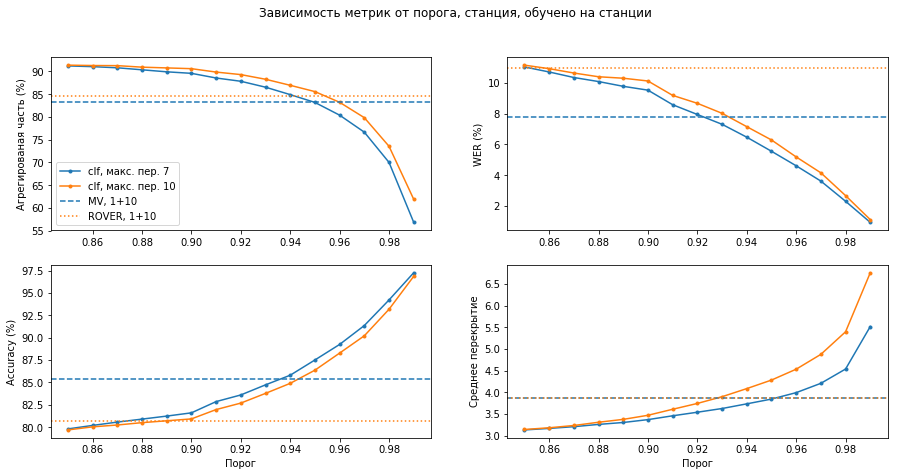

In [79]:
print('toloka_assignments_repeat_1')
print('Prod: ')
prod_agg_metrics1 = evaluate_metrics(test_rows_quasar_valid, 'toloka_assignments_repeat_1', aggregate_prod)
print('\nROVER:')
rover_agg_metrics1 = evaluate_metrics(test_rows_quasar_valid, 'toloka_assignments_repeat_1', aggregate_rover)
print('\n\ntoloka_assignments_repeat_2_with_chorus_and_pitch')
print('\nProd: ')
prod_agg_metrics2 = evaluate_metrics(test_rows_quasar_valid, 'toloka_assignments_repeat_2_with_chorus_and_pitch', aggregate_prod) 
print('\nROVER:')
rover_agg_metrics2 = evaluate_metrics(test_rows_quasar_valid, 'toloka_assignments_repeat_2_with_chorus_and_pitch', aggregate_rover)

prod_agg_metrics = []
rover_agg_metrics = []
for i in range(len(prod_agg_metrics1)):
    prod_agg_metrics.append((prod_agg_metrics1[i] + prod_agg_metrics2[i]) / 2)
    rover_agg_metrics.append((rover_agg_metrics1[i] + rover_agg_metrics2[i]) / 2)

plt.figure(figsize=(15,7))
plt.suptitle('Зависимость метрик от порога, станция, обучено на станции')
plt.subplot(221)
plt.plot(scores_clf_quasar_max_cost_7[:, 0], 
         scores_clf_quasar_max_cost_7[:, 1] * 100, 
         ".-", 
         label="clf, макс. пер. 7")
plt.plot(scores_clf_quasar_max_cost_10[:, 0], 
         scores_clf_quasar_max_cost_10[:, 1] * 100, 
         ".-", 
         label="clf, макс. пер. 10")
plt.axhline(y=prod_agg_metrics[0] * 100, color=u'#1f77b4', linestyle='--', label="MV, 1+10")
plt.axhline(y=rover_agg_metrics[0] * 100, color=u'#ff7f0e', linestyle=':', label="ROVER, 1+10")
plt.legend()
plt.ylabel('Агрегированая часть (%)')

plt.subplot(222)
plt.plot(scores_clf_quasar_max_cost_7[:, 0], 
         scores_clf_quasar_max_cost_7[:, 2] * 100, 
         ".-")
plt.plot(scores_clf_quasar_max_cost_10[:, 0], 
         scores_clf_quasar_max_cost_10[:, 2] * 100, 
         ".-")
plt.axhline(y=prod_agg_metrics[1] * 100, color=u'#1f77b4', linestyle='--')
plt.axhline(y=rover_agg_metrics[1] * 100, color=u'#ff7f0e', linestyle=':')

plt.ylabel('WER (%)')


plt.subplot(223)
plt.plot(scores_clf_quasar_max_cost_7[:, 0], 
         scores_clf_quasar_max_cost_7[:, 3] * 100, 
         ".-")
plt.plot(scores_clf_quasar_max_cost_10[:, 0], 
         scores_clf_quasar_max_cost_10[:, 3] * 100, 
         ".-")
plt.axhline(y=prod_agg_metrics[2] * 100, color=u'#1f77b4', linestyle='--')
plt.axhline(y=rover_agg_metrics[2] * 100, color=u'#ff7f0e', linestyle=':')
plt.ylabel('Accuracy (%)')

plt.xlabel('Порог')

plt.subplot(224)
plt.plot(scores_clf_quasar_max_cost_7[:, 0], 
         scores_clf_quasar_max_cost_7[:, 4], 
         ".-")
plt.plot(scores_clf_quasar_max_cost_10[:, 0], 
         scores_clf_quasar_max_cost_10[:, 4], 
         ".-")
plt.axhline(y=prod_agg_metrics[3], color=u'#1f77b4', linestyle='--')
plt.axhline(y=rover_agg_metrics[3], color=u'#ff7f0e', linestyle=':')
plt.ylabel('Среднее перекрытие')

plt.xlabel('Порог')

plt.savefig("metrics_quasar_true.png")
plt.show()

In [60]:
valid_data = yt.read_table(
    "//home/voice/edvls/tickets/VA-442_ideal_testsets/assistant_ideal_annotations_2019-02-16__2019-02-25"
)
valid_data = list(valid_data)
test_rows_valid = [row for row in valid_data if row["mark"] == "TEST"]

In [80]:
scores_gs_test_max_cost_7 = []

for treshhold in np.linspace(0.85, 0.95, 11):
    print(treshhold)
    metrics = evaluate_metrics_clf_(test_rows_valid, 
                                    test_features_10, 
                                    'toloka_assignments_repeat_1+10', 
                                    gs, 
                                    treshhold, 
                                    max_cost=7)
    scores_gs_test_max_cost_7.append((treshhold, *metrics))
scores_gs_test_max_cost_7 = np.array(scores_gs_test_max_cost_7)

0.85
Aggregated: 76.3913%
WER: 12.1135%
Accuracy: 68.7195%
Mean overlap: 3.164
0.86
Aggregated: 76.4773%
WER: 12.1377%
Accuracy: 68.9047%
Mean overlap: 3.223
0.87
Aggregated: 76.4487%
WER: 12.0078%
Accuracy: 69.0432%
Mean overlap: 3.276
0.88
Aggregated: 76.1044%
WER: 11.3575%
Accuracy: 69.4308%
Mean overlap: 3.347
0.89
Aggregated: 75.4733%
WER: 10.8937%
Accuracy: 70.1254%
Mean overlap: 3.451
0.8999999999999999
Aggregated: 74.7849%
WER: 10.2809%
Accuracy: 71.1546%
Mean overlap: 3.563
0.9099999999999999
Aggregated: 73.9816%
WER: 9.6826%
Accuracy: 72.0047%
Mean overlap: 3.71
0.9199999999999999
Aggregated: 73.1497%
WER: 9.2051%
Accuracy: 73.0588%
Mean overlap: 3.875
0.9299999999999999
Aggregated: 71.7154%
WER: 8.4861%
Accuracy: 74.7200%
Mean overlap: 4.058
0.94
Aggregated: 70.1090%
WER: 7.6861%
Accuracy: 76.2684%
Mean overlap: 4.271
0.95
Aggregated: 67.5846%
WER: 6.6511%
Accuracy: 78.6078%
Mean overlap: 4.491


In [81]:
scores_gs_test_max_cost_10 = []

for treshhold in np.linspace(0.85, 0.95, 11):
    print(treshhold)
    metrics = evaluate_metrics_clf_(test_rows_valid, 
                                    test_features_10, 
                                    'toloka_assignments_repeat_1+10', 
                                    gs, 
                                    treshhold, 
                                    max_cost=10)
    scores_gs_test_max_cost_10.append((treshhold, *metrics))
scores_gs_test_max_cost_10 = np.array(scores_gs_test_max_cost_10)

0.85
Aggregated: 76.5060%
WER: 12.1797%
Accuracy: 68.6539%
Mean overlap: 3.172
0.86
Aggregated: 76.7355%
WER: 12.2461%
Accuracy: 68.7477%
Mean overlap: 3.233
0.87
Aggregated: 76.7642%
WER: 12.1036%
Accuracy: 68.7967%
Mean overlap: 3.293
0.88
Aggregated: 76.7068%
WER: 11.7669%
Accuracy: 68.9978%
Mean overlap: 3.379
0.89
Aggregated: 76.5634%
WER: 11.5316%
Accuracy: 69.3518%
Mean overlap: 3.508
0.8999999999999999
Aggregated: 76.0470%
WER: 10.8738%
Accuracy: 70.3885%
Mean overlap: 3.651
0.9099999999999999
Aggregated: 75.6454%
WER: 10.3637%
Accuracy: 71.1035%
Mean overlap: 3.851
0.9199999999999999
Aggregated: 75.3586%
WER: 9.8389%
Accuracy: 71.7549%
Mean overlap: 4.083
0.9299999999999999
Aggregated: 74.6127%
WER: 9.3048%
Accuracy: 73.0488%
Mean overlap: 4.361
0.94
Aggregated: 73.2645%
WER: 8.3101%
Accuracy: 74.6280%
Mean overlap: 4.733
0.95
Aggregated: 71.4859%
WER: 7.2847%
Accuracy: 76.6453%
Mean overlap: 5.175


toloka_assignments_repeat_1
Prod: 
Aggregated: 68.3878%
WER: 6.5456%
Accuracy: 80.9144%
Mean overlap: 3.91

ROVER:
Aggregated: 69.5353%
WER: 9.0810%
Accuracy: 76.5264%
Mean overlap: 3.91


toloka_assignments_repeat_1

Prod: 
Aggregated: 67.2117%
WER: 6.0881%
Accuracy: 82.1169%
Mean overlap: 3.923

ROVER:
Aggregated: 69.3919%
WER: 9.0080%
Accuracy: 75.8578%
Mean overlap: 3.923


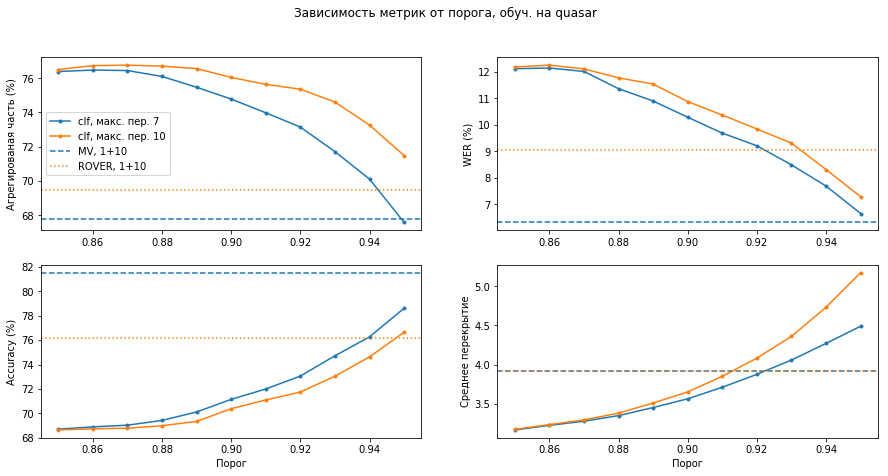

In [82]:
print('toloka_assignments_repeat_1')
print('Prod: ')
prod_agg_metrics1 = evaluate_metrics(test_rows_valid, 'toloka_assignments_repeat_1', aggregate_prod)
print('\nROVER:')
rover_agg_metrics1 = evaluate_metrics(test_rows_valid, 'toloka_assignments_repeat_1', aggregate_rover)
print('\n\ntoloka_assignments_repeat_1')
print('\nProd: ')
prod_agg_metrics2 = evaluate_metrics(test_rows_valid, 'toloka_assignments_repeat_10', aggregate_prod) 
print('\nROVER:')
rover_agg_metrics2 = evaluate_metrics(test_rows_valid, 'toloka_assignments_repeat_10', aggregate_rover)

prod_agg_metrics = []
rover_agg_metrics = []
for i in range(len(prod_agg_metrics1)):
    prod_agg_metrics.append((prod_agg_metrics1[i] + prod_agg_metrics2[i]) / 2)
    rover_agg_metrics.append((rover_agg_metrics1[i] + rover_agg_metrics2[i]) / 2)


plt.figure(figsize=(15,7))
plt.suptitle('Зависимость метрик от порога, обуч. на quasar')
plt.subplot(221)
plt.plot(scores_gs_test_max_cost_7[:, 0], 
         scores_gs_test_max_cost_7[:, 1] * 100, 
         ".-", 
         label="clf, макс. пер. 7")
plt.plot(scores_gs_test_max_cost_10[:, 0], 
         scores_gs_test_max_cost_10[:, 1] * 100, 
         ".-", 
         label="clf, макс. пер. 10")
plt.axhline(y=prod_agg_metrics[0] * 100, color=u'#1f77b4', linestyle='--', label="MV, 1+10")
plt.axhline(y=rover_agg_metrics[0] * 100, color=u'#ff7f0e', linestyle=':', label="ROVER, 1+10")
plt.legend()
plt.ylabel('Агрегированая часть (%)')

plt.subplot(222)
plt.plot(scores_gs_test_max_cost_7[:, 0], 
         scores_gs_test_max_cost_7[:, 2] * 100, 
         ".-")
plt.plot(scores_gs_test_max_cost_10[:, 0], 
         scores_gs_test_max_cost_10[:, 2] * 100, 
         ".-")
plt.axhline(y=prod_agg_metrics[1] * 100, color=u'#1f77b4', linestyle='--')
plt.axhline(y=rover_agg_metrics[1] * 100, color=u'#ff7f0e', linestyle=':')

plt.ylabel('WER (%)')


plt.subplot(223)
plt.plot(scores_gs_test_max_cost_7[:, 0], 
         scores_gs_test_max_cost_7[:, 3] * 100, 
         ".-")
plt.plot(scores_gs_test_max_cost_10[:, 0], 
         scores_gs_test_max_cost_10[:, 3] * 100, 
         ".-")
plt.axhline(y=prod_agg_metrics[2] * 100, color=u'#1f77b4', linestyle='--')
plt.axhline(y=rover_agg_metrics[2] * 100, color=u'#ff7f0e', linestyle=':')
plt.ylabel('Accuracy (%)')

plt.xlabel('Порог')

plt.subplot(224)
plt.plot(scores_gs_test_max_cost_7[:, 0], 
         scores_gs_test_max_cost_7[:, 4], 
         ".-")
plt.plot(scores_gs_test_max_cost_10[:, 0], 
         scores_gs_test_max_cost_10[:, 4], 
         ".-")
plt.axhline(y=prod_agg_metrics[3], color=u'#1f77b4', linestyle='--')
plt.axhline(y=rover_agg_metrics[3], color=u'#ff7f0e', linestyle=':')
plt.ylabel('Среднее перекрытие')

plt.xlabel('Порог')

plt.savefig("metrics_quasar_to_pp_true.png")
plt.show()

In [110]:
dict(zip(['threshold', 'Агрегированная часть', 'WER', 'Accuracy', 'Ср. перекрытие'], 
         list(scores_gs_test_max_cost_7[-5] )))

{'threshold': 0.94,
 'Агрегированная часть': 0.6824440619621343,
 'WER': 0.06581322829476448,
 'Accuracy': 0.7814207650273224,
 'Ср. перекрытие': 3.7613310384394723}

In [109]:
list(scores_gs_test_max_cost_7[-5])

[0.94,
 0.6824440619621343,
 0.06581322829476448,
 0.7814207650273224,
 3.7613310384394723]

In [111]:
prod_agg_metrics

[0.6779977051061389,
 0.06316841828725746,
 0.8151568680948821,
 3.9160929432013774]

In [ ]:
scores_gs_test_max_cost_6 = []

for treshhold in np.linspace(0.7, 0.98, 29):
    print(treshhold)
    metrics = evaluate_metrics_clf_(test_rows_valid, 
                                    test_features_10, 
                                    'toloka_assignments_repeat_1+10', 
                                    gs, 
                                    treshhold, 
                                    max_cost=6)
    scores_gs_test_max_cost_6.append((treshhold, *metrics))
scores_gs_test_max_cost_6 = np.array(scores_gs_test_max_cost_6)

0.7
Aggregated: 75.0717%
WER: 11.7362%
Accuracy: 69.4306%
Mean overlap: 3.001
0.71
Aggregated: 75.1004%
WER: 11.7385%
Accuracy: 69.4041%
Mean overlap: 3.001
0.72
Aggregated: 75.1004%
WER: 11.7007%
Accuracy: 69.3659%
Mean overlap: 3.002
0.73
Aggregated: 75.1004%
WER: 11.6931%
Accuracy: 69.2895%
Mean overlap: 3.004
0.74
Aggregated: 75.1004%
WER: 11.6931%
Accuracy: 69.2895%
Mean overlap: 3.004
0.75
Aggregated: 75.1291%
WER: 11.7114%
Accuracy: 69.3013%
Mean overlap: 3.006
0.76
Aggregated: 75.1291%
WER: 11.7114%
Accuracy: 69.3013%
Mean overlap: 3.006
0.77
Aggregated: 75.1865%
WER: 11.6732%
Accuracy: 69.3247%
Mean overlap: 3.008
0.7799999999999999
Aggregated: 75.2151%
WER: 11.6621%
Accuracy: 69.3745%
Mean overlap: 3.012
0.7899999999999999
Aggregated: 75.2725%
WER: 11.6440%
Accuracy: 69.3216%
Mean overlap: 3.017
0.7999999999999999
Aggregated: 75.3586%
WER: 11.7040%
Accuracy: 69.2805%
Mean overlap: 3.021
0.8099999999999999
Aggregated: 75.5307%
WER: 11.7156%
Accuracy: 69.0847%
Mean overlap: 3.0

In [ ]:
scores_gs_test_max_cost_8 = []

for treshhold in np.linspace(0.7, 0.98, 29):
    print(treshhold)
    metrics = evaluate_metrics_clf_(test_rows_valid, 
                                    test_features_10, 
                                    'toloka_assignments_repeat_1+10', 
                                    gs, 
                                    treshhold, 
                                    max_cost=8)
    scores_gs_test_max_cost_8.append((treshhold, *metrics))
scores_gs_test_max_cost_8 = np.array(scores_gs_test_max_cost_8)

In [ ]:
scores_gs_test_max_cost_9 = []

for treshhold in np.linspace(0.7, 0.98, 29):
    print(treshhold)
    metrics = evaluate_metrics_clf_(test_rows_valid, 
                                    test_features_10, 
                                    'toloka_assignments_repeat_1+10', 
                                    gs, 
                                    treshhold, 
                                    max_cost=9)
    scores_gs_test_max_cost_9.append((treshhold, *metrics))
scores_gs_test_max_cost_9 = np.array(scores_gs_test_max_cost_9)

In [128]:
for row in data_table:
    row['toloka_assignments_repeat_with_chorus_and_pitch'] = row['toloka_assignments_repeat_5_with_chorus_and_pitch'] + row['toloka_assignments_repeat_7_with_chorus_and_pitch']

In [129]:
train_rows = [row for row in data_table if row["mark"] == "TRAIN"]
test_rows = [row for row in data_table if row["mark"] == "TEST"]
for row in test_rows:
    if 'text' in row:
        del row['text']

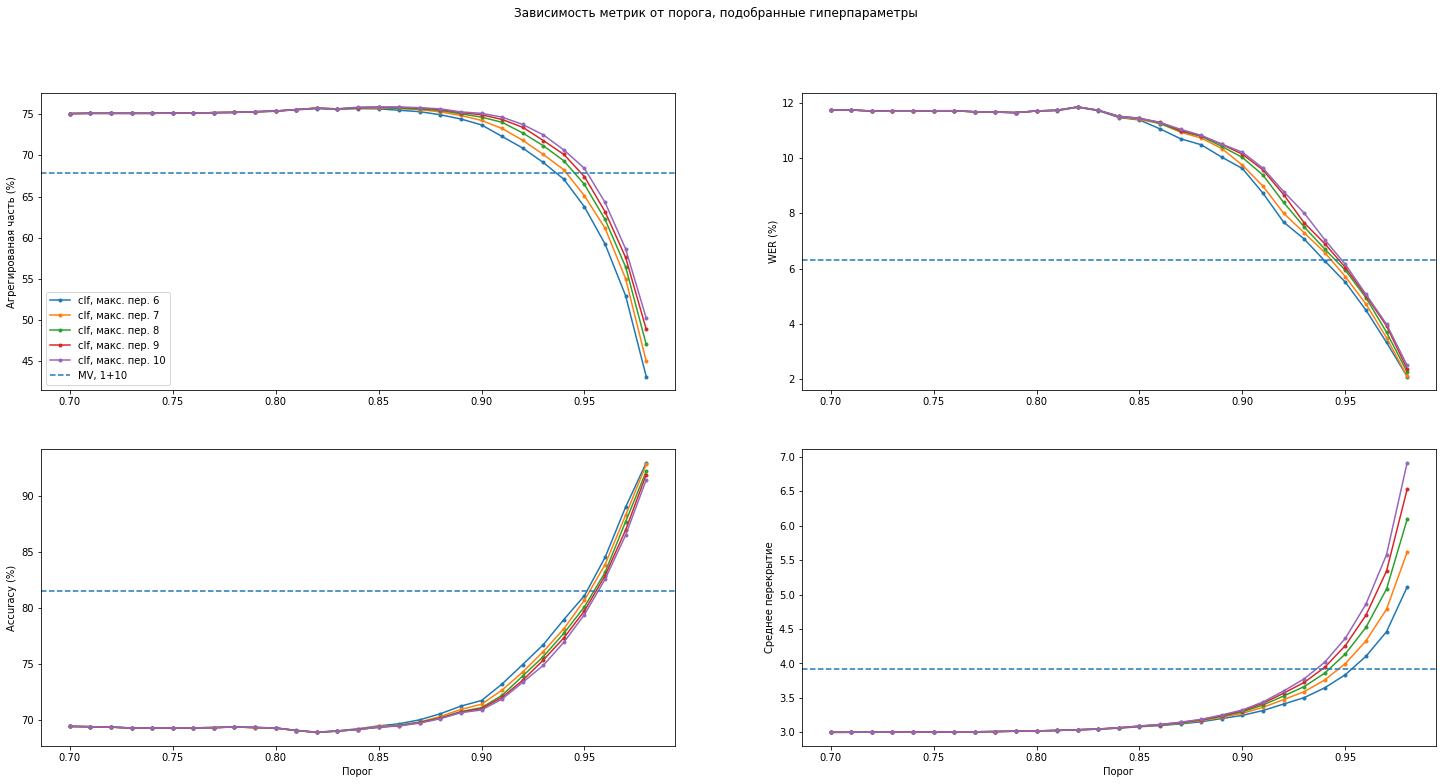

In [123]:
plt.figure(figsize=(25,12))
plt.suptitle('Зависимость метрик от порога, подобранные гиперпараметры')
plt.subplot(221)
plt.plot(scores_gs_test_max_cost_6[:, 0], 
         scores_gs_test_max_cost_6[:, 1] * 100, 
         ".-", 
         label="clf, макс. пер. 6")
plt.plot(scores_gs_test_max_cost_7[:, 0], 
         scores_gs_test_max_cost_7[:, 1] * 100, 
         ".-", 
         label="clf, макс. пер. 7")
plt.plot(scores_gs_test_max_cost_8[:, 0], 
         scores_gs_test_max_cost_8[:, 1] * 100, 
         ".-", 
         label="clf, макс. пер. 8")
plt.plot(scores_gs_test_max_cost_9[:, 0], 
         scores_gs_test_max_cost_9[:, 1] * 100, 
         ".-", 
         label="clf, макс. пер. 9")
plt.plot(scores_gs_test_max_cost_10[:, 0], 
         scores_gs_test_max_cost_10[:, 1] * 100, 
         ".-", 
         label="clf, макс. пер. 10")
plt.axhline(y=prod_agg_metrics[0] * 100, color=u'#1f77b4', linestyle='--', label="MV, 1+10")
# plt.axhline(y=rover_agg_metrics[0] * 100, color=u'#ff7f0e', linestyle=':', label="ROVER, 1+10")
plt.legend()
plt.ylabel('Агрегированая часть (%)')

plt.subplot(222)
plt.plot(scores_gs_test_max_cost_6[:, 0], 
         scores_gs_test_max_cost_6[:, 2] * 100, 
         ".-")
plt.plot(scores_gs_test_max_cost_7[:, 0], 
         scores_gs_test_max_cost_7[:, 2] * 100, 
         ".-")
plt.plot(scores_gs_test_max_cost_8[:, 0], 
         scores_gs_test_max_cost_8[:, 2] * 100, 
         ".-")
plt.plot(scores_gs_test_max_cost_9[:, 0], 
         scores_gs_test_max_cost_9[:, 2] * 100, 
         ".-")
plt.plot(scores_gs_test_max_cost_10[:, 0], 
         scores_gs_test_max_cost_10[:, 2] * 100, 
         ".-")
plt.axhline(y=prod_agg_metrics[1] * 100, color=u'#1f77b4', linestyle='--')
# plt.axhline(y=rover_agg_metrics[1] * 100, color=u'#ff7f0e', linestyle=':')

plt.ylabel('WER (%)')


plt.subplot(223)
plt.plot(scores_gs_test_max_cost_6[:, 0], 
         scores_gs_test_max_cost_6[:, 3] * 100, 
         ".-")
plt.plot(scores_gs_test_max_cost_7[:, 0], 
         scores_gs_test_max_cost_7[:, 3] * 100, 
         ".-")
plt.plot(scores_gs_test_max_cost_8[:, 0], 
         scores_gs_test_max_cost_8[:, 3] * 100, 
         ".-")
plt.plot(scores_gs_test_max_cost_9[:, 0], 
         scores_gs_test_max_cost_9[:, 3] * 100, 
         ".-")
plt.plot(scores_gs_test_max_cost_10[:, 0], 
         scores_gs_test_max_cost_10[:, 3] * 100, 
         ".-")
plt.axhline(y=prod_agg_metrics[2] * 100, color=u'#1f77b4', linestyle='--')
# plt.axhline(y=rover_agg_metrics[2] * 100, color=u'#ff7f0e', linestyle=':')
plt.ylabel('Accuracy (%)')

plt.xlabel('Порог')

plt.subplot(224)
plt.plot(scores_gs_test_max_cost_6[:, 0], 
         scores_gs_test_max_cost_6[:, 4], 
         ".-")
plt.plot(scores_gs_test_max_cost_7[:, 0], 
         scores_gs_test_max_cost_7[:, 4], 
         ".-")
plt.plot(scores_gs_test_max_cost_8[:, 0], 
         scores_gs_test_max_cost_8[:, 4], 
         ".-")
plt.plot(scores_gs_test_max_cost_9[:, 0], 
         scores_gs_test_max_cost_9[:, 4], 
         ".-")
plt.plot(scores_gs_test_max_cost_10[:, 0], 
         scores_gs_test_max_cost_10[:, 4], 
         ".-")
plt.axhline(y=prod_agg_metrics[3], color=u'#1f77b4', linestyle='--')
# plt.axhline(y=rover_agg_metrics[3], color=u'#ff7f0e', linestyle=':')
plt.ylabel('Среднее перекрытие')

plt.xlabel('Порог')

plt.savefig("metrics_big_overlap_true_gs_many.png")
plt.show()

In [ ]:
train_features_chorus = extract_features(train_rows, 
                                         "toloka_assignments_repeat_with_chorus_and_pitch")
test_features_chorus = extract_features(test_rows, 
                                         "toloka_assignments_repeat_with_chorus_and_pitch")

In [ ]:
scores_gs_chorus_max_cost_7 = []

for treshhold in np.linspace(0.7, 0.98, 29):
    print(treshhold)
    metrics = evaluate_metrics_clf_(test_rows_valid, 
                                    test_features_chorus, 
                                    'toloka_assignments_repeat_with_chorus_and_pitch', 
                                    gs, 
                                    treshhold, 
                                    max_cost=7)
    scores_gs_chorus_max_cost_7.append((treshhold, *metrics))
scores_gs_chorus_max_cost_7 = np.array(scores_gs_chorus_max_cost_7)

0.7
Aggregated: 71.8015%
WER: 16.6135%
Accuracy: 60.9668%
Mean overlap: 3.006
0.71
Aggregated: 71.8015%
WER: 16.6498%
Accuracy: 60.8869%
Mean overlap: 3.009
0.72
Aggregated: 71.8302%
WER: 16.6654%
Accuracy: 60.9425%
Mean overlap: 3.012
0.73
Aggregated: 71.8015%
WER: 16.6317%
Accuracy: 61.0467%
Mean overlap: 3.017
0.74
Aggregated: 71.7441%
WER: 16.5603%
Accuracy: 61.1355%
Mean overlap: 3.022
0.75
Aggregated: 71.7728%
WER: 16.6200%
Accuracy: 61.1910%
Mean overlap: 3.028
0.76
Aggregated: 71.8302%
WER: 16.6744%
Accuracy: 61.1022%
Mean overlap: 3.034
0.77
Aggregated: 72.0310%
WER: 16.7042%
Accuracy: 61.0115%
Mean overlap: 3.042
0.7799999999999999
Aggregated: 72.0310%
WER: 16.6085%
Accuracy: 61.0912%
Mean overlap: 3.05
0.7899999999999999
Aggregated: 72.1457%
WER: 16.5504%
Accuracy: 61.0736%
Mean overlap: 3.061
0.7999999999999999
Aggregated: 72.2031%
WER: 16.5261%
Accuracy: 61.1442%
Mean overlap: 3.072
0.8099999999999999
Aggregated: 72.5186%
WER: 16.5433%
Accuracy: 61.0364%
Mean overlap: 3.08

In [ ]:
scores_gs_chorus_max_cost_10 = []

for treshhold in np.linspace(0.7, 0.98, 29):
    print(treshhold)
    metrics = evaluate_metrics_clf_(test_rows_valid, 
                                    test_features_chorus, 
                                    'toloka_assignments_repeat_with_chorus_and_pitch', 
                                    gs, 
                                    treshhold, 
                                    max_cost=10)
    scores_gs_chorus_max_cost_10.append((treshhold, *metrics))
scores_gs_chorus_max_cost_10 = np.array(scores_gs_chorus_max_cost_10)

In [156]:
print('toloka_assignments_repeat_5_with_chorus_and_pitch')
print('Prod: ')
prod_agg_metrics1 = evaluate_metrics(test_rows_valid, 'toloka_assignments_repeat_5_with_chorus_and_pitch', aggregate_prod)
print('\nROVER:')
rover_agg_metrics1 = evaluate_metrics(test_rows_valid, 'toloka_assignments_repeat_5_with_chorus_and_pitch', aggregate_rover)
print('\n\ntoloka_assignments_repeat_7_with_chorus_and_pitch')
print('\nProd: ')
prod_agg_metrics10 = evaluate_metrics(test_rows_valid, 'toloka_assignments_repeat_7_with_chorus_and_pitch', aggregate_prod) 
print('\nROVER:')
rover_agg_metrics10 = evaluate_metrics(test_rows_valid, 'toloka_assignments_repeat_7_with_chorus_and_pitch', aggregate_rover)

prod_agg_metrics = []
rover_agg_metrics = []
for i in range(len(prod_agg_metrics1)):
    prod_agg_metrics.append((prod_agg_metrics1[i] + prod_agg_metrics10[i]) / 2)
    rover_agg_metrics.append((rover_agg_metrics1[i] + rover_agg_metrics10[i]) / 2)

toloka_assignments_repeat_5_with_chorus_and_pitch
Prod: 
Aggregated: 60.6139%
WER: 8.3766%
Accuracy: 77.8514%
Mean overlap: 3.997

ROVER:
Aggregated: 65.7487%
WER: 14.9624%
Accuracy: 66.7976%
Mean overlap: 3.997


toloka_assignments_repeat_7_with_chorus_and_pitch

Prod: 
Aggregated: 60.8147%
WER: 9.0265%
Accuracy: 76.8396%
Mean overlap: 3.979

ROVER:
Aggregated: 64.2283%
WER: 14.7990%
Accuracy: 67.6641%
Mean overlap: 3.979


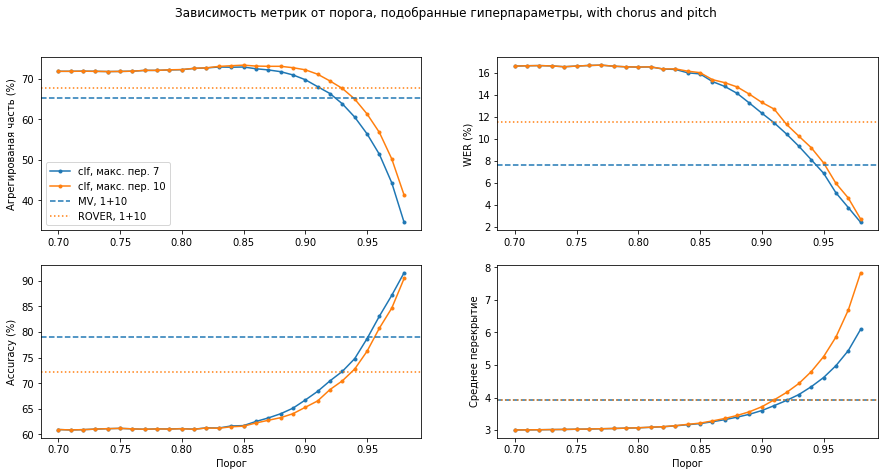

In [162]:
plt.figure(figsize=(15,7))
plt.suptitle('Зависимость метрик от порога, подобранные гиперпараметры, with chorus and pitch')
plt.subplot(221)
plt.plot(scores_gs_chorus_max_cost_7[:, 0], 
         scores_gs_chorus_max_cost_7[:, 1] * 100, 
         ".-", 
         label="clf, макс. пер. 7")
plt.plot(scores_gs_chorus_max_cost_10[:, 0], 
         scores_gs_chorus_max_cost_10[:, 1] * 100, 
         ".-", 
         label="clf, макс. пер. 10")
plt.axhline(y=prod_agg_metrics[0] * 100, color=u'#1f77b4', linestyle='--', label="MV, 1+10")
plt.axhline(y=rover_agg_metrics[0] * 100, color=u'#ff7f0e', linestyle=':', label="ROVER, 1+10")
plt.legend()
plt.ylabel('Агрегированая часть (%)')

plt.subplot(222)
plt.plot(scores_gs_chorus_max_cost_7[:, 0], 
         scores_gs_chorus_max_cost_7[:, 2] * 100, 
         ".-")
plt.plot(scores_gs_chorus_max_cost_10[:, 0], 
         scores_gs_chorus_max_cost_10[:, 2] * 100, 
         ".-")
plt.axhline(y=prod_agg_metrics[1] * 100, color=u'#1f77b4', linestyle='--')
plt.axhline(y=rover_agg_metrics[1] * 100, color=u'#ff7f0e', linestyle=':')

plt.ylabel('WER (%)')


plt.subplot(223)
plt.plot(scores_gs_chorus_max_cost_7[:, 0], 
         scores_gs_chorus_max_cost_7[:, 3] * 100, 
         ".-")
plt.plot(scores_gs_chorus_max_cost_10[:, 0], 
         scores_gs_chorus_max_cost_10[:, 3] * 100, 
         ".-")
plt.axhline(y=prod_agg_metrics[2] * 100, color=u'#1f77b4', linestyle='--')
plt.axhline(y=rover_agg_metrics[2] * 100, color=u'#ff7f0e', linestyle=':')
plt.ylabel('Accuracy (%)')

plt.xlabel('Порог')

plt.subplot(224)
plt.plot(scores_gs_chorus_max_cost_7[:, 0], 
         scores_gs_chorus_max_cost_7[:, 4], 
         ".-")
plt.plot(scores_gs_chorus_max_cost_10[:, 0], 
         scores_gs_chorus_max_cost_10[:, 4], 
         ".-")
plt.axhline(y=prod_agg_metrics[3], color=u'#1f77b4', linestyle='--')
plt.axhline(y=rover_agg_metrics[3], color=u'#ff7f0e', linestyle=':')
plt.ylabel('Среднее перекрытие')

plt.xlabel('Порог')

plt.savefig("metrics_big_overlap_true_gs_chorus.png")
plt.show()

In [ ]:
test_features_pitch = extract_features(test_rows, "toloka_assignments_repeat_2+3_with_pitch")

In [ ]:
scores_gs_pitch_max_cost_7 = []

for treshhold in np.linspace(0.7, 0.98, 29):
    print(treshhold)
    metrics = evaluate_metrics_clf_(test_rows_valid, 
                                    test_features_pitch, 
                                    'toloka_assignments_repeat_2+3_with_pitch', 
                                    gs, 
                                    treshhold, 
                                    max_cost=7)
    scores_gs_pitch_max_cost_7.append((treshhold, *metrics))
scores_gs_pitch_max_cost_7 = np.array(scores_gs_pitch_max_cost_7)

0.7


In [ ]:
scores_gs_pitch_max_cost_10 = []

for treshhold in np.linspace(0.7, 0.98, 29):
    print(treshhold)
    metrics = evaluate_metrics_clf_(test_rows_valid, 
                                    test_features_pitch, 
                                    'toloka_assignments_repeat_2+3_with_pitch', 
                                    gs, 
                                    treshhold, 
                                    max_cost=10)
    scores_gs_pitch_max_cost_10.append((treshhold, *metrics))
scores_gs_pitch_max_cost_10 = np.array(scores_gs_pitch_max_cost_10)

In [158]:
print('toloka_assignments_repeat_2_with_pitch')
print('Prod: ')
prod_agg_metrics1 = evaluate_metrics(test_rows_valid, 'toloka_assignments_repeat_2_with_pitch', aggregate_prod)
print('\nROVER:')
rover_agg_metrics1 = evaluate_metrics(test_rows_valid, 'toloka_assignments_repeat_2_with_pitch', aggregate_rover)
print('\n\toloka_assignments_repeat_3_with_pitch')
print('\nProd: ')
prod_agg_metrics10 = evaluate_metrics(test_rows_valid, 'toloka_assignments_repeat_3_with_pitch', aggregate_prod) 
print('\nROVER:')
rover_agg_metrics10 = evaluate_metrics(test_rows_valid, 'toloka_assignments_repeat_3_with_pitch', aggregate_rover)

prod_agg_metrics = []
rover_agg_metrics = []
for i in range(len(prod_agg_metrics1)):
    prod_agg_metrics.append((prod_agg_metrics1[i] + prod_agg_metrics10[i]) / 2)
    rover_agg_metrics.append((rover_agg_metrics1[i] + rover_agg_metrics10[i]) / 2)

toloka_assignments_repeat_2_with_pitch
Prod: 
Aggregated: 63.5112%
WER: 7.4502%
Accuracy: 79.2683%
Mean overlap: 3.958

ROVER:
Aggregated: 66.3798%
WER: 12.4751%
Accuracy: 71.2187%
Mean overlap: 3.958


toloka_assignments_repeat_7_with_chorus_and_pitch

Prod: 
Aggregated: 66.9248%
WER: 7.8814%
Accuracy: 78.6112%
Mean overlap: 3.91

ROVER:
Aggregated: 69.2484%
WER: 10.6212%
Accuracy: 72.9909%
Mean overlap: 3.91


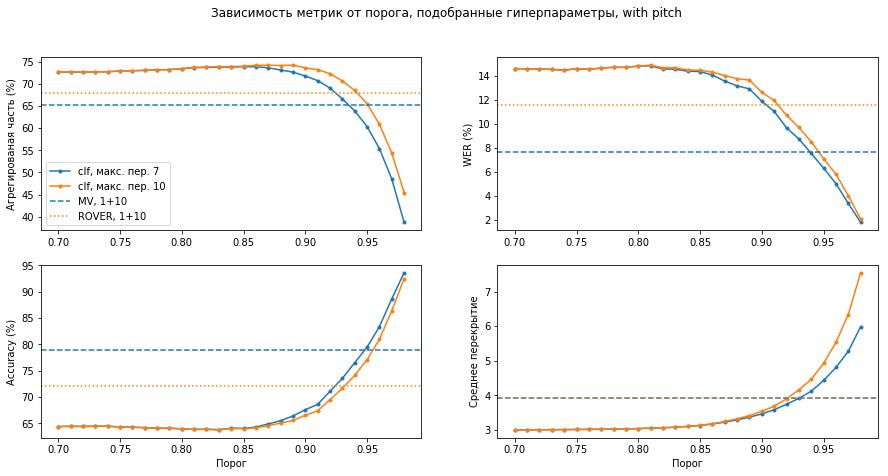

In [160]:
plt.figure(figsize=(15,7))
plt.suptitle('Зависимость метрик от порога, подобранные гиперпараметры, with pitch')
plt.subplot(221)
plt.plot(scores_gs_pitch_max_cost_7[:, 0], 
         scores_gs_pitch_max_cost_7[:, 1] * 100, 
         ".-", 
         label="clf, макс. пер. 7")
plt.plot(scores_gs_pitch_max_cost_10[:, 0], 
         scores_gs_pitch_max_cost_10[:, 1] * 100, 
         ".-", 
         label="clf, макс. пер. 10")
plt.axhline(y=prod_agg_metrics[0] * 100, color=u'#1f77b4', linestyle='--', label="MV, 1+10")
plt.axhline(y=rover_agg_metrics[0] * 100, color=u'#ff7f0e', linestyle=':', label="ROVER, 1+10")
plt.legend()
plt.ylabel('Агрегированая часть (%)')

plt.subplot(222)
plt.plot(scores_gs_pitch_max_cost_7[:, 0], 
         scores_gs_pitch_max_cost_7[:, 2] * 100, 
         ".-")
plt.plot(scores_gs_pitch_max_cost_10[:, 0], 
         scores_gs_pitch_max_cost_10[:, 2] * 100, 
         ".-")
plt.axhline(y=prod_agg_metrics[1] * 100, color=u'#1f77b4', linestyle='--')
plt.axhline(y=rover_agg_metrics[1] * 100, color=u'#ff7f0e', linestyle=':')

plt.ylabel('WER (%)')


plt.subplot(223)
plt.plot(scores_gs_pitch_max_cost_7[:, 0], 
         scores_gs_pitch_max_cost_7[:, 3] * 100, 
         ".-")
plt.plot(scores_gs_pitch_max_cost_10[:, 0], 
         scores_gs_pitch_max_cost_10[:, 3] * 100, 
         ".-")
plt.axhline(y=prod_agg_metrics[2] * 100, color=u'#1f77b4', linestyle='--')
plt.axhline(y=rover_agg_metrics[2] * 100, color=u'#ff7f0e', linestyle=':')
plt.ylabel('Accuracy (%)')

plt.xlabel('Порог')

plt.subplot(224)
plt.plot(scores_gs_pitch_max_cost_7[:, 0], 
         scores_gs_pitch_max_cost_7[:, 4], 
         ".-")
plt.plot(scores_gs_pitch_max_cost_10[:, 0], 
         scores_gs_pitch_max_cost_10[:, 4], 
         ".-")
plt.axhline(y=prod_agg_metrics[3], color=u'#1f77b4', linestyle='--')
plt.axhline(y=rover_agg_metrics[3], color=u'#ff7f0e', linestyle=':')
plt.ylabel('Среднее перекрытие')

plt.xlabel('Порог')

plt.savefig("metrics_big_overlap_true_gs_pitch.png")
plt.show()

In [144]:
data_table_quasar = yt.read_table(
    "//home/voice/edvls/tickets/VA-442_ideal_testsets/quasar-general_with_spotter_ideal_annotations_2019-04-18__2019-04-24"
)
data_table_quasar = list(data_table_quasar)
for row in data_table_quasar:
    row['toloka_assignments_repeat'] = row['toloka_assignments_repeat_1'] + row['toloka_assignments_repeat_2_with_chorus_and_pitch']
test_rows_quasar = [row for row in data_table_quasar if row["mark"] == "TEST" and len(row['toloka_assignments_repeat']) == 10]
for row in test_rows_quasar:
    if 'text' in row:
        del row['text']

In [ ]:
test_features_quasar = extract_features(test_rows_quasar, "toloka_assignments_repeat")

In [ ]:
data_table_quasar_valid = yt.read_table(
    "//home/voice/edvls/tickets/VA-442_ideal_testsets/quasar-general_with_spotter_ideal_annotations_2019-04-18__2019-04-24"
)
data_table_quasar_valid = list(data_table_quasar_valid)
for row in data_table_quasar_valid:
    row['toloka_assignments_repeat'] = row['toloka_assignments_repeat_1'] + row['toloka_assignments_repeat_2_with_chorus_and_pitch']
test_rows_quasar_valid = [row for row in data_table_quasar_valid if row["mark"] == "TEST" and len(row['toloka_assignments_repeat']) == 10]

In [ ]:
scores_gs_quasar_max_cost_7 = []

for treshhold in np.linspace(0.7, 0.98, 29):
    print(treshhold)
    metrics = evaluate_metrics_clf_(test_rows_quasar_valid, 
                                    test_features_quasar, 
                                    'toloka_assignments_repeat', 
                                    gs, 
                                    treshhold, 
                                    max_cost=7)
    scores_gs_quasar_max_cost_7.append((treshhold, *metrics))
scores_gs_quasar_max_cost_7 = np.array(scores_gs_quasar_max_cost_7)

In [ ]:
scores_gs_quasar_max_cost_6 = []

for treshhold in np.linspace(0.7, 0.98, 29):
    print(treshhold)
    metrics = evaluate_metrics_clf_(test_rows_quasar_valid, 
                                    test_features_quasar, 
                                    'toloka_assignments_repeat', 
                                    gs, 
                                    treshhold, 
                                    max_cost=6)
    scores_gs_quasar_max_cost_6.append((treshhold, *metrics))
scores_gs_quasar_max_cost_6 = np.array(scores_gs_quasar_max_cost_6)

In [151]:
scores_gs_quasar_max_cost_8 = []

for treshhold in np.linspace(0.7, 0.98, 29):
    print(treshhold)
    metrics = evaluate_metrics_clf_(test_rows_quasar_valid, 
                                    test_features_quasar, 
                                    'toloka_assignments_repeat', 
                                    gs, 
                                    treshhold, 
                                    max_cost=8)
    scores_gs_quasar_max_cost_8.append((treshhold, *metrics))
scores_gs_quasar_max_cost_8 = np.array(scores_gs_quasar_max_cost_8)

In [152]:
scores_gs_quasar_max_cost_9 = []

for treshhold in np.linspace(0.7, 0.98, 29):
    print(treshhold)
    metrics = evaluate_metrics_clf_(test_rows_quasar_valid, 
                                    test_features_quasar, 
                                    'toloka_assignments_repeat', 
                                    gs, 
                                    treshhold, 
                                    max_cost=9)
    scores_gs_quasar_max_cost_9.append((treshhold, *metrics))
scores_gs_quasar_max_cost_9 = np.array(scores_gs_quasar_max_cost_9)

Aggregated: 85.9596%
WER: 8.0596%
Accuracy: 83.8273%
Mean overlap: 3.51
0.9299999999999999
Aggregated: 84.7965%
WER: 7.4527%
Accuracy: 84.7159%
Mean overlap: 3.643
0.94
Aggregated: 82.8579%
WER: 6.4342%
Accuracy: 86.1965%
Mean overlap: 3.836
0.95
Aggregated: 80.0886%
WER: 5.3254%
Accuracy: 88.0360%
Mean overlap: 4.072
0.96
Aggregated: 76.8485%
WER: 4.3151%
Accuracy: 90.2342%
Mean overlap: 4.361
0.97
Aggregated: 71.9468%
WER: 3.0997%
Accuracy: 92.3788%
Mean overlap: 4.864
0.98
Aggregated: 63.6389%
WER: 1.7116%
Accuracy: 95.5178%
Mean overlap: 6.114


In [153]:
scores_gs_quasar_max_cost_10 = []

for treshhold in np.linspace(0.7, 0.98, 29):
    print(treshhold)
    metrics = evaluate_metrics_clf_(test_rows_quasar_valid, 
                                    test_features_quasar, 
                                    'toloka_assignments_repeat', 
                                    gs, 
                                    treshhold, 
                                    max_cost=10)
    scores_gs_quasar_max_cost_10.append((treshhold, *metrics))
scores_gs_quasar_max_cost_10 = np.array(scores_gs_quasar_max_cost_10)

0.7
Aggregated: 89.9197%
WER: 10.9158%
Accuracy: 79.7659%
Mean overlap: 3.0
0.71
Aggregated: 89.8920%
WER: 10.8947%
Accuracy: 79.7905%
Mean overlap: 3.001
0.72
Aggregated: 89.8643%
WER: 10.8956%
Accuracy: 79.7843%
Mean overlap: 3.001
0.73
Aggregated: 89.8643%
WER: 10.8873%
Accuracy: 79.8151%
Mean overlap: 3.001
0.74
Aggregated: 89.8643%
WER: 10.8873%
Accuracy: 79.8151%
Mean overlap: 3.001
0.75
Aggregated: 89.8643%
WER: 10.8791%
Accuracy: 79.8151%
Mean overlap: 3.003
0.76
Aggregated: 89.9197%
WER: 10.9223%
Accuracy: 79.7351%
Mean overlap: 3.005
0.77
Aggregated: 89.9197%
WER: 10.9140%
Accuracy: 79.7351%
Mean overlap: 3.007
0.7799999999999999
Aggregated: 89.9474%
WER: 10.8636%
Accuracy: 79.7414%
Mean overlap: 3.009
0.7899999999999999
Aggregated: 90.0028%
WER: 10.9197%
Accuracy: 79.7231%
Mean overlap: 3.012
0.7999999999999999
Aggregated: 90.0305%
WER: 11.0151%
Accuracy: 79.6986%
Mean overlap: 3.013
0.8099999999999999
Aggregated: 90.0582%
WER: 10.9730%
Accuracy: 79.7663%
Mean overlap: 3.018

In [154]:
print('toloka_assignments_repeat_2_with_chorus_and_pitch')
print('Prod: ')
prod_agg_metrics1 = evaluate_metrics(test_rows_quasar_valid, 
                                     'toloka_assignments_repeat_2_with_chorus_and_pitch', 
                                     aggregate_prod)
print('\nROVER:')
rover_agg_metrics1 = evaluate_metrics(test_rows_quasar_valid, 
                                      'toloka_assignments_repeat_2_with_chorus_and_pitch', 
                                      aggregate_rover)
print('\n\ntoloka_assignments_repeat_1')
print('\nProd: ')
prod_agg_metrics2 = evaluate_metrics(test_rows_quasar_valid, 
                                     'toloka_assignments_repeat_1', 
                                     aggregate_prod) 
print('\nROVER:')
rover_agg_metrics2 = evaluate_metrics(test_rows_quasar_valid, 
                                      'toloka_assignments_repeat_1', 
                                      aggregate_rover)

prod_agg_metrics = []
rover_agg_metrics = []
for i in range(len(prod_agg_metrics1)):
    prod_agg_metrics.append((prod_agg_metrics1[i] + prod_agg_metrics2[i]) / 2)
    rover_agg_metrics.append((rover_agg_metrics1[i] + rover_agg_metrics2[i]) / 2)

toloka_assignments_repeat_2_with_chorus_and_pitch
Prod: 
Aggregated: 80.9471%
WER: 8.8752%
Accuracy: 83.8522%
Mean overlap: 3.908

ROVER:
Aggregated: 83.1626%
WER: 12.9388%
Accuracy: 77.6557%
Mean overlap: 3.908


toloka_assignments_repeat_1

Prod: 
Aggregated: 85.5996%
WER: 6.6400%
Accuracy: 86.8651%
Mean overlap: 3.82

ROVER:
Aggregated: 85.8488%
WER: 8.9555%
Accuracy: 83.7097%
Mean overlap: 3.82


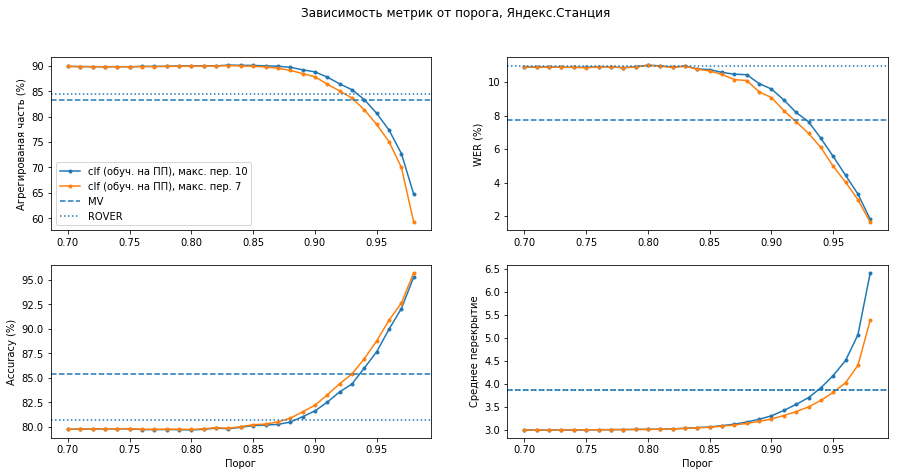

In [155]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15,7))
plt.suptitle('Зависимость метрик от порога, Яндекс.Станция')
plt.subplot(221)
plt.plot(scores_gs_quasar_max_cost_10[:, 0], 
         scores_gs_quasar_max_cost_10[:, 1] * 100, ".-", label="clf (обуч. на ПП), макс. пер. 10")
plt.plot(scores_gs_quasar_max_cost_7[:, 0], 
         scores_gs_quasar_max_cost_7[:, 1] * 100, 
         ".-", 
         label="clf (обуч. на ПП), макс. пер. 7")
plt.axhline(y=prod_agg_metrics[0] * 100, linestyle='--', label="MV")
plt.axhline(y=rover_agg_metrics[0] * 100, linestyle=':', label="ROVER")
plt.legend()
plt.ylabel('Агрегированая часть (%)')

plt.subplot(222)
plt.plot(scores_gs_quasar_max_cost_10[:, 0], scores_gs_quasar_max_cost_10[:, 2] * 100, ".-")
plt.plot(scores_gs_quasar_max_cost_7[:, 0], 
         scores_gs_quasar_max_cost_7[:, 2] * 100, ".-")
plt.axhline(y=prod_agg_metrics[1] * 100, linestyle='--')
plt.axhline(y=rover_agg_metrics[1] * 100, linestyle=':', label="ROVER")
plt.ylabel('WER (%)')


plt.subplot(223)
plt.plot(scores_gs_quasar_max_cost_10[:, 0], scores_gs_quasar_max_cost_10[:, 3] * 100, ".-")
plt.plot(scores_gs_quasar_max_cost_7[:, 0], 
         scores_gs_quasar_max_cost_7[:, 3] * 100, ".-")
plt.axhline(y=prod_agg_metrics[2] * 100, linestyle='--')
plt.axhline(y=rover_agg_metrics[2] * 100, linestyle=':', label="ROVER")
plt.ylabel('Accuracy (%)')

plt.xlabel('Порог')

plt.subplot(224)
plt.plot(scores_gs_quasar_max_cost_10[:, 0], scores_gs_quasar_max_cost_10[:, 4], ".-")
plt.plot(scores_gs_quasar_max_cost_7[:, 0], scores_gs_quasar_max_cost_7[:, 4], ".-")
plt.axhline(y=prod_agg_metrics[3], linestyle='--')
plt.axhline(y=rover_agg_metrics[3], linestyle=':', label="ROVER")
plt.ylabel('Среднее перекрытие')

plt.xlabel('Порог')

plt.savefig("metrics_another_dataset_quasar_true.png")
plt.show()

In [165]:
print('toloka_assignments_repeat_1')
print('Prod: ')
prod_agg_metrics1 = evaluate_metrics(test_rows_valid, 'toloka_assignments_repeat_1', aggregate_prod)
print('\nROVER:')
rover_agg_metrics1 = evaluate_metrics(test_rows_valid, 'toloka_assignments_repeat_1', aggregate_rover)
print('\n\ntoloka_assignments_repeat_10')
print('\nProd: ')
prod_agg_metrics10 = evaluate_metrics(test_rows_valid, 'toloka_assignments_repeat_10', aggregate_prod) 
print('\nROVER:')
rover_agg_metrics10 = evaluate_metrics(test_rows_valid, 'toloka_assignments_repeat_10', aggregate_rover)

prod_agg_metrics = []
rover_agg_metrics = []
for i in range(len(prod_agg_metrics1)):
    prod_agg_metrics.append((prod_agg_metrics1[i] + prod_agg_metrics10[i]) / 2)
    rover_agg_metrics.append((rover_agg_metrics1[i] + rover_agg_metrics10[i]) / 2)

toloka_assignments_repeat_1
Prod: 
Aggregated: 68.3878%
WER: 6.5456%
Accuracy: 80.9144%
Mean overlap: 3.91

ROVER:
Aggregated: 69.5353%
WER: 9.0810%
Accuracy: 76.5264%
Mean overlap: 3.91


toloka_assignments_repeat_10

Prod: 
Aggregated: 67.2117%
WER: 6.0881%
Accuracy: 82.1169%
Mean overlap: 3.923

ROVER:
Aggregated: 69.3919%
WER: 9.0080%
Accuracy: 75.8578%
Mean overlap: 3.923


In [ ]:
scores_clf_test_max_cost_7_min_cost_2 = []

for treshhold in np.linspace(0.7, 0.98, 29):
    print(treshhold)
    metrics = evaluate_metrics_clf_(test_rows_valid, 
                                    test_features_10, 
                                    'toloka_assignments_repeat_1+10', 
                                    gs, 
                                    treshhold,
                                    min_cost=2,
                                    max_cost=7)
    scores_clf_test_max_cost_7_min_cost_2.append((treshhold, *metrics))
scores_clf_test_max_cost_7_min_cost_2 = np.array(scores_clf_test_max_cost_7_min_cost_2)

0.7
Aggregated: 76.3052%
WER: 14.8682%
Accuracy: 64.5865%
Mean overlap: 2.0
0.71
Aggregated: 76.3052%
WER: 14.8682%
Accuracy: 64.5865%
Mean overlap: 2.0
0.72


In [ ]:
scores_clf_test_max_cost_10_min_cost_2 = []

for treshhold in np.linspace(0.7, 0.98, 29):
    print(treshhold)
    metrics = evaluate_metrics_clf_(test_rows_valid, 
                                    test_features_10, 
                                    'toloka_assignments_repeat_1+10', 
                                    gs, 
                                    treshhold,
                                    min_cost=2,
                                    max_cost=10)
    scores_clf_test_max_cost_10_min_cost_2.append((treshhold, *metrics))
scores_clf_test_max_cost_10_min_cost_2 = np.array(scores_clf_test_max_cost_10_min_cost_2)

NameError: name 'scores_clf_test_max_cost_7_min_cost_2' is not defined

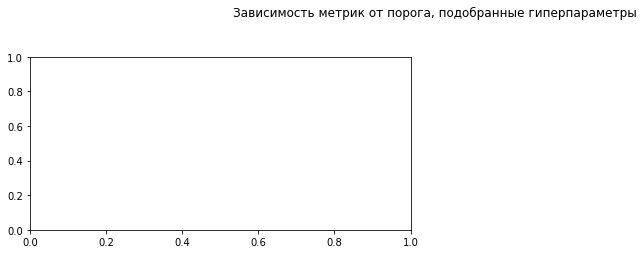

In [83]:
plt.figure(figsize=(15,7))
plt.suptitle('Зависимость метрик от порога, подобранные гиперпараметры')
plt.subplot(221)
plt.plot(scores_clf_test_max_cost_7_min_cost_2[:, 0], 
         scores_clf_test_max_cost_7_min_cost_2[:, 1] * 100, 
         ".-", 
         label="clf, макс. пер. 7")
plt.plot(scores_clf_test_max_cost_10_min_cost_2[:, 0], 
         scores_clf_test_max_cost_10_min_cost_2[:, 1] * 100, 
         ".-", 
         label="clf, макс. пер. 10")
plt.axhline(y=prod_agg_metrics[0] * 100, color=u'#1f77b4', linestyle='--', label="MV, 1+10")
plt.axhline(y=rover_agg_metrics[0] * 100, color=u'#ff7f0e', linestyle=':', label="ROVER, 1+10")
plt.legend()
plt.ylabel('Агрегированая часть (%)')

plt.subplot(222)
plt.plot(scores_clf_test_max_cost_7_min_cost_2[:, 0], 
         scores_clf_test_max_cost_7_min_cost_2[:, 2] * 100, 
         ".-")
plt.plot(scores_clf_test_max_cost_10_min_cost_2[:, 0], 
         scores_clf_test_max_cost_10_min_cost_2[:, 2] * 100, 
         ".-")
plt.axhline(y=prod_agg_metrics[1] * 100, color=u'#1f77b4', linestyle='--')
plt.axhline(y=rover_agg_metrics[1] * 100, color=u'#ff7f0e', linestyle=':')

plt.ylabel('WER (%)')


plt.subplot(223)
plt.plot(scores_clf_test_max_cost_7_min_cost_2[:, 0], 
         scores_clf_test_max_cost_7_min_cost_2[:, 3] * 100, 
         ".-")
plt.plot(scores_clf_test_max_cost_10_min_cost_2[:, 0], 
         scores_clf_test_max_cost_10_min_cost_2[:, 3] * 100, 
         ".-")
plt.axhline(y=prod_agg_metrics[2] * 100, color=u'#1f77b4', linestyle='--')
plt.axhline(y=rover_agg_metrics[2] * 100, color=u'#ff7f0e', linestyle=':')
plt.ylabel('Accuracy (%)')

plt.xlabel('Порог')

plt.subplot(224)
plt.plot(scores_clf_test_max_cost_7_min_cost_2[:, 0], 
         scores_clf_test_max_cost_7_min_cost_2[:, 4], 
         ".-")
plt.plot(scores_clf_test_max_cost_10_min_cost_2[:, 0], 
         scores_clf_test_max_cost_10_min_cost_2[:, 4], 
         ".-")
plt.axhline(y=prod_agg_metrics[3], color=u'#1f77b4', linestyle='--')
plt.axhline(y=rover_agg_metrics[3], color=u'#ff7f0e', linestyle=':')
plt.ylabel('Среднее перекрытие')

plt.xlabel('Порог')

plt.savefig("metrics_min_overlap_2_true_gs.png")
plt.show()

In [87]:
data_quasar_train = yt.read_table("//home/voice/vklyukin/va-893/quasar/train")
data_quasar_test = yt.read_table("//home/voice/vklyukin/va-893/quasar/test")
data_quasar_new = list(data_quasar_train)
data_quasar_new += list(data_quasar_test)
for row in data_quasar_new:
    if 'text' in row:
        del row['text']

In [ ]:
data_quasar_new_features = extract_features(data_quasar_new, 'toloka_results')

In [105]:
data_quasar_train = yt.read_table("//home/voice/vklyukin/va-893/quasar/train")
data_quasar_test = yt.read_table("//home/voice/vklyukin/va-893/quasar/test")
data_quasar_valid = list(data_quasar_train) + list(data_quasar_test)

In [106]:
len(data_quasar_valid)

7280

In [109]:
print('toloka_results')
print('Prod: ')
prod_agg_metrics = evaluate_metrics(data_quasar_valid, 'toloka_results', aggregate_prod)
print('\nROVER:')
rover_agg_metrics = evaluate_metrics(data_quasar_valid, 'toloka_results', aggregate_rover)

toloka_results
Prod: 
Aggregated: 86.5242%
WER: 6.5530%
Accuracy: 86.6730%
Mean overlap: 3.722

ROVER:
Aggregated: 86.2503%
WER: 7.7688%
Accuracy: 85.0746%
Mean overlap: 3.722


In [ ]:
scores_clf_quasar_new_max_cost_7 = []

for treshhold in np.linspace(0.7, 0.98, 29):
    print(treshhold)
    metrics = evaluate_metrics_clf_(data_quasar_valid, 
                                    data_quasar_new_features, 
                                    'toloka_results', 
                                    gs, 
                                    treshhold,
                                    max_cost=7)
    scores_clf_quasar_new_max_cost_7.append((treshhold, *metrics))
scores_clf_quasar_new_max_cost_7 = np.array(scores_clf_quasar_new_max_cost_7)

0.7
Aggregated: 91.2901%
WER: 10.4710%
Accuracy: 80.5581%
Mean overlap: 3.001
0.71
Aggregated: 91.2353%
WER: 10.4317%
Accuracy: 80.6364%
Mean overlap: 3.002
0.72
Aggregated: 91.2627%
WER: 10.4140%
Accuracy: 80.6423%
Mean overlap: 3.005
0.73
Aggregated: 91.2353%
WER: 10.4229%
Accuracy: 80.6364%
Mean overlap: 3.006
0.74
Aggregated: 91.2353%
WER: 10.4229%
Accuracy: 80.6364%
Mean overlap: 3.006
0.75
Aggregated: 91.2627%
WER: 10.4469%
Accuracy: 80.6423%
Mean overlap: 3.008
0.76
Aggregated: 91.2079%
WER: 10.3518%
Accuracy: 80.7207%
Mean overlap: 3.015
0.77
Aggregated: 91.1805%
WER: 10.3603%
Accuracy: 80.7149%
Mean overlap: 3.021
0.7799999999999999
Aggregated: 91.1531%
WER: 10.3177%
Accuracy: 80.7692%
Mean overlap: 3.029
0.7899999999999999


In [ ]:
scores_clf_quasar_new_max_cost_10 = []

for treshhold in np.linspace(0.7, 0.98, 29):
    print(treshhold)
    metrics = evaluate_metrics_clf_(data_quasar_valid, 
                                    data_quasar_new_features, 
                                    'toloka_results', 
                                    gs, 
                                    treshhold,
                                    max_cost=10)
    scores_clf_quasar_new_max_cost_10.append((treshhold, *metrics))
scores_clf_quasar_new_max_cost_10 = np.array(scores_clf_quasar_new_max_cost_10)

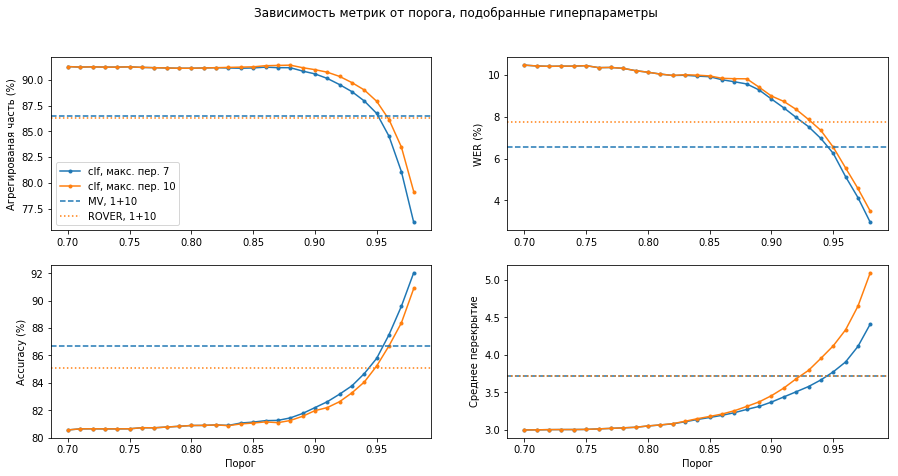

In [113]:
plt.figure(figsize=(15,7))
plt.suptitle('Зависимость метрик от порога, подобранные гиперпараметры')
plt.subplot(221)
plt.plot(scores_clf_quasar_new_max_cost_7[:, 0], 
         scores_clf_quasar_new_max_cost_7[:, 1] * 100, 
         ".-", 
         label="clf, макс. пер. 7")
plt.plot(scores_clf_quasar_new_max_cost_10[:, 0], 
         scores_clf_quasar_new_max_cost_10[:, 1] * 100, 
         ".-", 
         label="clf, макс. пер. 10")
plt.axhline(y=prod_agg_metrics[0] * 100, color=u'#1f77b4', linestyle='--', label="MV, 1+10")
plt.axhline(y=rover_agg_metrics[0] * 100, color=u'#ff7f0e', linestyle=':', label="ROVER, 1+10")
plt.legend()
plt.ylabel('Агрегированая часть (%)')

plt.subplot(222)
plt.plot(scores_clf_quasar_new_max_cost_7[:, 0], 
         scores_clf_quasar_new_max_cost_7[:, 2] * 100, 
         ".-")
plt.plot(scores_clf_quasar_new_max_cost_10[:, 0], 
         scores_clf_quasar_new_max_cost_10[:, 2] * 100, 
         ".-")
plt.axhline(y=prod_agg_metrics[1] * 100, color=u'#1f77b4', linestyle='--')
plt.axhline(y=rover_agg_metrics[1] * 100, color=u'#ff7f0e', linestyle=':')

plt.ylabel('WER (%)')


plt.subplot(223)
plt.plot(scores_clf_quasar_new_max_cost_7[:, 0], 
         scores_clf_quasar_new_max_cost_7[:, 3] * 100, 
         ".-")
plt.plot(scores_clf_quasar_new_max_cost_10[:, 0], 
         scores_clf_quasar_new_max_cost_10[:, 3] * 100, 
         ".-")
plt.axhline(y=prod_agg_metrics[2] * 100, color=u'#1f77b4', linestyle='--')
plt.axhline(y=rover_agg_metrics[2] * 100, color=u'#ff7f0e', linestyle=':')
plt.ylabel('Accuracy (%)')

plt.xlabel('Порог')

plt.subplot(224)
plt.plot(scores_clf_quasar_new_max_cost_7[:, 0], 
         scores_clf_quasar_new_max_cost_7[:, 4], 
         ".-")
plt.plot(scores_clf_quasar_new_max_cost_10[:, 0], 
         scores_clf_quasar_new_max_cost_10[:, 4], 
         ".-")
plt.axhline(y=prod_agg_metrics[3], color=u'#1f77b4', linestyle='--')
plt.axhline(y=rover_agg_metrics[3], color=u'#ff7f0e', linestyle=':')
plt.ylabel('Среднее перекрытие')

plt.xlabel('Порог')

plt.savefig("metrics_new_quasar_true.png")
plt.show()

In [114]:
data_quasar_train = yt.read_table("//home/voice/vklyukin/va-893/quasar/train")
data_quasar_test = yt.read_table("//home/voice/vklyukin/va-893/quasar/test")
data_quasar_train = list(data_quasar_train)
data_quasar_test = list(data_quasar_test)
for row in data_quasar_test:
    if 'text' in row:
        del row['text']

In [ ]:
data_quasar_new_test_features = extract_features(data_quasar_test, 'toloka_results')

In [116]:
data_quasar_new_train_features = extract_features(data_quasar_train, 'toloka_results')

In [117]:
data_quasar_test_valid = yt.read_table("//home/voice/vklyukin/va-893/quasar/test")
data_quasar_test_valid = list(data_quasar_test_valid)

In [118]:
print('toloka_results')
print('Prod: ')
prod_agg_metrics = evaluate_metrics(data_quasar_test_valid, 'toloka_results', aggregate_prod)
print('\nROVER:')
rover_agg_metrics = evaluate_metrics(data_quasar_test_valid, 'toloka_results', aggregate_rover)

toloka_results
Prod: 
Aggregated: 86.5242%
WER: 6.5530%
Accuracy: 86.6730%
Mean overlap: 3.722

ROVER:
Aggregated: 86.2503%
WER: 7.7688%
Accuracy: 85.0746%
Mean overlap: 3.722


In [ ]:
X_train, Y_train = convert_to_array(data_quasar_new_train_features)

In [ ]:
clf_new = CatBoostClassifier(iterations=19000, depth=6, thread_count=26, random_seed=42)
clf_new.fit(X_train, Y_train)

Learning rate set to 0.006482
0:	learn: 0.6833511	total: 90ms	remaining: 28m 30s
1:	learn: 0.6730006	total: 163ms	remaining: 25m 44s
2:	learn: 0.6630073	total: 239ms	remaining: 25m 11s
3:	learn: 0.6535182	total: 313ms	remaining: 24m 44s
4:	learn: 0.6439934	total: 382ms	remaining: 24m 12s
5:	learn: 0.6347519	total: 453ms	remaining: 23m 54s
6:	learn: 0.6259203	total: 523ms	remaining: 23m 38s
7:	learn: 0.6169328	total: 596ms	remaining: 23m 34s
8:	learn: 0.6084587	total: 670ms	remaining: 23m 34s
9:	learn: 0.5999101	total: 742ms	remaining: 23m 28s
10:	learn: 0.5914746	total: 812ms	remaining: 23m 21s
11:	learn: 0.5832828	total: 886ms	remaining: 23m 22s
12:	learn: 0.5753410	total: 954ms	remaining: 23m 12s
13:	learn: 0.5675021	total: 1.03s	remaining: 23m 11s
14:	learn: 0.5596971	total: 1.1s	remaining: 23m 15s
15:	learn: 0.5522203	total: 1.17s	remaining: 23m 11s
16:	learn: 0.5444463	total: 1.24s	remaining: 23m 9s
17:	learn: 0.5369933	total: 1.31s	remaining: 23m 5s
18:	learn: 0.5298571	total: 1.

155:	learn: 0.1942755	total: 11.3s	remaining: 22m 43s
156:	learn: 0.1937634	total: 11.4s	remaining: 22m 43s
157:	learn: 0.1932384	total: 11.4s	remaining: 22m 42s
158:	learn: 0.1926939	total: 11.5s	remaining: 22m 42s
159:	learn: 0.1921555	total: 11.6s	remaining: 22m 42s
160:	learn: 0.1916066	total: 11.6s	remaining: 22m 42s
161:	learn: 0.1910764	total: 11.7s	remaining: 22m 41s
162:	learn: 0.1905539	total: 11.8s	remaining: 22m 41s
163:	learn: 0.1900783	total: 11.9s	remaining: 22m 41s
164:	learn: 0.1895859	total: 11.9s	remaining: 22m 41s
165:	learn: 0.1891311	total: 12s	remaining: 22m 42s
166:	learn: 0.1886380	total: 12.1s	remaining: 22m 42s
167:	learn: 0.1881243	total: 12.2s	remaining: 22m 42s
168:	learn: 0.1876346	total: 12.2s	remaining: 22m 42s
169:	learn: 0.1872058	total: 12.3s	remaining: 22m 42s
170:	learn: 0.1867930	total: 12.4s	remaining: 22m 42s
171:	learn: 0.1863813	total: 12.4s	remaining: 22m 42s
172:	learn: 0.1859680	total: 12.5s	remaining: 22m 42s
173:	learn: 0.1855458	total: 1

309:	learn: 0.1594555	total: 22.1s	remaining: 22m 10s
310:	learn: 0.1593723	total: 22.2s	remaining: 22m 12s
311:	learn: 0.1592956	total: 22.3s	remaining: 22m 13s
312:	learn: 0.1592287	total: 22.3s	remaining: 22m 13s
313:	learn: 0.1591591	total: 22.4s	remaining: 22m 13s
314:	learn: 0.1590864	total: 22.5s	remaining: 22m 12s
315:	learn: 0.1590188	total: 22.5s	remaining: 22m 12s
316:	learn: 0.1589464	total: 22.6s	remaining: 22m 12s
317:	learn: 0.1588922	total: 22.7s	remaining: 22m 12s
318:	learn: 0.1588078	total: 22.8s	remaining: 22m 12s
319:	learn: 0.1587370	total: 22.8s	remaining: 22m 12s
320:	learn: 0.1586547	total: 22.9s	remaining: 22m 12s
321:	learn: 0.1585960	total: 23s	remaining: 22m 11s
322:	learn: 0.1585286	total: 23s	remaining: 22m 11s
323:	learn: 0.1584551	total: 23.1s	remaining: 22m 11s
324:	learn: 0.1583977	total: 23.2s	remaining: 22m 11s
325:	learn: 0.1583256	total: 23.3s	remaining: 22m 11s
326:	learn: 0.1582624	total: 23.3s	remaining: 22m 11s
327:	learn: 0.1581898	total: 23.

465:	learn: 0.1521044	total: 33.1s	remaining: 21m 56s
466:	learn: 0.1520811	total: 33.2s	remaining: 21m 56s
467:	learn: 0.1520427	total: 33.3s	remaining: 21m 56s
468:	learn: 0.1520158	total: 33.3s	remaining: 21m 56s
469:	learn: 0.1519905	total: 33.4s	remaining: 21m 56s
470:	learn: 0.1519498	total: 33.5s	remaining: 21m 56s
471:	learn: 0.1519215	total: 33.5s	remaining: 21m 56s
472:	learn: 0.1518773	total: 33.6s	remaining: 21m 56s
473:	learn: 0.1518471	total: 33.7s	remaining: 21m 56s
474:	learn: 0.1518144	total: 33.8s	remaining: 21m 56s
475:	learn: 0.1517936	total: 33.8s	remaining: 21m 56s
476:	learn: 0.1517700	total: 33.9s	remaining: 21m 56s
477:	learn: 0.1517492	total: 34s	remaining: 21m 56s
478:	learn: 0.1517266	total: 34s	remaining: 21m 56s
479:	learn: 0.1516990	total: 34.1s	remaining: 21m 56s
480:	learn: 0.1516733	total: 34.2s	remaining: 21m 57s
481:	learn: 0.1516458	total: 34.3s	remaining: 21m 57s
482:	learn: 0.1516030	total: 34.4s	remaining: 21m 57s
483:	learn: 0.1515831	total: 34.

619:	learn: 0.1488980	total: 43.9s	remaining: 21m 42s
620:	learn: 0.1488873	total: 44s	remaining: 21m 42s
621:	learn: 0.1488750	total: 44.1s	remaining: 21m 42s
622:	learn: 0.1488575	total: 44.1s	remaining: 21m 42s
623:	learn: 0.1488422	total: 44.2s	remaining: 21m 42s
624:	learn: 0.1488301	total: 44.3s	remaining: 21m 42s
625:	learn: 0.1488208	total: 44.4s	remaining: 21m 41s
626:	learn: 0.1488103	total: 44.4s	remaining: 21m 41s
627:	learn: 0.1487984	total: 44.5s	remaining: 21m 41s
628:	learn: 0.1487880	total: 44.6s	remaining: 21m 41s
629:	learn: 0.1487806	total: 44.6s	remaining: 21m 41s
630:	learn: 0.1487721	total: 44.7s	remaining: 21m 41s
631:	learn: 0.1487637	total: 44.8s	remaining: 21m 40s
632:	learn: 0.1487532	total: 44.8s	remaining: 21m 40s
633:	learn: 0.1487381	total: 44.9s	remaining: 21m 40s
634:	learn: 0.1487292	total: 45s	remaining: 21m 40s
635:	learn: 0.1487149	total: 45s	remaining: 21m 40s
636:	learn: 0.1487025	total: 45.1s	remaining: 21m 40s
637:	learn: 0.1486889	total: 45.2s

772:	learn: 0.1470863	total: 54.6s	remaining: 21m 27s
773:	learn: 0.1470776	total: 54.7s	remaining: 21m 27s
774:	learn: 0.1470683	total: 54.8s	remaining: 21m 27s
775:	learn: 0.1470455	total: 54.8s	remaining: 21m 27s
776:	learn: 0.1470305	total: 54.9s	remaining: 21m 27s
777:	learn: 0.1470167	total: 55s	remaining: 21m 27s
778:	learn: 0.1469979	total: 55s	remaining: 21m 27s
779:	learn: 0.1469911	total: 55.1s	remaining: 21m 27s
780:	learn: 0.1469771	total: 55.2s	remaining: 21m 27s
781:	learn: 0.1469655	total: 55.3s	remaining: 21m 27s
782:	learn: 0.1469481	total: 55.3s	remaining: 21m 27s
783:	learn: 0.1469400	total: 55.4s	remaining: 21m 27s
784:	learn: 0.1469342	total: 55.5s	remaining: 21m 27s
785:	learn: 0.1469289	total: 55.5s	remaining: 21m 26s
786:	learn: 0.1469060	total: 55.6s	remaining: 21m 26s
787:	learn: 0.1468828	total: 55.7s	remaining: 21m 26s
788:	learn: 0.1468743	total: 55.7s	remaining: 21m 26s
789:	learn: 0.1468668	total: 55.8s	remaining: 21m 26s
790:	learn: 0.1468600	total: 55.

927:	learn: 0.1455613	total: 1m 5s	remaining: 21m 18s
928:	learn: 0.1455503	total: 1m 5s	remaining: 21m 18s
929:	learn: 0.1455441	total: 1m 5s	remaining: 21m 18s
930:	learn: 0.1455399	total: 1m 5s	remaining: 21m 17s
931:	learn: 0.1455319	total: 1m 5s	remaining: 21m 17s
932:	learn: 0.1455185	total: 1m 5s	remaining: 21m 17s
933:	learn: 0.1455131	total: 1m 6s	remaining: 21m 17s
934:	learn: 0.1455065	total: 1m 6s	remaining: 21m 17s
935:	learn: 0.1454927	total: 1m 6s	remaining: 21m 17s
936:	learn: 0.1454759	total: 1m 6s	remaining: 21m 17s
937:	learn: 0.1454719	total: 1m 6s	remaining: 21m 17s
938:	learn: 0.1454659	total: 1m 6s	remaining: 21m 17s
939:	learn: 0.1454591	total: 1m 6s	remaining: 21m 17s
940:	learn: 0.1454499	total: 1m 6s	remaining: 21m 17s
941:	learn: 0.1454408	total: 1m 6s	remaining: 21m 17s
942:	learn: 0.1454354	total: 1m 6s	remaining: 21m 17s
943:	learn: 0.1454300	total: 1m 6s	remaining: 21m 17s
944:	learn: 0.1454216	total: 1m 6s	remaining: 21m 17s
945:	learn: 0.1454167	total:

1078:	learn: 0.1443973	total: 1m 16s	remaining: 21m 7s
1079:	learn: 0.1443912	total: 1m 16s	remaining: 21m 6s
1080:	learn: 0.1443817	total: 1m 16s	remaining: 21m 6s
1081:	learn: 0.1443702	total: 1m 16s	remaining: 21m 6s
1082:	learn: 0.1443655	total: 1m 16s	remaining: 21m 6s
1083:	learn: 0.1443611	total: 1m 16s	remaining: 21m 6s
1084:	learn: 0.1443433	total: 1m 16s	remaining: 21m 6s
1085:	learn: 0.1443366	total: 1m 16s	remaining: 21m 6s
1086:	learn: 0.1443280	total: 1m 16s	remaining: 21m 6s
1087:	learn: 0.1443160	total: 1m 16s	remaining: 21m 6s
1088:	learn: 0.1443092	total: 1m 16s	remaining: 21m 6s
1089:	learn: 0.1443045	total: 1m 17s	remaining: 21m 6s
1090:	learn: 0.1442961	total: 1m 17s	remaining: 21m 6s
1091:	learn: 0.1442920	total: 1m 17s	remaining: 21m 5s
1092:	learn: 0.1442866	total: 1m 17s	remaining: 21m 5s
1093:	learn: 0.1442806	total: 1m 17s	remaining: 21m 5s
1094:	learn: 0.1442732	total: 1m 17s	remaining: 21m 5s
1095:	learn: 0.1442667	total: 1m 17s	remaining: 21m 5s
1096:	lear

1228:	learn: 0.1434038	total: 1m 26s	remaining: 20m 55s
1229:	learn: 0.1433999	total: 1m 26s	remaining: 20m 55s
1230:	learn: 0.1433974	total: 1m 27s	remaining: 20m 55s
1231:	learn: 0.1433849	total: 1m 27s	remaining: 20m 55s
1232:	learn: 0.1433819	total: 1m 27s	remaining: 20m 55s
1233:	learn: 0.1433764	total: 1m 27s	remaining: 20m 55s
1234:	learn: 0.1433722	total: 1m 27s	remaining: 20m 55s
1235:	learn: 0.1433689	total: 1m 27s	remaining: 20m 55s
1236:	learn: 0.1433611	total: 1m 27s	remaining: 20m 55s
1237:	learn: 0.1433468	total: 1m 27s	remaining: 20m 55s
1238:	learn: 0.1433396	total: 1m 27s	remaining: 20m 55s
1239:	learn: 0.1433324	total: 1m 27s	remaining: 20m 55s
1240:	learn: 0.1433217	total: 1m 27s	remaining: 20m 55s
1241:	learn: 0.1433179	total: 1m 27s	remaining: 20m 55s
1242:	learn: 0.1433094	total: 1m 27s	remaining: 20m 55s
1243:	learn: 0.1432956	total: 1m 27s	remaining: 20m 55s
1244:	learn: 0.1432923	total: 1m 28s	remaining: 20m 55s
1245:	learn: 0.1432859	total: 1m 28s	remaining: 

1375:	learn: 0.1425841	total: 1m 37s	remaining: 20m 43s
1376:	learn: 0.1425779	total: 1m 37s	remaining: 20m 43s
1377:	learn: 0.1425742	total: 1m 37s	remaining: 20m 43s
1378:	learn: 0.1425687	total: 1m 37s	remaining: 20m 43s
1379:	learn: 0.1425609	total: 1m 37s	remaining: 20m 43s
1380:	learn: 0.1425576	total: 1m 37s	remaining: 20m 43s
1381:	learn: 0.1425471	total: 1m 37s	remaining: 20m 43s
1382:	learn: 0.1425419	total: 1m 37s	remaining: 20m 43s
1383:	learn: 0.1425364	total: 1m 37s	remaining: 20m 43s
1384:	learn: 0.1425349	total: 1m 37s	remaining: 20m 42s
1385:	learn: 0.1425300	total: 1m 37s	remaining: 20m 42s
1386:	learn: 0.1425180	total: 1m 37s	remaining: 20m 42s
1387:	learn: 0.1425109	total: 1m 37s	remaining: 20m 42s
1388:	learn: 0.1425083	total: 1m 38s	remaining: 20m 42s
1389:	learn: 0.1425046	total: 1m 38s	remaining: 20m 42s
1390:	learn: 0.1424979	total: 1m 38s	remaining: 20m 42s
1391:	learn: 0.1424929	total: 1m 38s	remaining: 20m 42s
1392:	learn: 0.1424886	total: 1m 38s	remaining: 

1523:	learn: 0.1417988	total: 1m 47s	remaining: 20m 32s
1524:	learn: 0.1417957	total: 1m 47s	remaining: 20m 31s
1525:	learn: 0.1417903	total: 1m 47s	remaining: 20m 31s
1526:	learn: 0.1417845	total: 1m 47s	remaining: 20m 31s
1527:	learn: 0.1417793	total: 1m 47s	remaining: 20m 31s
1528:	learn: 0.1417764	total: 1m 47s	remaining: 20m 31s
1529:	learn: 0.1417714	total: 1m 47s	remaining: 20m 31s
1530:	learn: 0.1417633	total: 1m 47s	remaining: 20m 31s
1531:	learn: 0.1417544	total: 1m 47s	remaining: 20m 31s
1532:	learn: 0.1417494	total: 1m 48s	remaining: 20m 31s
1533:	learn: 0.1417419	total: 1m 48s	remaining: 20m 31s
1534:	learn: 0.1417365	total: 1m 48s	remaining: 20m 31s
1535:	learn: 0.1417268	total: 1m 48s	remaining: 20m 31s
1536:	learn: 0.1417208	total: 1m 48s	remaining: 20m 31s
1537:	learn: 0.1417172	total: 1m 48s	remaining: 20m 30s
1538:	learn: 0.1417108	total: 1m 48s	remaining: 20m 30s
1539:	learn: 0.1417074	total: 1m 48s	remaining: 20m 30s
1540:	learn: 0.1417039	total: 1m 48s	remaining: 

1671:	learn: 0.1411051	total: 1m 57s	remaining: 20m 20s
1672:	learn: 0.1410997	total: 1m 57s	remaining: 20m 19s
1673:	learn: 0.1410959	total: 1m 57s	remaining: 20m 19s
1674:	learn: 0.1410940	total: 1m 57s	remaining: 20m 19s
1675:	learn: 0.1410875	total: 1m 57s	remaining: 20m 19s
1676:	learn: 0.1410837	total: 1m 58s	remaining: 20m 19s
1677:	learn: 0.1410824	total: 1m 58s	remaining: 20m 19s
1678:	learn: 0.1410764	total: 1m 58s	remaining: 20m 19s
1679:	learn: 0.1410726	total: 1m 58s	remaining: 20m 19s
1680:	learn: 0.1410668	total: 1m 58s	remaining: 20m 19s
1681:	learn: 0.1410642	total: 1m 58s	remaining: 20m 18s
1682:	learn: 0.1410542	total: 1m 58s	remaining: 20m 18s
1683:	learn: 0.1410515	total: 1m 58s	remaining: 20m 18s
1684:	learn: 0.1410467	total: 1m 58s	remaining: 20m 19s
1685:	learn: 0.1410433	total: 1m 58s	remaining: 20m 19s
1686:	learn: 0.1410394	total: 1m 58s	remaining: 20m 19s
1687:	learn: 0.1410346	total: 1m 58s	remaining: 20m 19s
1688:	learn: 0.1410305	total: 1m 59s	remaining: 

1822:	learn: 0.1404183	total: 2m 8s	remaining: 20m 10s
1823:	learn: 0.1404119	total: 2m 8s	remaining: 20m 9s
1824:	learn: 0.1404071	total: 2m 8s	remaining: 20m 9s
1825:	learn: 0.1404021	total: 2m 8s	remaining: 20m 9s
1826:	learn: 0.1403992	total: 2m 8s	remaining: 20m 9s
1827:	learn: 0.1403981	total: 2m 8s	remaining: 20m 9s
1828:	learn: 0.1403954	total: 2m 8s	remaining: 20m 9s
1829:	learn: 0.1403909	total: 2m 8s	remaining: 20m 9s
1830:	learn: 0.1403863	total: 2m 8s	remaining: 20m 9s
1831:	learn: 0.1403836	total: 2m 9s	remaining: 20m 9s
1832:	learn: 0.1403764	total: 2m 9s	remaining: 20m 9s
1833:	learn: 0.1403725	total: 2m 9s	remaining: 20m 8s
1834:	learn: 0.1403688	total: 2m 9s	remaining: 20m 8s
1835:	learn: 0.1403631	total: 2m 9s	remaining: 20m 8s
1836:	learn: 0.1403586	total: 2m 9s	remaining: 20m 8s
1837:	learn: 0.1403559	total: 2m 9s	remaining: 20m 8s
1838:	learn: 0.1403530	total: 2m 9s	remaining: 20m 8s
1839:	learn: 0.1403509	total: 2m 9s	remaining: 20m 8s
1840:	learn: 0.1403471	tota

1974:	learn: 0.1397439	total: 2m 18s	remaining: 19m 57s
1975:	learn: 0.1397385	total: 2m 18s	remaining: 19m 57s
1976:	learn: 0.1397353	total: 2m 19s	remaining: 19m 57s
1977:	learn: 0.1397290	total: 2m 19s	remaining: 19m 57s
1978:	learn: 0.1397234	total: 2m 19s	remaining: 19m 56s
1979:	learn: 0.1397166	total: 2m 19s	remaining: 19m 56s
1980:	learn: 0.1397098	total: 2m 19s	remaining: 19m 56s
1981:	learn: 0.1397046	total: 2m 19s	remaining: 19m 56s
1982:	learn: 0.1397019	total: 2m 19s	remaining: 19m 56s
1983:	learn: 0.1396954	total: 2m 19s	remaining: 19m 56s
1984:	learn: 0.1396920	total: 2m 19s	remaining: 19m 56s
1985:	learn: 0.1396872	total: 2m 19s	remaining: 19m 56s
1986:	learn: 0.1396824	total: 2m 19s	remaining: 19m 56s
1987:	learn: 0.1396799	total: 2m 19s	remaining: 19m 56s
1988:	learn: 0.1396742	total: 2m 19s	remaining: 19m 56s
1989:	learn: 0.1396638	total: 2m 19s	remaining: 19m 55s
1990:	learn: 0.1396591	total: 2m 19s	remaining: 19m 55s
1991:	learn: 0.1396520	total: 2m 20s	remaining: 

2123:	learn: 0.1390834	total: 2m 28s	remaining: 19m 42s
2124:	learn: 0.1390798	total: 2m 28s	remaining: 19m 42s
2125:	learn: 0.1390755	total: 2m 28s	remaining: 19m 42s
2126:	learn: 0.1390676	total: 2m 29s	remaining: 19m 42s
2127:	learn: 0.1390630	total: 2m 29s	remaining: 19m 42s
2128:	learn: 0.1390558	total: 2m 29s	remaining: 19m 42s
2129:	learn: 0.1390539	total: 2m 29s	remaining: 19m 42s
2130:	learn: 0.1390501	total: 2m 29s	remaining: 19m 41s
2131:	learn: 0.1390480	total: 2m 29s	remaining: 19m 41s
2132:	learn: 0.1390456	total: 2m 29s	remaining: 19m 41s
2133:	learn: 0.1390401	total: 2m 29s	remaining: 19m 41s
2134:	learn: 0.1390352	total: 2m 29s	remaining: 19m 41s
2135:	learn: 0.1390288	total: 2m 29s	remaining: 19m 41s
2136:	learn: 0.1390254	total: 2m 29s	remaining: 19m 41s
2137:	learn: 0.1390208	total: 2m 29s	remaining: 19m 41s
2138:	learn: 0.1390180	total: 2m 29s	remaining: 19m 41s
2139:	learn: 0.1390139	total: 2m 29s	remaining: 19m 41s
2140:	learn: 0.1390112	total: 2m 29s	remaining: 

2272:	learn: 0.1384271	total: 2m 38s	remaining: 19m 29s
2273:	learn: 0.1384211	total: 2m 38s	remaining: 19m 29s
2274:	learn: 0.1384166	total: 2m 39s	remaining: 19m 29s
2275:	learn: 0.1384092	total: 2m 39s	remaining: 19m 29s
2276:	learn: 0.1384044	total: 2m 39s	remaining: 19m 29s
2277:	learn: 0.1384002	total: 2m 39s	remaining: 19m 29s
2278:	learn: 0.1383930	total: 2m 39s	remaining: 19m 29s
2279:	learn: 0.1383893	total: 2m 39s	remaining: 19m 29s
2280:	learn: 0.1383871	total: 2m 39s	remaining: 19m 28s
2281:	learn: 0.1383807	total: 2m 39s	remaining: 19m 28s
2282:	learn: 0.1383779	total: 2m 39s	remaining: 19m 28s
2283:	learn: 0.1383731	total: 2m 39s	remaining: 19m 28s
2284:	learn: 0.1383693	total: 2m 39s	remaining: 19m 28s
2285:	learn: 0.1383663	total: 2m 39s	remaining: 19m 28s
2286:	learn: 0.1383607	total: 2m 39s	remaining: 19m 28s
2287:	learn: 0.1383568	total: 2m 39s	remaining: 19m 28s
2288:	learn: 0.1383523	total: 2m 40s	remaining: 19m 28s
2289:	learn: 0.1383488	total: 2m 40s	remaining: 

2422:	learn: 0.1378049	total: 2m 49s	remaining: 19m 16s
2423:	learn: 0.1378006	total: 2m 49s	remaining: 19m 16s
2424:	learn: 0.1377975	total: 2m 49s	remaining: 19m 16s
2425:	learn: 0.1377931	total: 2m 49s	remaining: 19m 16s
2426:	learn: 0.1377900	total: 2m 49s	remaining: 19m 16s
2427:	learn: 0.1377859	total: 2m 49s	remaining: 19m 16s
2428:	learn: 0.1377807	total: 2m 49s	remaining: 19m 15s
2429:	learn: 0.1377790	total: 2m 49s	remaining: 19m 15s
2430:	learn: 0.1377758	total: 2m 49s	remaining: 19m 15s
2431:	learn: 0.1377723	total: 2m 49s	remaining: 19m 15s
2432:	learn: 0.1377675	total: 2m 49s	remaining: 19m 15s
2433:	learn: 0.1377618	total: 2m 49s	remaining: 19m 15s
2434:	learn: 0.1377598	total: 2m 49s	remaining: 19m 15s
2435:	learn: 0.1377564	total: 2m 49s	remaining: 19m 15s
2436:	learn: 0.1377528	total: 2m 49s	remaining: 19m 15s
2437:	learn: 0.1377498	total: 2m 50s	remaining: 19m 15s
2438:	learn: 0.1377467	total: 2m 50s	remaining: 19m 14s
2439:	learn: 0.1377378	total: 2m 50s	remaining: 

2572:	learn: 0.1371823	total: 2m 59s	remaining: 19m 4s
2573:	learn: 0.1371791	total: 2m 59s	remaining: 19m 4s
2574:	learn: 0.1371745	total: 2m 59s	remaining: 19m 4s
2575:	learn: 0.1371704	total: 2m 59s	remaining: 19m 4s
2576:	learn: 0.1371651	total: 2m 59s	remaining: 19m 4s
2577:	learn: 0.1371620	total: 2m 59s	remaining: 19m 4s
2578:	learn: 0.1371582	total: 2m 59s	remaining: 19m 4s
2579:	learn: 0.1371565	total: 2m 59s	remaining: 19m 4s
2580:	learn: 0.1371527	total: 2m 59s	remaining: 19m 4s
2581:	learn: 0.1371437	total: 2m 59s	remaining: 19m 4s
2582:	learn: 0.1371401	total: 2m 59s	remaining: 19m 3s
2583:	learn: 0.1371370	total: 3m	remaining: 19m 3s
2584:	learn: 0.1371322	total: 3m	remaining: 19m 3s
2585:	learn: 0.1371268	total: 3m	remaining: 19m 3s
2586:	learn: 0.1371238	total: 3m	remaining: 19m 3s
2587:	learn: 0.1371190	total: 3m	remaining: 19m 3s
2588:	learn: 0.1371137	total: 3m	remaining: 19m 3s
2589:	learn: 0.1371104	total: 3m	remaining: 19m 3s
2590:	learn: 0.1371084	total: 3m	remai

2725:	learn: 0.1365842	total: 3m 9s	remaining: 18m 52s
2726:	learn: 0.1365820	total: 3m 9s	remaining: 18m 52s
2727:	learn: 0.1365794	total: 3m 9s	remaining: 18m 52s
2728:	learn: 0.1365744	total: 3m 9s	remaining: 18m 52s
2729:	learn: 0.1365685	total: 3m 10s	remaining: 18m 52s
2730:	learn: 0.1365609	total: 3m 10s	remaining: 18m 52s
2731:	learn: 0.1365549	total: 3m 10s	remaining: 18m 52s
2732:	learn: 0.1365524	total: 3m 10s	remaining: 18m 52s
2733:	learn: 0.1365478	total: 3m 10s	remaining: 18m 52s
2734:	learn: 0.1365424	total: 3m 10s	remaining: 18m 52s
2735:	learn: 0.1365401	total: 3m 10s	remaining: 18m 52s
2736:	learn: 0.1365379	total: 3m 10s	remaining: 18m 52s
2737:	learn: 0.1365350	total: 3m 10s	remaining: 18m 51s
2738:	learn: 0.1365335	total: 3m 10s	remaining: 18m 51s
2739:	learn: 0.1365301	total: 3m 10s	remaining: 18m 51s
2740:	learn: 0.1365240	total: 3m 10s	remaining: 18m 51s
2741:	learn: 0.1365219	total: 3m 10s	remaining: 18m 51s
2742:	learn: 0.1365165	total: 3m 10s	remaining: 18m 

2874:	learn: 0.1359983	total: 3m 19s	remaining: 18m 40s
2875:	learn: 0.1359942	total: 3m 19s	remaining: 18m 40s
2876:	learn: 0.1359901	total: 3m 19s	remaining: 18m 40s
2877:	learn: 0.1359869	total: 3m 20s	remaining: 18m 40s
2878:	learn: 0.1359828	total: 3m 20s	remaining: 18m 40s
2879:	learn: 0.1359734	total: 3m 20s	remaining: 18m 40s
2880:	learn: 0.1359699	total: 3m 20s	remaining: 18m 40s
2881:	learn: 0.1359657	total: 3m 20s	remaining: 18m 40s
2882:	learn: 0.1359636	total: 3m 20s	remaining: 18m 40s
2883:	learn: 0.1359565	total: 3m 20s	remaining: 18m 40s
2884:	learn: 0.1359514	total: 3m 20s	remaining: 18m 40s
2885:	learn: 0.1359466	total: 3m 20s	remaining: 18m 40s
2886:	learn: 0.1359446	total: 3m 20s	remaining: 18m 39s
2887:	learn: 0.1359395	total: 3m 20s	remaining: 18m 39s
2888:	learn: 0.1359363	total: 3m 20s	remaining: 18m 39s
2889:	learn: 0.1359326	total: 3m 20s	remaining: 18m 39s
2890:	learn: 0.1359312	total: 3m 20s	remaining: 18m 39s
2891:	learn: 0.1359270	total: 3m 20s	remaining: 

3024:	learn: 0.1354386	total: 3m 29s	remaining: 18m 28s
3025:	learn: 0.1354354	total: 3m 29s	remaining: 18m 28s
3026:	learn: 0.1354334	total: 3m 30s	remaining: 18m 28s
3027:	learn: 0.1354327	total: 3m 30s	remaining: 18m 28s
3028:	learn: 0.1354251	total: 3m 30s	remaining: 18m 27s
3029:	learn: 0.1354218	total: 3m 30s	remaining: 18m 27s
3030:	learn: 0.1354190	total: 3m 30s	remaining: 18m 27s
3031:	learn: 0.1354165	total: 3m 30s	remaining: 18m 27s
3032:	learn: 0.1354145	total: 3m 30s	remaining: 18m 27s
3033:	learn: 0.1354112	total: 3m 30s	remaining: 18m 27s
3034:	learn: 0.1354083	total: 3m 30s	remaining: 18m 27s
3035:	learn: 0.1354059	total: 3m 30s	remaining: 18m 27s
3036:	learn: 0.1354027	total: 3m 30s	remaining: 18m 27s
3037:	learn: 0.1354009	total: 3m 30s	remaining: 18m 27s
3038:	learn: 0.1353942	total: 3m 30s	remaining: 18m 27s
3039:	learn: 0.1353904	total: 3m 30s	remaining: 18m 26s
3040:	learn: 0.1353780	total: 3m 30s	remaining: 18m 26s
3041:	learn: 0.1353746	total: 3m 30s	remaining: 

3174:	learn: 0.1348989	total: 3m 40s	remaining: 18m 16s
3175:	learn: 0.1348974	total: 3m 40s	remaining: 18m 16s
3176:	learn: 0.1348941	total: 3m 40s	remaining: 18m 16s
3177:	learn: 0.1348904	total: 3m 40s	remaining: 18m 16s
3178:	learn: 0.1348878	total: 3m 40s	remaining: 18m 16s
3179:	learn: 0.1348828	total: 3m 40s	remaining: 18m 16s
3180:	learn: 0.1348794	total: 3m 40s	remaining: 18m 16s
3181:	learn: 0.1348778	total: 3m 40s	remaining: 18m 16s
3182:	learn: 0.1348762	total: 3m 40s	remaining: 18m 16s
3183:	learn: 0.1348748	total: 3m 40s	remaining: 18m 16s
3184:	learn: 0.1348700	total: 3m 40s	remaining: 18m 16s
3185:	learn: 0.1348652	total: 3m 40s	remaining: 18m 16s
3186:	learn: 0.1348606	total: 3m 40s	remaining: 18m 16s
3187:	learn: 0.1348581	total: 3m 40s	remaining: 18m 16s
3188:	learn: 0.1348567	total: 3m 41s	remaining: 18m 15s
3189:	learn: 0.1348532	total: 3m 41s	remaining: 18m 15s
3190:	learn: 0.1348504	total: 3m 41s	remaining: 18m 15s
3191:	learn: 0.1348463	total: 3m 41s	remaining: 

3323:	learn: 0.1343763	total: 3m 50s	remaining: 18m 6s
3324:	learn: 0.1343741	total: 3m 50s	remaining: 18m 6s
3325:	learn: 0.1343674	total: 3m 50s	remaining: 18m 6s
3326:	learn: 0.1343634	total: 3m 50s	remaining: 18m 6s
3327:	learn: 0.1343572	total: 3m 50s	remaining: 18m 6s
3328:	learn: 0.1343544	total: 3m 50s	remaining: 18m 5s
3329:	learn: 0.1343532	total: 3m 50s	remaining: 18m 5s
3330:	learn: 0.1343513	total: 3m 50s	remaining: 18m 5s
3331:	learn: 0.1343454	total: 3m 50s	remaining: 18m 5s
3332:	learn: 0.1343417	total: 3m 50s	remaining: 18m 5s
3333:	learn: 0.1343398	total: 3m 51s	remaining: 18m 5s
3334:	learn: 0.1343375	total: 3m 51s	remaining: 18m 5s
3335:	learn: 0.1343355	total: 3m 51s	remaining: 18m 5s
3336:	learn: 0.1343325	total: 3m 51s	remaining: 18m 5s
3337:	learn: 0.1343293	total: 3m 51s	remaining: 18m 5s
3338:	learn: 0.1343263	total: 3m 51s	remaining: 18m 5s
3339:	learn: 0.1343233	total: 3m 51s	remaining: 18m 5s
3340:	learn: 0.1343217	total: 3m 51s	remaining: 18m 5s
3341:	lear

3473:	learn: 0.1338816	total: 4m	remaining: 17m 55s
3474:	learn: 0.1338770	total: 4m	remaining: 17m 54s
3475:	learn: 0.1338728	total: 4m	remaining: 17m 54s
3476:	learn: 0.1338715	total: 4m	remaining: 17m 54s
3477:	learn: 0.1338648	total: 4m	remaining: 17m 54s
3478:	learn: 0.1338617	total: 4m	remaining: 17m 54s
3479:	learn: 0.1338589	total: 4m	remaining: 17m 54s
3480:	learn: 0.1338568	total: 4m 1s	remaining: 17m 54s
3481:	learn: 0.1338520	total: 4m 1s	remaining: 17m 54s
3482:	learn: 0.1338502	total: 4m 1s	remaining: 17m 54s
3483:	learn: 0.1338464	total: 4m 1s	remaining: 17m 54s
3484:	learn: 0.1338443	total: 4m 1s	remaining: 17m 54s
3485:	learn: 0.1338421	total: 4m 1s	remaining: 17m 54s
3486:	learn: 0.1338401	total: 4m 1s	remaining: 17m 54s
3487:	learn: 0.1338367	total: 4m 1s	remaining: 17m 53s
3488:	learn: 0.1338358	total: 4m 1s	remaining: 17m 53s
3489:	learn: 0.1338330	total: 4m 1s	remaining: 17m 53s
3490:	learn: 0.1338282	total: 4m 1s	remaining: 17m 53s
3491:	learn: 0.1338245	total: 4

3625:	learn: 0.1333613	total: 4m 10s	remaining: 17m 43s
3626:	learn: 0.1333579	total: 4m 10s	remaining: 17m 43s
3627:	learn: 0.1333488	total: 4m 10s	remaining: 17m 43s
3628:	learn: 0.1333458	total: 4m 11s	remaining: 17m 43s
3629:	learn: 0.1333372	total: 4m 11s	remaining: 17m 43s
3630:	learn: 0.1333358	total: 4m 11s	remaining: 17m 43s
3631:	learn: 0.1333342	total: 4m 11s	remaining: 17m 43s
3632:	learn: 0.1333297	total: 4m 11s	remaining: 17m 43s
3633:	learn: 0.1333213	total: 4m 11s	remaining: 17m 43s
3634:	learn: 0.1333172	total: 4m 11s	remaining: 17m 43s
3635:	learn: 0.1333137	total: 4m 11s	remaining: 17m 42s
3636:	learn: 0.1333120	total: 4m 11s	remaining: 17m 42s
3637:	learn: 0.1333104	total: 4m 11s	remaining: 17m 42s
3638:	learn: 0.1333072	total: 4m 11s	remaining: 17m 42s
3639:	learn: 0.1333044	total: 4m 11s	remaining: 17m 42s
3640:	learn: 0.1333001	total: 4m 11s	remaining: 17m 42s
3641:	learn: 0.1332958	total: 4m 11s	remaining: 17m 42s
3642:	learn: 0.1332946	total: 4m 12s	remaining: 

3774:	learn: 0.1328590	total: 4m 21s	remaining: 17m 32s
3775:	learn: 0.1328572	total: 4m 21s	remaining: 17m 32s
3776:	learn: 0.1328552	total: 4m 21s	remaining: 17m 32s
3777:	learn: 0.1328516	total: 4m 21s	remaining: 17m 32s
3778:	learn: 0.1328500	total: 4m 21s	remaining: 17m 32s
3779:	learn: 0.1328482	total: 4m 21s	remaining: 17m 32s
3780:	learn: 0.1328450	total: 4m 21s	remaining: 17m 32s
3781:	learn: 0.1328431	total: 4m 21s	remaining: 17m 32s
3782:	learn: 0.1328387	total: 4m 21s	remaining: 17m 32s
3783:	learn: 0.1328357	total: 4m 21s	remaining: 17m 32s
3784:	learn: 0.1328317	total: 4m 21s	remaining: 17m 32s
3785:	learn: 0.1328287	total: 4m 21s	remaining: 17m 32s
3786:	learn: 0.1328248	total: 4m 21s	remaining: 17m 32s
3787:	learn: 0.1328212	total: 4m 21s	remaining: 17m 31s
3788:	learn: 0.1328201	total: 4m 22s	remaining: 17m 31s
3789:	learn: 0.1328160	total: 4m 22s	remaining: 17m 31s
3790:	learn: 0.1328131	total: 4m 22s	remaining: 17m 31s
3791:	learn: 0.1328097	total: 4m 22s	remaining: 

3922:	learn: 0.1324017	total: 4m 31s	remaining: 17m 22s
3923:	learn: 0.1323962	total: 4m 31s	remaining: 17m 22s
3924:	learn: 0.1323943	total: 4m 31s	remaining: 17m 22s
3925:	learn: 0.1323923	total: 4m 31s	remaining: 17m 22s
3926:	learn: 0.1323907	total: 4m 31s	remaining: 17m 21s
3927:	learn: 0.1323888	total: 4m 31s	remaining: 17m 21s
3928:	learn: 0.1323829	total: 4m 31s	remaining: 17m 21s
3929:	learn: 0.1323810	total: 4m 31s	remaining: 17m 21s
3930:	learn: 0.1323762	total: 4m 31s	remaining: 17m 21s
3931:	learn: 0.1323747	total: 4m 31s	remaining: 17m 21s
3932:	learn: 0.1323658	total: 4m 31s	remaining: 17m 21s
3933:	learn: 0.1323619	total: 4m 31s	remaining: 17m 21s
3934:	learn: 0.1323569	total: 4m 32s	remaining: 17m 21s
3935:	learn: 0.1323542	total: 4m 32s	remaining: 17m 21s
3936:	learn: 0.1323501	total: 4m 32s	remaining: 17m 21s
3937:	learn: 0.1323440	total: 4m 32s	remaining: 17m 21s
3938:	learn: 0.1323397	total: 4m 32s	remaining: 17m 21s
3939:	learn: 0.1323386	total: 4m 32s	remaining: 

4071:	learn: 0.1319124	total: 4m 41s	remaining: 17m 11s
4072:	learn: 0.1319117	total: 4m 41s	remaining: 17m 11s
4073:	learn: 0.1319077	total: 4m 41s	remaining: 17m 11s
4074:	learn: 0.1319057	total: 4m 41s	remaining: 17m 11s
4075:	learn: 0.1319042	total: 4m 41s	remaining: 17m 11s
4076:	learn: 0.1319010	total: 4m 41s	remaining: 17m 11s
4077:	learn: 0.1318996	total: 4m 41s	remaining: 17m 11s
4078:	learn: 0.1318983	total: 4m 41s	remaining: 17m 11s
4079:	learn: 0.1318952	total: 4m 41s	remaining: 17m 11s
4080:	learn: 0.1318925	total: 4m 42s	remaining: 17m 10s
4081:	learn: 0.1318885	total: 4m 42s	remaining: 17m 10s
4082:	learn: 0.1318833	total: 4m 42s	remaining: 17m 10s
4083:	learn: 0.1318784	total: 4m 42s	remaining: 17m 10s
4084:	learn: 0.1318773	total: 4m 42s	remaining: 17m 10s
4085:	learn: 0.1318751	total: 4m 42s	remaining: 17m 10s
4086:	learn: 0.1318722	total: 4m 42s	remaining: 17m 10s
4087:	learn: 0.1318699	total: 4m 42s	remaining: 17m 10s
4088:	learn: 0.1318686	total: 4m 42s	remaining: 

4223:	learn: 0.1314641	total: 4m 51s	remaining: 17m
4224:	learn: 0.1314607	total: 4m 51s	remaining: 17m
4225:	learn: 0.1314589	total: 4m 51s	remaining: 17m
4226:	learn: 0.1314579	total: 4m 51s	remaining: 17m
4227:	learn: 0.1314532	total: 4m 51s	remaining: 17m
4228:	learn: 0.1314499	total: 4m 52s	remaining: 16m 59s
4229:	learn: 0.1314464	total: 4m 52s	remaining: 16m 59s
4230:	learn: 0.1314415	total: 4m 52s	remaining: 16m 59s
4231:	learn: 0.1314391	total: 4m 52s	remaining: 16m 59s
4232:	learn: 0.1314359	total: 4m 52s	remaining: 16m 59s
4233:	learn: 0.1314332	total: 4m 52s	remaining: 16m 59s
4234:	learn: 0.1314293	total: 4m 52s	remaining: 16m 59s
4235:	learn: 0.1314271	total: 4m 52s	remaining: 16m 59s
4236:	learn: 0.1314247	total: 4m 52s	remaining: 16m 59s
4237:	learn: 0.1314220	total: 4m 52s	remaining: 16m 59s
4238:	learn: 0.1314184	total: 4m 52s	remaining: 16m 59s
4239:	learn: 0.1314102	total: 4m 52s	remaining: 16m 59s
4240:	learn: 0.1314091	total: 4m 52s	remaining: 16m 59s
4241:	learn:

4373:	learn: 0.1310255	total: 5m 1s	remaining: 16m 49s
4374:	learn: 0.1310234	total: 5m 1s	remaining: 16m 49s
4375:	learn: 0.1310187	total: 5m 2s	remaining: 16m 49s
4376:	learn: 0.1310168	total: 5m 2s	remaining: 16m 49s
4377:	learn: 0.1310133	total: 5m 2s	remaining: 16m 49s
4378:	learn: 0.1310081	total: 5m 2s	remaining: 16m 49s
4379:	learn: 0.1310002	total: 5m 2s	remaining: 16m 49s
4380:	learn: 0.1309961	total: 5m 2s	remaining: 16m 49s
4381:	learn: 0.1309935	total: 5m 2s	remaining: 16m 48s
4382:	learn: 0.1309914	total: 5m 2s	remaining: 16m 48s
4383:	learn: 0.1309889	total: 5m 2s	remaining: 16m 48s
4384:	learn: 0.1309862	total: 5m 2s	remaining: 16m 48s
4385:	learn: 0.1309830	total: 5m 2s	remaining: 16m 48s
4386:	learn: 0.1309807	total: 5m 2s	remaining: 16m 48s
4387:	learn: 0.1309790	total: 5m 2s	remaining: 16m 48s
4388:	learn: 0.1309767	total: 5m 2s	remaining: 16m 48s
4389:	learn: 0.1309753	total: 5m 3s	remaining: 16m 48s
4390:	learn: 0.1309722	total: 5m 3s	remaining: 16m 48s
4391:	lear

4522:	learn: 0.1305751	total: 5m 12s	remaining: 16m 38s
4523:	learn: 0.1305733	total: 5m 12s	remaining: 16m 38s
4524:	learn: 0.1305702	total: 5m 12s	remaining: 16m 38s
4525:	learn: 0.1305688	total: 5m 12s	remaining: 16m 38s
4526:	learn: 0.1305665	total: 5m 12s	remaining: 16m 38s
4527:	learn: 0.1305606	total: 5m 12s	remaining: 16m 38s
4528:	learn: 0.1305598	total: 5m 12s	remaining: 16m 38s
4529:	learn: 0.1305543	total: 5m 12s	remaining: 16m 38s
4530:	learn: 0.1305516	total: 5m 12s	remaining: 16m 38s
4531:	learn: 0.1305477	total: 5m 12s	remaining: 16m 38s
4532:	learn: 0.1305435	total: 5m 12s	remaining: 16m 38s
4533:	learn: 0.1305415	total: 5m 12s	remaining: 16m 38s
4534:	learn: 0.1305404	total: 5m 12s	remaining: 16m 38s
4535:	learn: 0.1305373	total: 5m 12s	remaining: 16m 38s
4536:	learn: 0.1305326	total: 5m 13s	remaining: 16m 38s
4537:	learn: 0.1305276	total: 5m 13s	remaining: 16m 37s
4538:	learn: 0.1305235	total: 5m 13s	remaining: 16m 37s
4539:	learn: 0.1305185	total: 5m 13s	remaining: 

4671:	learn: 0.1301364	total: 5m 22s	remaining: 16m 28s
4672:	learn: 0.1301334	total: 5m 22s	remaining: 16m 28s
4673:	learn: 0.1301318	total: 5m 22s	remaining: 16m 28s
4674:	learn: 0.1301291	total: 5m 22s	remaining: 16m 28s
4675:	learn: 0.1301281	total: 5m 22s	remaining: 16m 28s
4676:	learn: 0.1301239	total: 5m 22s	remaining: 16m 28s
4677:	learn: 0.1301226	total: 5m 22s	remaining: 16m 28s
4678:	learn: 0.1301192	total: 5m 22s	remaining: 16m 28s
4679:	learn: 0.1301138	total: 5m 22s	remaining: 16m 28s
4680:	learn: 0.1301111	total: 5m 22s	remaining: 16m 27s
4681:	learn: 0.1301091	total: 5m 23s	remaining: 16m 27s
4682:	learn: 0.1301073	total: 5m 23s	remaining: 16m 27s
4683:	learn: 0.1301023	total: 5m 23s	remaining: 16m 27s
4684:	learn: 0.1300974	total: 5m 23s	remaining: 16m 27s
4685:	learn: 0.1300953	total: 5m 23s	remaining: 16m 27s
4686:	learn: 0.1300939	total: 5m 23s	remaining: 16m 27s
4687:	learn: 0.1300887	total: 5m 23s	remaining: 16m 27s
4688:	learn: 0.1300856	total: 5m 23s	remaining: 

4818:	learn: 0.1297190	total: 5m 32s	remaining: 16m 18s
4819:	learn: 0.1297161	total: 5m 32s	remaining: 16m 18s
4820:	learn: 0.1297144	total: 5m 32s	remaining: 16m 18s
4821:	learn: 0.1297133	total: 5m 32s	remaining: 16m 18s
4822:	learn: 0.1297109	total: 5m 32s	remaining: 16m 18s
4823:	learn: 0.1297068	total: 5m 32s	remaining: 16m 18s
4824:	learn: 0.1297019	total: 5m 32s	remaining: 16m 18s
4825:	learn: 0.1296994	total: 5m 32s	remaining: 16m 17s
4826:	learn: 0.1296963	total: 5m 33s	remaining: 16m 17s
4827:	learn: 0.1296918	total: 5m 33s	remaining: 16m 17s
4828:	learn: 0.1296882	total: 5m 33s	remaining: 16m 17s
4829:	learn: 0.1296827	total: 5m 33s	remaining: 16m 17s
4830:	learn: 0.1296807	total: 5m 33s	remaining: 16m 17s
4831:	learn: 0.1296776	total: 5m 33s	remaining: 16m 17s
4832:	learn: 0.1296746	total: 5m 33s	remaining: 16m 17s
4833:	learn: 0.1296721	total: 5m 33s	remaining: 16m 17s
4834:	learn: 0.1296705	total: 5m 33s	remaining: 16m 17s
4835:	learn: 0.1296681	total: 5m 33s	remaining: 

4967:	learn: 0.1292888	total: 5m 42s	remaining: 16m 8s
4968:	learn: 0.1292826	total: 5m 42s	remaining: 16m 8s
4969:	learn: 0.1292792	total: 5m 42s	remaining: 16m 8s
4970:	learn: 0.1292766	total: 5m 43s	remaining: 16m 8s
4971:	learn: 0.1292750	total: 5m 43s	remaining: 16m 7s
4972:	learn: 0.1292722	total: 5m 43s	remaining: 16m 7s
4973:	learn: 0.1292704	total: 5m 43s	remaining: 16m 7s
4974:	learn: 0.1292663	total: 5m 43s	remaining: 16m 7s
4975:	learn: 0.1292644	total: 5m 43s	remaining: 16m 7s
4976:	learn: 0.1292615	total: 5m 43s	remaining: 16m 7s
4977:	learn: 0.1292607	total: 5m 43s	remaining: 16m 7s
4978:	learn: 0.1292590	total: 5m 43s	remaining: 16m 7s
4979:	learn: 0.1292567	total: 5m 43s	remaining: 16m 7s
4980:	learn: 0.1292553	total: 5m 43s	remaining: 16m 7s
4981:	learn: 0.1292495	total: 5m 43s	remaining: 16m 7s
4982:	learn: 0.1292471	total: 5m 43s	remaining: 16m 7s
4983:	learn: 0.1292443	total: 5m 43s	remaining: 16m 7s
4984:	learn: 0.1292401	total: 5m 44s	remaining: 16m 7s
4985:	lear

5118:	learn: 0.1288985	total: 5m 53s	remaining: 15m 57s
5119:	learn: 0.1288973	total: 5m 53s	remaining: 15m 57s
5120:	learn: 0.1288950	total: 5m 53s	remaining: 15m 57s
5121:	learn: 0.1288921	total: 5m 53s	remaining: 15m 57s
5122:	learn: 0.1288902	total: 5m 53s	remaining: 15m 57s
5123:	learn: 0.1288884	total: 5m 53s	remaining: 15m 57s
5124:	learn: 0.1288872	total: 5m 53s	remaining: 15m 57s
5125:	learn: 0.1288814	total: 5m 53s	remaining: 15m 57s
5126:	learn: 0.1288784	total: 5m 53s	remaining: 15m 57s
5127:	learn: 0.1288770	total: 5m 53s	remaining: 15m 57s
5128:	learn: 0.1288756	total: 5m 53s	remaining: 15m 57s
5129:	learn: 0.1288746	total: 5m 53s	remaining: 15m 57s
5130:	learn: 0.1288722	total: 5m 54s	remaining: 15m 56s
5131:	learn: 0.1288695	total: 5m 54s	remaining: 15m 56s
5132:	learn: 0.1288678	total: 5m 54s	remaining: 15m 56s
5133:	learn: 0.1288658	total: 5m 54s	remaining: 15m 56s
5134:	learn: 0.1288649	total: 5m 54s	remaining: 15m 56s
5135:	learn: 0.1288627	total: 5m 54s	remaining: 

5269:	learn: 0.1284894	total: 6m 3s	remaining: 15m 46s
5270:	learn: 0.1284880	total: 6m 3s	remaining: 15m 46s
5271:	learn: 0.1284853	total: 6m 3s	remaining: 15m 46s
5272:	learn: 0.1284833	total: 6m 3s	remaining: 15m 46s
5273:	learn: 0.1284812	total: 6m 3s	remaining: 15m 46s
5274:	learn: 0.1284778	total: 6m 3s	remaining: 15m 46s
5275:	learn: 0.1284755	total: 6m 3s	remaining: 15m 46s
5276:	learn: 0.1284726	total: 6m 3s	remaining: 15m 46s
5277:	learn: 0.1284685	total: 6m 3s	remaining: 15m 46s
5278:	learn: 0.1284672	total: 6m 4s	remaining: 15m 46s
5279:	learn: 0.1284655	total: 6m 4s	remaining: 15m 46s
5280:	learn: 0.1284629	total: 6m 4s	remaining: 15m 46s
5281:	learn: 0.1284602	total: 6m 4s	remaining: 15m 46s
5282:	learn: 0.1284581	total: 6m 4s	remaining: 15m 45s
5283:	learn: 0.1284561	total: 6m 4s	remaining: 15m 45s
5284:	learn: 0.1284538	total: 6m 4s	remaining: 15m 45s
5285:	learn: 0.1284519	total: 6m 4s	remaining: 15m 45s
5286:	learn: 0.1284503	total: 6m 4s	remaining: 15m 45s
5287:	lear

5418:	learn: 0.1280941	total: 6m 13s	remaining: 15m 35s
5419:	learn: 0.1280925	total: 6m 13s	remaining: 15m 35s
5420:	learn: 0.1280887	total: 6m 13s	remaining: 15m 35s
5421:	learn: 0.1280870	total: 6m 13s	remaining: 15m 35s
5422:	learn: 0.1280840	total: 6m 13s	remaining: 15m 35s
5423:	learn: 0.1280822	total: 6m 13s	remaining: 15m 35s
5424:	learn: 0.1280790	total: 6m 13s	remaining: 15m 35s
5425:	learn: 0.1280766	total: 6m 13s	remaining: 15m 35s
5426:	learn: 0.1280731	total: 6m 13s	remaining: 15m 35s
5427:	learn: 0.1280710	total: 6m 13s	remaining: 15m 35s
5428:	learn: 0.1280689	total: 6m 14s	remaining: 15m 34s
5429:	learn: 0.1280680	total: 6m 14s	remaining: 15m 34s
5430:	learn: 0.1280648	total: 6m 14s	remaining: 15m 34s
5431:	learn: 0.1280627	total: 6m 14s	remaining: 15m 34s
5432:	learn: 0.1280589	total: 6m 14s	remaining: 15m 34s
5433:	learn: 0.1280570	total: 6m 14s	remaining: 15m 34s
5434:	learn: 0.1280553	total: 6m 14s	remaining: 15m 34s
5435:	learn: 0.1280534	total: 6m 14s	remaining: 

5566:	learn: 0.1277347	total: 6m 23s	remaining: 15m 25s
5567:	learn: 0.1277328	total: 6m 23s	remaining: 15m 25s
5568:	learn: 0.1277299	total: 6m 23s	remaining: 15m 25s
5569:	learn: 0.1277275	total: 6m 23s	remaining: 15m 25s
5570:	learn: 0.1277249	total: 6m 23s	remaining: 15m 25s
5571:	learn: 0.1277224	total: 6m 23s	remaining: 15m 25s
5572:	learn: 0.1277196	total: 6m 23s	remaining: 15m 25s
5573:	learn: 0.1277181	total: 6m 24s	remaining: 15m 24s
5574:	learn: 0.1277167	total: 6m 24s	remaining: 15m 24s
5575:	learn: 0.1277141	total: 6m 24s	remaining: 15m 24s
5576:	learn: 0.1277120	total: 6m 24s	remaining: 15m 24s
5577:	learn: 0.1277099	total: 6m 24s	remaining: 15m 24s
5578:	learn: 0.1277074	total: 6m 24s	remaining: 15m 24s
5579:	learn: 0.1277039	total: 6m 24s	remaining: 15m 24s
5580:	learn: 0.1277013	total: 6m 24s	remaining: 15m 24s
5581:	learn: 0.1276989	total: 6m 24s	remaining: 15m 24s
5582:	learn: 0.1276974	total: 6m 24s	remaining: 15m 24s
5583:	learn: 0.1276946	total: 6m 24s	remaining: 

5713:	learn: 0.1273578	total: 6m 33s	remaining: 15m 15s
5714:	learn: 0.1273566	total: 6m 33s	remaining: 15m 15s
5715:	learn: 0.1273551	total: 6m 33s	remaining: 15m 15s
5716:	learn: 0.1273491	total: 6m 33s	remaining: 15m 15s
5717:	learn: 0.1273466	total: 6m 33s	remaining: 15m 15s
5718:	learn: 0.1273450	total: 6m 33s	remaining: 15m 14s
5719:	learn: 0.1273413	total: 6m 34s	remaining: 15m 14s
5720:	learn: 0.1273383	total: 6m 34s	remaining: 15m 14s
5721:	learn: 0.1273367	total: 6m 34s	remaining: 15m 14s
5722:	learn: 0.1273348	total: 6m 34s	remaining: 15m 14s
5723:	learn: 0.1273325	total: 6m 34s	remaining: 15m 14s
5724:	learn: 0.1273313	total: 6m 34s	remaining: 15m 14s
5725:	learn: 0.1273294	total: 6m 34s	remaining: 15m 14s
5726:	learn: 0.1273288	total: 6m 34s	remaining: 15m 14s
5727:	learn: 0.1273267	total: 6m 34s	remaining: 15m 14s
5728:	learn: 0.1273238	total: 6m 34s	remaining: 15m 14s
5729:	learn: 0.1273202	total: 6m 34s	remaining: 15m 14s
5730:	learn: 0.1273170	total: 6m 34s	remaining: 

5862:	learn: 0.1269698	total: 6m 43s	remaining: 15m 4s
5863:	learn: 0.1269667	total: 6m 43s	remaining: 15m 4s
5864:	learn: 0.1269645	total: 6m 43s	remaining: 15m 4s
5865:	learn: 0.1269634	total: 6m 44s	remaining: 15m 4s
5866:	learn: 0.1269617	total: 6m 44s	remaining: 15m 4s
5867:	learn: 0.1269608	total: 6m 44s	remaining: 15m 4s
5868:	learn: 0.1269590	total: 6m 44s	remaining: 15m 4s
5869:	learn: 0.1269572	total: 6m 44s	remaining: 15m 4s
5870:	learn: 0.1269549	total: 6m 44s	remaining: 15m 4s
5871:	learn: 0.1269532	total: 6m 44s	remaining: 15m 4s
5872:	learn: 0.1269519	total: 6m 44s	remaining: 15m 4s
5873:	learn: 0.1269513	total: 6m 44s	remaining: 15m 4s
5874:	learn: 0.1269495	total: 6m 44s	remaining: 15m 3s
5875:	learn: 0.1269478	total: 6m 44s	remaining: 15m 3s
5876:	learn: 0.1269444	total: 6m 44s	remaining: 15m 3s
5877:	learn: 0.1269415	total: 6m 44s	remaining: 15m 3s
5878:	learn: 0.1269392	total: 6m 44s	remaining: 15m 3s
5879:	learn: 0.1269372	total: 6m 44s	remaining: 15m 3s
5880:	lear

6012:	learn: 0.1266129	total: 6m 54s	remaining: 14m 54s
6013:	learn: 0.1266106	total: 6m 54s	remaining: 14m 54s
6014:	learn: 0.1266047	total: 6m 54s	remaining: 14m 54s
6015:	learn: 0.1266016	total: 6m 54s	remaining: 14m 54s
6016:	learn: 0.1265979	total: 6m 54s	remaining: 14m 54s
6017:	learn: 0.1265966	total: 6m 54s	remaining: 14m 54s
6018:	learn: 0.1265938	total: 6m 54s	remaining: 14m 54s
6019:	learn: 0.1265916	total: 6m 54s	remaining: 14m 54s
6020:	learn: 0.1265899	total: 6m 54s	remaining: 14m 54s
6021:	learn: 0.1265878	total: 6m 54s	remaining: 14m 54s
6022:	learn: 0.1265793	total: 6m 55s	remaining: 14m 54s
6023:	learn: 0.1265774	total: 6m 55s	remaining: 14m 54s
6024:	learn: 0.1265740	total: 6m 55s	remaining: 14m 54s
6025:	learn: 0.1265713	total: 6m 55s	remaining: 14m 54s
6026:	learn: 0.1265695	total: 6m 55s	remaining: 14m 53s
6027:	learn: 0.1265669	total: 6m 55s	remaining: 14m 53s
6028:	learn: 0.1265625	total: 6m 55s	remaining: 14m 53s
6029:	learn: 0.1265602	total: 6m 55s	remaining: 

6161:	learn: 0.1262344	total: 7m 4s	remaining: 14m 44s
6162:	learn: 0.1262325	total: 7m 4s	remaining: 14m 44s
6163:	learn: 0.1262304	total: 7m 4s	remaining: 14m 44s
6164:	learn: 0.1262287	total: 7m 4s	remaining: 14m 43s
6165:	learn: 0.1262268	total: 7m 4s	remaining: 14m 43s
6166:	learn: 0.1262252	total: 7m 4s	remaining: 14m 43s
6167:	learn: 0.1262211	total: 7m 4s	remaining: 14m 43s
6168:	learn: 0.1262180	total: 7m 4s	remaining: 14m 43s
6169:	learn: 0.1262155	total: 7m 4s	remaining: 14m 43s
6170:	learn: 0.1262130	total: 7m 4s	remaining: 14m 43s
6171:	learn: 0.1262113	total: 7m 5s	remaining: 14m 43s
6172:	learn: 0.1262083	total: 7m 5s	remaining: 14m 43s
6173:	learn: 0.1262064	total: 7m 5s	remaining: 14m 43s
6174:	learn: 0.1262043	total: 7m 5s	remaining: 14m 43s
6175:	learn: 0.1262024	total: 7m 5s	remaining: 14m 43s
6176:	learn: 0.1262020	total: 7m 5s	remaining: 14m 43s
6177:	learn: 0.1261993	total: 7m 5s	remaining: 14m 43s
6178:	learn: 0.1261975	total: 7m 5s	remaining: 14m 43s
6179:	lear

6311:	learn: 0.1258937	total: 7m 14s	remaining: 14m 34s
6312:	learn: 0.1258892	total: 7m 14s	remaining: 14m 33s
6313:	learn: 0.1258858	total: 7m 14s	remaining: 14m 33s
6314:	learn: 0.1258839	total: 7m 15s	remaining: 14m 33s
6315:	learn: 0.1258823	total: 7m 15s	remaining: 14m 33s
6316:	learn: 0.1258806	total: 7m 15s	remaining: 14m 33s
6317:	learn: 0.1258776	total: 7m 15s	remaining: 14m 33s
6318:	learn: 0.1258759	total: 7m 15s	remaining: 14m 33s
6319:	learn: 0.1258738	total: 7m 15s	remaining: 14m 33s
6320:	learn: 0.1258715	total: 7m 15s	remaining: 14m 33s
6321:	learn: 0.1258698	total: 7m 15s	remaining: 14m 33s
6322:	learn: 0.1258675	total: 7m 15s	remaining: 14m 33s
6323:	learn: 0.1258660	total: 7m 15s	remaining: 14m 33s
6324:	learn: 0.1258635	total: 7m 15s	remaining: 14m 33s
6325:	learn: 0.1258616	total: 7m 15s	remaining: 14m 33s
6326:	learn: 0.1258591	total: 7m 15s	remaining: 14m 32s
6327:	learn: 0.1258567	total: 7m 15s	remaining: 14m 32s
6328:	learn: 0.1258530	total: 7m 15s	remaining: 

6459:	learn: 0.1255288	total: 7m 24s	remaining: 14m 23s
6460:	learn: 0.1255275	total: 7m 24s	remaining: 14m 23s
6461:	learn: 0.1255257	total: 7m 24s	remaining: 14m 23s
6462:	learn: 0.1255248	total: 7m 25s	remaining: 14m 23s
6463:	learn: 0.1255209	total: 7m 25s	remaining: 14m 23s
6464:	learn: 0.1255138	total: 7m 25s	remaining: 14m 23s
6465:	learn: 0.1255107	total: 7m 25s	remaining: 14m 23s
6466:	learn: 0.1255074	total: 7m 25s	remaining: 14m 23s
6467:	learn: 0.1255060	total: 7m 25s	remaining: 14m 22s
6468:	learn: 0.1255039	total: 7m 25s	remaining: 14m 22s
6469:	learn: 0.1255025	total: 7m 25s	remaining: 14m 22s
6470:	learn: 0.1255010	total: 7m 25s	remaining: 14m 22s
6471:	learn: 0.1255001	total: 7m 25s	remaining: 14m 22s
6472:	learn: 0.1254977	total: 7m 25s	remaining: 14m 22s
6473:	learn: 0.1254950	total: 7m 25s	remaining: 14m 22s
6474:	learn: 0.1254933	total: 7m 25s	remaining: 14m 22s
6475:	learn: 0.1254915	total: 7m 25s	remaining: 14m 22s
6476:	learn: 0.1254907	total: 7m 26s	remaining: 

6606:	learn: 0.1251735	total: 7m 35s	remaining: 14m 13s
6607:	learn: 0.1251704	total: 7m 35s	remaining: 14m 13s
6608:	learn: 0.1251694	total: 7m 35s	remaining: 14m 13s
6609:	learn: 0.1251627	total: 7m 35s	remaining: 14m 13s
6610:	learn: 0.1251600	total: 7m 35s	remaining: 14m 13s
6611:	learn: 0.1251553	total: 7m 35s	remaining: 14m 13s
6612:	learn: 0.1251513	total: 7m 35s	remaining: 14m 13s
6613:	learn: 0.1251498	total: 7m 35s	remaining: 14m 13s
6614:	learn: 0.1251487	total: 7m 35s	remaining: 14m 12s
6615:	learn: 0.1251475	total: 7m 35s	remaining: 14m 12s
6616:	learn: 0.1251464	total: 7m 35s	remaining: 14m 12s
6617:	learn: 0.1251441	total: 7m 35s	remaining: 14m 12s
6618:	learn: 0.1251421	total: 7m 35s	remaining: 14m 12s
6619:	learn: 0.1251399	total: 7m 35s	remaining: 14m 12s
6620:	learn: 0.1251354	total: 7m 35s	remaining: 14m 12s
6621:	learn: 0.1251321	total: 7m 36s	remaining: 14m 12s
6622:	learn: 0.1251309	total: 7m 36s	remaining: 14m 12s
6623:	learn: 0.1251269	total: 7m 36s	remaining: 

6756:	learn: 0.1248048	total: 7m 45s	remaining: 14m 3s
6757:	learn: 0.1248025	total: 7m 45s	remaining: 14m 2s
6758:	learn: 0.1248013	total: 7m 45s	remaining: 14m 2s
6759:	learn: 0.1247995	total: 7m 45s	remaining: 14m 2s
6760:	learn: 0.1247975	total: 7m 45s	remaining: 14m 2s
6761:	learn: 0.1247958	total: 7m 45s	remaining: 14m 2s
6762:	learn: 0.1247945	total: 7m 45s	remaining: 14m 2s
6763:	learn: 0.1247928	total: 7m 45s	remaining: 14m 2s
6764:	learn: 0.1247918	total: 7m 45s	remaining: 14m 2s
6765:	learn: 0.1247888	total: 7m 45s	remaining: 14m 2s
6766:	learn: 0.1247855	total: 7m 45s	remaining: 14m 2s
6767:	learn: 0.1247836	total: 7m 46s	remaining: 14m 2s
6768:	learn: 0.1247817	total: 7m 46s	remaining: 14m 2s
6769:	learn: 0.1247779	total: 7m 46s	remaining: 14m 2s
6770:	learn: 0.1247758	total: 7m 46s	remaining: 14m 2s
6771:	learn: 0.1247751	total: 7m 46s	remaining: 14m 2s
6772:	learn: 0.1247734	total: 7m 46s	remaining: 14m 1s
6773:	learn: 0.1247687	total: 7m 46s	remaining: 14m 1s
6774:	lear

6906:	learn: 0.1244607	total: 7m 55s	remaining: 13m 52s
6907:	learn: 0.1244596	total: 7m 55s	remaining: 13m 52s
6908:	learn: 0.1244583	total: 7m 55s	remaining: 13m 52s
6909:	learn: 0.1244546	total: 7m 55s	remaining: 13m 52s
6910:	learn: 0.1244538	total: 7m 55s	remaining: 13m 52s
6911:	learn: 0.1244504	total: 7m 55s	remaining: 13m 52s
6912:	learn: 0.1244486	total: 7m 55s	remaining: 13m 52s
6913:	learn: 0.1244472	total: 7m 56s	remaining: 13m 52s
6914:	learn: 0.1244445	total: 7m 56s	remaining: 13m 52s
6915:	learn: 0.1244418	total: 7m 56s	remaining: 13m 51s
6916:	learn: 0.1244395	total: 7m 56s	remaining: 13m 51s
6917:	learn: 0.1244384	total: 7m 56s	remaining: 13m 51s
6918:	learn: 0.1244362	total: 7m 56s	remaining: 13m 51s
6919:	learn: 0.1244349	total: 7m 56s	remaining: 13m 51s
6920:	learn: 0.1244328	total: 7m 56s	remaining: 13m 51s
6921:	learn: 0.1244306	total: 7m 56s	remaining: 13m 51s
6922:	learn: 0.1244299	total: 7m 56s	remaining: 13m 51s
6923:	learn: 0.1244268	total: 7m 56s	remaining: 

7057:	learn: 0.1241465	total: 8m 5s	remaining: 13m 41s
7058:	learn: 0.1241450	total: 8m 5s	remaining: 13m 41s
7059:	learn: 0.1241408	total: 8m 5s	remaining: 13m 41s
7060:	learn: 0.1241395	total: 8m 5s	remaining: 13m 41s
7061:	learn: 0.1241382	total: 8m 5s	remaining: 13m 41s
7062:	learn: 0.1241362	total: 8m 5s	remaining: 13m 41s
7063:	learn: 0.1241336	total: 8m 5s	remaining: 13m 41s
7064:	learn: 0.1241297	total: 8m 6s	remaining: 13m 41s
7065:	learn: 0.1241283	total: 8m 6s	remaining: 13m 41s
7066:	learn: 0.1241266	total: 8m 6s	remaining: 13m 40s
7067:	learn: 0.1241224	total: 8m 6s	remaining: 13m 40s
7068:	learn: 0.1241203	total: 8m 6s	remaining: 13m 40s
7069:	learn: 0.1241186	total: 8m 6s	remaining: 13m 40s
7070:	learn: 0.1241160	total: 8m 6s	remaining: 13m 40s
7071:	learn: 0.1241129	total: 8m 6s	remaining: 13m 40s
7072:	learn: 0.1241113	total: 8m 6s	remaining: 13m 40s
7073:	learn: 0.1241090	total: 8m 6s	remaining: 13m 40s
7074:	learn: 0.1241058	total: 8m 6s	remaining: 13m 40s
7075:	lear

7207:	learn: 0.1238166	total: 8m 15s	remaining: 13m 31s
7208:	learn: 0.1238143	total: 8m 16s	remaining: 13m 31s
7209:	learn: 0.1238103	total: 8m 16s	remaining: 13m 31s
7210:	learn: 0.1238087	total: 8m 16s	remaining: 13m 31s
7211:	learn: 0.1238070	total: 8m 16s	remaining: 13m 31s
7212:	learn: 0.1238058	total: 8m 16s	remaining: 13m 31s
7213:	learn: 0.1238045	total: 8m 16s	remaining: 13m 30s
7214:	learn: 0.1238023	total: 8m 16s	remaining: 13m 30s
7215:	learn: 0.1237988	total: 8m 16s	remaining: 13m 30s
7216:	learn: 0.1237966	total: 8m 16s	remaining: 13m 30s
7217:	learn: 0.1237959	total: 8m 16s	remaining: 13m 30s
7218:	learn: 0.1237932	total: 8m 16s	remaining: 13m 30s
7219:	learn: 0.1237921	total: 8m 16s	remaining: 13m 30s
7220:	learn: 0.1237908	total: 8m 16s	remaining: 13m 30s
7221:	learn: 0.1237898	total: 8m 16s	remaining: 13m 30s
7222:	learn: 0.1237874	total: 8m 16s	remaining: 13m 30s
7223:	learn: 0.1237831	total: 8m 17s	remaining: 13m 30s
7224:	learn: 0.1237814	total: 8m 17s	remaining: 

7356:	learn: 0.1234983	total: 8m 25s	remaining: 13m 20s
7357:	learn: 0.1234970	total: 8m 26s	remaining: 13m 20s
7358:	learn: 0.1234941	total: 8m 26s	remaining: 13m 20s
7359:	learn: 0.1234912	total: 8m 26s	remaining: 13m 20s
7360:	learn: 0.1234896	total: 8m 26s	remaining: 13m 20s
7361:	learn: 0.1234856	total: 8m 26s	remaining: 13m 20s
7362:	learn: 0.1234837	total: 8m 26s	remaining: 13m 20s
7363:	learn: 0.1234820	total: 8m 26s	remaining: 13m 20s
7364:	learn: 0.1234801	total: 8m 26s	remaining: 13m 20s
7365:	learn: 0.1234789	total: 8m 26s	remaining: 13m 20s
7366:	learn: 0.1234766	total: 8m 26s	remaining: 13m 19s
7367:	learn: 0.1234740	total: 8m 26s	remaining: 13m 19s
7368:	learn: 0.1234720	total: 8m 26s	remaining: 13m 19s
7369:	learn: 0.1234689	total: 8m 26s	remaining: 13m 19s
7370:	learn: 0.1234679	total: 8m 26s	remaining: 13m 19s
7371:	learn: 0.1234647	total: 8m 26s	remaining: 13m 19s
7372:	learn: 0.1234634	total: 8m 26s	remaining: 13m 19s
7373:	learn: 0.1234605	total: 8m 27s	remaining: 

7504:	learn: 0.1231720	total: 8m 35s	remaining: 13m 9s
7505:	learn: 0.1231708	total: 8m 35s	remaining: 13m 9s
7506:	learn: 0.1231697	total: 8m 35s	remaining: 13m 9s
7507:	learn: 0.1231672	total: 8m 35s	remaining: 13m 9s
7508:	learn: 0.1231641	total: 8m 36s	remaining: 13m 9s
7509:	learn: 0.1231607	total: 8m 36s	remaining: 13m 9s
7510:	learn: 0.1231580	total: 8m 36s	remaining: 13m 9s
7511:	learn: 0.1231555	total: 8m 36s	remaining: 13m 9s
7512:	learn: 0.1231540	total: 8m 36s	remaining: 13m 9s
7513:	learn: 0.1231507	total: 8m 36s	remaining: 13m 9s
7514:	learn: 0.1231481	total: 8m 36s	remaining: 13m 9s
7515:	learn: 0.1231473	total: 8m 36s	remaining: 13m 9s
7516:	learn: 0.1231446	total: 8m 36s	remaining: 13m 9s
7517:	learn: 0.1231403	total: 8m 36s	remaining: 13m 9s
7518:	learn: 0.1231367	total: 8m 36s	remaining: 13m 9s
7519:	learn: 0.1231350	total: 8m 36s	remaining: 13m 8s
7520:	learn: 0.1231314	total: 8m 36s	remaining: 13m 8s
7521:	learn: 0.1231293	total: 8m 36s	remaining: 13m 8s
7522:	lear

7654:	learn: 0.1228466	total: 8m 45s	remaining: 12m 59s
7655:	learn: 0.1228443	total: 8m 45s	remaining: 12m 59s
7656:	learn: 0.1228435	total: 8m 45s	remaining: 12m 59s
7657:	learn: 0.1228423	total: 8m 45s	remaining: 12m 59s
7658:	learn: 0.1228416	total: 8m 46s	remaining: 12m 58s
7659:	learn: 0.1228410	total: 8m 46s	remaining: 12m 58s
7660:	learn: 0.1228377	total: 8m 46s	remaining: 12m 58s
7661:	learn: 0.1228350	total: 8m 46s	remaining: 12m 58s
7662:	learn: 0.1228299	total: 8m 46s	remaining: 12m 58s
7663:	learn: 0.1228286	total: 8m 46s	remaining: 12m 58s
7664:	learn: 0.1228260	total: 8m 46s	remaining: 12m 58s
7665:	learn: 0.1228248	total: 8m 46s	remaining: 12m 58s
7666:	learn: 0.1228236	total: 8m 46s	remaining: 12m 58s
7667:	learn: 0.1228221	total: 8m 46s	remaining: 12m 58s
7668:	learn: 0.1228211	total: 8m 46s	remaining: 12m 58s
7669:	learn: 0.1228187	total: 8m 46s	remaining: 12m 58s
7670:	learn: 0.1228166	total: 8m 46s	remaining: 12m 58s
7671:	learn: 0.1228139	total: 8m 46s	remaining: 

7802:	learn: 0.1225343	total: 8m 55s	remaining: 12m 48s
7803:	learn: 0.1225317	total: 8m 55s	remaining: 12m 48s
7804:	learn: 0.1225301	total: 8m 55s	remaining: 12m 48s
7805:	learn: 0.1225277	total: 8m 56s	remaining: 12m 48s
7806:	learn: 0.1225253	total: 8m 56s	remaining: 12m 48s
7807:	learn: 0.1225238	total: 8m 56s	remaining: 12m 48s
7808:	learn: 0.1225213	total: 8m 56s	remaining: 12m 48s
7809:	learn: 0.1225200	total: 8m 56s	remaining: 12m 48s
7810:	learn: 0.1225182	total: 8m 56s	remaining: 12m 48s
7811:	learn: 0.1225161	total: 8m 56s	remaining: 12m 48s
7812:	learn: 0.1225152	total: 8m 56s	remaining: 12m 48s
7813:	learn: 0.1225119	total: 8m 56s	remaining: 12m 48s
7814:	learn: 0.1225094	total: 8m 56s	remaining: 12m 48s
7815:	learn: 0.1225077	total: 8m 56s	remaining: 12m 47s
7816:	learn: 0.1225058	total: 8m 56s	remaining: 12m 47s
7817:	learn: 0.1225054	total: 8m 56s	remaining: 12m 47s
7818:	learn: 0.1225034	total: 8m 56s	remaining: 12m 47s
7819:	learn: 0.1224999	total: 8m 56s	remaining: 

7952:	learn: 0.1222349	total: 9m 6s	remaining: 12m 38s
7953:	learn: 0.1222330	total: 9m 6s	remaining: 12m 38s
7954:	learn: 0.1222300	total: 9m 6s	remaining: 12m 38s
7955:	learn: 0.1222277	total: 9m 6s	remaining: 12m 38s
7956:	learn: 0.1222221	total: 9m 6s	remaining: 12m 38s
7957:	learn: 0.1222201	total: 9m 6s	remaining: 12m 38s
7958:	learn: 0.1222191	total: 9m 6s	remaining: 12m 38s
7959:	learn: 0.1222160	total: 9m 6s	remaining: 12m 38s
7960:	learn: 0.1222144	total: 9m 6s	remaining: 12m 38s
7961:	learn: 0.1222128	total: 9m 6s	remaining: 12m 38s
7962:	learn: 0.1222112	total: 9m 6s	remaining: 12m 37s
7963:	learn: 0.1222089	total: 9m 6s	remaining: 12m 37s
7964:	learn: 0.1222076	total: 9m 7s	remaining: 12m 37s
7965:	learn: 0.1222063	total: 9m 7s	remaining: 12m 37s
7966:	learn: 0.1222026	total: 9m 7s	remaining: 12m 37s
7967:	learn: 0.1222015	total: 9m 7s	remaining: 12m 37s
7968:	learn: 0.1221975	total: 9m 7s	remaining: 12m 37s
7969:	learn: 0.1221962	total: 9m 7s	remaining: 12m 37s
7970:	lear

8102:	learn: 0.1219154	total: 9m 16s	remaining: 12m 28s
8103:	learn: 0.1219146	total: 9m 16s	remaining: 12m 28s
8104:	learn: 0.1219127	total: 9m 16s	remaining: 12m 28s
8105:	learn: 0.1219112	total: 9m 16s	remaining: 12m 28s
8106:	learn: 0.1219104	total: 9m 16s	remaining: 12m 28s
8107:	learn: 0.1219083	total: 9m 16s	remaining: 12m 27s
8108:	learn: 0.1219072	total: 9m 16s	remaining: 12m 27s
8109:	learn: 0.1219051	total: 9m 16s	remaining: 12m 27s
8110:	learn: 0.1219026	total: 9m 17s	remaining: 12m 27s
8111:	learn: 0.1219003	total: 9m 17s	remaining: 12m 27s
8112:	learn: 0.1218989	total: 9m 17s	remaining: 12m 27s
8113:	learn: 0.1218968	total: 9m 17s	remaining: 12m 27s
8114:	learn: 0.1218959	total: 9m 17s	remaining: 12m 27s
8115:	learn: 0.1218940	total: 9m 17s	remaining: 12m 27s
8116:	learn: 0.1218923	total: 9m 17s	remaining: 12m 27s
8117:	learn: 0.1218903	total: 9m 17s	remaining: 12m 27s
8118:	learn: 0.1218885	total: 9m 17s	remaining: 12m 27s
8119:	learn: 0.1218874	total: 9m 17s	remaining: 

8249:	learn: 0.1216048	total: 9m 26s	remaining: 12m 18s
8250:	learn: 0.1216035	total: 9m 26s	remaining: 12m 18s
8251:	learn: 0.1216007	total: 9m 26s	remaining: 12m 18s
8252:	learn: 0.1215982	total: 9m 27s	remaining: 12m 18s
8253:	learn: 0.1215949	total: 9m 27s	remaining: 12m 18s
8254:	learn: 0.1215926	total: 9m 27s	remaining: 12m 18s
8255:	learn: 0.1215904	total: 9m 27s	remaining: 12m 18s
8256:	learn: 0.1215881	total: 9m 27s	remaining: 12m 18s
8257:	learn: 0.1215842	total: 9m 27s	remaining: 12m 18s
8258:	learn: 0.1215829	total: 9m 27s	remaining: 12m 17s
8259:	learn: 0.1215787	total: 9m 27s	remaining: 12m 17s
8260:	learn: 0.1215760	total: 9m 27s	remaining: 12m 17s
8261:	learn: 0.1215744	total: 9m 27s	remaining: 12m 17s
8262:	learn: 0.1215732	total: 9m 27s	remaining: 12m 17s
8263:	learn: 0.1215717	total: 9m 27s	remaining: 12m 17s
8264:	learn: 0.1215708	total: 9m 27s	remaining: 12m 17s
8265:	learn: 0.1215693	total: 9m 27s	remaining: 12m 17s
8266:	learn: 0.1215674	total: 9m 27s	remaining: 

8396:	learn: 0.1213039	total: 9m 36s	remaining: 12m 8s
8397:	learn: 0.1213028	total: 9m 37s	remaining: 12m 8s
8398:	learn: 0.1213003	total: 9m 37s	remaining: 12m 8s
8399:	learn: 0.1212988	total: 9m 37s	remaining: 12m 8s
8400:	learn: 0.1212959	total: 9m 37s	remaining: 12m 8s
8401:	learn: 0.1212947	total: 9m 37s	remaining: 12m 8s
8402:	learn: 0.1212932	total: 9m 37s	remaining: 12m 8s
8403:	learn: 0.1212904	total: 9m 37s	remaining: 12m 8s
8404:	learn: 0.1212885	total: 9m 37s	remaining: 12m 7s
8405:	learn: 0.1212870	total: 9m 37s	remaining: 12m 7s
8406:	learn: 0.1212851	total: 9m 37s	remaining: 12m 7s
8407:	learn: 0.1212837	total: 9m 37s	remaining: 12m 7s
8408:	learn: 0.1212804	total: 9m 37s	remaining: 12m 7s
8409:	learn: 0.1212796	total: 9m 37s	remaining: 12m 7s
8410:	learn: 0.1212772	total: 9m 37s	remaining: 12m 7s
8411:	learn: 0.1212752	total: 9m 37s	remaining: 12m 7s
8412:	learn: 0.1212732	total: 9m 38s	remaining: 12m 7s
8413:	learn: 0.1212688	total: 9m 38s	remaining: 12m 7s
8414:	lear

8546:	learn: 0.1209903	total: 9m 47s	remaining: 11m 58s
8547:	learn: 0.1209872	total: 9m 47s	remaining: 11m 58s
8548:	learn: 0.1209840	total: 9m 47s	remaining: 11m 58s
8549:	learn: 0.1209813	total: 9m 47s	remaining: 11m 58s
8550:	learn: 0.1209795	total: 9m 47s	remaining: 11m 58s
8551:	learn: 0.1209762	total: 9m 47s	remaining: 11m 57s
8552:	learn: 0.1209740	total: 9m 47s	remaining: 11m 57s
8553:	learn: 0.1209718	total: 9m 47s	remaining: 11m 57s
8554:	learn: 0.1209706	total: 9m 47s	remaining: 11m 57s
8555:	learn: 0.1209689	total: 9m 47s	remaining: 11m 57s
8556:	learn: 0.1209655	total: 9m 48s	remaining: 11m 57s
8557:	learn: 0.1209640	total: 9m 48s	remaining: 11m 57s
8558:	learn: 0.1209615	total: 9m 48s	remaining: 11m 57s
8559:	learn: 0.1209598	total: 9m 48s	remaining: 11m 57s
8560:	learn: 0.1209576	total: 9m 48s	remaining: 11m 57s
8561:	learn: 0.1209559	total: 9m 48s	remaining: 11m 57s
8562:	learn: 0.1209541	total: 9m 48s	remaining: 11m 57s
8563:	learn: 0.1209532	total: 9m 48s	remaining: 

8694:	learn: 0.1206880	total: 9m 57s	remaining: 11m 47s
8695:	learn: 0.1206861	total: 9m 57s	remaining: 11m 47s
8696:	learn: 0.1206849	total: 9m 57s	remaining: 11m 47s
8697:	learn: 0.1206834	total: 9m 57s	remaining: 11m 47s
8698:	learn: 0.1206830	total: 9m 57s	remaining: 11m 47s
8699:	learn: 0.1206818	total: 9m 57s	remaining: 11m 47s
8700:	learn: 0.1206808	total: 9m 57s	remaining: 11m 47s
8701:	learn: 0.1206797	total: 9m 57s	remaining: 11m 47s
8702:	learn: 0.1206781	total: 9m 57s	remaining: 11m 47s
8703:	learn: 0.1206748	total: 9m 57s	remaining: 11m 47s
8704:	learn: 0.1206733	total: 9m 57s	remaining: 11m 47s
8705:	learn: 0.1206713	total: 9m 58s	remaining: 11m 47s
8706:	learn: 0.1206688	total: 9m 58s	remaining: 11m 47s
8707:	learn: 0.1206668	total: 9m 58s	remaining: 11m 47s
8708:	learn: 0.1206656	total: 9m 58s	remaining: 11m 46s
8709:	learn: 0.1206633	total: 9m 58s	remaining: 11m 46s
8710:	learn: 0.1206603	total: 9m 58s	remaining: 11m 46s
8711:	learn: 0.1206569	total: 9m 58s	remaining: 

8843:	learn: 0.1204146	total: 10m 7s	remaining: 11m 37s
8844:	learn: 0.1204091	total: 10m 7s	remaining: 11m 37s
8845:	learn: 0.1204077	total: 10m 7s	remaining: 11m 37s
8846:	learn: 0.1204056	total: 10m 7s	remaining: 11m 37s
8847:	learn: 0.1204004	total: 10m 7s	remaining: 11m 37s
8848:	learn: 0.1203981	total: 10m 7s	remaining: 11m 37s
8849:	learn: 0.1203951	total: 10m 7s	remaining: 11m 37s
8850:	learn: 0.1203941	total: 10m 7s	remaining: 11m 37s
8851:	learn: 0.1203931	total: 10m 7s	remaining: 11m 36s
8852:	learn: 0.1203906	total: 10m 8s	remaining: 11m 36s
8853:	learn: 0.1203879	total: 10m 8s	remaining: 11m 36s
8854:	learn: 0.1203857	total: 10m 8s	remaining: 11m 36s
8855:	learn: 0.1203830	total: 10m 8s	remaining: 11m 36s
8856:	learn: 0.1203814	total: 10m 8s	remaining: 11m 36s
8857:	learn: 0.1203807	total: 10m 8s	remaining: 11m 36s
8858:	learn: 0.1203780	total: 10m 8s	remaining: 11m 36s
8859:	learn: 0.1203759	total: 10m 8s	remaining: 11m 36s
8860:	learn: 0.1203736	total: 10m 8s	remaining: 

8990:	learn: 0.1201338	total: 10m 17s	remaining: 11m 27s
8991:	learn: 0.1201316	total: 10m 17s	remaining: 11m 27s
8992:	learn: 0.1201301	total: 10m 17s	remaining: 11m 27s
8993:	learn: 0.1201284	total: 10m 17s	remaining: 11m 27s
8994:	learn: 0.1201259	total: 10m 17s	remaining: 11m 27s
8995:	learn: 0.1201243	total: 10m 17s	remaining: 11m 27s
8996:	learn: 0.1201229	total: 10m 17s	remaining: 11m 27s
8997:	learn: 0.1201207	total: 10m 18s	remaining: 11m 27s
8998:	learn: 0.1201181	total: 10m 18s	remaining: 11m 26s
8999:	learn: 0.1201168	total: 10m 18s	remaining: 11m 26s
9000:	learn: 0.1201149	total: 10m 18s	remaining: 11m 26s
9001:	learn: 0.1201140	total: 10m 18s	remaining: 11m 26s
9002:	learn: 0.1201130	total: 10m 18s	remaining: 11m 26s
9003:	learn: 0.1201112	total: 10m 18s	remaining: 11m 26s
9004:	learn: 0.1201097	total: 10m 18s	remaining: 11m 26s
9005:	learn: 0.1201074	total: 10m 18s	remaining: 11m 26s
9006:	learn: 0.1201060	total: 10m 18s	remaining: 11m 26s
9007:	learn: 0.1201029	total: 1

9135:	learn: 0.1198812	total: 10m 27s	remaining: 11m 17s
9136:	learn: 0.1198801	total: 10m 27s	remaining: 11m 17s
9137:	learn: 0.1198761	total: 10m 27s	remaining: 11m 17s
9138:	learn: 0.1198712	total: 10m 27s	remaining: 11m 17s
9139:	learn: 0.1198696	total: 10m 27s	remaining: 11m 17s
9140:	learn: 0.1198682	total: 10m 27s	remaining: 11m 17s
9141:	learn: 0.1198670	total: 10m 27s	remaining: 11m 16s
9142:	learn: 0.1198651	total: 10m 27s	remaining: 11m 16s
9143:	learn: 0.1198636	total: 10m 27s	remaining: 11m 16s
9144:	learn: 0.1198620	total: 10m 27s	remaining: 11m 16s
9145:	learn: 0.1198612	total: 10m 28s	remaining: 11m 16s
9146:	learn: 0.1198585	total: 10m 28s	remaining: 11m 16s
9147:	learn: 0.1198565	total: 10m 28s	remaining: 11m 16s
9148:	learn: 0.1198555	total: 10m 28s	remaining: 11m 16s
9149:	learn: 0.1198521	total: 10m 28s	remaining: 11m 16s
9150:	learn: 0.1198493	total: 10m 28s	remaining: 11m 16s
9151:	learn: 0.1198485	total: 10m 28s	remaining: 11m 16s
9152:	learn: 0.1198468	total: 1

9282:	learn: 0.1195936	total: 10m 37s	remaining: 11m 7s
9283:	learn: 0.1195910	total: 10m 37s	remaining: 11m 7s
9284:	learn: 0.1195886	total: 10m 37s	remaining: 11m 7s
9285:	learn: 0.1195874	total: 10m 37s	remaining: 11m 7s
9286:	learn: 0.1195859	total: 10m 37s	remaining: 11m 7s
9287:	learn: 0.1195845	total: 10m 37s	remaining: 11m 7s
9288:	learn: 0.1195839	total: 10m 38s	remaining: 11m 6s
9289:	learn: 0.1195815	total: 10m 38s	remaining: 11m 6s
9290:	learn: 0.1195760	total: 10m 38s	remaining: 11m 6s
9291:	learn: 0.1195730	total: 10m 38s	remaining: 11m 6s
9292:	learn: 0.1195690	total: 10m 38s	remaining: 11m 6s
9293:	learn: 0.1195675	total: 10m 38s	remaining: 11m 6s
9294:	learn: 0.1195666	total: 10m 38s	remaining: 11m 6s
9295:	learn: 0.1195655	total: 10m 38s	remaining: 11m 6s
9296:	learn: 0.1195637	total: 10m 38s	remaining: 11m 6s
9297:	learn: 0.1195625	total: 10m 38s	remaining: 11m 6s
9298:	learn: 0.1195606	total: 10m 38s	remaining: 11m 6s
9299:	learn: 0.1195593	total: 10m 38s	remaining:

9429:	learn: 0.1193384	total: 10m 47s	remaining: 10m 57s
9430:	learn: 0.1193359	total: 10m 47s	remaining: 10m 57s
9431:	learn: 0.1193323	total: 10m 47s	remaining: 10m 57s
9432:	learn: 0.1193313	total: 10m 48s	remaining: 10m 57s
9433:	learn: 0.1193304	total: 10m 48s	remaining: 10m 57s
9434:	learn: 0.1193287	total: 10m 48s	remaining: 10m 57s
9435:	learn: 0.1193270	total: 10m 48s	remaining: 10m 57s
9436:	learn: 0.1193243	total: 10m 48s	remaining: 10m 56s
9437:	learn: 0.1193216	total: 10m 48s	remaining: 10m 56s
9438:	learn: 0.1193204	total: 10m 48s	remaining: 10m 56s
9439:	learn: 0.1193188	total: 10m 48s	remaining: 10m 56s
9440:	learn: 0.1193176	total: 10m 48s	remaining: 10m 56s
9441:	learn: 0.1193164	total: 10m 48s	remaining: 10m 56s
9442:	learn: 0.1193151	total: 10m 48s	remaining: 10m 56s
9443:	learn: 0.1193112	total: 10m 48s	remaining: 10m 56s
9444:	learn: 0.1193098	total: 10m 48s	remaining: 10m 56s
9445:	learn: 0.1193082	total: 10m 48s	remaining: 10m 56s
9446:	learn: 0.1193076	total: 1

9573:	learn: 0.1190483	total: 10m 57s	remaining: 10m 47s
9574:	learn: 0.1190475	total: 10m 57s	remaining: 10m 47s
9575:	learn: 0.1190443	total: 10m 57s	remaining: 10m 47s
9576:	learn: 0.1190427	total: 10m 58s	remaining: 10m 47s
9577:	learn: 0.1190406	total: 10m 58s	remaining: 10m 47s
9578:	learn: 0.1190396	total: 10m 58s	remaining: 10m 47s
9579:	learn: 0.1190382	total: 10m 58s	remaining: 10m 47s
9580:	learn: 0.1190363	total: 10m 58s	remaining: 10m 47s
9581:	learn: 0.1190348	total: 10m 58s	remaining: 10m 47s
9582:	learn: 0.1190321	total: 10m 58s	remaining: 10m 47s
9583:	learn: 0.1190295	total: 10m 58s	remaining: 10m 46s
9584:	learn: 0.1190282	total: 10m 58s	remaining: 10m 46s
9585:	learn: 0.1190252	total: 10m 58s	remaining: 10m 46s
9586:	learn: 0.1190247	total: 10m 58s	remaining: 10m 46s
9587:	learn: 0.1190227	total: 10m 58s	remaining: 10m 46s
9588:	learn: 0.1190210	total: 10m 58s	remaining: 10m 46s
9589:	learn: 0.1190193	total: 10m 58s	remaining: 10m 46s
9590:	learn: 0.1190182	total: 1

9720:	learn: 0.1187649	total: 11m 7s	remaining: 10m 37s
9721:	learn: 0.1187639	total: 11m 8s	remaining: 10m 37s
9722:	learn: 0.1187619	total: 11m 8s	remaining: 10m 37s
9723:	learn: 0.1187613	total: 11m 8s	remaining: 10m 37s
9724:	learn: 0.1187583	total: 11m 8s	remaining: 10m 37s
9725:	learn: 0.1187567	total: 11m 8s	remaining: 10m 37s
9726:	learn: 0.1187557	total: 11m 8s	remaining: 10m 37s
9727:	learn: 0.1187534	total: 11m 8s	remaining: 10m 37s
9728:	learn: 0.1187519	total: 11m 8s	remaining: 10m 37s
9729:	learn: 0.1187507	total: 11m 8s	remaining: 10m 36s
9730:	learn: 0.1187479	total: 11m 8s	remaining: 10m 36s
9731:	learn: 0.1187452	total: 11m 8s	remaining: 10m 36s
9732:	learn: 0.1187440	total: 11m 8s	remaining: 10m 36s
9733:	learn: 0.1187429	total: 11m 8s	remaining: 10m 36s
9734:	learn: 0.1187415	total: 11m 8s	remaining: 10m 36s
9735:	learn: 0.1187406	total: 11m 9s	remaining: 10m 36s
9736:	learn: 0.1187371	total: 11m 9s	remaining: 10m 36s
9737:	learn: 0.1187353	total: 11m 9s	remaining: 

9867:	learn: 0.1184992	total: 11m 17s	remaining: 10m 27s
9868:	learn: 0.1184973	total: 11m 18s	remaining: 10m 27s
9869:	learn: 0.1184950	total: 11m 18s	remaining: 10m 27s
9870:	learn: 0.1184929	total: 11m 18s	remaining: 10m 27s
9871:	learn: 0.1184919	total: 11m 18s	remaining: 10m 27s
9872:	learn: 0.1184887	total: 11m 18s	remaining: 10m 27s
9873:	learn: 0.1184864	total: 11m 18s	remaining: 10m 27s
9874:	learn: 0.1184849	total: 11m 18s	remaining: 10m 26s
9875:	learn: 0.1184833	total: 11m 18s	remaining: 10m 26s
9876:	learn: 0.1184820	total: 11m 18s	remaining: 10m 26s
9877:	learn: 0.1184810	total: 11m 18s	remaining: 10m 26s
9878:	learn: 0.1184787	total: 11m 18s	remaining: 10m 26s
9879:	learn: 0.1184769	total: 11m 18s	remaining: 10m 26s
9880:	learn: 0.1184746	total: 11m 18s	remaining: 10m 26s
9881:	learn: 0.1184733	total: 11m 18s	remaining: 10m 26s
9882:	learn: 0.1184718	total: 11m 19s	remaining: 10m 26s
9883:	learn: 0.1184690	total: 11m 19s	remaining: 10m 26s
9884:	learn: 0.1184656	total: 1

10011:	learn: 0.1182130	total: 11m 27s	remaining: 10m 17s
10012:	learn: 0.1182111	total: 11m 28s	remaining: 10m 17s
10013:	learn: 0.1182095	total: 11m 28s	remaining: 10m 17s
10014:	learn: 0.1182066	total: 11m 28s	remaining: 10m 17s
10015:	learn: 0.1182040	total: 11m 28s	remaining: 10m 17s
10016:	learn: 0.1182016	total: 11m 28s	remaining: 10m 17s
10017:	learn: 0.1181999	total: 11m 28s	remaining: 10m 17s
10018:	learn: 0.1181989	total: 11m 28s	remaining: 10m 17s
10019:	learn: 0.1181982	total: 11m 28s	remaining: 10m 17s
10020:	learn: 0.1181939	total: 11m 28s	remaining: 10m 16s
10021:	learn: 0.1181909	total: 11m 28s	remaining: 10m 16s
10022:	learn: 0.1181881	total: 11m 28s	remaining: 10m 16s
10023:	learn: 0.1181877	total: 11m 28s	remaining: 10m 16s
10024:	learn: 0.1181835	total: 11m 28s	remaining: 10m 16s
10025:	learn: 0.1181803	total: 11m 28s	remaining: 10m 16s
10026:	learn: 0.1181789	total: 11m 28s	remaining: 10m 16s
10027:	learn: 0.1181783	total: 11m 29s	remaining: 10m 16s
10028:	learn: 

10154:	learn: 0.1179475	total: 11m 38s	remaining: 10m 8s
10155:	learn: 0.1179460	total: 11m 38s	remaining: 10m 7s
10156:	learn: 0.1179447	total: 11m 38s	remaining: 10m 7s
10157:	learn: 0.1179425	total: 11m 38s	remaining: 10m 7s
10158:	learn: 0.1179391	total: 11m 38s	remaining: 10m 7s
10159:	learn: 0.1179383	total: 11m 38s	remaining: 10m 7s
10160:	learn: 0.1179357	total: 11m 38s	remaining: 10m 7s
10161:	learn: 0.1179352	total: 11m 38s	remaining: 10m 7s
10162:	learn: 0.1179337	total: 11m 38s	remaining: 10m 7s
10163:	learn: 0.1179311	total: 11m 38s	remaining: 10m 7s
10164:	learn: 0.1179276	total: 11m 38s	remaining: 10m 7s
10165:	learn: 0.1179265	total: 11m 38s	remaining: 10m 7s
10166:	learn: 0.1179240	total: 11m 38s	remaining: 10m 7s
10167:	learn: 0.1179213	total: 11m 39s	remaining: 10m 7s
10168:	learn: 0.1179177	total: 11m 39s	remaining: 10m 7s
10169:	learn: 0.1179161	total: 11m 39s	remaining: 10m 7s
10170:	learn: 0.1179138	total: 11m 39s	remaining: 10m 6s
10171:	learn: 0.1179122	total: 

10301:	learn: 0.1176712	total: 11m 48s	remaining: 9m 58s
10302:	learn: 0.1176702	total: 11m 48s	remaining: 9m 57s
10303:	learn: 0.1176697	total: 11m 48s	remaining: 9m 57s
10304:	learn: 0.1176642	total: 11m 48s	remaining: 9m 57s
10305:	learn: 0.1176589	total: 11m 48s	remaining: 9m 57s
10306:	learn: 0.1176574	total: 11m 48s	remaining: 9m 57s
10307:	learn: 0.1176540	total: 11m 48s	remaining: 9m 57s
10308:	learn: 0.1176513	total: 11m 48s	remaining: 9m 57s
10309:	learn: 0.1176484	total: 11m 48s	remaining: 9m 57s
10310:	learn: 0.1176468	total: 11m 48s	remaining: 9m 57s
10311:	learn: 0.1176460	total: 11m 49s	remaining: 9m 57s
10312:	learn: 0.1176435	total: 11m 49s	remaining: 9m 57s
10313:	learn: 0.1176405	total: 11m 49s	remaining: 9m 57s
10314:	learn: 0.1176401	total: 11m 49s	remaining: 9m 57s
10315:	learn: 0.1176385	total: 11m 49s	remaining: 9m 57s
10316:	learn: 0.1176374	total: 11m 49s	remaining: 9m 57s
10317:	learn: 0.1176343	total: 11m 49s	remaining: 9m 56s
10318:	learn: 0.1176332	total: 

10445:	learn: 0.1174067	total: 11m 58s	remaining: 9m 48s
10446:	learn: 0.1174061	total: 11m 58s	remaining: 9m 48s
10447:	learn: 0.1174029	total: 11m 58s	remaining: 9m 48s
10448:	learn: 0.1174003	total: 11m 58s	remaining: 9m 48s
10449:	learn: 0.1173960	total: 11m 58s	remaining: 9m 48s
10450:	learn: 0.1173955	total: 11m 58s	remaining: 9m 47s
10451:	learn: 0.1173939	total: 11m 58s	remaining: 9m 47s
10452:	learn: 0.1173922	total: 11m 58s	remaining: 9m 47s
10453:	learn: 0.1173904	total: 11m 58s	remaining: 9m 47s
10454:	learn: 0.1173877	total: 11m 59s	remaining: 9m 47s
10455:	learn: 0.1173860	total: 11m 59s	remaining: 9m 47s
10456:	learn: 0.1173851	total: 11m 59s	remaining: 9m 47s
10457:	learn: 0.1173836	total: 11m 59s	remaining: 9m 47s
10458:	learn: 0.1173824	total: 11m 59s	remaining: 9m 47s
10459:	learn: 0.1173821	total: 11m 59s	remaining: 9m 47s
10460:	learn: 0.1173809	total: 11m 59s	remaining: 9m 47s
10461:	learn: 0.1173793	total: 11m 59s	remaining: 9m 47s
10462:	learn: 0.1173781	total: 

10592:	learn: 0.1171289	total: 12m 8s	remaining: 9m 38s
10593:	learn: 0.1171267	total: 12m 8s	remaining: 9m 38s
10594:	learn: 0.1171260	total: 12m 8s	remaining: 9m 38s
10595:	learn: 0.1171249	total: 12m 8s	remaining: 9m 38s
10596:	learn: 0.1171234	total: 12m 8s	remaining: 9m 37s
10597:	learn: 0.1171222	total: 12m 8s	remaining: 9m 37s
10598:	learn: 0.1171201	total: 12m 8s	remaining: 9m 37s
10599:	learn: 0.1171189	total: 12m 9s	remaining: 9m 37s
10600:	learn: 0.1171183	total: 12m 9s	remaining: 9m 37s
10601:	learn: 0.1171172	total: 12m 9s	remaining: 9m 37s
10602:	learn: 0.1171164	total: 12m 9s	remaining: 9m 37s
10603:	learn: 0.1171154	total: 12m 9s	remaining: 9m 37s
10604:	learn: 0.1171140	total: 12m 9s	remaining: 9m 37s
10605:	learn: 0.1171117	total: 12m 9s	remaining: 9m 37s
10606:	learn: 0.1171110	total: 12m 9s	remaining: 9m 37s
10607:	learn: 0.1171079	total: 12m 9s	remaining: 9m 37s
10608:	learn: 0.1171066	total: 12m 9s	remaining: 9m 37s
10609:	learn: 0.1171059	total: 12m 9s	remaining:

10739:	learn: 0.1168855	total: 12m 18s	remaining: 9m 28s
10740:	learn: 0.1168839	total: 12m 18s	remaining: 9m 27s
10741:	learn: 0.1168812	total: 12m 18s	remaining: 9m 27s
10742:	learn: 0.1168777	total: 12m 18s	remaining: 9m 27s
10743:	learn: 0.1168771	total: 12m 18s	remaining: 9m 27s
10744:	learn: 0.1168764	total: 12m 18s	remaining: 9m 27s
10745:	learn: 0.1168745	total: 12m 19s	remaining: 9m 27s
10746:	learn: 0.1168738	total: 12m 19s	remaining: 9m 27s
10747:	learn: 0.1168732	total: 12m 19s	remaining: 9m 27s
10748:	learn: 0.1168719	total: 12m 19s	remaining: 9m 27s
10749:	learn: 0.1168704	total: 12m 19s	remaining: 9m 27s
10750:	learn: 0.1168695	total: 12m 19s	remaining: 9m 27s
10751:	learn: 0.1168685	total: 12m 19s	remaining: 9m 27s
10752:	learn: 0.1168657	total: 12m 19s	remaining: 9m 27s
10753:	learn: 0.1168650	total: 12m 19s	remaining: 9m 27s
10754:	learn: 0.1168631	total: 12m 19s	remaining: 9m 27s
10755:	learn: 0.1168623	total: 12m 19s	remaining: 9m 26s
10756:	learn: 0.1168615	total: 

10883:	learn: 0.1166410	total: 12m 28s	remaining: 9m 18s
10884:	learn: 0.1166398	total: 12m 28s	remaining: 9m 18s
10885:	learn: 0.1166366	total: 12m 28s	remaining: 9m 18s
10886:	learn: 0.1166354	total: 12m 28s	remaining: 9m 17s
10887:	learn: 0.1166344	total: 12m 28s	remaining: 9m 17s
10888:	learn: 0.1166332	total: 12m 28s	remaining: 9m 17s
10889:	learn: 0.1166326	total: 12m 28s	remaining: 9m 17s
10890:	learn: 0.1166283	total: 12m 29s	remaining: 9m 17s
10891:	learn: 0.1166266	total: 12m 29s	remaining: 9m 17s
10892:	learn: 0.1166247	total: 12m 29s	remaining: 9m 17s
10893:	learn: 0.1166234	total: 12m 29s	remaining: 9m 17s
10894:	learn: 0.1166218	total: 12m 29s	remaining: 9m 17s
10895:	learn: 0.1166205	total: 12m 29s	remaining: 9m 17s
10896:	learn: 0.1166186	total: 12m 29s	remaining: 9m 17s
10897:	learn: 0.1166175	total: 12m 29s	remaining: 9m 17s
10898:	learn: 0.1166165	total: 12m 29s	remaining: 9m 17s
10899:	learn: 0.1166152	total: 12m 29s	remaining: 9m 17s
10900:	learn: 0.1166131	total: 

11030:	learn: 0.1163786	total: 12m 38s	remaining: 9m 8s
11031:	learn: 0.1163773	total: 12m 38s	remaining: 9m 8s
11032:	learn: 0.1163746	total: 12m 38s	remaining: 9m 7s
11033:	learn: 0.1163733	total: 12m 38s	remaining: 9m 7s
11034:	learn: 0.1163721	total: 12m 38s	remaining: 9m 7s
11035:	learn: 0.1163716	total: 12m 39s	remaining: 9m 7s
11036:	learn: 0.1163703	total: 12m 39s	remaining: 9m 7s
11037:	learn: 0.1163677	total: 12m 39s	remaining: 9m 7s
11038:	learn: 0.1163641	total: 12m 39s	remaining: 9m 7s
11039:	learn: 0.1163609	total: 12m 39s	remaining: 9m 7s
11040:	learn: 0.1163570	total: 12m 39s	remaining: 9m 7s
11041:	learn: 0.1163546	total: 12m 39s	remaining: 9m 7s
11042:	learn: 0.1163534	total: 12m 39s	remaining: 9m 7s
11043:	learn: 0.1163520	total: 12m 39s	remaining: 9m 7s
11044:	learn: 0.1163509	total: 12m 39s	remaining: 9m 7s
11045:	learn: 0.1163499	total: 12m 39s	remaining: 9m 7s
11046:	learn: 0.1163475	total: 12m 39s	remaining: 9m 6s
11047:	learn: 0.1163453	total: 12m 39s	remaining

11179:	learn: 0.1161073	total: 12m 49s	remaining: 8m 57s
11180:	learn: 0.1161064	total: 12m 49s	remaining: 8m 57s
11181:	learn: 0.1161052	total: 12m 49s	remaining: 8m 57s
11182:	learn: 0.1161032	total: 12m 49s	remaining: 8m 57s
11183:	learn: 0.1161017	total: 12m 49s	remaining: 8m 57s
11184:	learn: 0.1161005	total: 12m 49s	remaining: 8m 57s
11185:	learn: 0.1160990	total: 12m 49s	remaining: 8m 57s
11186:	learn: 0.1160977	total: 12m 49s	remaining: 8m 57s
11187:	learn: 0.1160954	total: 12m 49s	remaining: 8m 57s
11188:	learn: 0.1160940	total: 12m 49s	remaining: 8m 57s
11189:	learn: 0.1160923	total: 12m 49s	remaining: 8m 57s
11190:	learn: 0.1160918	total: 12m 49s	remaining: 8m 57s
11191:	learn: 0.1160912	total: 12m 49s	remaining: 8m 57s
11192:	learn: 0.1160900	total: 12m 49s	remaining: 8m 56s
11193:	learn: 0.1160881	total: 12m 49s	remaining: 8m 56s
11194:	learn: 0.1160854	total: 12m 50s	remaining: 8m 56s
11195:	learn: 0.1160832	total: 12m 50s	remaining: 8m 56s
11196:	learn: 0.1160798	total: 

11323:	learn: 0.1158569	total: 12m 59s	remaining: 8m 48s
11324:	learn: 0.1158562	total: 12m 59s	remaining: 8m 48s
11325:	learn: 0.1158550	total: 12m 59s	remaining: 8m 47s
11326:	learn: 0.1158521	total: 12m 59s	remaining: 8m 47s
11327:	learn: 0.1158505	total: 12m 59s	remaining: 8m 47s
11328:	learn: 0.1158497	total: 12m 59s	remaining: 8m 47s
11329:	learn: 0.1158493	total: 12m 59s	remaining: 8m 47s
11330:	learn: 0.1158486	total: 12m 59s	remaining: 8m 47s
11331:	learn: 0.1158466	total: 12m 59s	remaining: 8m 47s
11332:	learn: 0.1158449	total: 12m 59s	remaining: 8m 47s
11333:	learn: 0.1158440	total: 12m 59s	remaining: 8m 47s
11334:	learn: 0.1158420	total: 12m 59s	remaining: 8m 47s
11335:	learn: 0.1158407	total: 12m 59s	remaining: 8m 47s
11336:	learn: 0.1158395	total: 12m 59s	remaining: 8m 47s
11337:	learn: 0.1158385	total: 13m	remaining: 8m 47s
11338:	learn: 0.1158374	total: 13m	remaining: 8m 47s
11339:	learn: 0.1158361	total: 13m	remaining: 8m 47s
11340:	learn: 0.1158339	total: 13m	remainin

11470:	learn: 0.1156049	total: 13m 9s	remaining: 8m 38s
11471:	learn: 0.1156039	total: 13m 9s	remaining: 8m 37s
11472:	learn: 0.1156016	total: 13m 9s	remaining: 8m 37s
11473:	learn: 0.1155998	total: 13m 9s	remaining: 8m 37s
11474:	learn: 0.1155994	total: 13m 9s	remaining: 8m 37s
11475:	learn: 0.1155936	total: 13m 9s	remaining: 8m 37s
11476:	learn: 0.1155905	total: 13m 9s	remaining: 8m 37s
11477:	learn: 0.1155889	total: 13m 9s	remaining: 8m 37s
11478:	learn: 0.1155874	total: 13m 9s	remaining: 8m 37s
11479:	learn: 0.1155851	total: 13m 9s	remaining: 8m 37s
11480:	learn: 0.1155821	total: 13m 9s	remaining: 8m 37s
11481:	learn: 0.1155809	total: 13m 10s	remaining: 8m 37s
11482:	learn: 0.1155776	total: 13m 10s	remaining: 8m 37s
11483:	learn: 0.1155761	total: 13m 10s	remaining: 8m 37s
11484:	learn: 0.1155754	total: 13m 10s	remaining: 8m 37s
11485:	learn: 0.1155724	total: 13m 10s	remaining: 8m 37s
11486:	learn: 0.1155706	total: 13m 10s	remaining: 8m 36s
11487:	learn: 0.1155699	total: 13m 10s	rem

11614:	learn: 0.1153789	total: 13m 19s	remaining: 8m 28s
11615:	learn: 0.1153781	total: 13m 19s	remaining: 8m 28s
11616:	learn: 0.1153750	total: 13m 19s	remaining: 8m 28s
11617:	learn: 0.1153743	total: 13m 19s	remaining: 8m 27s
11618:	learn: 0.1153712	total: 13m 19s	remaining: 8m 27s
11619:	learn: 0.1153698	total: 13m 19s	remaining: 8m 27s
11620:	learn: 0.1153690	total: 13m 19s	remaining: 8m 27s
11621:	learn: 0.1153680	total: 13m 19s	remaining: 8m 27s
11622:	learn: 0.1153669	total: 13m 19s	remaining: 8m 27s
11623:	learn: 0.1153649	total: 13m 19s	remaining: 8m 27s
11624:	learn: 0.1153633	total: 13m 19s	remaining: 8m 27s
11625:	learn: 0.1153622	total: 13m 19s	remaining: 8m 27s
11626:	learn: 0.1153581	total: 13m 19s	remaining: 8m 27s
11627:	learn: 0.1153555	total: 13m 20s	remaining: 8m 27s
11628:	learn: 0.1153539	total: 13m 20s	remaining: 8m 27s
11629:	learn: 0.1153526	total: 13m 20s	remaining: 8m 27s
11630:	learn: 0.1153519	total: 13m 20s	remaining: 8m 27s
11631:	learn: 0.1153505	total: 

11758:	learn: 0.1151058	total: 13m 29s	remaining: 8m 18s
11759:	learn: 0.1151046	total: 13m 29s	remaining: 8m 18s
11760:	learn: 0.1151031	total: 13m 29s	remaining: 8m 18s
11761:	learn: 0.1151004	total: 13m 29s	remaining: 8m 17s
11762:	learn: 0.1150989	total: 13m 29s	remaining: 8m 17s
11763:	learn: 0.1150975	total: 13m 29s	remaining: 8m 17s
11764:	learn: 0.1150952	total: 13m 29s	remaining: 8m 17s
11765:	learn: 0.1150929	total: 13m 29s	remaining: 8m 17s
11766:	learn: 0.1150902	total: 13m 29s	remaining: 8m 17s
11767:	learn: 0.1150883	total: 13m 29s	remaining: 8m 17s
11768:	learn: 0.1150869	total: 13m 29s	remaining: 8m 17s
11769:	learn: 0.1150857	total: 13m 29s	remaining: 8m 17s
11770:	learn: 0.1150848	total: 13m 29s	remaining: 8m 17s
11771:	learn: 0.1150837	total: 13m 29s	remaining: 8m 17s
11772:	learn: 0.1150811	total: 13m 29s	remaining: 8m 17s
11773:	learn: 0.1150799	total: 13m 30s	remaining: 8m 17s
11774:	learn: 0.1150787	total: 13m 30s	remaining: 8m 17s
11775:	learn: 0.1150767	total: 

11905:	learn: 0.1148818	total: 13m 39s	remaining: 8m 8s
11906:	learn: 0.1148804	total: 13m 39s	remaining: 8m 8s
11907:	learn: 0.1148786	total: 13m 39s	remaining: 8m 7s
11908:	learn: 0.1148769	total: 13m 39s	remaining: 8m 7s
11909:	learn: 0.1148755	total: 13m 39s	remaining: 8m 7s
11910:	learn: 0.1148730	total: 13m 39s	remaining: 8m 7s
11911:	learn: 0.1148717	total: 13m 39s	remaining: 8m 7s
11912:	learn: 0.1148707	total: 13m 39s	remaining: 8m 7s
11913:	learn: 0.1148689	total: 13m 39s	remaining: 8m 7s
11914:	learn: 0.1148681	total: 13m 39s	remaining: 8m 7s
11915:	learn: 0.1148671	total: 13m 39s	remaining: 8m 7s
11916:	learn: 0.1148662	total: 13m 39s	remaining: 8m 7s
11917:	learn: 0.1148647	total: 13m 40s	remaining: 8m 7s
11918:	learn: 0.1148629	total: 13m 40s	remaining: 8m 7s
11919:	learn: 0.1148599	total: 13m 40s	remaining: 8m 7s
11920:	learn: 0.1148594	total: 13m 40s	remaining: 8m 7s
11921:	learn: 0.1148585	total: 13m 40s	remaining: 8m 6s
11922:	learn: 0.1148562	total: 13m 40s	remaining

12052:	learn: 0.1146411	total: 13m 49s	remaining: 7m 58s
12053:	learn: 0.1146389	total: 13m 49s	remaining: 7m 57s
12054:	learn: 0.1146369	total: 13m 49s	remaining: 7m 57s
12055:	learn: 0.1146348	total: 13m 49s	remaining: 7m 57s
12056:	learn: 0.1146334	total: 13m 49s	remaining: 7m 57s
12057:	learn: 0.1146306	total: 13m 49s	remaining: 7m 57s
12058:	learn: 0.1146285	total: 13m 49s	remaining: 7m 57s
12059:	learn: 0.1146267	total: 13m 49s	remaining: 7m 57s
12060:	learn: 0.1146258	total: 13m 49s	remaining: 7m 57s
12061:	learn: 0.1146242	total: 13m 49s	remaining: 7m 57s
12062:	learn: 0.1146228	total: 13m 50s	remaining: 7m 57s
12063:	learn: 0.1146213	total: 13m 50s	remaining: 7m 57s
12064:	learn: 0.1146200	total: 13m 50s	remaining: 7m 57s
12065:	learn: 0.1146194	total: 13m 50s	remaining: 7m 57s
12066:	learn: 0.1146154	total: 13m 50s	remaining: 7m 57s
12067:	learn: 0.1146137	total: 13m 50s	remaining: 7m 56s
12068:	learn: 0.1146128	total: 13m 50s	remaining: 7m 56s
12069:	learn: 0.1146111	total: 

12196:	learn: 0.1143992	total: 13m 59s	remaining: 7m 48s
12197:	learn: 0.1143980	total: 13m 59s	remaining: 7m 47s
12198:	learn: 0.1143965	total: 13m 59s	remaining: 7m 47s
12199:	learn: 0.1143945	total: 13m 59s	remaining: 7m 47s
12200:	learn: 0.1143923	total: 13m 59s	remaining: 7m 47s
12201:	learn: 0.1143914	total: 13m 59s	remaining: 7m 47s
12202:	learn: 0.1143898	total: 13m 59s	remaining: 7m 47s
12203:	learn: 0.1143874	total: 13m 59s	remaining: 7m 47s
12204:	learn: 0.1143859	total: 13m 59s	remaining: 7m 47s
12205:	learn: 0.1143837	total: 13m 59s	remaining: 7m 47s
12206:	learn: 0.1143814	total: 13m 59s	remaining: 7m 47s
12207:	learn: 0.1143791	total: 13m 59s	remaining: 7m 47s
12208:	learn: 0.1143781	total: 13m 59s	remaining: 7m 47s
12209:	learn: 0.1143761	total: 14m	remaining: 7m 47s
12210:	learn: 0.1143739	total: 14m	remaining: 7m 47s
12211:	learn: 0.1143726	total: 14m	remaining: 7m 47s
12212:	learn: 0.1143711	total: 14m	remaining: 7m 46s
12213:	learn: 0.1143672	total: 14m	remaining: 7

12343:	learn: 0.1141683	total: 14m 8s	remaining: 7m 37s
12344:	learn: 0.1141662	total: 14m 8s	remaining: 7m 37s
12345:	learn: 0.1141645	total: 14m 9s	remaining: 7m 37s
12346:	learn: 0.1141636	total: 14m 9s	remaining: 7m 37s
12347:	learn: 0.1141619	total: 14m 9s	remaining: 7m 37s
12348:	learn: 0.1141581	total: 14m 9s	remaining: 7m 37s
12349:	learn: 0.1141554	total: 14m 9s	remaining: 7m 37s
12350:	learn: 0.1141539	total: 14m 9s	remaining: 7m 37s
12351:	learn: 0.1141514	total: 14m 9s	remaining: 7m 37s
12352:	learn: 0.1141500	total: 14m 9s	remaining: 7m 37s
12353:	learn: 0.1141483	total: 14m 9s	remaining: 7m 37s
12354:	learn: 0.1141457	total: 14m 9s	remaining: 7m 36s
12355:	learn: 0.1141437	total: 14m 9s	remaining: 7m 36s
12356:	learn: 0.1141411	total: 14m 9s	remaining: 7m 36s
12357:	learn: 0.1141400	total: 14m 9s	remaining: 7m 36s
12358:	learn: 0.1141380	total: 14m 9s	remaining: 7m 36s
12359:	learn: 0.1141368	total: 14m 9s	remaining: 7m 36s
12360:	learn: 0.1141353	total: 14m 10s	remaining

12490:	learn: 0.1139328	total: 14m 18s	remaining: 7m 27s
12491:	learn: 0.1139309	total: 14m 18s	remaining: 7m 27s
12492:	learn: 0.1139287	total: 14m 19s	remaining: 7m 27s
12493:	learn: 0.1139271	total: 14m 19s	remaining: 7m 27s
12494:	learn: 0.1139255	total: 14m 19s	remaining: 7m 27s
12495:	learn: 0.1139227	total: 14m 19s	remaining: 7m 27s
12496:	learn: 0.1139225	total: 14m 19s	remaining: 7m 27s
12497:	learn: 0.1139202	total: 14m 19s	remaining: 7m 27s
12498:	learn: 0.1139184	total: 14m 19s	remaining: 7m 27s
12499:	learn: 0.1139171	total: 14m 19s	remaining: 7m 26s
12500:	learn: 0.1139149	total: 14m 19s	remaining: 7m 26s
12501:	learn: 0.1139131	total: 14m 19s	remaining: 7m 26s
12502:	learn: 0.1139110	total: 14m 19s	remaining: 7m 26s
12503:	learn: 0.1139094	total: 14m 19s	remaining: 7m 26s
12504:	learn: 0.1139074	total: 14m 19s	remaining: 7m 26s
12505:	learn: 0.1139047	total: 14m 19s	remaining: 7m 26s
12506:	learn: 0.1139024	total: 14m 20s	remaining: 7m 26s
12507:	learn: 0.1139005	total: 

12634:	learn: 0.1136868	total: 14m 29s	remaining: 7m 17s
12635:	learn: 0.1136839	total: 14m 29s	remaining: 7m 17s
12636:	learn: 0.1136820	total: 14m 29s	remaining: 7m 17s
12637:	learn: 0.1136806	total: 14m 29s	remaining: 7m 17s
12638:	learn: 0.1136789	total: 14m 29s	remaining: 7m 17s
12639:	learn: 0.1136775	total: 14m 29s	remaining: 7m 17s
12640:	learn: 0.1136753	total: 14m 29s	remaining: 7m 17s
12641:	learn: 0.1136730	total: 14m 29s	remaining: 7m 17s
12642:	learn: 0.1136708	total: 14m 29s	remaining: 7m 17s
12643:	learn: 0.1136703	total: 14m 29s	remaining: 7m 17s
12644:	learn: 0.1136688	total: 14m 29s	remaining: 7m 17s
12645:	learn: 0.1136682	total: 14m 29s	remaining: 7m 17s
12646:	learn: 0.1136667	total: 14m 29s	remaining: 7m 16s
12647:	learn: 0.1136661	total: 14m 29s	remaining: 7m 16s
12648:	learn: 0.1136653	total: 14m 30s	remaining: 7m 16s
12649:	learn: 0.1136635	total: 14m 30s	remaining: 7m 16s
12650:	learn: 0.1136626	total: 14m 30s	remaining: 7m 16s
12651:	learn: 0.1136615	total: 

12781:	learn: 0.1134751	total: 14m 39s	remaining: 7m 7s
12782:	learn: 0.1134739	total: 14m 39s	remaining: 7m 7s
12783:	learn: 0.1134709	total: 14m 39s	remaining: 7m 7s
12784:	learn: 0.1134697	total: 14m 39s	remaining: 7m 7s
12785:	learn: 0.1134674	total: 14m 39s	remaining: 7m 7s
12786:	learn: 0.1134661	total: 14m 39s	remaining: 7m 7s
12787:	learn: 0.1134652	total: 14m 39s	remaining: 7m 7s
12788:	learn: 0.1134632	total: 14m 39s	remaining: 7m 7s
12789:	learn: 0.1134617	total: 14m 39s	remaining: 7m 7s
12790:	learn: 0.1134613	total: 14m 39s	remaining: 7m 7s
12791:	learn: 0.1134585	total: 14m 39s	remaining: 7m 6s
12792:	learn: 0.1134562	total: 14m 39s	remaining: 7m 6s
12793:	learn: 0.1134554	total: 14m 39s	remaining: 7m 6s
12794:	learn: 0.1134546	total: 14m 40s	remaining: 7m 6s
12795:	learn: 0.1134527	total: 14m 40s	remaining: 7m 6s
12796:	learn: 0.1134515	total: 14m 40s	remaining: 7m 6s
12797:	learn: 0.1134504	total: 14m 40s	remaining: 7m 6s
12798:	learn: 0.1134496	total: 14m 40s	remaining

12928:	learn: 0.1132484	total: 14m 49s	remaining: 6m 57s
12929:	learn: 0.1132466	total: 14m 49s	remaining: 6m 57s
12930:	learn: 0.1132439	total: 14m 49s	remaining: 6m 57s
12931:	learn: 0.1132432	total: 14m 49s	remaining: 6m 57s
12932:	learn: 0.1132418	total: 14m 49s	remaining: 6m 57s
12933:	learn: 0.1132405	total: 14m 49s	remaining: 6m 57s
12934:	learn: 0.1132391	total: 14m 49s	remaining: 6m 57s
12935:	learn: 0.1132375	total: 14m 49s	remaining: 6m 57s
12936:	learn: 0.1132361	total: 14m 49s	remaining: 6m 57s
12937:	learn: 0.1132342	total: 14m 49s	remaining: 6m 56s
12938:	learn: 0.1132334	total: 14m 50s	remaining: 6m 56s
12939:	learn: 0.1132327	total: 14m 50s	remaining: 6m 56s
12940:	learn: 0.1132321	total: 14m 50s	remaining: 6m 56s
12941:	learn: 0.1132317	total: 14m 50s	remaining: 6m 56s
12942:	learn: 0.1132294	total: 14m 50s	remaining: 6m 56s
12943:	learn: 0.1132266	total: 14m 50s	remaining: 6m 56s
12944:	learn: 0.1132233	total: 14m 50s	remaining: 6m 56s
12945:	learn: 0.1132212	total: 

13072:	learn: 0.1130219	total: 14m 59s	remaining: 6m 47s
13073:	learn: 0.1130209	total: 14m 59s	remaining: 6m 47s
13074:	learn: 0.1130184	total: 14m 59s	remaining: 6m 47s
13075:	learn: 0.1130176	total: 14m 59s	remaining: 6m 47s
13076:	learn: 0.1130169	total: 14m 59s	remaining: 6m 47s
13077:	learn: 0.1130159	total: 14m 59s	remaining: 6m 47s
13078:	learn: 0.1130153	total: 14m 59s	remaining: 6m 47s
13079:	learn: 0.1130113	total: 14m 59s	remaining: 6m 47s
13080:	learn: 0.1130109	total: 14m 59s	remaining: 6m 47s
13081:	learn: 0.1130095	total: 14m 59s	remaining: 6m 47s
13082:	learn: 0.1130092	total: 14m 59s	remaining: 6m 46s
13083:	learn: 0.1130060	total: 14m 59s	remaining: 6m 46s
13084:	learn: 0.1130053	total: 14m 59s	remaining: 6m 46s
13085:	learn: 0.1130036	total: 14m 59s	remaining: 6m 46s
13086:	learn: 0.1130011	total: 15m	remaining: 6m 46s
13087:	learn: 0.1129996	total: 15m	remaining: 6m 46s
13088:	learn: 0.1129987	total: 15m	remaining: 6m 46s
13089:	learn: 0.1129972	total: 15m	remainin

13219:	learn: 0.1127930	total: 15m 8s	remaining: 6m 37s
13220:	learn: 0.1127906	total: 15m 9s	remaining: 6m 37s
13221:	learn: 0.1127895	total: 15m 9s	remaining: 6m 37s
13222:	learn: 0.1127888	total: 15m 9s	remaining: 6m 37s
13223:	learn: 0.1127883	total: 15m 9s	remaining: 6m 37s
13224:	learn: 0.1127858	total: 15m 9s	remaining: 6m 37s
13225:	learn: 0.1127825	total: 15m 9s	remaining: 6m 36s
13226:	learn: 0.1127814	total: 15m 9s	remaining: 6m 36s
13227:	learn: 0.1127800	total: 15m 9s	remaining: 6m 36s
13228:	learn: 0.1127778	total: 15m 9s	remaining: 6m 36s
13229:	learn: 0.1127766	total: 15m 9s	remaining: 6m 36s
13230:	learn: 0.1127759	total: 15m 9s	remaining: 6m 36s
13231:	learn: 0.1127742	total: 15m 9s	remaining: 6m 36s
13232:	learn: 0.1127731	total: 15m 9s	remaining: 6m 36s
13233:	learn: 0.1127713	total: 15m 9s	remaining: 6m 36s
13234:	learn: 0.1127691	total: 15m 9s	remaining: 6m 36s
13235:	learn: 0.1127682	total: 15m 10s	remaining: 6m 36s
13236:	learn: 0.1127659	total: 15m 10s	remainin

13366:	learn: 0.1125543	total: 15m 19s	remaining: 6m 27s
13367:	learn: 0.1125528	total: 15m 19s	remaining: 6m 27s
13368:	learn: 0.1125509	total: 15m 19s	remaining: 6m 27s
13369:	learn: 0.1125499	total: 15m 19s	remaining: 6m 27s
13370:	learn: 0.1125481	total: 15m 19s	remaining: 6m 27s
13371:	learn: 0.1125477	total: 15m 19s	remaining: 6m 27s
13372:	learn: 0.1125468	total: 15m 19s	remaining: 6m 27s
13373:	learn: 0.1125458	total: 15m 19s	remaining: 6m 26s
13374:	learn: 0.1125442	total: 15m 19s	remaining: 6m 26s
13375:	learn: 0.1125416	total: 15m 20s	remaining: 6m 26s
13376:	learn: 0.1125392	total: 15m 20s	remaining: 6m 26s
13377:	learn: 0.1125367	total: 15m 20s	remaining: 6m 26s
13378:	learn: 0.1125340	total: 15m 20s	remaining: 6m 26s
13379:	learn: 0.1125327	total: 15m 20s	remaining: 6m 26s
13380:	learn: 0.1125315	total: 15m 20s	remaining: 6m 26s
13381:	learn: 0.1125307	total: 15m 20s	remaining: 6m 26s
13382:	learn: 0.1125300	total: 15m 20s	remaining: 6m 26s
13383:	learn: 0.1125279	total: 

13510:	learn: 0.1123317	total: 15m 29s	remaining: 6m 17s
13511:	learn: 0.1123306	total: 15m 29s	remaining: 6m 17s
13512:	learn: 0.1123293	total: 15m 29s	remaining: 6m 17s
13513:	learn: 0.1123289	total: 15m 29s	remaining: 6m 17s
13514:	learn: 0.1123278	total: 15m 29s	remaining: 6m 17s
13515:	learn: 0.1123260	total: 15m 29s	remaining: 6m 17s
13516:	learn: 0.1123255	total: 15m 29s	remaining: 6m 17s
13517:	learn: 0.1123245	total: 15m 29s	remaining: 6m 17s
13518:	learn: 0.1123226	total: 15m 29s	remaining: 6m 17s
13519:	learn: 0.1123198	total: 15m 30s	remaining: 6m 16s
13520:	learn: 0.1123187	total: 15m 30s	remaining: 6m 16s
13521:	learn: 0.1123177	total: 15m 30s	remaining: 6m 16s
13522:	learn: 0.1123161	total: 15m 30s	remaining: 6m 16s
13523:	learn: 0.1123155	total: 15m 30s	remaining: 6m 16s
13524:	learn: 0.1123144	total: 15m 30s	remaining: 6m 16s
13525:	learn: 0.1123140	total: 15m 30s	remaining: 6m 16s
13526:	learn: 0.1123122	total: 15m 30s	remaining: 6m 16s
13527:	learn: 0.1123113	total: 

13657:	learn: 0.1121084	total: 15m 39s	remaining: 6m 7s
13658:	learn: 0.1121079	total: 15m 39s	remaining: 6m 7s
13659:	learn: 0.1121067	total: 15m 39s	remaining: 6m 7s
13660:	learn: 0.1121057	total: 15m 39s	remaining: 6m 7s
13661:	learn: 0.1121048	total: 15m 40s	remaining: 6m 7s
13662:	learn: 0.1121035	total: 15m 40s	remaining: 6m 7s
13663:	learn: 0.1121012	total: 15m 40s	remaining: 6m 7s
13664:	learn: 0.1120996	total: 15m 40s	remaining: 6m 7s
13665:	learn: 0.1120986	total: 15m 40s	remaining: 6m 7s
13666:	learn: 0.1120969	total: 15m 40s	remaining: 6m 6s
13667:	learn: 0.1120940	total: 15m 40s	remaining: 6m 6s
13668:	learn: 0.1120919	total: 15m 40s	remaining: 6m 6s
13669:	learn: 0.1120904	total: 15m 40s	remaining: 6m 6s
13670:	learn: 0.1120886	total: 15m 40s	remaining: 6m 6s
13671:	learn: 0.1120870	total: 15m 40s	remaining: 6m 6s
13672:	learn: 0.1120862	total: 15m 40s	remaining: 6m 6s
13673:	learn: 0.1120848	total: 15m 40s	remaining: 6m 6s
13674:	learn: 0.1120837	total: 15m 40s	remaining

13804:	learn: 0.1118821	total: 15m 50s	remaining: 5m 57s
13805:	learn: 0.1118812	total: 15m 50s	remaining: 5m 57s
13806:	learn: 0.1118798	total: 15m 50s	remaining: 5m 57s
13807:	learn: 0.1118780	total: 15m 50s	remaining: 5m 57s
13808:	learn: 0.1118754	total: 15m 50s	remaining: 5m 57s
13809:	learn: 0.1118746	total: 15m 50s	remaining: 5m 57s
13810:	learn: 0.1118720	total: 15m 50s	remaining: 5m 57s
13811:	learn: 0.1118705	total: 15m 50s	remaining: 5m 57s
13812:	learn: 0.1118698	total: 15m 50s	remaining: 5m 56s
13813:	learn: 0.1118683	total: 15m 50s	remaining: 5m 56s
13814:	learn: 0.1118674	total: 15m 50s	remaining: 5m 56s
13815:	learn: 0.1118666	total: 15m 50s	remaining: 5m 56s
13816:	learn: 0.1118661	total: 15m 50s	remaining: 5m 56s
13817:	learn: 0.1118649	total: 15m 50s	remaining: 5m 56s
13818:	learn: 0.1118635	total: 15m 50s	remaining: 5m 56s
13819:	learn: 0.1118625	total: 15m 51s	remaining: 5m 56s
13820:	learn: 0.1118613	total: 15m 51s	remaining: 5m 56s
13821:	learn: 0.1118601	total: 

13948:	learn: 0.1116438	total: 16m	remaining: 5m 47s
13949:	learn: 0.1116417	total: 16m	remaining: 5m 47s
13950:	learn: 0.1116400	total: 16m	remaining: 5m 47s
13951:	learn: 0.1116394	total: 16m	remaining: 5m 47s
13952:	learn: 0.1116376	total: 16m	remaining: 5m 47s
13953:	learn: 0.1116365	total: 16m	remaining: 5m 47s
13954:	learn: 0.1116350	total: 16m	remaining: 5m 47s
13955:	learn: 0.1116339	total: 16m	remaining: 5m 47s
13956:	learn: 0.1116329	total: 16m	remaining: 5m 47s
13957:	learn: 0.1116305	total: 16m	remaining: 5m 47s
13958:	learn: 0.1116287	total: 16m	remaining: 5m 46s
13959:	learn: 0.1116270	total: 16m	remaining: 5m 46s
13960:	learn: 0.1116248	total: 16m	remaining: 5m 46s
13961:	learn: 0.1116208	total: 16m	remaining: 5m 46s
13962:	learn: 0.1116198	total: 16m 1s	remaining: 5m 46s
13963:	learn: 0.1116184	total: 16m 1s	remaining: 5m 46s
13964:	learn: 0.1116178	total: 16m 1s	remaining: 5m 46s
13965:	learn: 0.1116154	total: 16m 1s	remaining: 5m 46s
13966:	learn: 0.1116146	total: 16m

14096:	learn: 0.1113991	total: 16m 10s	remaining: 5m 37s
14097:	learn: 0.1113971	total: 16m 10s	remaining: 5m 37s
14098:	learn: 0.1113965	total: 16m 10s	remaining: 5m 37s
14099:	learn: 0.1113951	total: 16m 10s	remaining: 5m 37s
14100:	learn: 0.1113930	total: 16m 10s	remaining: 5m 37s
14101:	learn: 0.1113923	total: 16m 10s	remaining: 5m 37s
14102:	learn: 0.1113917	total: 16m 10s	remaining: 5m 37s
14103:	learn: 0.1113904	total: 16m 11s	remaining: 5m 37s
14104:	learn: 0.1113889	total: 16m 11s	remaining: 5m 37s
14105:	learn: 0.1113867	total: 16m 11s	remaining: 5m 36s
14106:	learn: 0.1113851	total: 16m 11s	remaining: 5m 36s
14107:	learn: 0.1113844	total: 16m 11s	remaining: 5m 36s
14108:	learn: 0.1113819	total: 16m 11s	remaining: 5m 36s
14109:	learn: 0.1113805	total: 16m 11s	remaining: 5m 36s
14110:	learn: 0.1113789	total: 16m 11s	remaining: 5m 36s
14111:	learn: 0.1113784	total: 16m 11s	remaining: 5m 36s
14112:	learn: 0.1113774	total: 16m 11s	remaining: 5m 36s
14113:	learn: 0.1113768	total: 

14240:	learn: 0.1111889	total: 16m 20s	remaining: 5m 27s
14241:	learn: 0.1111883	total: 16m 20s	remaining: 5m 27s
14242:	learn: 0.1111875	total: 16m 20s	remaining: 5m 27s
14243:	learn: 0.1111839	total: 16m 20s	remaining: 5m 27s
14244:	learn: 0.1111829	total: 16m 20s	remaining: 5m 27s
14245:	learn: 0.1111817	total: 16m 20s	remaining: 5m 27s
14246:	learn: 0.1111809	total: 16m 20s	remaining: 5m 27s
14247:	learn: 0.1111790	total: 16m 20s	remaining: 5m 27s
14248:	learn: 0.1111781	total: 16m 20s	remaining: 5m 27s
14249:	learn: 0.1111760	total: 16m 20s	remaining: 5m 26s
14250:	learn: 0.1111739	total: 16m 20s	remaining: 5m 26s
14251:	learn: 0.1111714	total: 16m 21s	remaining: 5m 26s
14252:	learn: 0.1111713	total: 16m 21s	remaining: 5m 26s
14253:	learn: 0.1111695	total: 16m 21s	remaining: 5m 26s
14254:	learn: 0.1111682	total: 16m 21s	remaining: 5m 26s
14255:	learn: 0.1111655	total: 16m 21s	remaining: 5m 26s
14256:	learn: 0.1111651	total: 16m 21s	remaining: 5m 26s
14257:	learn: 0.1111638	total: 

14386:	learn: 0.1109653	total: 16m 30s	remaining: 5m 17s
14387:	learn: 0.1109633	total: 16m 30s	remaining: 5m 17s
14388:	learn: 0.1109621	total: 16m 30s	remaining: 5m 17s
14389:	learn: 0.1109617	total: 16m 30s	remaining: 5m 17s
14390:	learn: 0.1109584	total: 16m 30s	remaining: 5m 17s
14391:	learn: 0.1109571	total: 16m 30s	remaining: 5m 17s
14392:	learn: 0.1109551	total: 16m 30s	remaining: 5m 17s
14393:	learn: 0.1109540	total: 16m 30s	remaining: 5m 17s
14394:	learn: 0.1109537	total: 16m 30s	remaining: 5m 17s
14395:	learn: 0.1109517	total: 16m 31s	remaining: 5m 16s
14396:	learn: 0.1109512	total: 16m 31s	remaining: 5m 16s
14397:	learn: 0.1109494	total: 16m 31s	remaining: 5m 16s
14398:	learn: 0.1109487	total: 16m 31s	remaining: 5m 16s
14399:	learn: 0.1109478	total: 16m 31s	remaining: 5m 16s
14400:	learn: 0.1109475	total: 16m 31s	remaining: 5m 16s
14401:	learn: 0.1109452	total: 16m 31s	remaining: 5m 16s
14402:	learn: 0.1109441	total: 16m 31s	remaining: 5m 16s
14403:	learn: 0.1109426	total: 

14533:	learn: 0.1107505	total: 16m 40s	remaining: 5m 7s
14534:	learn: 0.1107498	total: 16m 40s	remaining: 5m 7s
14535:	learn: 0.1107487	total: 16m 40s	remaining: 5m 7s
14536:	learn: 0.1107481	total: 16m 40s	remaining: 5m 7s
14537:	learn: 0.1107467	total: 16m 41s	remaining: 5m 7s
14538:	learn: 0.1107449	total: 16m 41s	remaining: 5m 7s
14539:	learn: 0.1107430	total: 16m 41s	remaining: 5m 7s
14540:	learn: 0.1107425	total: 16m 41s	remaining: 5m 7s
14541:	learn: 0.1107390	total: 16m 41s	remaining: 5m 6s
14542:	learn: 0.1107379	total: 16m 41s	remaining: 5m 6s
14543:	learn: 0.1107371	total: 16m 41s	remaining: 5m 6s
14544:	learn: 0.1107357	total: 16m 41s	remaining: 5m 6s
14545:	learn: 0.1107348	total: 16m 41s	remaining: 5m 6s
14546:	learn: 0.1107336	total: 16m 41s	remaining: 5m 6s
14547:	learn: 0.1107321	total: 16m 41s	remaining: 5m 6s
14548:	learn: 0.1107312	total: 16m 41s	remaining: 5m 6s
14549:	learn: 0.1107300	total: 16m 41s	remaining: 5m 6s
14550:	learn: 0.1107285	total: 16m 41s	remaining

14680:	learn: 0.1105391	total: 16m 50s	remaining: 4m 57s
14681:	learn: 0.1105384	total: 16m 50s	remaining: 4m 57s
14682:	learn: 0.1105367	total: 16m 50s	remaining: 4m 57s
14683:	learn: 0.1105351	total: 16m 50s	remaining: 4m 57s
14684:	learn: 0.1105341	total: 16m 50s	remaining: 4m 57s
14685:	learn: 0.1105310	total: 16m 51s	remaining: 4m 56s
14686:	learn: 0.1105307	total: 16m 51s	remaining: 4m 56s
14687:	learn: 0.1105288	total: 16m 51s	remaining: 4m 56s
14688:	learn: 0.1105271	total: 16m 51s	remaining: 4m 56s
14689:	learn: 0.1105252	total: 16m 51s	remaining: 4m 56s
14690:	learn: 0.1105244	total: 16m 51s	remaining: 4m 56s
14691:	learn: 0.1105232	total: 16m 51s	remaining: 4m 56s
14692:	learn: 0.1105215	total: 16m 51s	remaining: 4m 56s
14693:	learn: 0.1105198	total: 16m 51s	remaining: 4m 56s
14694:	learn: 0.1105165	total: 16m 51s	remaining: 4m 56s
14695:	learn: 0.1105155	total: 16m 51s	remaining: 4m 56s
14696:	learn: 0.1105132	total: 16m 51s	remaining: 4m 56s
14697:	learn: 0.1105114	total: 

14827:	learn: 0.1103235	total: 17m	remaining: 4m 47s
14828:	learn: 0.1103228	total: 17m 1s	remaining: 4m 47s
14829:	learn: 0.1103219	total: 17m 1s	remaining: 4m 47s
14830:	learn: 0.1103216	total: 17m 1s	remaining: 4m 47s
14831:	learn: 0.1103193	total: 17m 1s	remaining: 4m 46s
14832:	learn: 0.1103186	total: 17m 1s	remaining: 4m 46s
14833:	learn: 0.1103173	total: 17m 1s	remaining: 4m 46s
14834:	learn: 0.1103170	total: 17m 1s	remaining: 4m 46s
14835:	learn: 0.1103134	total: 17m 1s	remaining: 4m 46s
14836:	learn: 0.1103117	total: 17m 1s	remaining: 4m 46s
14837:	learn: 0.1103112	total: 17m 1s	remaining: 4m 46s
14838:	learn: 0.1103107	total: 17m 1s	remaining: 4m 46s
14839:	learn: 0.1103095	total: 17m 1s	remaining: 4m 46s
14840:	learn: 0.1103087	total: 17m 1s	remaining: 4m 46s
14841:	learn: 0.1103057	total: 17m 1s	remaining: 4m 46s
14842:	learn: 0.1103046	total: 17m 2s	remaining: 4m 46s
14843:	learn: 0.1103035	total: 17m 2s	remaining: 4m 46s
14844:	learn: 0.1103019	total: 17m 2s	remaining: 4m

14974:	learn: 0.1101050	total: 17m 11s	remaining: 4m 37s
14975:	learn: 0.1101042	total: 17m 11s	remaining: 4m 37s
14976:	learn: 0.1101032	total: 17m 11s	remaining: 4m 37s
14977:	learn: 0.1101015	total: 17m 11s	remaining: 4m 36s
14978:	learn: 0.1101006	total: 17m 11s	remaining: 4m 36s
14979:	learn: 0.1100996	total: 17m 11s	remaining: 4m 36s
14980:	learn: 0.1100972	total: 17m 11s	remaining: 4m 36s
14981:	learn: 0.1100950	total: 17m 11s	remaining: 4m 36s
14982:	learn: 0.1100938	total: 17m 11s	remaining: 4m 36s
14983:	learn: 0.1100931	total: 17m 11s	remaining: 4m 36s
14984:	learn: 0.1100920	total: 17m 12s	remaining: 4m 36s
14985:	learn: 0.1100892	total: 17m 12s	remaining: 4m 36s
14986:	learn: 0.1100874	total: 17m 12s	remaining: 4m 36s
14987:	learn: 0.1100864	total: 17m 12s	remaining: 4m 36s
14988:	learn: 0.1100844	total: 17m 12s	remaining: 4m 36s
14989:	learn: 0.1100819	total: 17m 12s	remaining: 4m 36s
14990:	learn: 0.1100810	total: 17m 12s	remaining: 4m 36s
14991:	learn: 0.1100799	total: 

15118:	learn: 0.1098931	total: 17m 21s	remaining: 4m 27s
15119:	learn: 0.1098921	total: 17m 21s	remaining: 4m 27s
15120:	learn: 0.1098915	total: 17m 21s	remaining: 4m 27s
15121:	learn: 0.1098903	total: 17m 21s	remaining: 4m 27s
15122:	learn: 0.1098892	total: 17m 21s	remaining: 4m 27s
15123:	learn: 0.1098873	total: 17m 21s	remaining: 4m 26s
15124:	learn: 0.1098859	total: 17m 21s	remaining: 4m 26s
15125:	learn: 0.1098853	total: 17m 21s	remaining: 4m 26s
15126:	learn: 0.1098830	total: 17m 21s	remaining: 4m 26s
15127:	learn: 0.1098813	total: 17m 21s	remaining: 4m 26s
15128:	learn: 0.1098799	total: 17m 22s	remaining: 4m 26s
15129:	learn: 0.1098789	total: 17m 22s	remaining: 4m 26s
15130:	learn: 0.1098769	total: 17m 22s	remaining: 4m 26s
15131:	learn: 0.1098758	total: 17m 22s	remaining: 4m 26s
15132:	learn: 0.1098748	total: 17m 22s	remaining: 4m 26s
15133:	learn: 0.1098741	total: 17m 22s	remaining: 4m 26s
15134:	learn: 0.1098717	total: 17m 22s	remaining: 4m 26s
15135:	learn: 0.1098713	total: 

15262:	learn: 0.1096830	total: 17m 31s	remaining: 4m 17s
15263:	learn: 0.1096821	total: 17m 31s	remaining: 4m 17s
15264:	learn: 0.1096810	total: 17m 31s	remaining: 4m 17s
15265:	learn: 0.1096803	total: 17m 31s	remaining: 4m 17s
15266:	learn: 0.1096793	total: 17m 31s	remaining: 4m 17s
15267:	learn: 0.1096779	total: 17m 31s	remaining: 4m 17s
15268:	learn: 0.1096761	total: 17m 31s	remaining: 4m 16s
15269:	learn: 0.1096735	total: 17m 31s	remaining: 4m 16s
15270:	learn: 0.1096702	total: 17m 31s	remaining: 4m 16s
15271:	learn: 0.1096693	total: 17m 31s	remaining: 4m 16s
15272:	learn: 0.1096665	total: 17m 31s	remaining: 4m 16s
15273:	learn: 0.1096647	total: 17m 31s	remaining: 4m 16s
15274:	learn: 0.1096636	total: 17m 32s	remaining: 4m 16s
15275:	learn: 0.1096627	total: 17m 32s	remaining: 4m 16s
15276:	learn: 0.1096608	total: 17m 32s	remaining: 4m 16s
15277:	learn: 0.1096589	total: 17m 32s	remaining: 4m 16s
15278:	learn: 0.1096568	total: 17m 32s	remaining: 4m 16s
15279:	learn: 0.1096556	total: 

15409:	learn: 0.1094728	total: 17m 41s	remaining: 4m 7s
15410:	learn: 0.1094716	total: 17m 41s	remaining: 4m 7s
15411:	learn: 0.1094698	total: 17m 41s	remaining: 4m 7s
15412:	learn: 0.1094682	total: 17m 41s	remaining: 4m 7s
15413:	learn: 0.1094663	total: 17m 41s	remaining: 4m 7s
15414:	learn: 0.1094650	total: 17m 41s	remaining: 4m 6s
15415:	learn: 0.1094646	total: 17m 41s	remaining: 4m 6s
15416:	learn: 0.1094637	total: 17m 42s	remaining: 4m 6s
15417:	learn: 0.1094627	total: 17m 42s	remaining: 4m 6s
15418:	learn: 0.1094601	total: 17m 42s	remaining: 4m 6s
15419:	learn: 0.1094586	total: 17m 42s	remaining: 4m 6s
15420:	learn: 0.1094576	total: 17m 42s	remaining: 4m 6s
15421:	learn: 0.1094564	total: 17m 42s	remaining: 4m 6s
15422:	learn: 0.1094550	total: 17m 42s	remaining: 4m 6s
15423:	learn: 0.1094529	total: 17m 42s	remaining: 4m 6s
15424:	learn: 0.1094518	total: 17m 42s	remaining: 4m 6s
15425:	learn: 0.1094496	total: 17m 42s	remaining: 4m 6s
15426:	learn: 0.1094487	total: 17m 42s	remaining

15556:	learn: 0.1092564	total: 17m 51s	remaining: 3m 57s
15557:	learn: 0.1092551	total: 17m 51s	remaining: 3m 57s
15558:	learn: 0.1092531	total: 17m 51s	remaining: 3m 56s
15559:	learn: 0.1092513	total: 17m 51s	remaining: 3m 56s
15560:	learn: 0.1092501	total: 17m 51s	remaining: 3m 56s
15561:	learn: 0.1092495	total: 17m 51s	remaining: 3m 56s
15562:	learn: 0.1092484	total: 17m 51s	remaining: 3m 56s
15563:	learn: 0.1092475	total: 17m 51s	remaining: 3m 56s
15564:	learn: 0.1092447	total: 17m 51s	remaining: 3m 56s
15565:	learn: 0.1092423	total: 17m 52s	remaining: 3m 56s
15566:	learn: 0.1092411	total: 17m 52s	remaining: 3m 56s
15567:	learn: 0.1092405	total: 17m 52s	remaining: 3m 56s
15568:	learn: 0.1092391	total: 17m 52s	remaining: 3m 56s
15569:	learn: 0.1092370	total: 17m 52s	remaining: 3m 56s
15570:	learn: 0.1092359	total: 17m 52s	remaining: 3m 56s
15571:	learn: 0.1092350	total: 17m 52s	remaining: 3m 56s
15572:	learn: 0.1092340	total: 17m 52s	remaining: 3m 56s
15573:	learn: 0.1092324	total: 

15703:	learn: 0.1090408	total: 18m 1s	remaining: 3m 46s
15704:	learn: 0.1090358	total: 18m 1s	remaining: 3m 46s
15705:	learn: 0.1090350	total: 18m 1s	remaining: 3m 46s
15706:	learn: 0.1090346	total: 18m 1s	remaining: 3m 46s
15707:	learn: 0.1090332	total: 18m 1s	remaining: 3m 46s
15708:	learn: 0.1090317	total: 18m 1s	remaining: 3m 46s
15709:	learn: 0.1090311	total: 18m 1s	remaining: 3m 46s
15710:	learn: 0.1090301	total: 18m 1s	remaining: 3m 46s
15711:	learn: 0.1090291	total: 18m 1s	remaining: 3m 46s
15712:	learn: 0.1090286	total: 18m 2s	remaining: 3m 46s
15713:	learn: 0.1090266	total: 18m 2s	remaining: 3m 46s
15714:	learn: 0.1090257	total: 18m 2s	remaining: 3m 46s
15715:	learn: 0.1090251	total: 18m 2s	remaining: 3m 46s
15716:	learn: 0.1090235	total: 18m 2s	remaining: 3m 46s
15717:	learn: 0.1090224	total: 18m 2s	remaining: 3m 46s
15718:	learn: 0.1090209	total: 18m 2s	remaining: 3m 45s
15719:	learn: 0.1090192	total: 18m 2s	remaining: 3m 45s
15720:	learn: 0.1090179	total: 18m 2s	remaining:

15850:	learn: 0.1088372	total: 18m 11s	remaining: 3m 36s
15851:	learn: 0.1088365	total: 18m 11s	remaining: 3m 36s
15852:	learn: 0.1088336	total: 18m 11s	remaining: 3m 36s
15853:	learn: 0.1088324	total: 18m 11s	remaining: 3m 36s
15854:	learn: 0.1088312	total: 18m 11s	remaining: 3m 36s
15855:	learn: 0.1088301	total: 18m 11s	remaining: 3m 36s
15856:	learn: 0.1088283	total: 18m 11s	remaining: 3m 36s
15857:	learn: 0.1088259	total: 18m 11s	remaining: 3m 36s
15858:	learn: 0.1088243	total: 18m 11s	remaining: 3m 36s
15859:	learn: 0.1088232	total: 18m 11s	remaining: 3m 36s
15860:	learn: 0.1088227	total: 18m 12s	remaining: 3m 36s
15861:	learn: 0.1088217	total: 18m 12s	remaining: 3m 36s
15862:	learn: 0.1088208	total: 18m 12s	remaining: 3m 35s
15863:	learn: 0.1088199	total: 18m 12s	remaining: 3m 35s
15864:	learn: 0.1088194	total: 18m 12s	remaining: 3m 35s
15865:	learn: 0.1088186	total: 18m 12s	remaining: 3m 35s
15866:	learn: 0.1088180	total: 18m 12s	remaining: 3m 35s
15867:	learn: 0.1088169	total: 

15994:	learn: 0.1086522	total: 18m 21s	remaining: 3m 26s
15995:	learn: 0.1086497	total: 18m 21s	remaining: 3m 26s
15996:	learn: 0.1086484	total: 18m 21s	remaining: 3m 26s
15997:	learn: 0.1086471	total: 18m 21s	remaining: 3m 26s
15998:	learn: 0.1086449	total: 18m 21s	remaining: 3m 26s
15999:	learn: 0.1086440	total: 18m 21s	remaining: 3m 26s
16000:	learn: 0.1086430	total: 18m 21s	remaining: 3m 26s
16001:	learn: 0.1086428	total: 18m 21s	remaining: 3m 26s
16002:	learn: 0.1086404	total: 18m 21s	remaining: 3m 26s
16003:	learn: 0.1086396	total: 18m 21s	remaining: 3m 26s
16004:	learn: 0.1086388	total: 18m 21s	remaining: 3m 26s
16005:	learn: 0.1086375	total: 18m 21s	remaining: 3m 26s
16006:	learn: 0.1086359	total: 18m 21s	remaining: 3m 26s
16007:	learn: 0.1086354	total: 18m 22s	remaining: 3m 25s
16008:	learn: 0.1086336	total: 18m 22s	remaining: 3m 25s
16009:	learn: 0.1086327	total: 18m 22s	remaining: 3m 25s
16010:	learn: 0.1086316	total: 18m 22s	remaining: 3m 25s
16011:	learn: 0.1086292	total: 

16138:	learn: 0.1084487	total: 18m 31s	remaining: 3m 16s
16139:	learn: 0.1084477	total: 18m 31s	remaining: 3m 16s
16140:	learn: 0.1084474	total: 18m 31s	remaining: 3m 16s
16141:	learn: 0.1084457	total: 18m 31s	remaining: 3m 16s
16142:	learn: 0.1084438	total: 18m 31s	remaining: 3m 16s
16143:	learn: 0.1084435	total: 18m 31s	remaining: 3m 16s
16144:	learn: 0.1084426	total: 18m 31s	remaining: 3m 16s
16145:	learn: 0.1084416	total: 18m 31s	remaining: 3m 16s
16146:	learn: 0.1084398	total: 18m 31s	remaining: 3m 16s
16147:	learn: 0.1084390	total: 18m 31s	remaining: 3m 16s
16148:	learn: 0.1084378	total: 18m 31s	remaining: 3m 16s
16149:	learn: 0.1084365	total: 18m 31s	remaining: 3m 16s
16150:	learn: 0.1084356	total: 18m 31s	remaining: 3m 16s
16151:	learn: 0.1084347	total: 18m 31s	remaining: 3m 16s
16152:	learn: 0.1084330	total: 18m 31s	remaining: 3m 15s
16153:	learn: 0.1084314	total: 18m 32s	remaining: 3m 15s
16154:	learn: 0.1084301	total: 18m 32s	remaining: 3m 15s
16155:	learn: 0.1084297	total: 

16285:	learn: 0.1082387	total: 18m 41s	remaining: 3m 6s
16286:	learn: 0.1082380	total: 18m 41s	remaining: 3m 6s
16287:	learn: 0.1082356	total: 18m 41s	remaining: 3m 6s
16288:	learn: 0.1082339	total: 18m 41s	remaining: 3m 6s
16289:	learn: 0.1082327	total: 18m 41s	remaining: 3m 6s
16290:	learn: 0.1082309	total: 18m 41s	remaining: 3m 6s
16291:	learn: 0.1082297	total: 18m 41s	remaining: 3m 6s
16292:	learn: 0.1082274	total: 18m 41s	remaining: 3m 6s
16293:	learn: 0.1082249	total: 18m 41s	remaining: 3m 6s
16294:	learn: 0.1082242	total: 18m 41s	remaining: 3m 6s
16295:	learn: 0.1082228	total: 18m 41s	remaining: 3m 6s
16296:	learn: 0.1082211	total: 18m 42s	remaining: 3m 6s
16297:	learn: 0.1082192	total: 18m 42s	remaining: 3m 6s
16298:	learn: 0.1082179	total: 18m 42s	remaining: 3m 5s
16299:	learn: 0.1082165	total: 18m 42s	remaining: 3m 5s
16300:	learn: 0.1082147	total: 18m 42s	remaining: 3m 5s
16301:	learn: 0.1082139	total: 18m 42s	remaining: 3m 5s
16302:	learn: 0.1082125	total: 18m 42s	remaining

16432:	learn: 0.1080317	total: 18m 51s	remaining: 2m 56s
16433:	learn: 0.1080287	total: 18m 51s	remaining: 2m 56s
16434:	learn: 0.1080280	total: 18m 51s	remaining: 2m 56s
16435:	learn: 0.1080268	total: 18m 51s	remaining: 2m 56s
16436:	learn: 0.1080249	total: 18m 51s	remaining: 2m 56s
16437:	learn: 0.1080247	total: 18m 51s	remaining: 2m 56s
16438:	learn: 0.1080234	total: 18m 51s	remaining: 2m 56s
16439:	learn: 0.1080207	total: 18m 52s	remaining: 2m 56s
16440:	learn: 0.1080199	total: 18m 52s	remaining: 2m 56s
16441:	learn: 0.1080195	total: 18m 52s	remaining: 2m 56s
16442:	learn: 0.1080180	total: 18m 52s	remaining: 2m 56s
16443:	learn: 0.1080174	total: 18m 52s	remaining: 2m 55s
16444:	learn: 0.1080150	total: 18m 52s	remaining: 2m 55s
16445:	learn: 0.1080137	total: 18m 52s	remaining: 2m 55s
16446:	learn: 0.1080120	total: 18m 52s	remaining: 2m 55s
16447:	learn: 0.1080112	total: 18m 52s	remaining: 2m 55s
16448:	learn: 0.1080104	total: 18m 52s	remaining: 2m 55s
16449:	learn: 0.1080100	total: 

16579:	learn: 0.1078375	total: 19m 1s	remaining: 2m 46s
16580:	learn: 0.1078364	total: 19m 1s	remaining: 2m 46s
16581:	learn: 0.1078345	total: 19m 1s	remaining: 2m 46s
16582:	learn: 0.1078321	total: 19m 1s	remaining: 2m 46s
16583:	learn: 0.1078314	total: 19m 2s	remaining: 2m 46s
16584:	learn: 0.1078293	total: 19m 2s	remaining: 2m 46s
16585:	learn: 0.1078285	total: 19m 2s	remaining: 2m 46s
16586:	learn: 0.1078276	total: 19m 2s	remaining: 2m 46s
16587:	learn: 0.1078266	total: 19m 2s	remaining: 2m 46s
16588:	learn: 0.1078257	total: 19m 2s	remaining: 2m 46s
16589:	learn: 0.1078238	total: 19m 2s	remaining: 2m 45s
16590:	learn: 0.1078209	total: 19m 2s	remaining: 2m 45s
16591:	learn: 0.1078180	total: 19m 2s	remaining: 2m 45s
16592:	learn: 0.1078164	total: 19m 2s	remaining: 2m 45s
16593:	learn: 0.1078160	total: 19m 2s	remaining: 2m 45s
16594:	learn: 0.1078147	total: 19m 2s	remaining: 2m 45s
16595:	learn: 0.1078134	total: 19m 2s	remaining: 2m 45s
16596:	learn: 0.1078102	total: 19m 2s	remaining:

16726:	learn: 0.1076413	total: 19m 11s	remaining: 2m 36s
16727:	learn: 0.1076398	total: 19m 12s	remaining: 2m 36s
16728:	learn: 0.1076371	total: 19m 12s	remaining: 2m 36s
16729:	learn: 0.1076358	total: 19m 12s	remaining: 2m 36s
16730:	learn: 0.1076349	total: 19m 12s	remaining: 2m 36s
16731:	learn: 0.1076340	total: 19m 12s	remaining: 2m 36s
16732:	learn: 0.1076332	total: 19m 12s	remaining: 2m 36s
16733:	learn: 0.1076316	total: 19m 12s	remaining: 2m 36s
16734:	learn: 0.1076291	total: 19m 12s	remaining: 2m 35s
16735:	learn: 0.1076275	total: 19m 12s	remaining: 2m 35s
16736:	learn: 0.1076268	total: 19m 12s	remaining: 2m 35s
16737:	learn: 0.1076226	total: 19m 12s	remaining: 2m 35s
16738:	learn: 0.1076202	total: 19m 12s	remaining: 2m 35s
16739:	learn: 0.1076186	total: 19m 12s	remaining: 2m 35s
16740:	learn: 0.1076177	total: 19m 12s	remaining: 2m 35s
16741:	learn: 0.1076161	total: 19m 12s	remaining: 2m 35s
16742:	learn: 0.1076152	total: 19m 13s	remaining: 2m 35s
16743:	learn: 0.1076141	total: 

16870:	learn: 0.1074280	total: 19m 22s	remaining: 2m 26s
16871:	learn: 0.1074272	total: 19m 22s	remaining: 2m 26s
16872:	learn: 0.1074264	total: 19m 22s	remaining: 2m 26s
16873:	learn: 0.1074257	total: 19m 22s	remaining: 2m 26s
16874:	learn: 0.1074229	total: 19m 22s	remaining: 2m 26s
16875:	learn: 0.1074223	total: 19m 22s	remaining: 2m 26s
16876:	learn: 0.1074213	total: 19m 22s	remaining: 2m 26s
16877:	learn: 0.1074206	total: 19m 22s	remaining: 2m 26s
16878:	learn: 0.1074195	total: 19m 22s	remaining: 2m 26s
16879:	learn: 0.1074177	total: 19m 22s	remaining: 2m 26s
16880:	learn: 0.1074157	total: 19m 22s	remaining: 2m 25s
16881:	learn: 0.1074147	total: 19m 22s	remaining: 2m 25s
16882:	learn: 0.1074118	total: 19m 22s	remaining: 2m 25s
16883:	learn: 0.1074112	total: 19m 22s	remaining: 2m 25s
16884:	learn: 0.1074084	total: 19m 23s	remaining: 2m 25s
16885:	learn: 0.1074071	total: 19m 23s	remaining: 2m 25s
16886:	learn: 0.1074050	total: 19m 23s	remaining: 2m 25s
16887:	learn: 0.1074040	total: 

17014:	learn: 0.1072357	total: 19m 32s	remaining: 2m 16s
17015:	learn: 0.1072346	total: 19m 32s	remaining: 2m 16s
17016:	learn: 0.1072329	total: 19m 32s	remaining: 2m 16s
17017:	learn: 0.1072304	total: 19m 32s	remaining: 2m 16s
17018:	learn: 0.1072272	total: 19m 32s	remaining: 2m 16s
17019:	learn: 0.1072250	total: 19m 32s	remaining: 2m 16s
17020:	learn: 0.1072241	total: 19m 32s	remaining: 2m 16s
17021:	learn: 0.1072233	total: 19m 32s	remaining: 2m 16s
17022:	learn: 0.1072209	total: 19m 32s	remaining: 2m 16s
17023:	learn: 0.1072187	total: 19m 32s	remaining: 2m 16s
17024:	learn: 0.1072162	total: 19m 32s	remaining: 2m 16s
17025:	learn: 0.1072152	total: 19m 32s	remaining: 2m 15s
17026:	learn: 0.1072135	total: 19m 32s	remaining: 2m 15s
17027:	learn: 0.1072131	total: 19m 32s	remaining: 2m 15s
17028:	learn: 0.1072109	total: 19m 33s	remaining: 2m 15s
17029:	learn: 0.1072096	total: 19m 33s	remaining: 2m 15s
17030:	learn: 0.1072079	total: 19m 33s	remaining: 2m 15s
17031:	learn: 0.1072053	total: 

17160:	learn: 0.1070356	total: 19m 42s	remaining: 2m 6s
17161:	learn: 0.1070349	total: 19m 42s	remaining: 2m 6s
17162:	learn: 0.1070339	total: 19m 42s	remaining: 2m 6s
17163:	learn: 0.1070328	total: 19m 42s	remaining: 2m 6s
17164:	learn: 0.1070315	total: 19m 42s	remaining: 2m 6s
17165:	learn: 0.1070310	total: 19m 42s	remaining: 2m 6s
17166:	learn: 0.1070304	total: 19m 42s	remaining: 2m 6s
17167:	learn: 0.1070295	total: 19m 42s	remaining: 2m 6s
17168:	learn: 0.1070285	total: 19m 42s	remaining: 2m 6s
17169:	learn: 0.1070276	total: 19m 42s	remaining: 2m 6s
17170:	learn: 0.1070259	total: 19m 43s	remaining: 2m 6s
17171:	learn: 0.1070244	total: 19m 43s	remaining: 2m 5s
17172:	learn: 0.1070238	total: 19m 43s	remaining: 2m 5s
17173:	learn: 0.1070226	total: 19m 43s	remaining: 2m 5s
17174:	learn: 0.1070211	total: 19m 43s	remaining: 2m 5s
17175:	learn: 0.1070205	total: 19m 43s	remaining: 2m 5s
17176:	learn: 0.1070190	total: 19m 43s	remaining: 2m 5s
17177:	learn: 0.1070181	total: 19m 43s	remaining

17307:	learn: 0.1068422	total: 19m 52s	remaining: 1m 56s
17308:	learn: 0.1068410	total: 19m 52s	remaining: 1m 56s
17309:	learn: 0.1068392	total: 19m 52s	remaining: 1m 56s
17310:	learn: 0.1068386	total: 19m 52s	remaining: 1m 56s
17311:	learn: 0.1068374	total: 19m 52s	remaining: 1m 56s
17312:	learn: 0.1068350	total: 19m 52s	remaining: 1m 56s
17313:	learn: 0.1068340	total: 19m 53s	remaining: 1m 56s
17314:	learn: 0.1068324	total: 19m 53s	remaining: 1m 56s
17315:	learn: 0.1068313	total: 19m 53s	remaining: 1m 56s
17316:	learn: 0.1068306	total: 19m 53s	remaining: 1m 55s
17317:	learn: 0.1068292	total: 19m 53s	remaining: 1m 55s
17318:	learn: 0.1068276	total: 19m 53s	remaining: 1m 55s
17319:	learn: 0.1068261	total: 19m 53s	remaining: 1m 55s
17320:	learn: 0.1068252	total: 19m 53s	remaining: 1m 55s
17321:	learn: 0.1068244	total: 19m 53s	remaining: 1m 55s
17322:	learn: 0.1068224	total: 19m 53s	remaining: 1m 55s
17323:	learn: 0.1068211	total: 19m 53s	remaining: 1m 55s
17324:	learn: 0.1068194	total: 

17453:	learn: 0.1066488	total: 20m 2s	remaining: 1m 46s
17454:	learn: 0.1066447	total: 20m 2s	remaining: 1m 46s
17455:	learn: 0.1066444	total: 20m 2s	remaining: 1m 46s
17456:	learn: 0.1066424	total: 20m 3s	remaining: 1m 46s
17457:	learn: 0.1066413	total: 20m 3s	remaining: 1m 46s
17458:	learn: 0.1066400	total: 20m 3s	remaining: 1m 46s
17459:	learn: 0.1066379	total: 20m 3s	remaining: 1m 46s
17460:	learn: 0.1066367	total: 20m 3s	remaining: 1m 46s
17461:	learn: 0.1066352	total: 20m 3s	remaining: 1m 45s
17462:	learn: 0.1066345	total: 20m 3s	remaining: 1m 45s
17463:	learn: 0.1066332	total: 20m 3s	remaining: 1m 45s
17464:	learn: 0.1066324	total: 20m 3s	remaining: 1m 45s
17465:	learn: 0.1066319	total: 20m 3s	remaining: 1m 45s
17466:	learn: 0.1066299	total: 20m 3s	remaining: 1m 45s
17467:	learn: 0.1066281	total: 20m 3s	remaining: 1m 45s
17468:	learn: 0.1066272	total: 20m 3s	remaining: 1m 45s
17469:	learn: 0.1066267	total: 20m 3s	remaining: 1m 45s
17470:	learn: 0.1066239	total: 20m 3s	remaining:

17600:	learn: 0.1064599	total: 20m 13s	remaining: 1m 36s
17601:	learn: 0.1064585	total: 20m 13s	remaining: 1m 36s
17602:	learn: 0.1064564	total: 20m 13s	remaining: 1m 36s
17603:	learn: 0.1064541	total: 20m 13s	remaining: 1m 36s
17604:	learn: 0.1064531	total: 20m 13s	remaining: 1m 36s
17605:	learn: 0.1064520	total: 20m 13s	remaining: 1m 36s
17606:	learn: 0.1064512	total: 20m 13s	remaining: 1m 36s
17607:	learn: 0.1064500	total: 20m 13s	remaining: 1m 35s
17608:	learn: 0.1064480	total: 20m 13s	remaining: 1m 35s
17609:	learn: 0.1064466	total: 20m 13s	remaining: 1m 35s
17610:	learn: 0.1064450	total: 20m 13s	remaining: 1m 35s
17611:	learn: 0.1064442	total: 20m 13s	remaining: 1m 35s
17612:	learn: 0.1064422	total: 20m 13s	remaining: 1m 35s
17613:	learn: 0.1064401	total: 20m 14s	remaining: 1m 35s
17614:	learn: 0.1064390	total: 20m 14s	remaining: 1m 35s
17615:	learn: 0.1064375	total: 20m 14s	remaining: 1m 35s
17616:	learn: 0.1064349	total: 20m 14s	remaining: 1m 35s
17617:	learn: 0.1064334	total: 

17744:	learn: 0.1062651	total: 20m 23s	remaining: 1m 26s
17745:	learn: 0.1062646	total: 20m 23s	remaining: 1m 26s
17746:	learn: 0.1062636	total: 20m 23s	remaining: 1m 26s
17747:	learn: 0.1062629	total: 20m 23s	remaining: 1m 26s
17748:	learn: 0.1062608	total: 20m 23s	remaining: 1m 26s
17749:	learn: 0.1062602	total: 20m 23s	remaining: 1m 26s
17750:	learn: 0.1062590	total: 20m 23s	remaining: 1m 26s
17751:	learn: 0.1062577	total: 20m 23s	remaining: 1m 26s
17752:	learn: 0.1062554	total: 20m 23s	remaining: 1m 25s
17753:	learn: 0.1062544	total: 20m 23s	remaining: 1m 25s
17754:	learn: 0.1062540	total: 20m 23s	remaining: 1m 25s
17755:	learn: 0.1062528	total: 20m 23s	remaining: 1m 25s
17756:	learn: 0.1062516	total: 20m 23s	remaining: 1m 25s
17757:	learn: 0.1062500	total: 20m 23s	remaining: 1m 25s
17758:	learn: 0.1062490	total: 20m 24s	remaining: 1m 25s
17759:	learn: 0.1062465	total: 20m 24s	remaining: 1m 25s
17760:	learn: 0.1062453	total: 20m 24s	remaining: 1m 25s
17761:	learn: 0.1062438	total: 

17889:	learn: 0.1060708	total: 20m 33s	remaining: 1m 16s
17890:	learn: 0.1060694	total: 20m 33s	remaining: 1m 16s
17891:	learn: 0.1060688	total: 20m 33s	remaining: 1m 16s
17892:	learn: 0.1060675	total: 20m 33s	remaining: 1m 16s
17893:	learn: 0.1060661	total: 20m 33s	remaining: 1m 16s
17894:	learn: 0.1060651	total: 20m 33s	remaining: 1m 16s
17895:	learn: 0.1060644	total: 20m 33s	remaining: 1m 16s
17896:	learn: 0.1060621	total: 20m 33s	remaining: 1m 16s
17897:	learn: 0.1060601	total: 20m 33s	remaining: 1m 15s
17898:	learn: 0.1060574	total: 20m 33s	remaining: 1m 15s
17899:	learn: 0.1060558	total: 20m 33s	remaining: 1m 15s
17900:	learn: 0.1060553	total: 20m 34s	remaining: 1m 15s
17901:	learn: 0.1060535	total: 20m 34s	remaining: 1m 15s
17902:	learn: 0.1060514	total: 20m 34s	remaining: 1m 15s
17903:	learn: 0.1060501	total: 20m 34s	remaining: 1m 15s
17904:	learn: 0.1060490	total: 20m 34s	remaining: 1m 15s
17905:	learn: 0.1060481	total: 20m 34s	remaining: 1m 15s
17906:	learn: 0.1060467	total: 

18036:	learn: 0.1058662	total: 20m 43s	remaining: 1m 6s
18037:	learn: 0.1058649	total: 20m 43s	remaining: 1m 6s
18038:	learn: 0.1058631	total: 20m 43s	remaining: 1m 6s
18039:	learn: 0.1058616	total: 20m 43s	remaining: 1m 6s
18040:	learn: 0.1058599	total: 20m 43s	remaining: 1m 6s
18041:	learn: 0.1058573	total: 20m 43s	remaining: 1m 6s
18042:	learn: 0.1058560	total: 20m 44s	remaining: 1m 5s
18043:	learn: 0.1058543	total: 20m 44s	remaining: 1m 5s
18044:	learn: 0.1058528	total: 20m 44s	remaining: 1m 5s
18045:	learn: 0.1058510	total: 20m 44s	remaining: 1m 5s
18046:	learn: 0.1058503	total: 20m 44s	remaining: 1m 5s
18047:	learn: 0.1058493	total: 20m 44s	remaining: 1m 5s
18048:	learn: 0.1058486	total: 20m 44s	remaining: 1m 5s
18049:	learn: 0.1058476	total: 20m 44s	remaining: 1m 5s
18050:	learn: 0.1058466	total: 20m 44s	remaining: 1m 5s
18051:	learn: 0.1058460	total: 20m 44s	remaining: 1m 5s
18052:	learn: 0.1058444	total: 20m 44s	remaining: 1m 5s
18053:	learn: 0.1058433	total: 20m 44s	remaining

18186:	learn: 0.1056639	total: 20m 54s	remaining: 56.1s
18187:	learn: 0.1056621	total: 20m 54s	remaining: 56s
18188:	learn: 0.1056609	total: 20m 54s	remaining: 55.9s
18189:	learn: 0.1056604	total: 20m 54s	remaining: 55.9s
18190:	learn: 0.1056587	total: 20m 54s	remaining: 55.8s
18191:	learn: 0.1056576	total: 20m 54s	remaining: 55.7s
18192:	learn: 0.1056561	total: 20m 54s	remaining: 55.6s
18193:	learn: 0.1056548	total: 20m 54s	remaining: 55.6s
18194:	learn: 0.1056540	total: 20m 54s	remaining: 55.5s
18195:	learn: 0.1056529	total: 20m 54s	remaining: 55.4s
18196:	learn: 0.1056523	total: 20m 54s	remaining: 55.4s
18197:	learn: 0.1056512	total: 20m 54s	remaining: 55.3s
18198:	learn: 0.1056501	total: 20m 54s	remaining: 55.2s
18199:	learn: 0.1056494	total: 20m 55s	remaining: 55.2s
18200:	learn: 0.1056467	total: 20m 55s	remaining: 55.1s
18201:	learn: 0.1056440	total: 20m 55s	remaining: 55s
18202:	learn: 0.1056433	total: 20m 55s	remaining: 55s
18203:	learn: 0.1056423	total: 20m 55s	remaining: 54.9

18336:	learn: 0.1054655	total: 21m 4s	remaining: 45.7s
18337:	learn: 0.1054653	total: 21m 4s	remaining: 45.7s
18338:	learn: 0.1054641	total: 21m 4s	remaining: 45.6s
18339:	learn: 0.1054628	total: 21m 4s	remaining: 45.5s
18340:	learn: 0.1054609	total: 21m 4s	remaining: 45.4s
18341:	learn: 0.1054604	total: 21m 5s	remaining: 45.4s
18342:	learn: 0.1054597	total: 21m 5s	remaining: 45.3s
18343:	learn: 0.1054583	total: 21m 5s	remaining: 45.2s
18344:	learn: 0.1054572	total: 21m 5s	remaining: 45.2s
18345:	learn: 0.1054564	total: 21m 5s	remaining: 45.1s
18346:	learn: 0.1054553	total: 21m 5s	remaining: 45s
18347:	learn: 0.1054540	total: 21m 5s	remaining: 45s
18348:	learn: 0.1054533	total: 21m 5s	remaining: 44.9s
18349:	learn: 0.1054518	total: 21m 5s	remaining: 44.8s
18350:	learn: 0.1054510	total: 21m 5s	remaining: 44.8s
18351:	learn: 0.1054487	total: 21m 5s	remaining: 44.7s
18352:	learn: 0.1054481	total: 21m 5s	remaining: 44.6s
18353:	learn: 0.1054466	total: 21m 5s	remaining: 44.6s
18354:	learn: 

18486:	learn: 0.1052875	total: 21m 15s	remaining: 35.4s
18487:	learn: 0.1052864	total: 21m 15s	remaining: 35.3s
18488:	learn: 0.1052850	total: 21m 15s	remaining: 35.2s
18489:	learn: 0.1052837	total: 21m 15s	remaining: 35.2s
18490:	learn: 0.1052822	total: 21m 15s	remaining: 35.1s
18491:	learn: 0.1052815	total: 21m 15s	remaining: 35s
18492:	learn: 0.1052805	total: 21m 15s	remaining: 35s
18493:	learn: 0.1052793	total: 21m 15s	remaining: 34.9s
18494:	learn: 0.1052779	total: 21m 15s	remaining: 34.8s
18495:	learn: 0.1052768	total: 21m 15s	remaining: 34.8s
18496:	learn: 0.1052753	total: 21m 15s	remaining: 34.7s
18497:	learn: 0.1052744	total: 21m 15s	remaining: 34.6s
18498:	learn: 0.1052731	total: 21m 15s	remaining: 34.6s
18499:	learn: 0.1052715	total: 21m 15s	remaining: 34.5s
18500:	learn: 0.1052697	total: 21m 16s	remaining: 34.4s
18501:	learn: 0.1052681	total: 21m 16s	remaining: 34.3s
18502:	learn: 0.1052666	total: 21m 16s	remaining: 34.3s
18503:	learn: 0.1052661	total: 21m 16s	remaining: 34

18633:	learn: 0.1051028	total: 21m 25s	remaining: 25.2s
18634:	learn: 0.1051018	total: 21m 25s	remaining: 25.2s
18635:	learn: 0.1051007	total: 21m 25s	remaining: 25.1s
18636:	learn: 0.1050994	total: 21m 25s	remaining: 25s
18637:	learn: 0.1050987	total: 21m 25s	remaining: 25s
18638:	learn: 0.1050978	total: 21m 25s	remaining: 24.9s
18639:	learn: 0.1050953	total: 21m 25s	remaining: 24.8s
18640:	learn: 0.1050927	total: 21m 25s	remaining: 24.8s
18641:	learn: 0.1050921	total: 21m 25s	remaining: 24.7s
18642:	learn: 0.1050914	total: 21m 26s	remaining: 24.6s
18643:	learn: 0.1050911	total: 21m 26s	remaining: 24.6s
18644:	learn: 0.1050904	total: 21m 26s	remaining: 24.5s
18645:	learn: 0.1050890	total: 21m 26s	remaining: 24.4s
18646:	learn: 0.1050864	total: 21m 26s	remaining: 24.4s
18647:	learn: 0.1050855	total: 21m 26s	remaining: 24.3s
18648:	learn: 0.1050844	total: 21m 26s	remaining: 24.2s
18649:	learn: 0.1050838	total: 21m 26s	remaining: 24.1s
18650:	learn: 0.1050827	total: 21m 26s	remaining: 24

18780:	learn: 0.1049235	total: 21m 35s	remaining: 15.1s
18781:	learn: 0.1049220	total: 21m 35s	remaining: 15s
18782:	learn: 0.1049214	total: 21m 35s	remaining: 15s
18783:	learn: 0.1049199	total: 21m 35s	remaining: 14.9s
18784:	learn: 0.1049195	total: 21m 35s	remaining: 14.8s
18785:	learn: 0.1049189	total: 21m 35s	remaining: 14.8s
18786:	learn: 0.1049182	total: 21m 36s	remaining: 14.7s
18787:	learn: 0.1049167	total: 21m 36s	remaining: 14.6s
18788:	learn: 0.1049160	total: 21m 36s	remaining: 14.6s
18789:	learn: 0.1049139	total: 21m 36s	remaining: 14.5s
18790:	learn: 0.1049132	total: 21m 36s	remaining: 14.4s
18791:	learn: 0.1049118	total: 21m 36s	remaining: 14.3s
18792:	learn: 0.1049115	total: 21m 36s	remaining: 14.3s
18793:	learn: 0.1049108	total: 21m 36s	remaining: 14.2s
18794:	learn: 0.1049096	total: 21m 36s	remaining: 14.1s
18795:	learn: 0.1049085	total: 21m 36s	remaining: 14.1s
18796:	learn: 0.1049073	total: 21m 36s	remaining: 14s
18797:	learn: 0.1049062	total: 21m 36s	remaining: 13.9

18927:	learn: 0.1047247	total: 21m 45s	remaining: 4.97s
18928:	learn: 0.1047234	total: 21m 46s	remaining: 4.9s
18929:	learn: 0.1047223	total: 21m 46s	remaining: 4.83s
18930:	learn: 0.1047216	total: 21m 46s	remaining: 4.76s
18931:	learn: 0.1047209	total: 21m 46s	remaining: 4.69s
18932:	learn: 0.1047197	total: 21m 46s	remaining: 4.62s
18933:	learn: 0.1047188	total: 21m 46s	remaining: 4.55s
18934:	learn: 0.1047175	total: 21m 46s	remaining: 4.48s
18935:	learn: 0.1047168	total: 21m 46s	remaining: 4.42s
18936:	learn: 0.1047153	total: 21m 46s	remaining: 4.35s
18937:	learn: 0.1047140	total: 21m 46s	remaining: 4.28s
18938:	learn: 0.1047118	total: 21m 46s	remaining: 4.21s
18939:	learn: 0.1047110	total: 21m 46s	remaining: 4.14s
18940:	learn: 0.1047099	total: 21m 46s	remaining: 4.07s
18941:	learn: 0.1047086	total: 21m 46s	remaining: 4s
18942:	learn: 0.1047069	total: 21m 47s	remaining: 3.93s
18943:	learn: 0.1047054	total: 21m 47s	remaining: 3.86s
18944:	learn: 0.1047047	total: 21m 47s	remaining: 3.

In [ ]:
scores_clf_quasar_new_max_cost_7 = []

for treshhold in np.linspace(0.7, 0.98, 29):
    print(treshhold)
    metrics = evaluate_metrics_clf_(data_quasar_test_valid, 
                                    data_quasar_new_test_features, 
                                    'toloka_results', 
                                    clf_new, 
                                    treshhold,
                                    max_cost=7)
    scores_clf_quasar_new_max_cost_7.append((treshhold, *metrics))
scores_clf_quasar_new_max_cost_7 = np.array(scores_clf_quasar_new_max_cost_7)

0.7
Aggregated: 91.6735%
WER: 10.3683%
Accuracy: 80.8784%
Mean overlap: 3.0
0.71
Aggregated: 91.6461%
WER: 10.3603%
Accuracy: 80.9026%
Mean overlap: 3.001
0.72
Aggregated: 91.6461%
WER: 10.3603%
Accuracy: 80.9325%
Mean overlap: 3.003
0.73
Aggregated: 91.6735%
WER: 10.3603%
Accuracy: 80.9382%
Mean overlap: 3.004
0.74
Aggregated: 91.5640%
WER: 10.2268%
Accuracy: 81.0350%
Mean overlap: 3.006
0.75
Aggregated: 91.4818%
WER: 10.1147%
Accuracy: 81.1078%
Mean overlap: 3.008
0.76
Aggregated: 91.4818%
WER: 10.0923%
Accuracy: 81.1377%
Mean overlap: 3.012
0.77
Aggregated: 91.4818%
WER: 9.9551%
Accuracy: 81.1677%
Mean overlap: 3.016
0.7799999999999999
Aggregated: 91.4270%
WER: 9.8412%
Accuracy: 81.2463%
Mean overlap: 3.019
0.7899999999999999
Aggregated: 91.3722%
WER: 9.8252%
Accuracy: 81.2350%
Mean overlap: 3.027
0.7999999999999999
Aggregated: 91.4270%
WER: 9.8349%
Accuracy: 81.2762%
Mean overlap: 3.033
0.8099999999999999
Aggregated: 91.4818%
WER: 9.8686%
Accuracy: 81.2575%
Mean overlap: 3.046
0.82

In [ ]:
scores_clf_quasar_new_max_cost_10 = []

for treshhold in np.linspace(0.7, 0.98, 29):
    print(treshhold)
    metrics = evaluate_metrics_clf_(data_quasar_test_valid, 
                                    data_quasar_new_test_features, 
                                    'toloka_results', 
                                    clf_new, 
                                    treshhold,
                                    max_cost=10)
    scores_clf_quasar_new_max_cost_10.append((treshhold, *metrics))
scores_clf_quasar_new_max_cost_10 = np.array(scores_clf_quasar_new_max_cost_10)

0.7
Aggregated: 91.6735%
WER: 10.3683%
Accuracy: 80.8784%
Mean overlap: 3.0
0.71
Aggregated: 91.6461%
WER: 10.3603%
Accuracy: 80.9026%
Mean overlap: 3.001
0.72
Aggregated: 91.6461%
WER: 10.3603%
Accuracy: 80.9325%
Mean overlap: 3.003
0.73
Aggregated: 91.6735%
WER: 10.3603%
Accuracy: 80.9382%
Mean overlap: 3.004
0.74
Aggregated: 91.5640%
WER: 10.2268%
Accuracy: 81.0350%
Mean overlap: 3.006
0.75
Aggregated: 91.4818%
WER: 10.1147%
Accuracy: 81.1078%
Mean overlap: 3.008
0.76
Aggregated: 91.4818%
WER: 10.0923%
Accuracy: 81.1377%
Mean overlap: 3.012
0.77
Aggregated: 91.4818%
WER: 9.9551%
Accuracy: 81.1677%
Mean overlap: 3.016
0.7799999999999999
Aggregated: 91.4270%
WER: 9.8412%
Accuracy: 81.2463%
Mean overlap: 3.019
0.7899999999999999
Aggregated: 91.3722%
WER: 9.8252%
Accuracy: 81.2350%
Mean overlap: 3.027
0.7999999999999999
Aggregated: 91.4270%
WER: 9.8349%
Accuracy: 81.2762%
Mean overlap: 3.033
0.8099999999999999
Aggregated: 91.4818%
WER: 9.8686%
Accuracy: 81.2575%
Mean overlap: 3.046
0.82

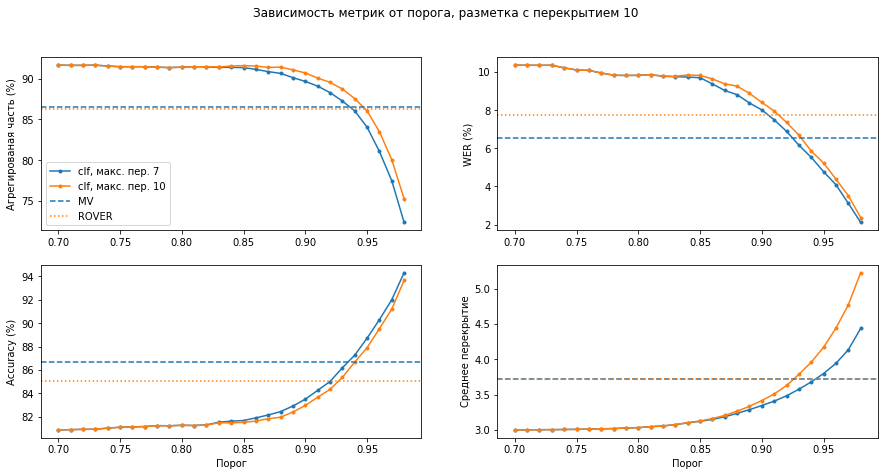

In [124]:
plt.figure(figsize=(15,7))
plt.suptitle('Зависимость метрик от порога, разметка с перекрытием 10')
plt.subplot(221)
plt.plot(scores_clf_quasar_new_max_cost_7[:, 0], 
         scores_clf_quasar_new_max_cost_7[:, 1] * 100, 
         ".-", 
         label="clf, макс. пер. 7")
plt.plot(scores_clf_quasar_new_max_cost_10[:, 0], 
         scores_clf_quasar_new_max_cost_10[:, 1] * 100, 
         ".-", 
         label="clf, макс. пер. 10")
plt.axhline(y=prod_agg_metrics[0] * 100, color=u'#1f77b4', linestyle='--', label="MV")
plt.axhline(y=rover_agg_metrics[0] * 100, color=u'#ff7f0e', linestyle=':', label="ROVER")
plt.legend()
plt.ylabel('Агрегированая часть (%)')

plt.subplot(222)
plt.plot(scores_clf_quasar_new_max_cost_7[:, 0], 
         scores_clf_quasar_new_max_cost_7[:, 2] * 100, 
         ".-")
plt.plot(scores_clf_quasar_new_max_cost_10[:, 0], 
         scores_clf_quasar_new_max_cost_10[:, 2] * 100, 
         ".-")
plt.axhline(y=prod_agg_metrics[1] * 100, color=u'#1f77b4', linestyle='--')
plt.axhline(y=rover_agg_metrics[1] * 100, color=u'#ff7f0e', linestyle=':')

plt.ylabel('WER (%)')


plt.subplot(223)
plt.plot(scores_clf_quasar_new_max_cost_7[:, 0], 
         scores_clf_quasar_new_max_cost_7[:, 3] * 100, 
         ".-")
plt.plot(scores_clf_quasar_new_max_cost_10[:, 0], 
         scores_clf_quasar_new_max_cost_10[:, 3] * 100, 
         ".-")
plt.axhline(y=prod_agg_metrics[2] * 100, color=u'#1f77b4', linestyle='--')
plt.axhline(y=rover_agg_metrics[2] * 100, color=u'#ff7f0e', linestyle=':')
plt.ylabel('Accuracy (%)')

plt.xlabel('Порог')

plt.subplot(224)
plt.plot(scores_clf_quasar_new_max_cost_7[:, 0], 
         scores_clf_quasar_new_max_cost_7[:, 4], 
         ".-")
plt.plot(scores_clf_quasar_new_max_cost_10[:, 0], 
         scores_clf_quasar_new_max_cost_10[:, 4], 
         ".-")
plt.axhline(y=prod_agg_metrics[3], color=u'#1f77b4', linestyle='--')
plt.axhline(y=rover_agg_metrics[3], color=u'#ff7f0e', linestyle=':')
plt.ylabel('Среднее перекрытие')

plt.xlabel('Порог')

plt.savefig("metrics_clf_new_quasar_true.png")
plt.show()

In [125]:
len(data_quasar_test_valid)

3651

In [126]:
from scipy.stats import norm

In [129]:
def err(value, n, conf=0.9):
    z = norm.ppf(conf)
    return z * np.sqrt(value * (1 - value) / n)

In [130]:
scores_clf_quasar_new_max_cost_7[:, 1]

array([0.91673514, 0.91646124, 0.91646124, 0.91673514, 0.91563955,
       0.91481786, 0.91481786, 0.91481786, 0.91427006, 0.91372227,
       0.91427006, 0.91481786, 0.91454396, 0.91399617, 0.91399617,
       0.91372227, 0.91153109, 0.90879211, 0.90660093, 0.90139688,
       0.89674062, 0.89098877, 0.88304574, 0.87263763, 0.86058614,
       0.84059162, 0.81073678, 0.7748562 , 0.72363736])

In [161]:
test_words_count = [
    len(row['text'].split()) for row in data_quasar_test_valid
]
test_words_count = sum(test_words_count)

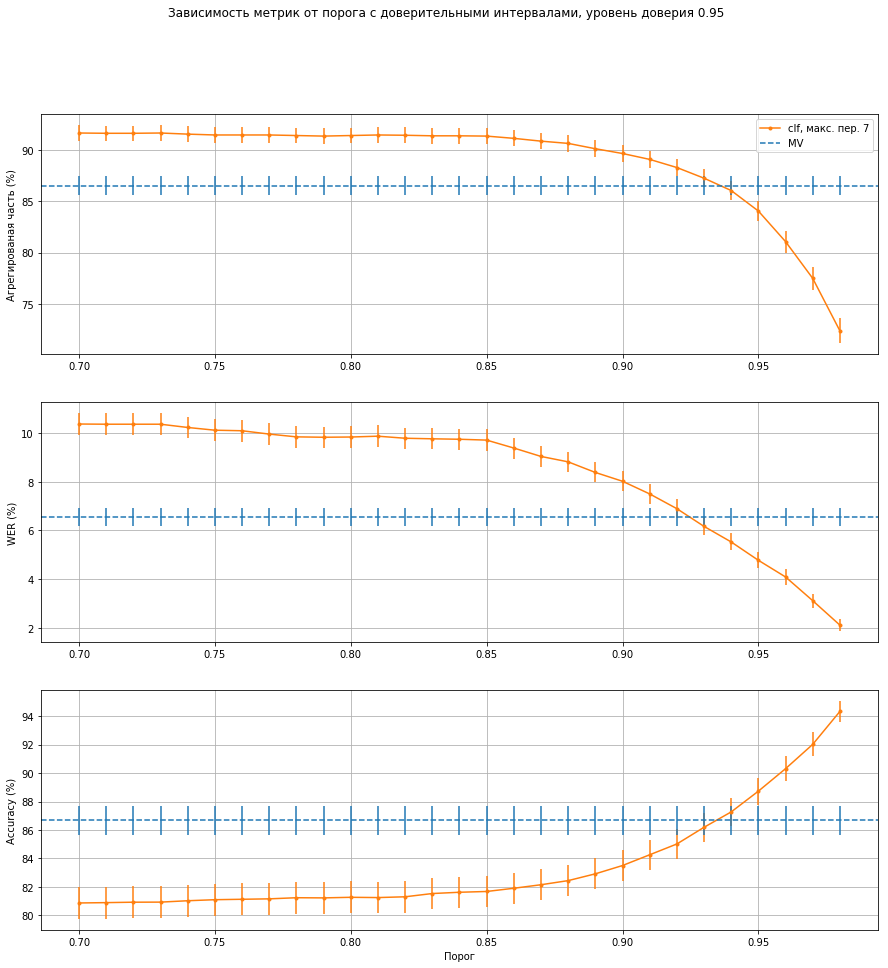

In [225]:
conf = 0.95

plt.figure(figsize=(15,15))
plt.suptitle('Зависимость метрик от порога с доверительными интервалами, уровень доверия {}'.format(conf))
plt.subplot(311)
plt.plot(scores_clf_quasar_new_max_cost_7[:, 0], 
         scores_clf_quasar_new_max_cost_7[:, 1] * 100, 
         ".-", 
         label="clf, макс. пер. 7",
         color=u'#ff7f0e')
plt.errorbar(scores_clf_quasar_new_max_cost_7[:, 0],
            scores_clf_quasar_new_max_cost_7[:, 1] * 100,
            [err(val, len(data_quasar_test_valid), conf=conf) * 100 for val in
            scores_clf_quasar_new_max_cost_7[:, 1]],
            color=u'#ff7f0e',
            linestyle="None")
plt.axhline(y=prod_agg_metrics[0] * 100, color=u'#1f77b4', linestyle='--', label="MV")
plt.errorbar(scores_clf_quasar_new_max_cost_7[:, 0],
            [prod_agg_metrics[0] * 100] * len(scores_clf_quasar_new_max_cost_7[:, 0]),
            [err(val, len(data_quasar_test_valid), conf=conf) * 100 for val in 
            [prod_agg_metrics[0]] * len(scores_clf_quasar_new_max_cost_7[:, 0])],
            color=u'#1f77b4',
            linestyle="None")
plt.ylabel('Агрегированая часть (%)')
plt.grid(True)
plt.legend()

plt.subplot(312)
plt.plot(scores_clf_quasar_new_max_cost_7[:, 0], 
         scores_clf_quasar_new_max_cost_7[:, 2] * 100, 
         ".-",
         color=u'#ff7f0e')
plt.errorbar(scores_clf_quasar_new_max_cost_7[:, 0],
            scores_clf_quasar_new_max_cost_7[:, 2] * 100,
            [err(val[2], val[5], conf=conf) * 100 for val in
            scores_clf_quasar_new_max_cost_7[:]],
            color=u'#ff7f0e',
            linestyle="None")
plt.axhline(y=prod_agg_metrics[1] * 100, color=u'#1f77b4', linestyle='--')
plt.errorbar(scores_clf_quasar_new_max_cost_7[:, 0],
            [prod_agg_metrics[1] * 100] * len(scores_clf_quasar_new_max_cost_7[:, 0]),
            [err(val, prod_agg_metrics[4], conf=conf) * 100 for val in 
            [prod_agg_metrics[1]] * len(scores_clf_quasar_new_max_cost_7[:, 0])],
            color=u'#1f77b4',
            linestyle="None")
plt.grid(True)
plt.ylabel('WER (%)')

plt.subplot(313)
plt.plot(scores_clf_quasar_new_max_cost_7[:, 0], 
         scores_clf_quasar_new_max_cost_7[:, 3] * 100, 
         ".-",
         color=u'#ff7f0e')
plt.errorbar(scores_clf_quasar_new_max_cost_7[:, 0],
            scores_clf_quasar_new_max_cost_7[:, 3] * 100,
            [err(metrics[3], metrics[1] * len(data_quasar_test_valid), conf=conf) * 100 for metrics in
            scores_clf_quasar_new_max_cost_7[:]],
            color=u'#ff7f0e',
            linestyle="None")
plt.axhline(y=prod_agg_metrics[2] * 100, color=u'#1f77b4', linestyle='--')
plt.errorbar(scores_clf_quasar_new_max_cost_7[:, 0],
            [prod_agg_metrics[2] * 100] * len(scores_clf_quasar_new_max_cost_7[:, 0]),
            yerr=[err(val, prod_agg_metrics[0] * len(data_quasar_test_valid), conf=conf) * 100 for val in 
            [prod_agg_metrics[2]] * len(scores_clf_quasar_new_max_cost_7[:, 0])],
            color=u'#1f77b4',
            linestyle="None")
plt.grid(True)
plt.ylabel('Accuracy (%)')

plt.xlabel('Порог')

plt.savefig("metrics_conf_int_quasar_true.png")
plt.show()

In [227]:
scores_clf_quasar_new_max_cost_7 = []

for treshhold in np.linspace(0.7, 0.98, 29):
    print(treshhold)
    metrics = evaluate_metrics_clf_(data_quasar_test_valid, 
                                    data_quasar_new_test_features, 
                                    'toloka_results', 
                                    clf_new, 
                                    treshhold,
                                    max_cost=7)
    scores_clf_quasar_new_max_cost_7.append((treshhold, *metrics))
scores_clf_quasar_new_max_cost_7 = np.array(scores_clf_quasar_new_max_cost_7)

0.7
Aggregated: 91.6735%
WER: 10.3683%
Accuracy: 80.8784%
Mean overlap: 3.0
0.71
Aggregated: 91.6461%
WER: 10.3603%
Accuracy: 80.9026%
Mean overlap: 3.001
0.72
Aggregated: 91.6461%
WER: 10.3603%
Accuracy: 80.9325%
Mean overlap: 3.003
0.73
Aggregated: 91.6735%
WER: 10.3603%
Accuracy: 80.9382%
Mean overlap: 3.004
0.74
Aggregated: 91.5640%
WER: 10.2268%
Accuracy: 81.0350%
Mean overlap: 3.006
0.75
Aggregated: 91.4818%
WER: 10.1147%
Accuracy: 81.1078%
Mean overlap: 3.008
0.76
Aggregated: 91.4818%
WER: 10.0923%
Accuracy: 81.1377%
Mean overlap: 3.012
0.77
Aggregated: 91.4818%
WER: 9.9551%
Accuracy: 81.1677%
Mean overlap: 3.016
0.7799999999999999
Aggregated: 91.4270%
WER: 9.8412%
Accuracy: 81.2463%
Mean overlap: 3.019
0.7899999999999999
Aggregated: 91.3722%
WER: 9.8252%
Accuracy: 81.2350%
Mean overlap: 3.027
0.7999999999999999
Aggregated: 91.4270%
WER: 9.8349%
Accuracy: 81.2762%
Mean overlap: 3.033
0.8099999999999999
Aggregated: 91.4818%
WER: 9.8686%
Accuracy: 81.2575%
Mean overlap: 3.046
0.82

In [189]:
print('toloka_results')
print('Prod: ')
prod_agg_metrics = evaluate_metrics(data_quasar_test_valid, 'toloka_results', aggregate_prod)

toloka_results
Prod: 
Aggregated: 86.5242%
WER: 6.5530%
Accuracy: 86.6730%
Mean overlap: 3.722


In [213]:
scores_clf_quasar_new_max_cost_7[-6:-3, 3] * 100 + [err(metrics[3], metrics[1] * len(data_quasar_test_valid), conf=conf) * 100 for metrics in
            scores_clf_quasar_new_max_cost_7[:]][-6:-3]

array([87.1949709 , 88.24735176, 89.66503035])

In [204]:
[err(val, len(data_quasar_test_valid), conf=0.95) * 100 for val in
            scores_clf_quasar_new_max_cost_7[:, 1]][-6:-3]

[0.9075255683179588, 0.9429127079071443, 0.9964819671914716]

In [212]:
scores_clf_quasar_new_max_cost_7[-6:-3]

array([[9.30000000e-01, 8.72637634e-01, 6.16706363e-02, 8.61895794e-01,
        3.57737606e+00, 1.17560000e+04],
       [9.40000000e-01, 8.60586141e-01, 5.52763819e-02, 8.72692553e-01,
        3.68090934e+00, 1.15420000e+04],
       [9.50000000e-01, 8.40591619e-01, 4.77510507e-02, 8.87259694e-01,
        3.80005478e+00, 1.11830000e+04]])

In [224]:
prod_agg_metrics[2] * 100 + err(prod_agg_metrics[2], prod_agg_metrics[0] * len(data_quasar_test_valid), conf=conf) * 100

87.66762557057116

In [222]:
err(prod_agg_metrics[2], prod_agg_metrics[0] * len(data_quasar_test_valid), conf=conf) * 100

0.9946277864622577

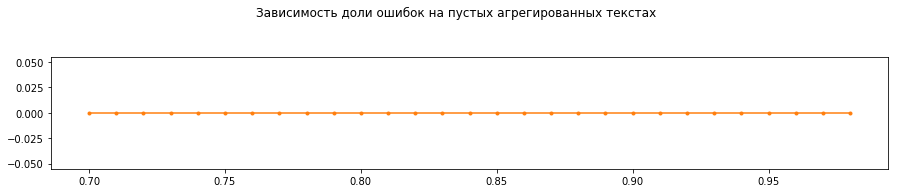

In [232]:
plt.figure(figsize=(15,7))
plt.suptitle('Зависимость доли ошибок на пустых агрегированных текстах')
plt.subplot(311)
plt.plot(scores_clf_quasar_new_max_cost_7[:, 0], 
         scores_clf_quasar_new_max_cost_7[:, 6] * 100, 
         ".-", 
         label="clf, макс. пер. 7",
         color=u'#ff7f0e')

In [ ]:
clf_new.save_model('10_true.cbm')